In [ ]:
library(BiocManager)
library(tidyverse)

Bioconductor version '3.19' is out-of-date; the current release version '3.21'
  is available with R version '4.5'; see https://bioconductor.org/install

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [ ]:
library(qs)
library(nnet)
library(tidyverse)
library(eulerr)
library(randomForest)
library(caret)
library(Boruta)
library(glmnet)
library(ggpubr)
library(MLeval)
library(e1071)
library(ROCR)
library(NetDA)
library(fastDummies)
library(glmnet)
library(corrplot)
library(coefplot)
library(Hmisc)
library(biomaRt)
library(pROC)
library(clusterProfiler)
library(SummarizedExperiment)
library(Biobase)

# Binomial classification

## FM_2

In [ ]:
### Uploading statistically significant DGE analysis results
dge_res <- qread("/kaggle/input/dge-wgcna-res/DGE_FM_2_res_annot.qs")
DGE_genes_manf_FM_2 <- dge_res[!is.na(dge_res$SYMBOL) &
                               dge_res$`P.Value` < 0.001 &  # Soft p-value threshold
                               dge_res$`adj.P.Val` < 0.5, ]$SYMBOL

DGE_gid_manf_FM_2 <- dge_res[!is.na(dge_res$SYMBOL) &
                               dge_res$`P.Value` < 0.001 &
                               dge_res$`adj.P.Val` < 0.5, ]$PROBEID

In [ ]:
### Uploading statistically significant WGCNA results
wgcna_res <- qread("/kaggle/input/dge-wgcna-res/WGSNA_FM_2_res_annot.qs")
wgcna_res <- wgcna_res %>%
  group_by(SYMBOL) %>%
  filter(`p.GS.diagnosis_fibromyalgia` == min(`p.GS.diagnosis_fibromyalgia`)) %>%
  ungroup()

WGCNA_gid_further_FM_2 <- wgcna_res[!is.na(wgcna_res$SYMBOL) &
                                    wgcna_res$`p.GS.diagnosis_fibromyalgia` < 0.05, ]$PROBEID

In [ ]:
### Uploading train and test expression (X) and phenotype data (Y)
df_train <- qread("/kaggle/input/dge-wgcna-res/gse_train_FM_2.qs")
df_test <- qread("/kaggle/input/dge-wgcna-res/gse_test_FM_2.qs")

train <- as.data.frame(t(exprs(df_train)))
test <- as.data.frame(t(exprs(df_test)))
combined_gid <- unique(c(WGCNA_gid_further_FM_2, DGE_gid_manf_FM_2))
X_train <- train %>% dplyr::select(all_of(combined_gid))
X_test <- test %>% dplyr::select(all_of(combined_gid))


### Converting disease condition study to vector with levels
pd_train <- pData(df_train)[, c("diagnosis:ch1")]
pd_train <- dummy_cols(pd_train, remove_selected_columns=TRUE)
Y_train <- pd_train$`.data_fibromyalgia`

pd_test <- pData(df_test)[, c("diagnosis:ch1")]
pd_test <- dummy_cols(pd_test, remove_selected_columns=TRUE)
Y_test <- pd_test$`.data_fibromyalgia`

Y_train_as_factor <- as.factor(pData(df_train)[, c("diagnosis:ch1")])
Y_train_as_factor <- relevel(Y_train_as_factor, ref = "healthy control")

Y_test_as_factor <- relevel(Y_test_as_factor, ref = "healthy control")
Y_test_as_factor <- as.factor(pData(df_test)[, c("diagnosis:ch1")])

In [ ]:
### Calculating class weights to account imbalances
class_counts <- table(Y_train)
total_samples <- sum(class_counts)
num_classes <- length(class_counts)
class_weights <- total_samples / (num_classes * class_counts)

class_counts <- table(Y_train_as_factor)
total_samples <- sum(class_counts)
num_classes <- length(class_counts)
class_weights_fact <- total_samples / (num_classes * class_counts)

In [ ]:
### Train data log standartisation
X_train_norm <- log(X_train + 1)
mean_values <- colMeans(X_train_norm)
std_values <- apply(X_train_norm, 2, sd)
X_train_norm <- scale(X_train_norm, center = mean_values, scale = std_values)
X_train_norm <- as.data.frame(X_train_norm)

### Applying mean and SD calculated for train data on test data
X_test_norm <- log(X_test + 1)
X_test_norm <- scale(X_test_norm, center = mean_values, scale = std_values)
X_test_norm <- as.data.frame(X_test_norm)

In [ ]:
### Feature filtration using RFE and Boruta
set.seed(123)

GIDs <- list(WGCNA_statsig = WGCNA_gid_further_FM_2)
for (genelist_name in names(GIDs)) {  # Iterate over names of the GIDs list
    print(paste("Processing gene list:", genelist_name))
    GID <- GIDs[[genelist_name]] # Extract the gene list itself

    X_train_norm_1 <- X_train_norm %>% dplyr::select(all_of(GID))

    # RFE (Recursive Feature Elimination)
    control <- rfeControl(functions = rfFuncs,  # using random forest for feature ranking
                          method = "repeatedcv",
                          number = 10,  # 10-fold cross-validation
                          repeats = 3)
    rfe_results <- rfe(
      x = X_train_norm_1,
      y = Y_train_as_factor,
      sizes = seq(5, min(55, ncol(X_train_norm_1)), by = 5), # Ensure 'sizes' doesn't exceed number of features
      rfeControl = control
    )

    print(rfe_results)
    qsave(rfe_results, file = paste0("RFE_res_", genelist_name, ".qs"))
    genelist_rfe_predict <- predictors(rfe_results)
    length(genelist_rfe_predict)
    qsave(genelist_rfe_predict, file = paste0("RFE_", genelist_name, ".qs"))


    # Boruta

    boruta_data <- data.frame(Y_train_as_factor = Y_train_as_factor, X_train_norm_1, check.names = FALSE)
    names(boruta_data) <- make.names(names(boruta_data))
    boruta_formula <- as.formula("Y_train_as_factor ~ .")
    boruta_results <- Boruta(
      formula = boruta_formula,
      data = boruta_data,
      doTrace = 2
    )
    boruta_final <- TentativeRoughFix(boruta_results)
    print(boruta_final)
    selected_features <- getSelectedAttributes(boruta_final,
                                               withTentative = FALSE) # Eliminate tentative fetures
    selected_features <- lapply(selected_features, function(x) str_remove(x, "^X"))
    qsave(selected_features, file = paste0("Boruta_", genelist_name, ".qs"))
}

[1] "Processing gene list: WGCNA_statsig"

Recursive feature selection

Outer resampling method: Cross-Validated (10 fold, repeated 3 times) 

Resampling performance over subset size:

 Variables Accuracy   Kappa AccuracySD KappaSD Selected
         5   0.5267 0.04518    0.11434  0.2322         
        10   0.5900 0.17116    0.10277  0.2164         
        15   0.5967 0.18490    0.10650  0.2229         
        20   0.5963 0.18555    0.08938  0.1882         
        25   0.6096 0.21417    0.11122  0.2278         
        30   0.6133 0.21880    0.08799  0.1879        *
        35   0.6070 0.20644    0.09484  0.2008         
        40   0.5930 0.17774    0.09919  0.2102         
        45   0.6070 0.20684    0.09484  0.1994         
        50   0.5993 0.18940    0.10074  0.2121         
        55   0.6063 0.20295    0.11156  0.2322         
       264   0.5863 0.16520    0.10031  0.2090         

The top 5 variables (out of 30):
   8078227, 8029671, 7901376, 8024436, 8119161



 1. run of importance source...

 2. run of importance source...

 3. run of importance source...

 4. run of importance source...

 5. run of importance source...

 6. run of importance source...

 7. run of importance source...

 8. run of importance source...

 9. run of importance source...

 10. run of importance source...

 11. run of importance source...

 12. run of importance source...

 13. run of importance source...

 14. run of importance source...

 15. run of importance source...

After 15 iterations, +1.6 secs: 

 rejected 251 attributes: X7897288, X7898211, X7898663, X7898894, X7899534 and 246 more;

 still have 13 attributes left.


 16. run of importance source...

 17. run of importance source...

 18. run of importance source...

 19. run of importance source...

 20. run of importance source...

After 20 iterations, +1.8 secs: 

 rejected 3 attributes: X7910241, X7972297, X8087576;

 still have 10 attributes left.


 21. run of importance source...

 22. run of im

Boruta performed 99 iterations in 4.58516 secs.
Tentatives roughfixed over the last 99 iterations.
 6 attributes confirmed important: X7901376, X7979615, X8078227,
X8108847, X8112331 and 1 more;
 258 attributes confirmed unimportant: X7897288, X7898211, X7898663,
X7898894, X7899534 and 253 more;


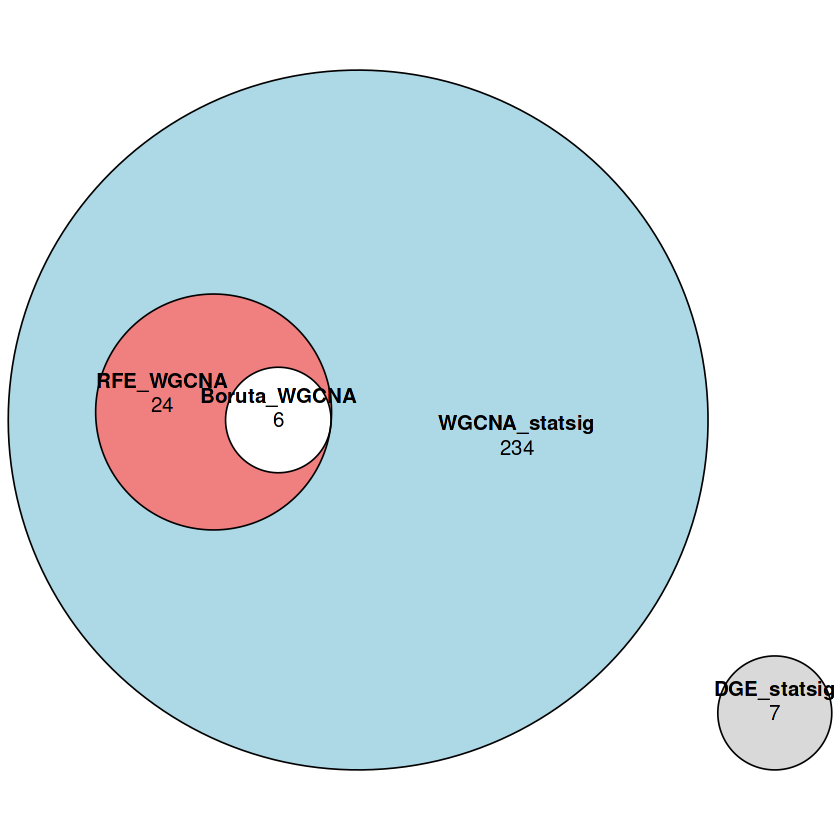

In [ ]:
### Euler diagramm to visualise overlaps within generated genesets
venn_list <- list(
    Boruta_WGCNA = as.character(selected_features),
    DGE_statsig = DGE_gid_manf_FM_2,
    WGCNA_statsig = WGCNA_gid_further_FM_2,
    RFE_WGCNA = genelist_rfe_predict
  )

fit1 <- euler(venn_list)
venn <- plot(fit1, quantities = TRUE)
print(venn)

[1] "Processing gene list: Boruta_WGCNA"
[1] "#####################  RF  #####################"
Confusion Matrix and Statistics

                 Reference
Prediction        healthy control fibromyalgia
  healthy control              11            7
  fibromyalgia                  7            7
                                          
               Accuracy : 0.5625          
                 95% CI : (0.3766, 0.7364)
    No Information Rate : 0.5625          
    P-Value [Acc > NIR] : 0.5734          
                                          
                  Kappa : 0.1111          
                                          
 Mcnemar's Test P-Value : 1.0000          
                                          
            Sensitivity : 0.5000          
            Specificity : 0.6111          
         Pos Pred Value : 0.5000          
         Neg Pred Value : 0.6111          
             Prevalence : 0.4375          
         Detection Rate : 0.2188          
   Detection Pr

Setting levels: control = healthy control, case = fibromyalgia

Setting direction: controls < cases



[1] "#####################  SVM  #####################"
Confusion Matrix and Statistics

                 Reference
Prediction        healthy control fibromyalgia
  healthy control              12            7
  fibromyalgia                  6            7
                                         
               Accuracy : 0.5938         
                 95% CI : (0.4064, 0.763)
    No Information Rate : 0.5625         
    P-Value [Acc > NIR] : 0.4323         
                                         
                  Kappa : 0.168          
                                         
 Mcnemar's Test P-Value : 1.0000         
                                         
            Sensitivity : 0.5000         
            Specificity : 0.6667         
         Pos Pred Value : 0.5385         
         Neg Pred Value : 0.6316         
             Prevalence : 0.4375         
         Detection Rate : 0.2188         
   Detection Prevalence : 0.4062         
      Balanced Accuracy : 0.5

Setting levels: control = healthy control, case = fibromyalgia

Setting direction: controls > cases



[1] "#####################  Logistic regression  #####################"

Call:  cv.glmnet(x = as.matrix(X_train_norm[, genelist]), y = as.vector(unlist(Y_train)),      family = "binomial") 

Measure: Binomial Deviance 

     Lambda Index Measure      SE Nonzero
min 0.06316    13   1.335 0.06551       4
1se 0.17574     2   1.397 0.02368       2


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "#####################  ROC AUC  #####################"
[1] "Processing gene list: DGE_statsig"
[1] "#####################  RF  #####################"
Confusion Matrix and Statistics

                 Reference
Prediction        healthy control fibromyalgia
  healthy control              11            8
  fibromyalgia                  7            6
                                          
               Accuracy : 0.5312          
                 95% CI : (0.3474, 0.7091)
    No Information Rate : 0.5625          
    P-Value [Acc > NIR] : 0.705           
                                          
                  Kappa : 0.04            
                                          
 Mcnemar's Test P-Value : 1.000           
                                          
            Sensitivity : 0.4286          
            Specificity : 0.6111          
         Pos Pred Value : 0.4615          
         Neg Pred Value : 0.5789          
             Prevalence : 0.4375          

Setting levels: control = healthy control, case = fibromyalgia

Setting direction: controls > cases



[1] "#####################  SVM  #####################"
Confusion Matrix and Statistics

                 Reference
Prediction        healthy control fibromyalgia
  healthy control              10            7
  fibromyalgia                  8            7
                                          
               Accuracy : 0.5312          
                 95% CI : (0.3474, 0.7091)
    No Information Rate : 0.5625          
    P-Value [Acc > NIR] : 0.705           
                                          
                  Kappa : 0.0551          
                                          
 Mcnemar's Test P-Value : 1.000           
                                          
            Sensitivity : 0.5000          
            Specificity : 0.5556          
         Pos Pred Value : 0.4667          
         Neg Pred Value : 0.5882          
             Prevalence : 0.4375          
         Detection Rate : 0.2188          
   Detection Prevalence : 0.4688          
      Balanc

Setting levels: control = healthy control, case = fibromyalgia

Setting direction: controls > cases



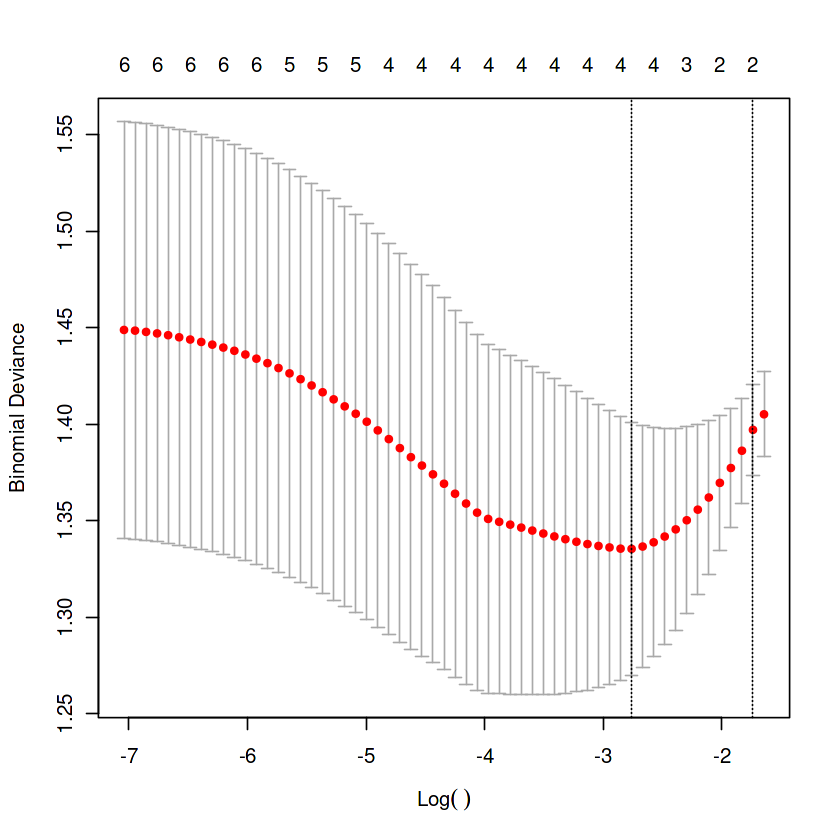

[1] "#####################  Logistic regression  #####################"

Call:  cv.glmnet(x = as.matrix(X_train_norm[, genelist]), y = as.vector(unlist(Y_train)),      family = "binomial") 

Measure: Binomial Deviance 

     Lambda Index Measure      SE Nonzero
min 0.02504    26   1.122 0.09765       4
1se 0.13364     8   1.217 0.04930       3


Setting levels: control = 0, case = 1

Setting direction: controls > cases



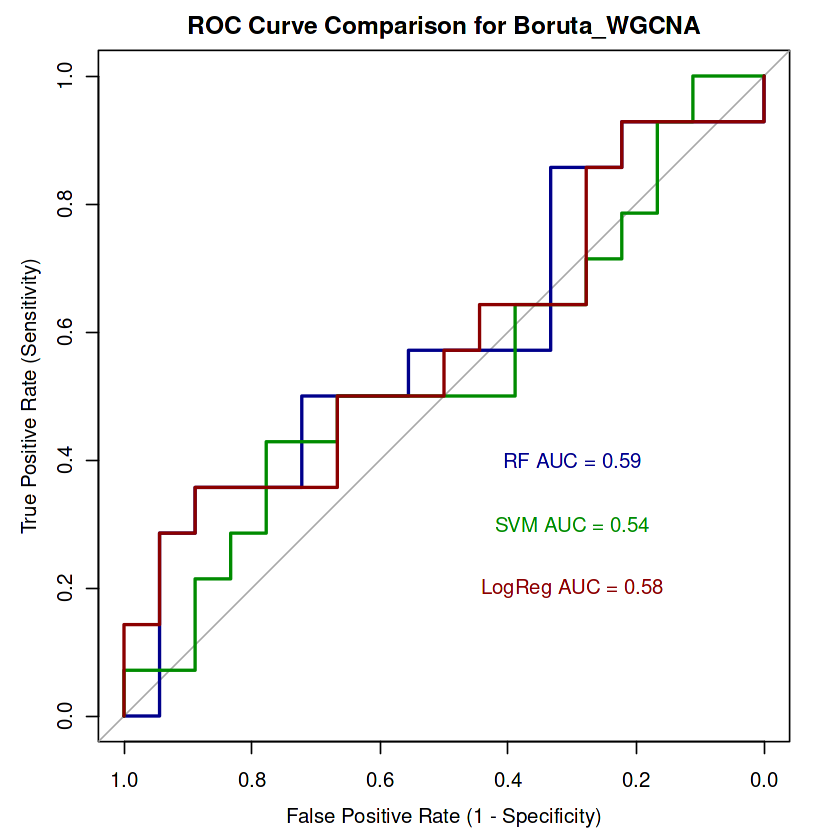

[1] "#####################  ROC AUC  #####################"
[1] "Processing gene list: WGCNA_statsig"
[1] "#####################  RF  #####################"
Confusion Matrix and Statistics

                 Reference
Prediction        healthy control fibromyalgia
  healthy control              11            7
  fibromyalgia                  7            7
                                          
               Accuracy : 0.5625          
                 95% CI : (0.3766, 0.7364)
    No Information Rate : 0.5625          
    P-Value [Acc > NIR] : 0.5734          
                                          
                  Kappa : 0.1111          
                                          
 Mcnemar's Test P-Value : 1.0000          
                                          
            Sensitivity : 0.5000          
            Specificity : 0.6111          
         Pos Pred Value : 0.5000          
         Neg Pred Value : 0.6111          
             Prevalence : 0.4375        

Setting levels: control = healthy control, case = fibromyalgia

Setting direction: controls < cases



[1] "#####################  SVM  #####################"
Confusion Matrix and Statistics

                 Reference
Prediction        healthy control fibromyalgia
  healthy control              11            7
  fibromyalgia                  7            7
                                          
               Accuracy : 0.5625          
                 95% CI : (0.3766, 0.7364)
    No Information Rate : 0.5625          
    P-Value [Acc > NIR] : 0.5734          
                                          
                  Kappa : 0.1111          
                                          
 Mcnemar's Test P-Value : 1.0000          
                                          
            Sensitivity : 0.5000          
            Specificity : 0.6111          
         Pos Pred Value : 0.5000          
         Neg Pred Value : 0.6111          
             Prevalence : 0.4375          
         Detection Rate : 0.2188          
   Detection Prevalence : 0.4375          
      Balanc

Setting levels: control = healthy control, case = fibromyalgia

Setting direction: controls > cases



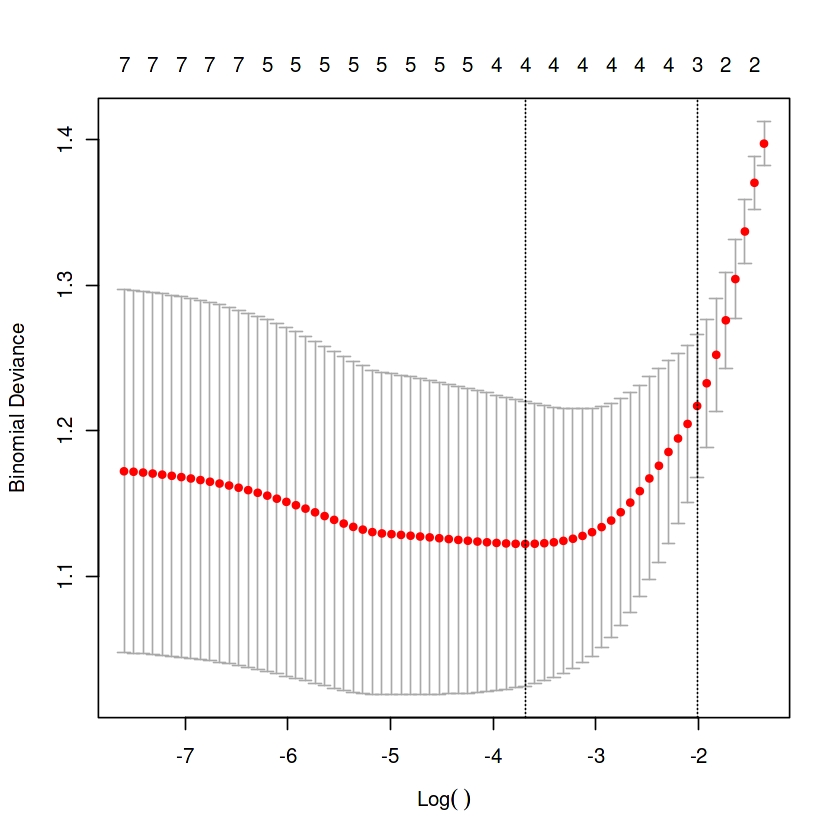

[1] "#####################  Logistic regression  #####################"

Call:  cv.glmnet(x = as.matrix(X_train_norm[, genelist]), y = as.vector(unlist(Y_train)),      family = "binomial") 

Measure: Binomial Deviance 

     Lambda Index Measure      SE Nonzero
min 0.09072    18   1.343 0.06111       5
1se 0.19096     2   1.399 0.01377       1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



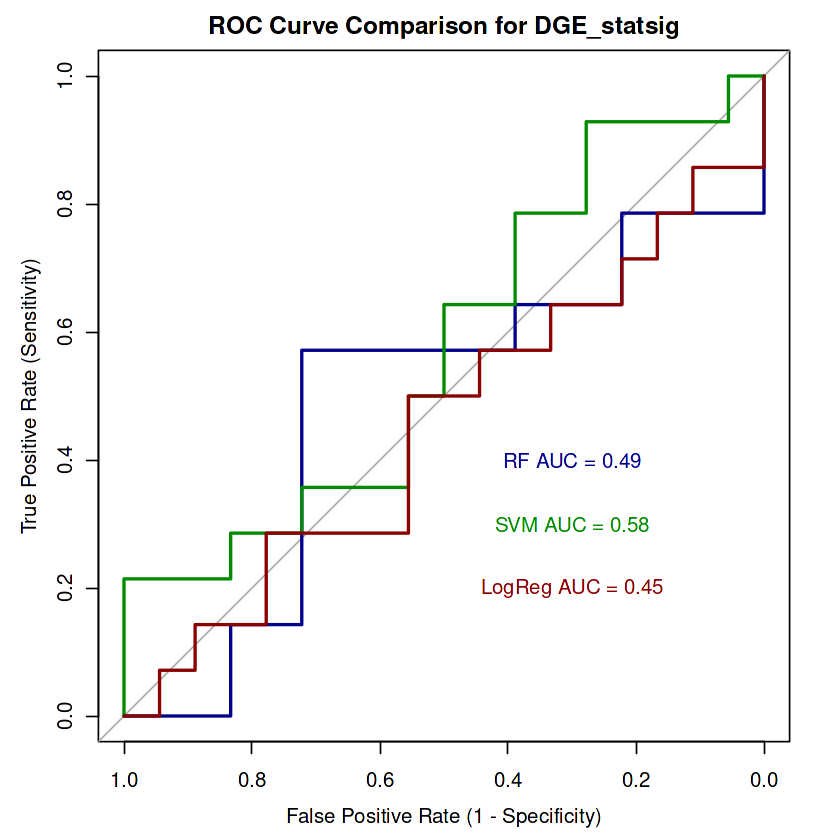

[1] "#####################  ROC AUC  #####################"
[1] "Processing gene list: RFE_WGCNA"
[1] "#####################  RF  #####################"
Confusion Matrix and Statistics

                 Reference
Prediction        healthy control fibromyalgia
  healthy control              10           10
  fibromyalgia                  8            4
                                          
               Accuracy : 0.4375          
                 95% CI : (0.2636, 0.6234)
    No Information Rate : 0.5625          
    P-Value [Acc > NIR] : 0.9450          
                                          
                  Kappa : -0.1613         
                                          
 Mcnemar's Test P-Value : 0.8137          
                                          
            Sensitivity : 0.2857          
            Specificity : 0.5556          
         Pos Pred Value : 0.3333          
         Neg Pred Value : 0.5000          
             Prevalence : 0.4375          
 

Setting levels: control = healthy control, case = fibromyalgia

Setting direction: controls < cases



[1] "#####################  SVM  #####################"
Confusion Matrix and Statistics

                 Reference
Prediction        healthy control fibromyalgia
  healthy control              11            8
  fibromyalgia                  7            6
                                          
               Accuracy : 0.5312          
                 95% CI : (0.3474, 0.7091)
    No Information Rate : 0.5625          
    P-Value [Acc > NIR] : 0.705           
                                          
                  Kappa : 0.04            
                                          
 Mcnemar's Test P-Value : 1.000           
                                          
            Sensitivity : 0.4286          
            Specificity : 0.6111          
         Pos Pred Value : 0.4615          
         Neg Pred Value : 0.5789          
             Prevalence : 0.4375          
         Detection Rate : 0.1875          
   Detection Prevalence : 0.4062          
      Balanc

Setting levels: control = healthy control, case = fibromyalgia

Setting direction: controls > cases



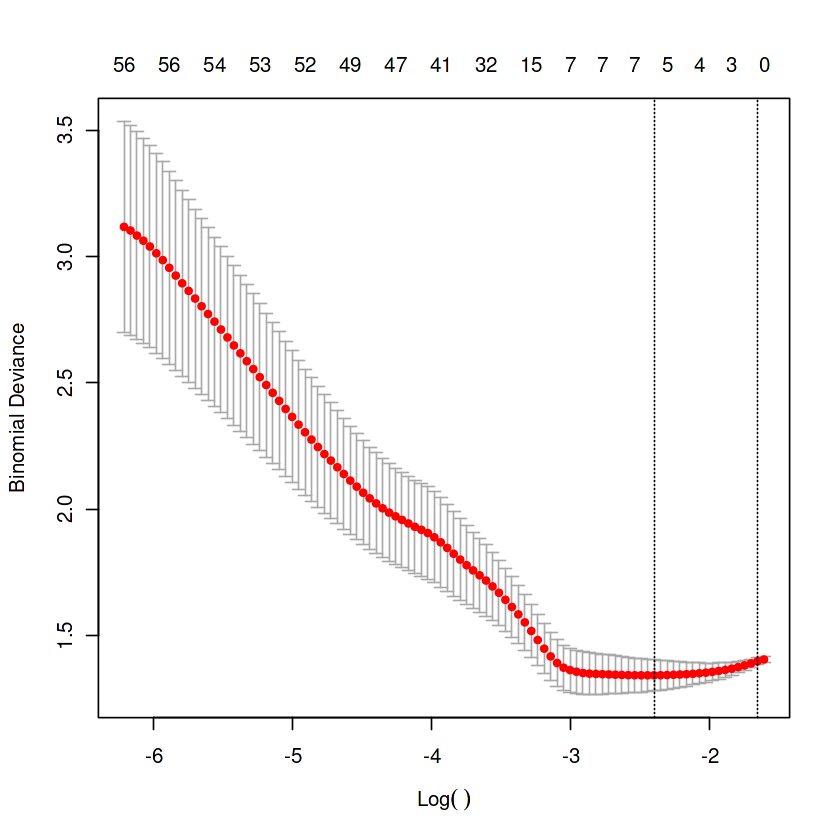

[1] "#####################  Logistic regression  #####################"

Call:  cv.glmnet(x = as.matrix(X_train_norm[, genelist]), y = as.vector(unlist(Y_train)),      family = "binomial") 

Measure: Binomial Deviance 

    Lambda Index Measure      SE Nonzero
min 0.0719    12   1.344 0.09506       7
1se 0.2001     1   1.401 0.01391       0


Setting levels: control = 0, case = 1

Setting direction: controls < cases



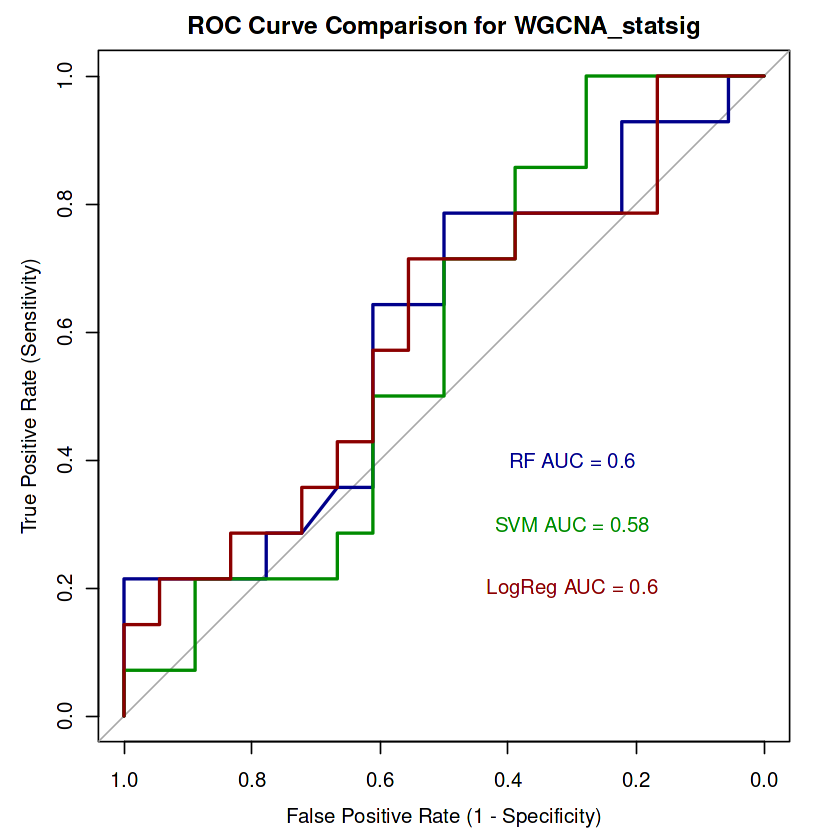

[1] "#####################  ROC AUC  #####################"


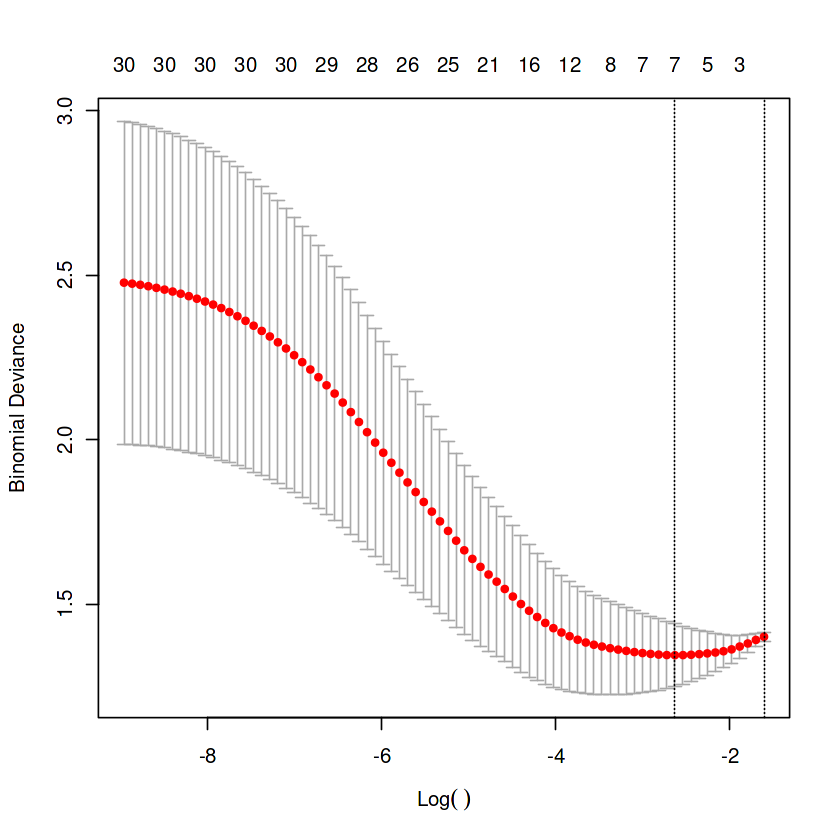

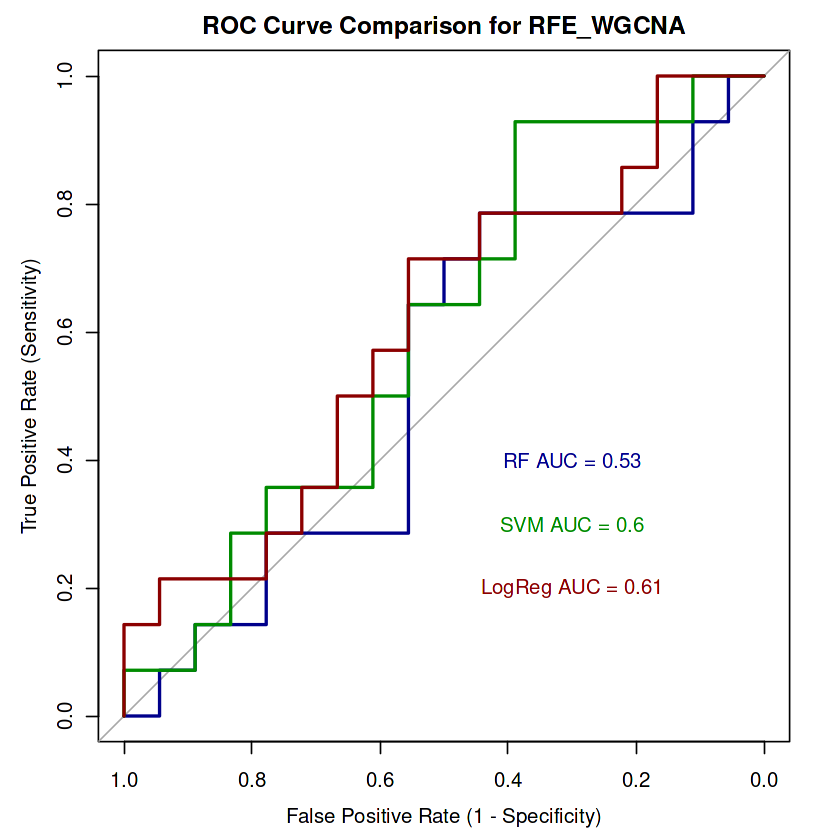

In [ ]:
### Fitting and testing binomial classification models

set.seed(123)

genelists <- venn_list

for (genelist_name in names(genelists)) {
    print(paste("Processing gene list:", genelist_name))
    genelist <- genelists[[genelist_name]]

    print("#####################  RF  #####################")

    rf_model <- randomForest(
      x = X_train_norm[, genelist],
      y = Y_train_as_factor,
      ntree = 1501,
      importance = TRUE, # Exctract feature importance (median and for each class)
      classwt = class_weights_fact,
      mtry = floor(sqrt(length(genelist)))
    )

    # Evaluate performance on test data
    pred_rf <- predict(rf_model, X_test_norm[, genelist])

    # Confusion matrix
    confusion_rf <- confusionMatrix(pred_rf, Y_test_as_factor, positive = "fibromyalgia") ##### !!! (changable variable between datasets)
    print(confusion_rf)

    # Feature importance table
    feature_importance_rf <- as.data.frame(importance(rf_model))
    feature_importance_rf$Feature <- rownames(feature_importance_rf)
    qsave(feature_importance_rf, paste0(genelist_name,"_feature_importance_rf.qs"))

    # Calculating ROC values and AUC
    pred_rf_prob <- predict(rf_model, X_test_norm[, genelist], type = "prob")
    positive_class_index <- 2                                                             ##### !!! (changable variable between datasets)
    pred_prob_positive_class <- pred_rf_prob[, positive_class_index]
    roc_rf <- roc(Y_test_as_factor, pred_prob_positive_class) # Y_test must be a factor
    qsave(roc_rf, paste0(genelist_name,"_roc_rf.qs"))

    print("#####################  SVM  #####################")

    svm_tuned <- tune(svm,
      Y_train_as_factor ~ .,
      data = data.frame(Y_train_as_factor = Y_train_as_factor, X_train_norm[, genelist], check.names = FALSE),
      kernel = "radial",
      type = "C-classification",
      ranges = list(cost = c(0.01, 0.1, 1, 10, 50, 100),  # Hyperparameter tuning
                    gamma = c(1 / length(genelist), 0.001, 0.01, 0.1, 1, 10)),
      class.weights = class_weights_fact,
      tunecontrol = tune.control(cross = 10) # 10-fold cross validation
    )
    summary(svm_tuned)

    # Evaluate the best model on the test set
    best_model_svm <- svm_tuned$best.model
    pred_svm <- predict(best_model_svm, X_test_norm[, genelist])

    # Confusion matrix
    confusion_svm <- confusionMatrix(pred_svm, Y_test_as_factor, positive = "fibromyalgia") ##### !!! (changable variable between datasets)
    print(confusion_svm)

    # Calculating ROC values and AUC
    pred_svm_prob <- predict(best_model_svm, X_test_norm[, genelist], decision.values = TRUE)
    pred_prob_svm <- attributes(pred_svm_prob)$decision.values
    roc_svm <- roc(Y_test_as_factor, as.numeric(pred_prob_svm))
    qsave(roc_svm, paste0(genelist_name,"_roc_svm.qs"))


    print("#####################  Logistic regression  #####################")

    # Cross-validation with lambda tunning
    cvfit <- cv.glmnet(as.matrix(X_train_norm[, genelist]), as.vector(unlist(Y_train)), family = "binomial")

    # Print cross-validation curves and best lambda values and number of genes with nonzero weights
    plot(cvfit)
    print(cvfit)

    # Using lambda that gives minimum mean cross-validated error
    coef_at_min <- coef(cvfit, s = "lambda.min")
    nonzero_coef_1 <- extract.coef(cvfit)
    genelist_nonzero_coef_1 <- rownames(nonzero_coef_1)[-1]

    # Print intersept and genes with nonzero coefficents
    head(nonzero_coef_1)
    qsave(nonzero_coef_1, paste0(genelist_name,"_nonzero_coef_logreg.qs"))

    # Prediction on test dataset
    prediction_test <- predict(cvfit, newx = as.matrix(X_test_norm[, genelist]), family = "binomial", s = "lambda.min", type='response')
    prediction_test_measures <- assess.glmnet(cvfit, newx = as.matrix(X_test_norm[, genelist]), newy = as.vector(unlist(Y_test)), family = "binomial", s = "lambda.min")
    prediction_test_measures

    # Calculating ROC values and AUC
    roc_logreg <- roc(as.vector(unlist(Y_test)), c(prediction_test)) # swapped arguments
    qsave(roc_logreg, paste0(genelist_name,"_roc_logreg.qs"))

    print("#####################  ROC AUC  #####################")

    # ROC-AUC graphs to compare models performance
    plot(roc_rf, col = "blue4", print.auc = FALSE,
         xlab = "False Positive Rate (1 - Specificity)",
         ylab = "True Positive Rate (Sensitivity)",
         main = paste0("ROC Curve Comparison for ", genelist_name))
    rf_auc_text <- paste("RF AUC =", round(auc(roc_rf), 2))
    text(x = 0.3, y = 0.4, labels = rf_auc_text, col = "blue4")

    plot(roc_svm, col = "green4", print.auc = FALSE, add = TRUE)
    svm_auc_text <- paste("SVM AUC =", round(auc(roc_svm), 2))
    text(x = 0.3, y = 0.3, labels = svm_auc_text, col = "green4")

    plot(roc_logreg, col = "red4", print.auc = FALSE, add = TRUE)
    logreg_auc_text <- paste("LogReg AUC =", round(auc(roc_logreg), 2))
    text(x = 0.3, y = 0.2, labels = logreg_auc_text, col = "red4")
}

## CFS_4

In [ ]:
### Uploading statistically significant DGE analysis results
### Uploading train and test expression (X) and phenotype data (Y)
### Converting disease condition study to vector with levels

dge_res <- qread("/kaggle/input/dge-wgcna-res/DGE_CFS_4_res_annot.qs")

DGE_genes_manf_CFS_4 <- dge_res[!is.na(dge_res$Symbol) &
                               dge_res$pvalue < 0.001 &
                               dge_res$padj < 0.5, ]$Symbol

DGE_gid_manf_CFS_4 <- dge_res[!is.na(dge_res$Symbol) &
                               dge_res$pvalue < 0.001 &
                               dge_res$padj < 0.5, ]$GeneID

df_train <- qread("/kaggle/input/dge-wgcna-res/gse_train_CFS_4.qs")
df_test <- qread("/kaggle/input/dge-wgcna-res/gse_test_CFS_4.qs")

train <- as.data.frame(t(exprs(df_train)))
test <- as.data.frame(t(exprs(df_test)))
X_train <- train %>% dplyr::select(all_of(DGE_gid_manf_CFS_4))
X_test <- test %>% dplyr::select(all_of(DGE_gid_manf_CFS_4))

pd_train <- pData(df_train)[, c("disease state:ch1")]
pd_train <- dummy_cols(pd_train, remove_selected_columns=TRUE)
Y_train <- pd_train$`.data_ME/CFS`
pd_test <- pData(df_test)[, c("disease state:ch1")]
pd_test <- dummy_cols(pd_test, remove_selected_columns=TRUE)
Y_test <- pd_test$`.data_ME/CFS`

Y_train_as_factor <- as.factor(pData(df_train)[, c("disease state:ch1")])
Y_test_as_factor <- as.factor(pData(df_test)[, c("disease state:ch1")])
Y_train_as_factor <- relevel(Y_train_as_factor, ref = "Control")
Y_test_as_factor <- relevel(Y_test_as_factor, ref = "Control")

In [ ]:
### Calculating class weights to account imbalances

class_counts <- table(Y_train)
total_samples <- sum(class_counts)
num_classes <- length(class_counts)
class_weights <- total_samples / (num_classes * class_counts)

class_counts <- table(Y_train_as_factor)
total_samples <- sum(class_counts)
num_classes <- length(class_counts)
class_weights_fact <- total_samples / (num_classes * class_counts)

In [ ]:
### Train data log standartisation
### Applying mean and SD calculated for train data on test data

X_train_norm <- log(X_train + 1)
mean_values <- colMeans(X_train_norm)
std_values <- apply(X_train_norm, 2, sd)
X_train_norm <- scale(X_train_norm, center = mean_values, scale = std_values)
X_train_norm <- as.data.frame(X_train_norm)

X_test_norm <- log(X_test + 1)
X_test_norm <- scale(X_test_norm, center = mean_values, scale = std_values)
X_test_norm <- as.data.frame(X_test_norm)

In [ ]:
### Feature filtration using RFE and Boruta

set.seed(123)

GIDs <- list(DGE_statsig = DGE_gid_manf_CFS_4)
for (genelist_name in names(GIDs)) {
    print(paste("Processing gene list:", genelist_name))

    GID <- GIDs[[genelist_name]]

    X_train_norm_1 <- X_train_norm %>% dplyr::select(all_of(GID))

    # RFE (Recursive Feature Elimination)
    control <- rfeControl(functions = rfFuncs,
                          method = "repeatedcv",
                          number = 10,
                          repeats = 3)
    rfe_results <- rfe(
      x = X_train_norm_1,
      y = Y_train_as_factor,
      sizes = seq(5, min(55, ncol(X_train_norm_1)), by = 5),
      rfeControl = control
    )
    print(rfe_results)
    qsave(rfe_results, file = paste0("RFE_res_", genelist_name, ".qs"))
    genelist_rfe_predict <- predictors(rfe_results)
    length(genelist_rfe_predict)
    qsave(genelist_rfe_predict, file = paste0("RFE_", genelist_name, ".qs"))

    # Boruta

    boruta_data <- data.frame(Y_train_as_factor = Y_train_as_factor, X_train_norm_1, check.names = FALSE)
    names(boruta_data) <- make.names(names(boruta_data))
    boruta_formula <- as.formula("Y_train_as_factor ~ .")
    boruta_results <- Boruta(
      formula = boruta_formula,
      data = boruta_data,
      doTrace = 2
    )
    boruta_final <- TentativeRoughFix(boruta_results)
    print(boruta_final)
    selected_features <- getSelectedAttributes(boruta_final, withTentative = FALSE)
    selected_features <- lapply(selected_features, function(x) str_remove(x, "^X"))
    qsave(selected_features, file = paste0("Boruta_", genelist_name, ".qs"))
}

[1] "Processing gene list: DGE_statsig"

Recursive feature selection

Outer resampling method: Cross-Validated (10 fold, repeated 3 times) 

Resampling performance over subset size:

 Variables Accuracy  Kappa AccuracySD KappaSD Selected
         5   0.6944 0.3796     0.1892  0.3745         
        10   0.7444 0.4767     0.1579  0.3192         
        15   0.7365 0.4624     0.1361  0.2736         
        20   0.7452 0.4822     0.1423  0.2854         
        25   0.7460 0.4834     0.1342  0.2767         
        30   0.7556 0.5005     0.1501  0.3067         
        35   0.7571 0.5000     0.1428  0.2938         
        40   0.7563 0.5005     0.1440  0.2959         
        45   0.7802 0.5486     0.1421  0.2907        *

The top 5 variables (out of 45):
   358, 3117, 64581, 27164, 1117



 1. run of importance source...

 2. run of importance source...

 3. run of importance source...

 4. run of importance source...

 5. run of importance source...

 6. run of importance source...

 7. run of importance source...

 8. run of importance source...

 9. run of importance source...

 10. run of importance source...

 11. run of importance source...

 12. run of importance source...

 13. run of importance source...

After 13 iterations, +0.45 secs: 

 rejected 11 attributes: X101930129, X105371090, X105378415, X292, X347735 and 6 more;

 still have 34 attributes left.


 14. run of importance source...

 15. run of importance source...

 16. run of importance source...

 17. run of importance source...

After 17 iterations, +0.58 secs: 

 confirmed 3 attributes: X27164, X3117, X358;

 rejected 5 attributes: X107986457, X126074, X23095, X4736, X51134;

 still have 26 attributes left.


 18. run of importance source...

 19. run of importance source...

 20. run of importanc

Boruta performed 99 iterations in 3.033298 secs.
Tentatives roughfixed over the last 99 iterations.
 15 attributes confirmed important: X101060691, X101927999, X1117,
X196792, X197135 and 10 more;
 30 attributes confirmed unimportant: X100506314, X100507117,
X100653515, X101243545, X101929356 and 25 more;


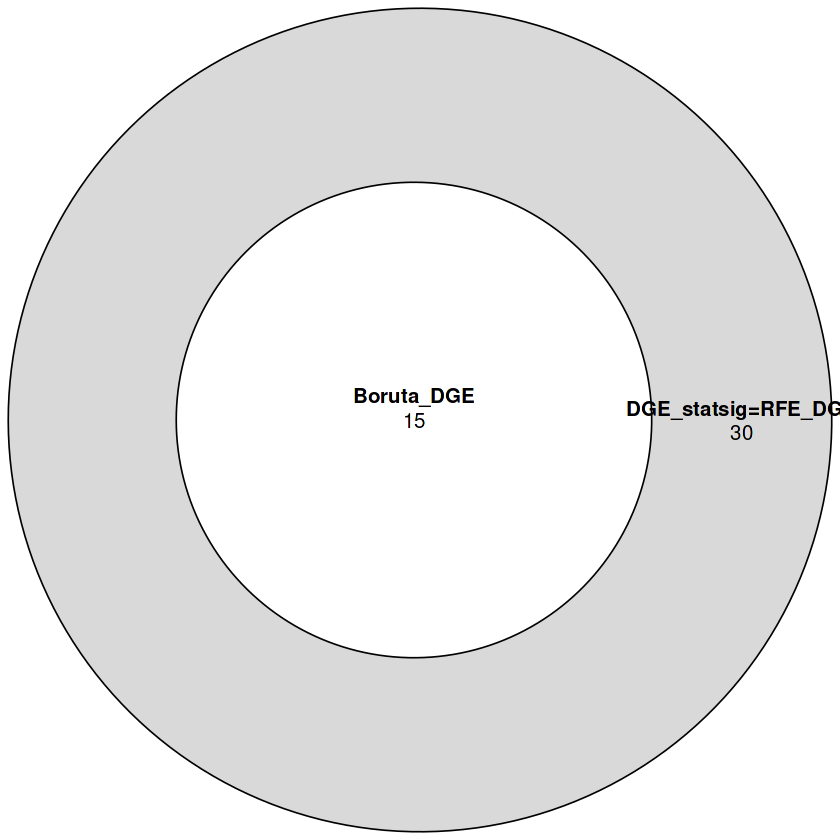

In [ ]:
venn_list <- list(
    Boruta_DGE = as.character(selected_features),
    `DGE_statsig=RFE_DGE` = genelist_rfe_predict
  )

fit1 <- euler(venn_list)
venn <- plot(fit1, quantities = TRUE)
print(venn)

[1] "Processing gene list: Boruta_DGE"
[1] "#####################  RF  #####################"
Confusion Matrix and Statistics

          Reference
Prediction Control ME/CFS
   Control       5      4
   ME/CFS        7      9
                                         
               Accuracy : 0.56           
                 95% CI : (0.3493, 0.756)
    No Information Rate : 0.52           
    P-Value [Acc > NIR] : 0.4220         
                                         
                  Kappa : 0.11           
                                         
 Mcnemar's Test P-Value : 0.5465         
                                         
            Sensitivity : 0.6923         
            Specificity : 0.4167         
         Pos Pred Value : 0.5625         
         Neg Pred Value : 0.5556         
             Prevalence : 0.5200         
         Detection Rate : 0.3600         
   Detection Prevalence : 0.6400         
      Balanced Accuracy : 0.5545         
                   

Setting levels: control = Control, case = ME/CFS

Setting direction: controls < cases



[1] "#####################  SVM  #####################"
Confusion Matrix and Statistics

          Reference
Prediction Control ME/CFS
   Control       6      3
   ME/CFS        6     10
                                          
               Accuracy : 0.64            
                 95% CI : (0.4252, 0.8203)
    No Information Rate : 0.52            
    P-Value [Acc > NIR] : 0.1585          
                                          
                  Kappa : 0.2718          
                                          
 Mcnemar's Test P-Value : 0.5050          
                                          
            Sensitivity : 0.7692          
            Specificity : 0.5000          
         Pos Pred Value : 0.6250          
         Neg Pred Value : 0.6667          
             Prevalence : 0.5200          
         Detection Rate : 0.4000          
   Detection Prevalence : 0.6400          
      Balanced Accuracy : 0.6346          
                                       

Setting levels: control = Control, case = ME/CFS

Setting direction: controls < cases



[1] "#####################  Logistic regression  #####################"

Call:  cv.glmnet(x = as.matrix(X_train_norm[, genelist]), y = as.vector(unlist(Y_train)),      family = "binomial") 

Measure: Binomial Deviance 

     Lambda Index Measure      SE Nonzero
min 0.01620    27  0.8879 0.13711      12
1se 0.04509    16  1.0091 0.07902      11


Setting levels: control = 0, case = 1

Setting direction: controls > cases



[1] "#####################  ROC AUC  #####################"
[1] "Processing gene list: DGE_statsig=RFE_DGE"
[1] "#####################  RF  #####################"
Confusion Matrix and Statistics

          Reference
Prediction Control ME/CFS
   Control       5      2
   ME/CFS        7     11
                                          
               Accuracy : 0.64            
                 95% CI : (0.4252, 0.8203)
    No Information Rate : 0.52            
    P-Value [Acc > NIR] : 0.1585          
                                          
                  Kappa : 0.2671          
                                          
 Mcnemar's Test P-Value : 0.1824          
                                          
            Sensitivity : 0.8462          
            Specificity : 0.4167          
         Pos Pred Value : 0.6111          
         Neg Pred Value : 0.7143          
             Prevalence : 0.5200          
         Detection Rate : 0.4400          
   Detection Preva

Setting levels: control = Control, case = ME/CFS

Setting direction: controls < cases



[1] "#####################  SVM  #####################"
Confusion Matrix and Statistics

          Reference
Prediction Control ME/CFS
   Control       5      4
   ME/CFS        7      9
                                         
               Accuracy : 0.56           
                 95% CI : (0.3493, 0.756)
    No Information Rate : 0.52           
    P-Value [Acc > NIR] : 0.4220         
                                         
                  Kappa : 0.11           
                                         
 Mcnemar's Test P-Value : 0.5465         
                                         
            Sensitivity : 0.6923         
            Specificity : 0.4167         
         Pos Pred Value : 0.5625         
         Neg Pred Value : 0.5556         
             Prevalence : 0.5200         
         Detection Rate : 0.3600         
   Detection Prevalence : 0.6400         
      Balanced Accuracy : 0.5545         
                                         
       'Positiv

Setting levels: control = Control, case = ME/CFS

Setting direction: controls < cases



[1] "#####################  Logistic regression  #####################"

Call:  cv.glmnet(x = as.matrix(X_train_norm[, genelist]), y = as.vector(unlist(Y_train)),      family = "binomial") 

Measure: Binomial Deviance 

     Lambda Index Measure      SE Nonzero
min 0.01952    25  0.8976 0.16517      17
1se 0.05431    14  1.0489 0.09941      14


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "#####################  ROC AUC  #####################"


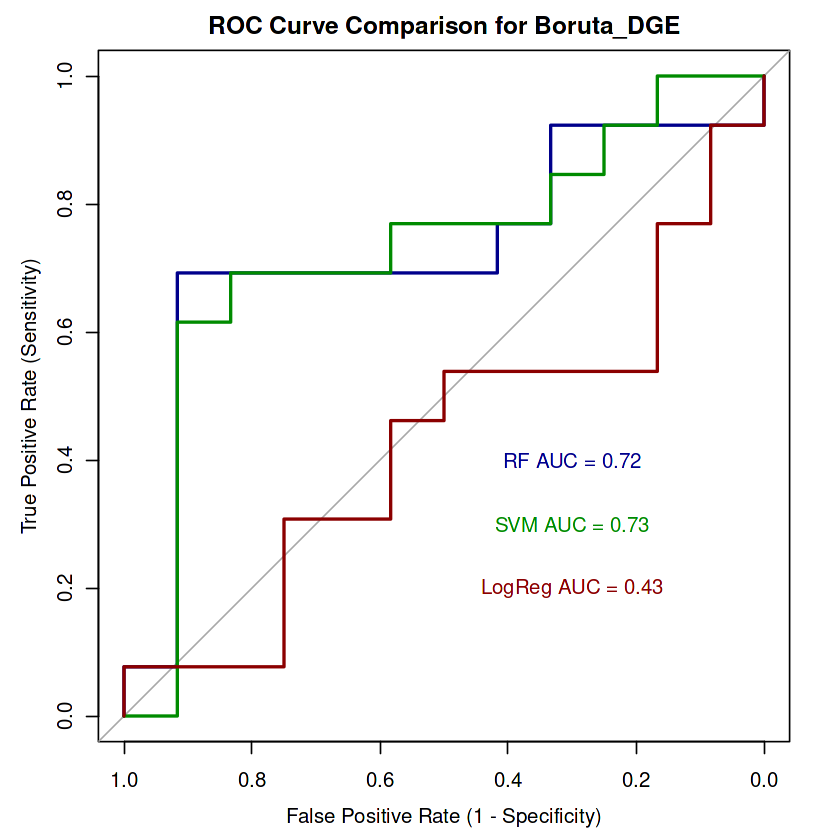

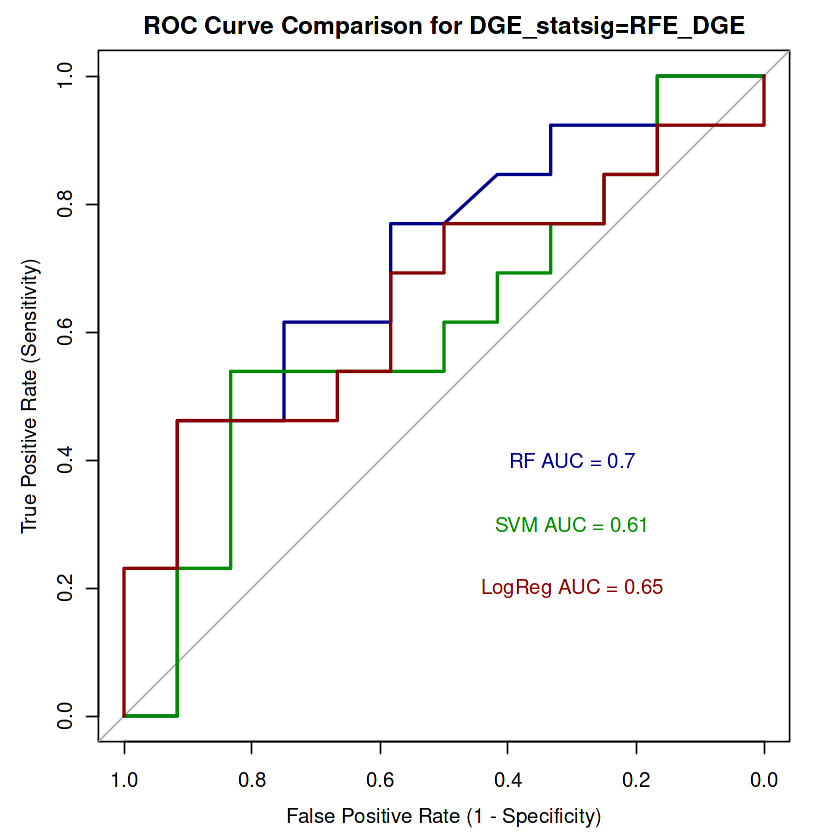

In [ ]:
### Fitting and testing binomial classification models

set.seed(123)

genelists <- venn_list

for (genelist_name in names(genelists)) {

    print(paste("Processing gene list:", genelist_name))
    genelist <- genelists[[genelist_name]]

    print("#####################  RF  #####################")

    # Random forest
    rf_model <- randomForest(
      x = X_train_norm[, genelist],
      y = Y_train_as_factor,
      ntree = 1501,
      importance = TRUE,
      classwt = class_weights_fact,
      mtry = floor(sqrt(length(genelist)))
    )
    pred_rf <- predict(rf_model, X_test_norm[, genelist])
    confusion_rf <- confusionMatrix(pred_rf, Y_test_as_factor, positive = "ME/CFS")         ##### !!!
    print(confusion_rf)

    feature_importance_rf <- as.data.frame(importance(rf_model))
    feature_importance_rf$Feature <- rownames(feature_importance_rf)
    qsave(feature_importance_rf, paste0(genelist_name,"_feature_importance_rf.qs"))

    pred_rf_prob <- predict(rf_model, X_test_norm[, genelist], type = "prob")
    positive_class_index <- 2                                                      ################### !!!
    pred_prob_positive_class <- pred_rf_prob[, positive_class_index]
    roc_rf <- roc(Y_test_as_factor, pred_prob_positive_class) #Y_test must be a factor
    qsave(roc_rf, paste0(genelist_name,"_roc_rf.qs"))

    print("#####################  SVM  #####################")

    svm_tuned <- tune(svm,
      Y_train_as_factor ~ .,
      data = data.frame(Y_train_as_factor = Y_train_as_factor, X_train_norm[, genelist], check.names = FALSE),
      kernel = "radial",
      type = "C-classification",
      ranges = list(cost = c(0.01, 0.1, 1, 10, 50, 100),
                    gamma = c(1 / length(genelist), 0.001, 0.01, 0.1, 1, 10)),
      class.weights = class_weights_fact,
      tunecontrol = tune.control(cross = 10)
    )
    summary(svm_tuned)
    best_model_svm <- svm_tuned$best.model

    pred_svm <- predict(best_model_svm, X_test_norm[, genelist])
    confusion_svm <- confusionMatrix(pred_svm, Y_test_as_factor, positive = "ME/CFS") ##### !!!!
    print(confusion_svm)

    pred_svm_prob <- predict(best_model_svm, X_test_norm[, genelist], decision.values = TRUE)
    pred_prob_svm <- attributes(pred_svm_prob)$decision.values
    roc_svm <- roc(Y_test_as_factor, as.numeric(pred_prob_svm))
    qsave(roc_svm, paste0(genelist_name,"_roc_svm.qs"))


    print("#####################  Logistic regression  #####################")

    cvfit <- cv.glmnet(as.matrix(X_train_norm[, genelist]), as.vector(unlist(Y_train)), family = "binomial") #, type.measure = "auc", keep = TRUE)
    # plot(cvfit)
    print(cvfit)

    coef_at_min <- coef(cvfit, s = "lambda.min")
    nonzero_coef_1 <- extract.coef(cvfit)
    genelist_nonzero_coef_1 <- rownames(nonzero_coef_1)[-1]

    head(nonzero_coef_1)
    qsave(nonzero_coef_1, paste0(genelist_name,"_nonzero_coef_logreg.qs"))

    prediction_test <- predict(cvfit, newx = as.matrix(X_test_norm[, genelist]), family = "binomial", s = "lambda.min", type='response')
    prediction_test_measures <- assess.glmnet(cvfit, newx = as.matrix(X_test_norm[, genelist]), newy = as.vector(unlist(Y_test)), family = "binomial", s = "lambda.min")
    prediction_test_measures

    roc_logreg <- roc(as.vector(unlist(Y_test)), c(prediction_test)) # swapped arguments
    qsave(roc_logreg, paste0(genelist_name,"_roc_logreg.qs"))

    print("#####################  ROC AUC  #####################")

    plot(roc_rf, col = "blue4", print.auc = FALSE,
         xlab = "False Positive Rate (1 - Specificity)",
         ylab = "True Positive Rate (Sensitivity)",
         main = paste0("ROC Curve Comparison for ", genelist_name))
    rf_auc_text <- paste("RF AUC =", round(auc(roc_rf), 2))
    text(x = 0.3, y = 0.4, labels = rf_auc_text, col = "blue4")

    plot(roc_svm, col = "green4", print.auc = FALSE, add = TRUE)
    svm_auc_text <- paste("SVM AUC =", round(auc(roc_svm), 2))
    text(x = 0.3, y = 0.3, labels = svm_auc_text, col = "green4")

    plot(roc_logreg, col = "red4", print.auc = FALSE, add = TRUE)
    logreg_auc_text <- paste("LogReg AUC =", round(auc(roc_logreg), 2))
    text(x = 0.3, y = 0.2, labels = logreg_auc_text, col = "red4")

}

## CFS_1

In [ ]:
### Uploading statistically significant DGE analysis results
### Uploading train and test expression (X) and phenotype data (Y)
### Converting disease condition study to vector with levels

dge_res <- qread("/kaggle/input/dge-wgcna-res/DGE_CFS_1_res_annot.qs")

DGE_genes_manf_CFS_1 <- dge_res[dge_res$gene_name != '' &
                               dge_res$pvalue < 0.001 &
                               dge_res$padj < 0.5, ]$gene_name
DGE_gid_manf_CFS_1 <- dge_res[dge_res$gene_name != '' &
                               dge_res$pvalue < 0.001 &
                               dge_res$padj < 0.5, ]$gene_id
df_train <- qread("/kaggle/input/dge-wgcna-res/gse_train_CFS_1.qs")
df_test <- qread("/kaggle/input/dge-wgcna-res/gse_test_CFS_1.qs")

X_train <- as.data.frame(t((assays(df_train)[['counts']])[DGE_gid_manf_CFS_1, ]))
X_test <- as.data.frame(t((assays(df_test)[['counts']])[DGE_gid_manf_CFS_1, ]))

pd_train <- colData(df_train)[, c("disease state:ch1")]
pd_train <- dummy_cols(pd_train, remove_selected_columns=TRUE)
Y_train <- pd_train$`.data_CFS_1`

pd_test <- colData(df_test)[, c("disease state:ch1")]
pd_test <- dummy_cols(pd_test, remove_selected_columns=TRUE)
Y_test <- pd_test$`.data_CFS_1`

Y_train_as_factor <- as.factor(colData(df_train)[, c("disease state:ch1")])
Y_test_as_factor <- as.factor(colData(df_test)[, c("disease state:ch1")])
Y_train_as_factor <- relevel(Y_train_as_factor, ref = "healthy control")
Y_test_as_factor <- relevel(Y_test_as_factor, ref = "healthy control")

In [ ]:
# Adding individuals' sex as a variable
sex_info_train <- ifelse(colData(df_train)[, "Sex:ch1"] == "female", 1, 0)
sex_info_test <- ifelse(colData(df_test)[, "Sex:ch1"] == "female", 1, 0)

In [ ]:
### Calculating class weights to account imbalances

class_counts <- table(Y_train)
total_samples <- sum(class_counts)
num_classes <- length(class_counts)
class_weights <- total_samples / (num_classes * class_counts)

class_counts <- table(Y_train_as_factor)
total_samples <- sum(class_counts)
num_classes <- length(class_counts)
class_weights_fact <- total_samples / (num_classes * class_counts)

In [ ]:
### Train data log standartisation
### Applying mean and SD calculated for train data on test data

X_train_norm <- log(X_train + 1)
mean_values <- colMeans(X_train_norm)
std_values <- apply(X_train_norm, 2, sd)
X_train_norm <- scale(X_train_norm, center = mean_values, scale = std_values)
X_train_norm <- as.data.frame(X_train_norm)

X_test_norm <- log(X_test + 1)
X_test_norm <- scale(X_test_norm, center = mean_values, scale = std_values)
X_test_norm <- as.data.frame(X_test_norm)

# Adding sex onfo on normalised data
X_train_norm$sex <- sex_info_train
X_test_norm$sex <- sex_info_test

In [ ]:
set.seed(123)

GIDs <- list(DGE_statsig = DGE_gid_manf_CFS_1_wsex)
for (genelist_name in names(GIDs)) {
    print(paste("Processing gene list:", genelist_name))

    GID <- GIDs[[genelist_name]]

    X_train_norm_1 <- X_train_norm %>% dplyr::select(all_of(GID))

    # RFE (Recursive Feature Elimination)
    control <- rfeControl(functions = rfFuncs,
                          method = "repeatedcv",
                          number = 10,
                          repeats = 3)
    rfe_results <- rfe(
      x = X_train_norm_1,
      y = Y_train_as_factor,
      sizes = seq(5, min(55, ncol(X_train_norm_1)), by = 5),
      rfeControl = control
    )

    print(rfe_results)
    qsave(rfe_results, file = paste0("RFE_res_", genelist_name, ".qs"))
    genelist_rfe_predict <- predictors(rfe_results)
    length(genelist_rfe_predict)
    qsave(genelist_rfe_predict, file = paste0("RFE_", genelist_name, ".qs"))

    # Boruta

    boruta_data <- data.frame(Y_train_as_factor = Y_train_as_factor, X_train_norm_1, check.names = FALSE)
    names(boruta_data) <- make.names(names(boruta_data))
    boruta_formula <- as.formula("Y_train_as_factor ~ .")

    boruta_results <- Boruta(
      formula = boruta_formula,
      data = boruta_data,
      doTrace = 2
    )
    boruta_final <- TentativeRoughFix(boruta_results)
    print(boruta_final)
    selected_features <- getSelectedAttributes(boruta_final, withTentative = FALSE)

    selected_features <- lapply(selected_features, function(x) str_remove(x, "^X"))
    qsave(selected_features, file = paste0("Boruta_", genelist_name, ".qs"))
}

[1] "Processing gene list: DGE_statsig"

Recursive feature selection

Outer resampling method: Cross-Validated (10 fold, repeated 3 times) 

Resampling performance over subset size:

 Variables Accuracy  Kappa AccuracySD KappaSD Selected
         5   0.6700 0.3331     0.1901  0.3818         
        10   0.7517 0.4941     0.1643  0.3363         
        15   0.7422 0.4775     0.1793  0.3632         
        20   0.7367 0.4720     0.1956  0.3896         
        25   0.7639 0.5233     0.1811  0.3617        *

The top 5 variables (out of 25):
   ENSG00000124780, ENSG00000274110, ENSG00000006282, ENSG00000110455, ENSG00000275730



 1. run of importance source...

 2. run of importance source...

 3. run of importance source...

 4. run of importance source...

 5. run of importance source...

 6. run of importance source...

 7. run of importance source...

 8. run of importance source...

 9. run of importance source...

 10. run of importance source...

 11. run of importance source...

 12. run of importance source...

After 12 iterations, +0.37 secs: 

 rejected 19 attributes: ENSG00000053254, ENSG00000063180, ENSG00000075790, ENSG00000117399, ENSG00000118492 and 14 more;

 still have 6 attributes left.


 13. run of importance source...

 14. run of importance source...

 15. run of importance source...

 16. run of importance source...

 17. run of importance source...

 18. run of importance source...

 19. run of importance source...

After 19 iterations, +0.55 secs: 

 confirmed 1 attribute: ENSG00000124780;

 still have 5 attributes left.


 20. run of importance source...

 21. run of importance sourc

Boruta performed 98 iterations in 2.428514 secs.
 6 attributes confirmed important: ENSG00000006282, ENSG00000055955,
ENSG00000110455, ENSG00000124780, ENSG00000274110 and 1 more;
 19 attributes confirmed unimportant: ENSG00000053254, ENSG00000063180,
ENSG00000075790, ENSG00000117399, ENSG00000118492 and 14 more;


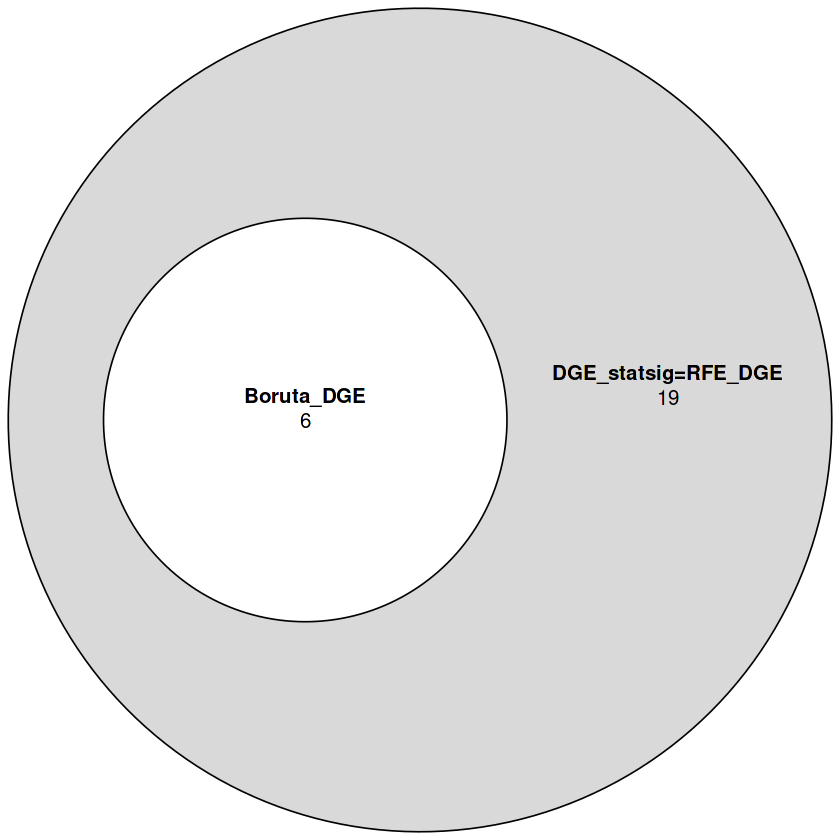

In [ ]:
venn_list <- list(
    Boruta_DGE = as.character(selected_features),
    `DGE_statsig=RFE_DGE` = genelist_rfe_predict
  )

fit1 <- euler(venn_list)
venn <- plot(fit1, quantities = TRUE)
print(venn)

[1] "Processing gene list: Boruta_DGE"
[1] "#####################  RF  #####################"
Confusion Matrix and Statistics

                 Reference
Prediction        healthy control CFS_1
  healthy control               5     4
  CFS_1                         2     3
                                          
               Accuracy : 0.5714          
                 95% CI : (0.2886, 0.8234)
    No Information Rate : 0.5             
    P-Value [Acc > NIR] : 0.3953          
                                          
                  Kappa : 0.1429          
                                          
 Mcnemar's Test P-Value : 0.6831          
                                          
            Sensitivity : 0.4286          
            Specificity : 0.7143          
         Pos Pred Value : 0.6000          
         Neg Pred Value : 0.5556          
             Prevalence : 0.5000          
         Detection Rate : 0.2143          
   Detection Prevalence : 0.3571      

Setting levels: control = healthy control, case = CFS_1

Setting direction: controls < cases



[1] "#####################  SVM  #####################"
Confusion Matrix and Statistics

                 Reference
Prediction        healthy control CFS_1
  healthy control               4     3
  CFS_1                         3     4
                                          
               Accuracy : 0.5714          
                 95% CI : (0.2886, 0.8234)
    No Information Rate : 0.5             
    P-Value [Acc > NIR] : 0.3953          
                                          
                  Kappa : 0.1429          
                                          
 Mcnemar's Test P-Value : 1.0000          
                                          
            Sensitivity : 0.5714          
            Specificity : 0.5714          
         Pos Pred Value : 0.5714          
         Neg Pred Value : 0.5714          
             Prevalence : 0.5000          
         Detection Rate : 0.2857          
   Detection Prevalence : 0.5000          
      Balanced Accuracy : 0.5714 

Setting levels: control = healthy control, case = CFS_1

Setting direction: controls > cases



[1] "#####################  Logistic regression  #####################"

Call:  cv.glmnet(x = as.matrix(X_train_norm[, genelist]), y = as.vector(unlist(Y_train)),      family = "binomial") 

Measure: Binomial Deviance 

     Lambda Index Measure     SE Nonzero
min 0.03532    23  0.9614 0.1300       6
1se 0.10786    11  1.0807 0.0558       5


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "#####################  ROC AUC  #####################"
[1] "Processing gene list: DGE_statsig=RFE_DGE"
[1] "#####################  RF  #####################"
Confusion Matrix and Statistics

                 Reference
Prediction        healthy control CFS_1
  healthy control               5     3
  CFS_1                         2     4
                                          
               Accuracy : 0.6429          
                 95% CI : (0.3514, 0.8724)
    No Information Rate : 0.5             
    P-Value [Acc > NIR] : 0.212           
                                          
                  Kappa : 0.2857          
                                          
 Mcnemar's Test P-Value : 1.000           
                                          
            Sensitivity : 0.5714          
            Specificity : 0.7143          
         Pos Pred Value : 0.6667          
         Neg Pred Value : 0.6250          
             Prevalence : 0.5000          
         Det

Setting levels: control = healthy control, case = CFS_1

Setting direction: controls < cases



[1] "#####################  SVM  #####################"
Confusion Matrix and Statistics

                 Reference
Prediction        healthy control CFS_1
  healthy control               3     2
  CFS_1                         4     5
                                          
               Accuracy : 0.5714          
                 95% CI : (0.2886, 0.8234)
    No Information Rate : 0.5             
    P-Value [Acc > NIR] : 0.3953          
                                          
                  Kappa : 0.1429          
                                          
 Mcnemar's Test P-Value : 0.6831          
                                          
            Sensitivity : 0.7143          
            Specificity : 0.4286          
         Pos Pred Value : 0.5556          
         Neg Pred Value : 0.6000          
             Prevalence : 0.5000          
         Detection Rate : 0.3571          
   Detection Prevalence : 0.6429          
      Balanced Accuracy : 0.5714 

Setting levels: control = healthy control, case = CFS_1

Setting direction: controls > cases



[1] "#####################  Logistic regression  #####################"

Call:  cv.glmnet(x = as.matrix(X_train_norm[, genelist]), y = as.vector(unlist(Y_train)),      family = "binomial") 

Measure: Binomial Deviance 

     Lambda Index Measure     SE Nonzero
min 0.01269    34  0.7917 0.1476      14
1se 0.03532    23  0.9226 0.1110       9


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "#####################  ROC AUC  #####################"


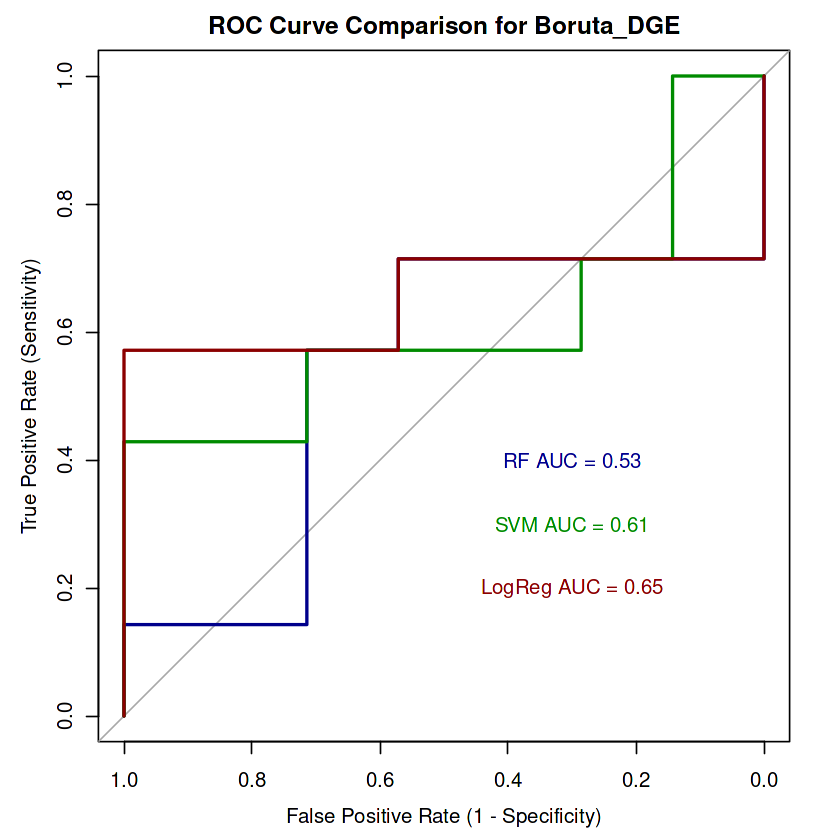

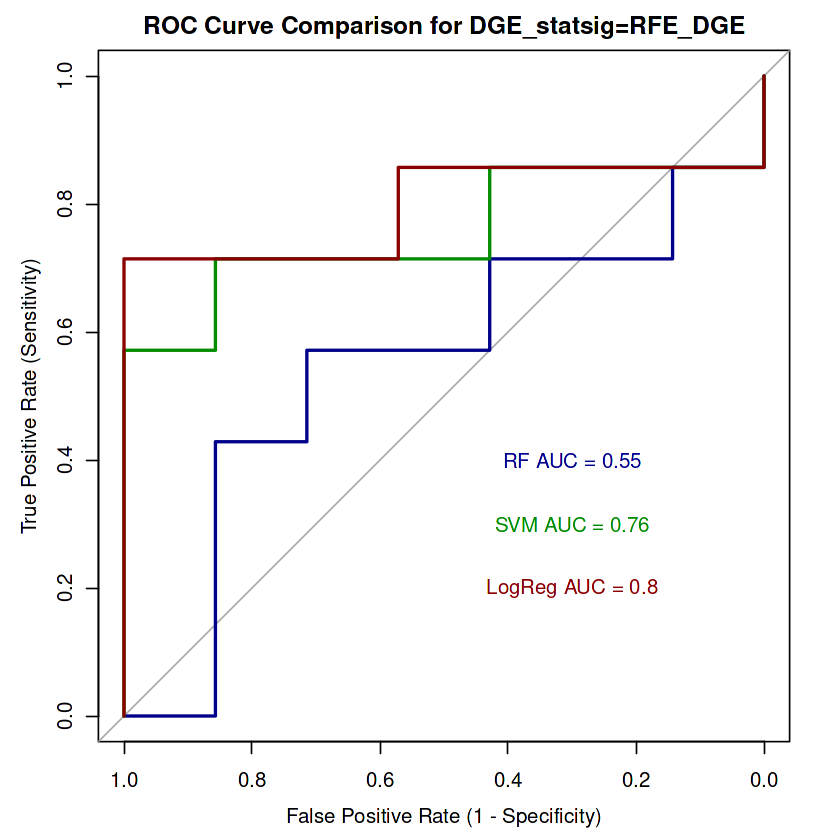

In [ ]:
set.seed(123)

genelists <- venn_list

for (genelist_name in names(genelists)) {
    print(paste("Processing gene list:", genelist_name))
    genelist <- genelists[[genelist_name]]

    print("#####################  RF  #####################")

    # Random forest
    rf_model <- randomForest(
      x = X_train_norm[, genelist],
      y = Y_train_as_factor,
      ntree = 1501,
      importance = TRUE,
      classwt = class_weights_fact,
      mtry = floor(sqrt(length(genelist)))
    )
    pred_rf <- predict(rf_model, X_test_norm[, genelist])

    confusion_rf <- confusionMatrix(pred_rf, Y_test_as_factor, positive = "CFS_1") ##### !!!
    print(confusion_rf)

    feature_importance_rf <- as.data.frame(importance(rf_model))
    feature_importance_rf$Feature <- rownames(feature_importance_rf)
    qsave(feature_importance_rf, paste0(genelist_name,"_feature_importance_rf.qs"))

    pred_rf_prob <- predict(rf_model, X_test_norm[, genelist], type = "prob")
    positive_class_index <- 2                                                      ################### !!!
    pred_prob_positive_class <- pred_rf_prob[, positive_class_index]
    roc_rf <- roc(Y_test_as_factor, pred_prob_positive_class)
    qsave(roc_rf, paste0(genelist_name,"_roc_rf.qs"))

    print("#####################  SVM  #####################")

    svm_tuned <- tune(svm,
      Y_train_as_factor ~ .,
      data = data.frame(Y_train_as_factor = Y_train_as_factor, X_train_norm[, genelist], check.names = FALSE),
      kernel = "radial",
      type = "C-classification",
      ranges = list(cost = c(0.01, 0.1, 1, 10, 50, 100),
                    gamma = c(1 / length(genelist), 0.001, 0.01, 0.1, 1, 10)),
      class.weights = class_weights_fact,
      tunecontrol = tune.control(cross = 10)
    )
    # plot(svm_tuned)
    summary(svm_tuned)
    best_model_svm <- svm_tuned$best.model
    pred_svm <- predict(best_model_svm, X_test_norm[, genelist])
    confusion_svm <- confusionMatrix(pred_svm, Y_test_as_factor, positive = "CFS_1") ##### !!!!
    print(confusion_svm)

    pred_svm_prob <- predict(best_model_svm, X_test_norm[, genelist], decision.values = TRUE)
    pred_prob_svm <- attributes(pred_svm_prob)$decision.values
    roc_svm <- roc(Y_test_as_factor, as.numeric(pred_prob_svm))
    qsave(roc_svm, paste0(genelist_name,"_roc_svm.qs"))


    print("#####################  Logistic regression  #####################")

    cvfit <- cv.glmnet(as.matrix(X_train_norm[, genelist]), as.vector(unlist(Y_train)), family = "binomial") #, type.measure = "auc", keep = TRUE)
    # plot(cvfit)
    print(cvfit)

    coef_at_min <- coef(cvfit, s = "lambda.min")
    nonzero_coef_1 <- extract.coef(cvfit)
    genelist_nonzero_coef_1 <- rownames(nonzero_coef_1)[-1]

    head(nonzero_coef_1)
    qsave(nonzero_coef_1, paste0(genelist_name,"_nonzero_coef_logreg.qs"))

    prediction_test <- predict(cvfit, newx = as.matrix(X_test_norm[, genelist]), family = "binomial", s = "lambda.min", type='response')
    prediction_test_measures <- assess.glmnet(cvfit, newx = as.matrix(X_test_norm[, genelist]), newy = as.vector(unlist(Y_test)), family = "binomial", s = "lambda.min")
    prediction_test_measures


    roc_logreg <- roc(as.vector(unlist(Y_test)), c(prediction_test))
    qsave(roc_logreg, paste0(genelist_name,"_roc_logreg.qs"))

    print("#####################  ROC AUC  #####################")

    plot(roc_rf, col = "blue4", print.auc = FALSE,
         xlab = "False Positive Rate (1 - Specificity)",
         ylab = "True Positive Rate (Sensitivity)",
         main = paste0("ROC Curve Comparison for ", genelist_name))
    rf_auc_text <- paste("RF AUC =", round(auc(roc_rf), 2))
    text(x = 0.3, y = 0.4, labels = rf_auc_text, col = "blue4")

    plot(roc_svm, col = "green4", print.auc = FALSE, add = TRUE)
    svm_auc_text <- paste("SVM AUC =", round(auc(roc_svm), 2))
    text(x = 0.3, y = 0.3, labels = svm_auc_text, col = "green4")

    plot(roc_logreg, col = "red4", print.auc = FALSE, add = TRUE)
    logreg_auc_text <- paste("LogReg AUC =", round(auc(roc_logreg), 2))
    text(x = 0.3, y = 0.2, labels = logreg_auc_text, col = "red4")
}

## CFS_2

In [ ]:
### Uploading statistically significant DGE analysis results
### Uploading statistically significant WGCNA results

dge_res <- qread("/kaggle/input/dge-wgcna-res/DGE_CFS_2_res_annot.qs")

dge_res_filtered <- dge_res %>%
   filter(
           gene_name != "" &
           !is.na(gene_name) &
           gene_name != "NA" &
           pvalue < 0.001 &  # Soft threashold
           padj < 0.5
   )

dge_res_filtered <- dge_res_filtered %>%
  group_by(gene_name) %>%
  filter(pvalue == min(pvalue)) %>%
  ungroup()

DGE_genes_CFS_2 <- dge_res_filtered$gene_name
DGE_gid_CFS_2 <- dge_res_filtered$gene_id

wgcna_res <- qread("/kaggle/input/dge-wgcna-res/WGSNA_CFS_2_res_annot.qs")

wgcna_res_filtered  <- wgcna_res %>%
  group_by(gene_name) %>%
  filter(`p.GS.disease_state_PI-ME/CFS` == min(`p.GS.disease_state_PI-ME/CFS`)) %>%
  ungroup()

wgcna_res_filtered  <- wgcna_res_filtered %>%
   filter(
           gene_name != "" &
           !is.na(gene_name) &
           gene_name != "NA" &
           `p.GS.disease_state_PI-ME/CFS` < 0.05
   )

WGCNA_gid_CFS_2 <- wgcna_res_filtered$gene_id
WGCNA_genes_CFS_2 <- wgcna_res_filtered$gene_name

combined_gid <- unique(c(WGCNA_gid_CFS_2, DGE_gid_CFS_2))

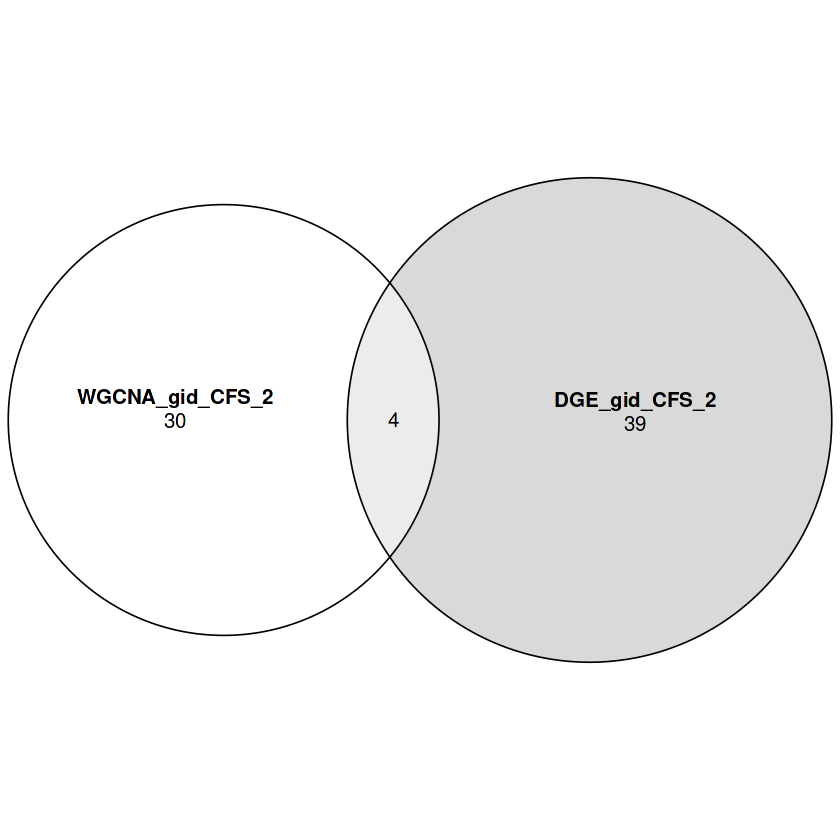

In [ ]:
venn_list <- list(
    WGCNA_gid_CFS_2 = WGCNA_gid_CFS_2,
    DGE_gid_CFS_2 = DGE_gid_CFS_2
  )

fit1 <- euler(venn_list)
venn <- plot(fit1, quantities = TRUE)
print(venn)

In [ ]:
### Uploading train and test expression (X) and phenotype data (Y)
### Converting disease condition study to vector with levels

df_train <- qread("/kaggle/input/dge-wgcna-res/gse_train_CFS_2.qs")
df_test <- qread("/kaggle/input/dge-wgcna-res/gse_test_CFS_2.qs")

X_train <- as.data.frame(t((assays(df_train)[['counts']])[combined_gid, ]))
X_test <- as.data.frame(t((assays(df_test)[['counts']])[combined_gid, ]))

pd_train <- colData(df_train)[, c("disease_state")]
pd_train <- dummy_cols(pd_train, remove_selected_columns=TRUE)
Y_train <- pd_train$`.data_PI-ME/CFS`

pd_test <- colData(df_test)[, c("disease_state")]
pd_test <- dummy_cols(pd_test, remove_selected_columns=TRUE)
Y_test <- pd_test$`.data_PI-ME/CFS`


Y_train_as_factor <- as.factor(colData(df_train)[, c("disease_state")])
Y_test_as_factor <- as.factor(colData(df_test)[, c("disease_state")])

Y_train_as_factor <- relevel(Y_train_as_factor, ref = "HV")
Y_test_as_factor <- relevel(Y_test_as_factor, ref = "HV")

### Adding sex info
sex_info_train <- ifelse(colData(df_train)[, "Sex:ch1"] == "Female", 1, 0)
sex_info_test <- ifelse(colData(df_test)[, "Sex:ch1"] == "Female", 1, 0)

In [ ]:
class_counts <- table(Y_train)
total_samples <- sum(class_counts)
num_classes <- length(class_counts)
class_weights <- total_samples / (num_classes * class_counts)

class_counts <- table(Y_train_as_factor)
total_samples <- sum(class_counts)
num_classes <- length(class_counts)
class_weights_fact <- total_samples / (num_classes * class_counts)

In [ ]:
### Train data log standartisation
### Applying mean and SD calculated for train data on test data

X_train_norm <- log(X_train + 1)
mean_values <- colMeans(X_train_norm)
std_values <- apply(X_train_norm, 2, sd)
X_train_norm <- scale(X_train_norm, center = mean_values, scale = std_values)
X_train_norm <- as.data.frame(X_train_norm)

X_test_norm <- log(X_test + 1)
X_test_norm <- scale(X_test_norm, center = mean_values, scale = std_values)
X_test_norm <- as.data.frame(X_test_norm)

In [ ]:
# Adding sex info
X_train_norm$sex <- sex_info_train
X_test_norm$sex <- sex_info_test
WGCNA_CFS_2 <- append(WGCNA_gid_CFS_2, "sex")
DGE_CFS_2 <- append(DGE_gid_CFS_2, "sex")

In [ ]:
### Feature filtration using RFE and Boruta

set.seed(123)

GIDs <- list(WGCNA_CFS_2 = WGCNA_CFS_2,
             DGE_CFS_2 = DGE_CFS_2)

for (genelist_name in names(GIDs)) {
    print(paste("Processing gene list:", genelist_name))

    GID <- GIDs[[genelist_name]]

    X_train_norm_1 <- X_train_norm %>% dplyr::select(all_of(GID))

    # RFE (Recursive Feature Elimination)
    control <- rfeControl(functions = rfFuncs,
                          method = "repeatedcv",
                          number = 10,
                          repeats = 3)
    rfe_results <- rfe(
      x = X_train_norm_1,
      y = Y_train_as_factor,
      sizes = seq(5, min(55, ncol(X_train_norm_1)), by = 5),
      rfeControl = control
    )

    print(rfe_results)
    qsave(rfe_results, file = paste0("RFE_res_", genelist_name, ".qs"))
    genelist_rfe_predict <- predictors(rfe_results)
    length(genelist_rfe_predict)
    qsave(genelist_rfe_predict, file = paste0("RFE_", genelist_name, ".qs"))

    # Boruta

    boruta_data <- data.frame(Y_train_as_factor = Y_train_as_factor, X_train_norm_1, check.names = FALSE)
    names(boruta_data) <- make.names(names(boruta_data))
    boruta_formula <- as.formula("Y_train_as_factor ~ .")

    boruta_results <- Boruta(
      formula = boruta_formula,
      data = boruta_data,
      doTrace = 2
    )
    boruta_final <- TentativeRoughFix(boruta_results)
    print(boruta_final)
    selected_features <- getSelectedAttributes(boruta_final, withTentative = FALSE)

    selected_features <- lapply(selected_features, function(x) str_remove(x, "^X"))
    qsave(selected_features, file = paste0("Boruta_", genelist_name, ".qs"))
}

[1] "Processing gene list: WGCNA_CFS_2"

Recursive feature selection

Outer resampling method: Cross-Validated (10 fold, repeated 3 times) 

Resampling performance over subset size:

 Variables Accuracy  Kappa AccuracySD KappaSD Selected
         5   0.6556 0.3200     0.3417  0.6840         
        10   0.6833 0.3733     0.3256  0.6512         
        15   0.6944 0.3933     0.3307  0.6612         
        20   0.6889 0.3800     0.3326  0.6651         
        25   0.7222 0.4467     0.3371  0.6740        *
        30   0.7222 0.4467     0.3371  0.6740         
        35   0.7056 0.4133     0.3353  0.6704         

The top 5 variables (out of 25):
   ENSG00000197705, ENSG00000189057, ENSG00000282050, ENSG00000242265, ENSG00000144218



 1. run of importance source...

 2. run of importance source...

 3. run of importance source...

 4. run of importance source...

 5. run of importance source...

 6. run of importance source...

 7. run of importance source...

 8. run of importance source...

 9. run of importance source...

 10. run of importance source...

 11. run of importance source...

 12. run of importance source...

After 12 iterations, +0.23 secs: 

 rejected 19 attributes: ENSG00000002587, ENSG00000012124, ENSG00000035720, ENSG00000082293, ENSG00000120278 and 14 more;

 still have 16 attributes left.


 13. run of importance source...

 14. run of importance source...

 15. run of importance source...

 16. run of importance source...

After 16 iterations, +0.3 secs: 

 confirmed 1 attribute: ENSG00000197705;

 still have 15 attributes left.


 17. run of importance source...

 18. run of importance source...

 19. run of importance source...

 20. run of importance source...

After 20 iterations, +0.37 

Boruta performed 99 iterations in 1.565099 secs.
Tentatives roughfixed over the last 99 iterations.
 10 attributes confirmed important: ENSG00000144218, ENSG00000147905,
ENSG00000164649, ENSG00000165209, ENSG00000183960 and 5 more;
 25 attributes confirmed unimportant: ENSG00000002587, ENSG00000012124,
ENSG00000035720, ENSG00000082293, ENSG00000102445 and 20 more;
[1] "Processing gene list: DGE_CFS_2"

Recursive feature selection

Outer resampling method: Cross-Validated (10 fold, repeated 3 times) 

Resampling performance over subset size:

 Variables Accuracy  Kappa AccuracySD KappaSD Selected
         5   0.7667 0.5067     0.2956  0.6097         
        10   0.7889 0.5633     0.2834  0.5840         
        15   0.8500 0.6800     0.2565  0.5346         
        20   0.8500 0.6800     0.2565  0.5346         
        25   0.8333 0.6467     0.2626  0.5450         
        30   0.8556 0.6933     0.2504  0.5219         
        35   0.8556 0.6933     0.2504  0.5219         
        40  

 1. run of importance source...

 2. run of importance source...

 3. run of importance source...

 4. run of importance source...

 5. run of importance source...

 6. run of importance source...

 7. run of importance source...

 8. run of importance source...

 9. run of importance source...

 10. run of importance source...

 11. run of importance source...

 12. run of importance source...

 13. run of importance source...

After 13 iterations, +0.26 secs: 

 confirmed 4 attributes: ENSG00000080166, ENSG00000117519, ENSG00000180543, ENSG00000189057;

 rejected 26 attributes: ENSG00000023330, ENSG00000080007, ENSG00000090659, ENSG00000096155, ENSG00000133800 and 21 more;

 still have 14 attributes left.


 14. run of importance source...

 15. run of importance source...

 16. run of importance source...

 17. run of importance source...

 18. run of importance source...

 19. run of importance source...

 20. run of importance source...

After 20 iterations, +0.37 secs: 

 confirm

Boruta performed 99 iterations in 1.640811 secs.
Tentatives roughfixed over the last 99 iterations.
 13 attributes confirmed important: ENSG00000080166, ENSG00000117519,
ENSG00000123838, ENSG00000136449, ENSG00000143882 and 8 more;
 31 attributes confirmed unimportant: ENSG00000023330, ENSG00000063180,
ENSG00000080007, ENSG00000090659, ENSG00000096155 and 26 more;


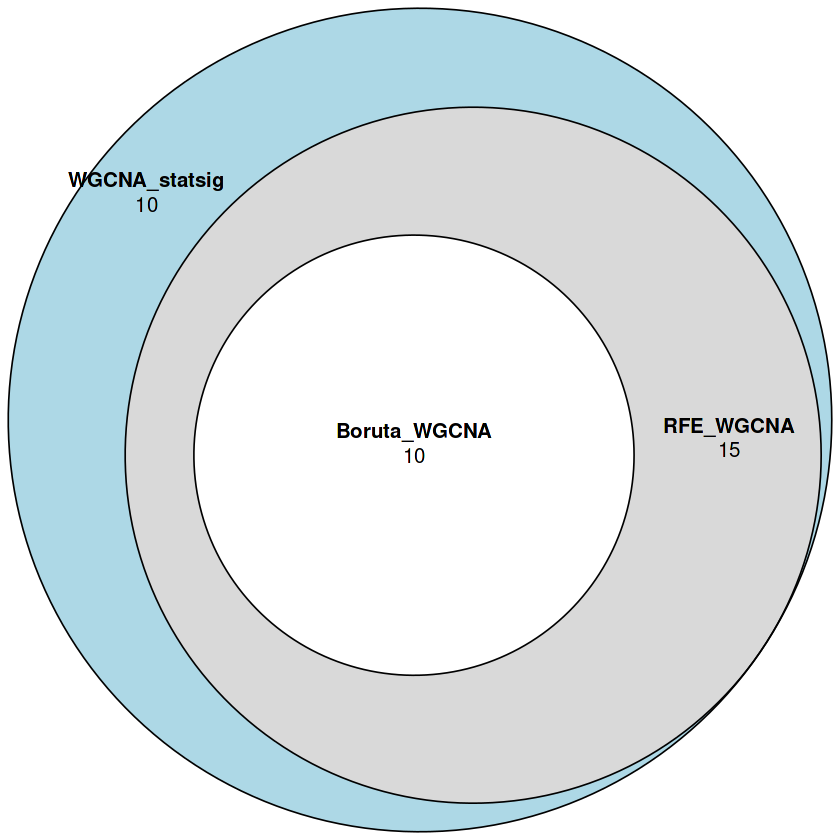

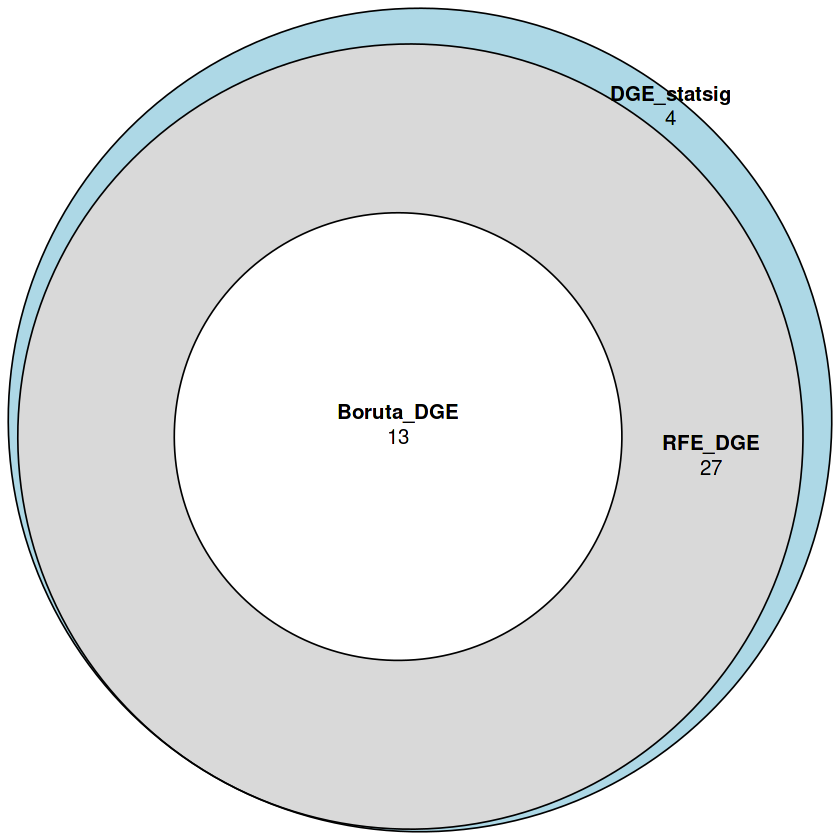

In [ ]:
### Euler diagramm to visualise overlaps within DGE and WGCNA generated genesets

venn_list <- list(
    Boruta_WGCNA = as.character(qread("/kaggle/working/Boruta_WGCNA_CFS_2.qs")),
    RFE_WGCNA = qread("/kaggle/working/RFE_WGCNA_CFS_2.qs"),
    WGCNA_statsig = WGCNA_CFS_2
  )

fit1 <- euler(venn_list)
venn <- plot(fit1, quantities = TRUE)
print(venn)

venn_list <- list(
    Boruta_DGE = as.character(qread("/kaggle/working/Boruta_DGE_CFS_2.qs")),
    RFE_DGE = qread("/kaggle/working/RFE_DGE_CFS_2.qs"),
    DGE_statsig = DGE_CFS_2
  )

fit1 <- euler(venn_list)
venn <- plot(fit1, quantities = TRUE)
print(venn)

[1] "Processing gene list: Boruta_WGCNA"
[1] "#####################  RF  #####################"
Confusion Matrix and Statistics

           Reference
Prediction  HV PI-ME/CFS
  HV         3         0
  PI-ME/CFS  0         2
                                     
               Accuracy : 1          
                 95% CI : (0.4782, 1)
    No Information Rate : 0.6        
    P-Value [Acc > NIR] : 0.07776    
                                     
                  Kappa : 1          
                                     
 Mcnemar's Test P-Value : NA         
                                     
            Sensitivity : 1.0        
            Specificity : 1.0        
         Pos Pred Value : 1.0        
         Neg Pred Value : 1.0        
             Prevalence : 0.4        
         Detection Rate : 0.4        
   Detection Prevalence : 0.4        
      Balanced Accuracy : 1.0        
                                     
       'Positive' Class : PI-ME/CFS  
               

Setting levels: control = HV, case = PI-ME/CFS

Setting direction: controls < cases



[1] "#####################  SVM  #####################"
Confusion Matrix and Statistics

           Reference
Prediction  HV PI-ME/CFS
  HV         3         0
  PI-ME/CFS  0         2
                                     
               Accuracy : 1          
                 95% CI : (0.4782, 1)
    No Information Rate : 0.6        
    P-Value [Acc > NIR] : 0.07776    
                                     
                  Kappa : 1          
                                     
 Mcnemar's Test P-Value : NA         
                                     
            Sensitivity : 1.0        
            Specificity : 1.0        
         Pos Pred Value : 1.0        
         Neg Pred Value : 1.0        
             Prevalence : 0.4        
         Detection Rate : 0.4        
   Detection Prevalence : 0.4        
      Balanced Accuracy : 1.0        
                                     
       'Positive' Class : PI-ME/CFS  
                                     


Setting levels: control = HV, case = PI-ME/CFS

Setting direction: controls > cases



[1] "#####################  Logistic regression  #####################"


Warning message:
“Option grouped=FALSE enforced in cv.glmnet, since < 3 observations per fold”



Call:  cv.glmnet(x = as.matrix(X_train_norm[, genelist]), y = as.vector(unlist(Y_train)),      family = "binomial") 

Measure: Binomial Deviance 

    Lambda Index Measure     SE Nonzero
min 0.0636    19  0.9161 0.2066       2
1se 0.1770     8  1.0864 0.1050       2


Warning message:
“Too few (< 10) observations per fold for type.measure='auc' in cv.lognet; changed to type.measure='deviance'. Alternatively, use smaller value for nfolds”
Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "Processing gene list: Boruta_DGE"
[1] "#####################  RF  #####################"
Confusion Matrix and Statistics

           Reference
Prediction  HV PI-ME/CFS
  HV         2         0
  PI-ME/CFS  1         2
                                          
               Accuracy : 0.8             
                 95% CI : (0.2836, 0.9949)
    No Information Rate : 0.6             
    P-Value [Acc > NIR] : 0.337           
                                          
                  Kappa : 0.6154          
                                          
 Mcnemar's Test P-Value : 1.000           
                                          
            Sensitivity : 1.0000          
            Specificity : 0.6667          
         Pos Pred Value : 0.6667          
         Neg Pred Value : 1.0000          
             Prevalence : 0.4000          
         Detection Rate : 0.4000          
   Detection Prevalence : 0.6000          
      Balanced Accuracy : 0.8333          
   

Setting levels: control = HV, case = PI-ME/CFS

Setting direction: controls < cases



[1] "#####################  SVM  #####################"
Confusion Matrix and Statistics

           Reference
Prediction  HV PI-ME/CFS
  HV         2         1
  PI-ME/CFS  1         1
                                          
               Accuracy : 0.6             
                 95% CI : (0.1466, 0.9473)
    No Information Rate : 0.6             
    P-Value [Acc > NIR] : 0.6826          
                                          
                  Kappa : 0.1667          
                                          
 Mcnemar's Test P-Value : 1.0000          
                                          
            Sensitivity : 0.5000          
            Specificity : 0.6667          
         Pos Pred Value : 0.5000          
         Neg Pred Value : 0.6667          
             Prevalence : 0.4000          
         Detection Rate : 0.2000          
   Detection Prevalence : 0.4000          
      Balanced Accuracy : 0.5833          
                                         

Setting levels: control = HV, case = PI-ME/CFS

Setting direction: controls > cases



[1] "#####################  Logistic regression  #####################"


Warning message:
“Option grouped=FALSE enforced in cv.glmnet, since < 3 observations per fold”



Call:  cv.glmnet(x = as.matrix(X_train_norm[, genelist]), y = as.vector(unlist(Y_train)),      family = "binomial") 

Measure: Binomial Deviance 

     Lambda Index Measure     SE Nonzero
min 0.08408    16   1.025 0.2326       5
1se 0.23395     5   1.249 0.1010       3


Warning message:
“Too few (< 10) observations per fold for type.measure='auc' in cv.lognet; changed to type.measure='deviance'. Alternatively, use smaller value for nfolds”
Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "Processing gene list: RFE_WGCNA"
[1] "#####################  RF  #####################"
Confusion Matrix and Statistics

           Reference
Prediction  HV PI-ME/CFS
  HV         3         0
  PI-ME/CFS  0         2
                                     
               Accuracy : 1          
                 95% CI : (0.4782, 1)
    No Information Rate : 0.6        
    P-Value [Acc > NIR] : 0.07776    
                                     
                  Kappa : 1          
                                     
 Mcnemar's Test P-Value : NA         
                                     
            Sensitivity : 1.0        
            Specificity : 1.0        
         Pos Pred Value : 1.0        
         Neg Pred Value : 1.0        
             Prevalence : 0.4        
         Detection Rate : 0.4        
   Detection Prevalence : 0.4        
      Balanced Accuracy : 1.0        
                                     
       'Positive' Class : PI-ME/CFS  
                  

Setting levels: control = HV, case = PI-ME/CFS

Setting direction: controls < cases



[1] "#####################  SVM  #####################"
Confusion Matrix and Statistics

           Reference
Prediction  HV PI-ME/CFS
  HV         2         0
  PI-ME/CFS  1         2
                                          
               Accuracy : 0.8             
                 95% CI : (0.2836, 0.9949)
    No Information Rate : 0.6             
    P-Value [Acc > NIR] : 0.337           
                                          
                  Kappa : 0.6154          
                                          
 Mcnemar's Test P-Value : 1.000           
                                          
            Sensitivity : 1.0000          
            Specificity : 0.6667          
         Pos Pred Value : 0.6667          
         Neg Pred Value : 1.0000          
             Prevalence : 0.4000          
         Detection Rate : 0.4000          
   Detection Prevalence : 0.6000          
      Balanced Accuracy : 0.8333          
                                         

Setting levels: control = HV, case = PI-ME/CFS

Setting direction: controls > cases



[1] "#####################  Logistic regression  #####################"


Warning message:
“Option grouped=FALSE enforced in cv.glmnet, since < 3 observations per fold”



Call:  cv.glmnet(x = as.matrix(X_train_norm[, genelist]), y = as.vector(unlist(Y_train)),      family = "binomial") 

Measure: Binomial Deviance 

    Lambda Index Measure      SE Nonzero
min 0.1061    26   1.087 0.19337       2
1se 0.2567     7   1.274 0.07703       1


Warning message:
“Too few (< 10) observations per fold for type.measure='auc' in cv.lognet; changed to type.measure='deviance'. Alternatively, use smaller value for nfolds”
Setting levels: control = 0, case = 1

Setting direction: controls < cases



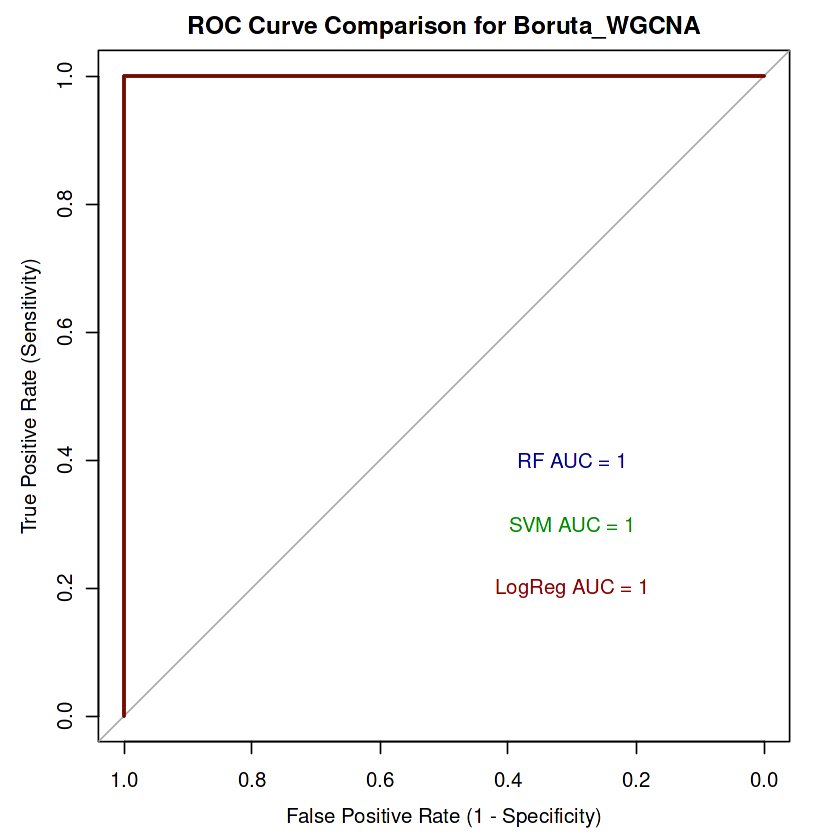

[1] "Processing gene list: RFE_DGE"
[1] "#####################  RF  #####################"
Confusion Matrix and Statistics

           Reference
Prediction  HV PI-ME/CFS
  HV         2         0
  PI-ME/CFS  1         2
                                          
               Accuracy : 0.8             
                 95% CI : (0.2836, 0.9949)
    No Information Rate : 0.6             
    P-Value [Acc > NIR] : 0.337           
                                          
                  Kappa : 0.6154          
                                          
 Mcnemar's Test P-Value : 1.000           
                                          
            Sensitivity : 1.0000          
            Specificity : 0.6667          
         Pos Pred Value : 0.6667          
         Neg Pred Value : 1.0000          
             Prevalence : 0.4000          
         Detection Rate : 0.4000          
   Detection Prevalence : 0.6000          
      Balanced Accuracy : 0.8333          
      

Setting levels: control = HV, case = PI-ME/CFS

Setting direction: controls < cases



[1] "#####################  SVM  #####################"
Confusion Matrix and Statistics

           Reference
Prediction  HV PI-ME/CFS
  HV         1         0
  PI-ME/CFS  2         2
                                          
               Accuracy : 0.6             
                 95% CI : (0.1466, 0.9473)
    No Information Rate : 0.6             
    P-Value [Acc > NIR] : 0.6826          
                                          
                  Kappa : 0.2857          
                                          
 Mcnemar's Test P-Value : 0.4795          
                                          
            Sensitivity : 1.0000          
            Specificity : 0.3333          
         Pos Pred Value : 0.5000          
         Neg Pred Value : 1.0000          
             Prevalence : 0.4000          
         Detection Rate : 0.4000          
   Detection Prevalence : 0.8000          
      Balanced Accuracy : 0.6667          
                                         

Setting levels: control = HV, case = PI-ME/CFS

Setting direction: controls > cases



[1] "#####################  Logistic regression  #####################"


Warning message in lognet(xd, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”
Warning message:
“Option grouped=FALSE enforced in cv.glmnet, since < 3 observations per fold”



Call:  cv.glmnet(x = as.matrix(X_train_norm[, genelist]), y = as.vector(unlist(Y_train)),      family = "binomial") 

Measure: Binomial Deviance 

     Lambda Index Measure     SE Nonzero
min 0.03022    53   1.099 0.3365      12
1se 0.30926     3   1.423 0.0717       1


Warning message:
“Too few (< 10) observations per fold for type.measure='auc' in cv.lognet; changed to type.measure='deviance'. Alternatively, use smaller value for nfolds”
Setting levels: control = 0, case = 1

Setting direction: controls < cases



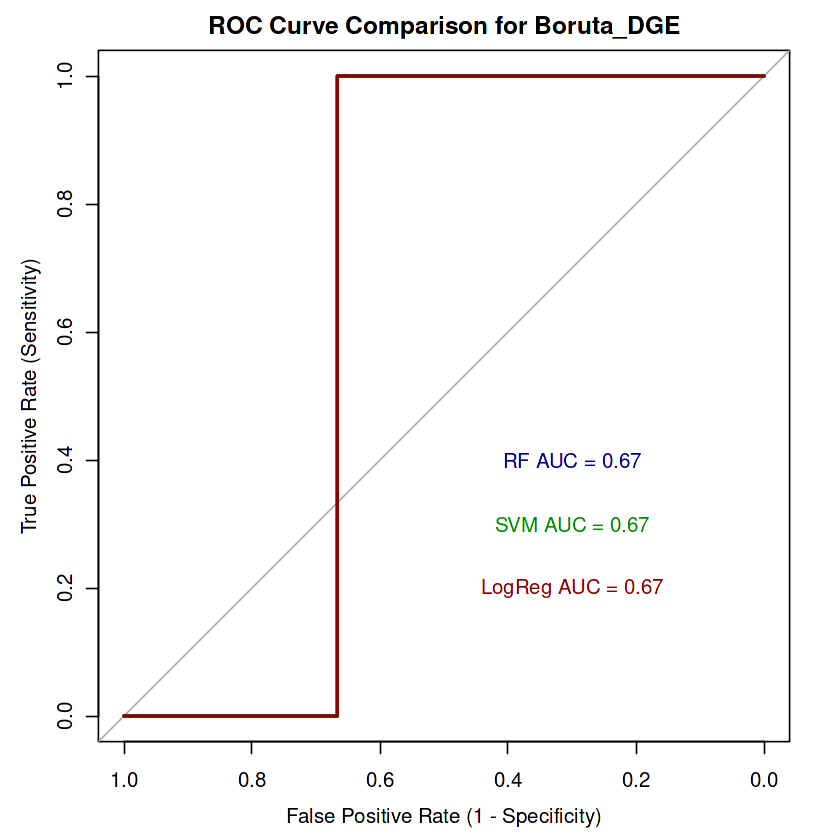

[1] "Processing gene list: DGE_statsig"
[1] "#####################  RF  #####################"
Confusion Matrix and Statistics

           Reference
Prediction  HV PI-ME/CFS
  HV         2         0
  PI-ME/CFS  1         2
                                          
               Accuracy : 0.8             
                 95% CI : (0.2836, 0.9949)
    No Information Rate : 0.6             
    P-Value [Acc > NIR] : 0.337           
                                          
                  Kappa : 0.6154          
                                          
 Mcnemar's Test P-Value : 1.000           
                                          
            Sensitivity : 1.0000          
            Specificity : 0.6667          
         Pos Pred Value : 0.6667          
         Neg Pred Value : 1.0000          
             Prevalence : 0.4000          
         Detection Rate : 0.4000          
   Detection Prevalence : 0.6000          
      Balanced Accuracy : 0.8333          
  

Setting levels: control = HV, case = PI-ME/CFS

Setting direction: controls < cases



[1] "#####################  SVM  #####################"
Confusion Matrix and Statistics

           Reference
Prediction  HV PI-ME/CFS
  HV         1         1
  PI-ME/CFS  2         1
                                          
               Accuracy : 0.4             
                 95% CI : (0.0527, 0.8534)
    No Information Rate : 0.6             
    P-Value [Acc > NIR] : 0.913           
                                          
                  Kappa : -0.1538         
                                          
 Mcnemar's Test P-Value : 1.000           
                                          
            Sensitivity : 0.5000          
            Specificity : 0.3333          
         Pos Pred Value : 0.3333          
         Neg Pred Value : 0.5000          
             Prevalence : 0.4000          
         Detection Rate : 0.2000          
   Detection Prevalence : 0.6000          
      Balanced Accuracy : 0.4167          
                                         

Setting levels: control = HV, case = PI-ME/CFS

Setting direction: controls > cases



[1] "#####################  Logistic regression  #####################"


Warning message:
“Option grouped=FALSE enforced in cv.glmnet, since < 3 observations per fold”



Call:  cv.glmnet(x = as.matrix(X_train_norm[, genelist]), y = as.vector(unlist(Y_train)),      family = "binomial") 

Measure: Binomial Deviance 

     Lambda Index Measure     SE Nonzero
min 0.03639    49  0.9598 0.2492      13
1se 0.12779    22  1.1963 0.1556       9


Warning message:
“Too few (< 10) observations per fold for type.measure='auc' in cv.lognet; changed to type.measure='deviance'. Alternatively, use smaller value for nfolds”
Setting levels: control = 0, case = 1

Setting direction: controls < cases



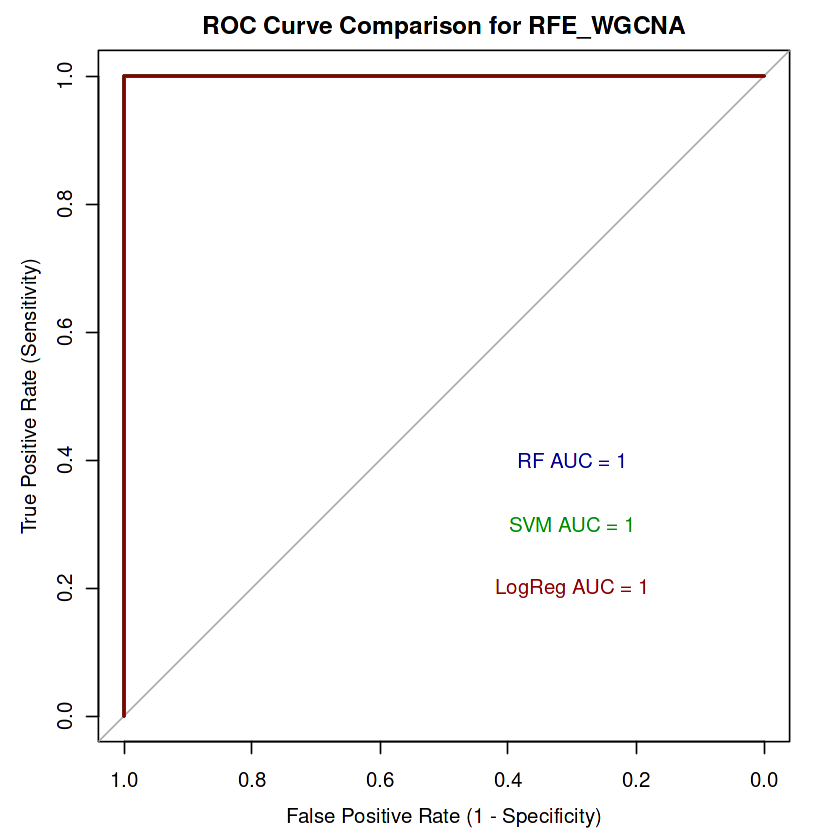

[1] "Processing gene list: WGCNA_statsig"
[1] "#####################  RF  #####################"
Confusion Matrix and Statistics

           Reference
Prediction  HV PI-ME/CFS
  HV         3         0
  PI-ME/CFS  0         2
                                     
               Accuracy : 1          
                 95% CI : (0.4782, 1)
    No Information Rate : 0.6        
    P-Value [Acc > NIR] : 0.07776    
                                     
                  Kappa : 1          
                                     
 Mcnemar's Test P-Value : NA         
                                     
            Sensitivity : 1.0        
            Specificity : 1.0        
         Pos Pred Value : 1.0        
         Neg Pred Value : 1.0        
             Prevalence : 0.4        
         Detection Rate : 0.4        
   Detection Prevalence : 0.4        
      Balanced Accuracy : 1.0        
                                     
       'Positive' Class : PI-ME/CFS  
              

Setting levels: control = HV, case = PI-ME/CFS

Setting direction: controls < cases



[1] "#####################  SVM  #####################"
Confusion Matrix and Statistics

           Reference
Prediction  HV PI-ME/CFS
  HV         3         0
  PI-ME/CFS  0         2
                                     
               Accuracy : 1          
                 95% CI : (0.4782, 1)
    No Information Rate : 0.6        
    P-Value [Acc > NIR] : 0.07776    
                                     
                  Kappa : 1          
                                     
 Mcnemar's Test P-Value : NA         
                                     
            Sensitivity : 1.0        
            Specificity : 1.0        
         Pos Pred Value : 1.0        
         Neg Pred Value : 1.0        
             Prevalence : 0.4        
         Detection Rate : 0.4        
   Detection Prevalence : 0.4        
      Balanced Accuracy : 1.0        
                                     
       'Positive' Class : PI-ME/CFS  
                                     


Setting levels: control = HV, case = PI-ME/CFS

Setting direction: controls > cases



[1] "#####################  Logistic regression  #####################"


Warning message:
“Option grouped=FALSE enforced in cv.glmnet, since < 3 observations per fold”



Call:  cv.glmnet(x = as.matrix(X_train_norm[, genelist]), y = as.vector(unlist(Y_train)),      family = "binomial") 

Measure: Binomial Deviance 

     Lambda Index Measure      SE Nonzero
min 0.09667    28   1.068 0.18775       2
1se 0.21316    11   1.239 0.09358       2


Warning message:
“Too few (< 10) observations per fold for type.measure='auc' in cv.lognet; changed to type.measure='deviance'. Alternatively, use smaller value for nfolds”
Setting levels: control = 0, case = 1

Setting direction: controls < cases



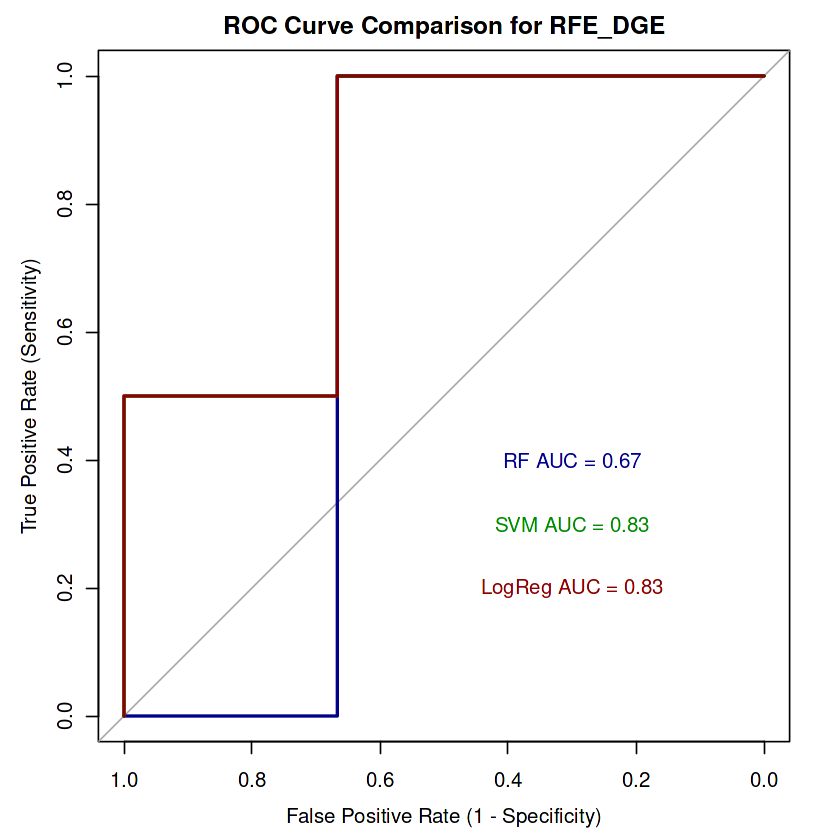

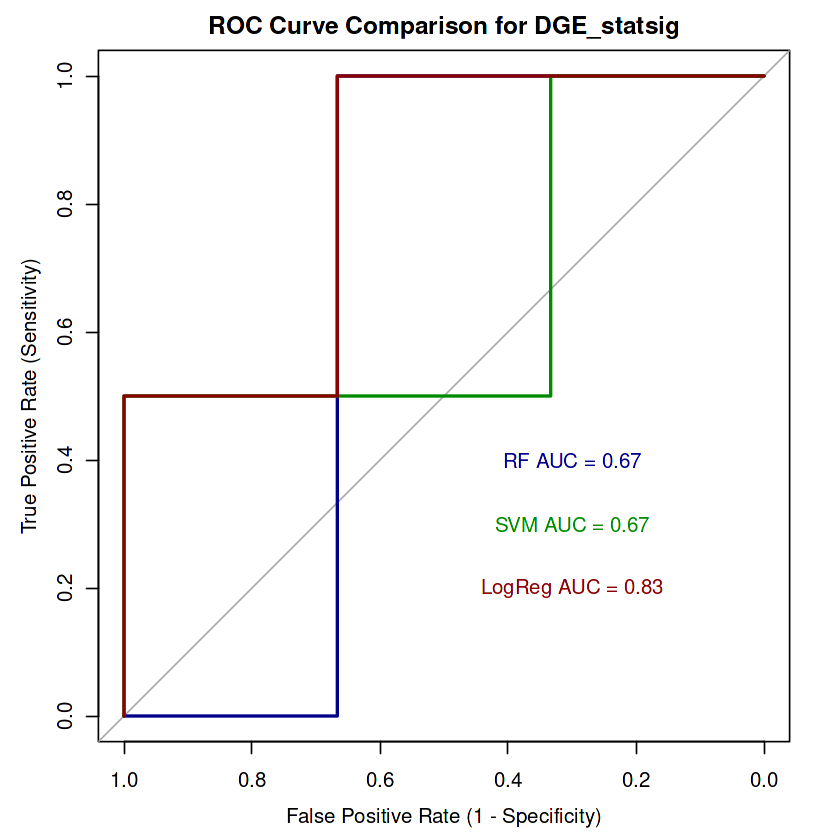

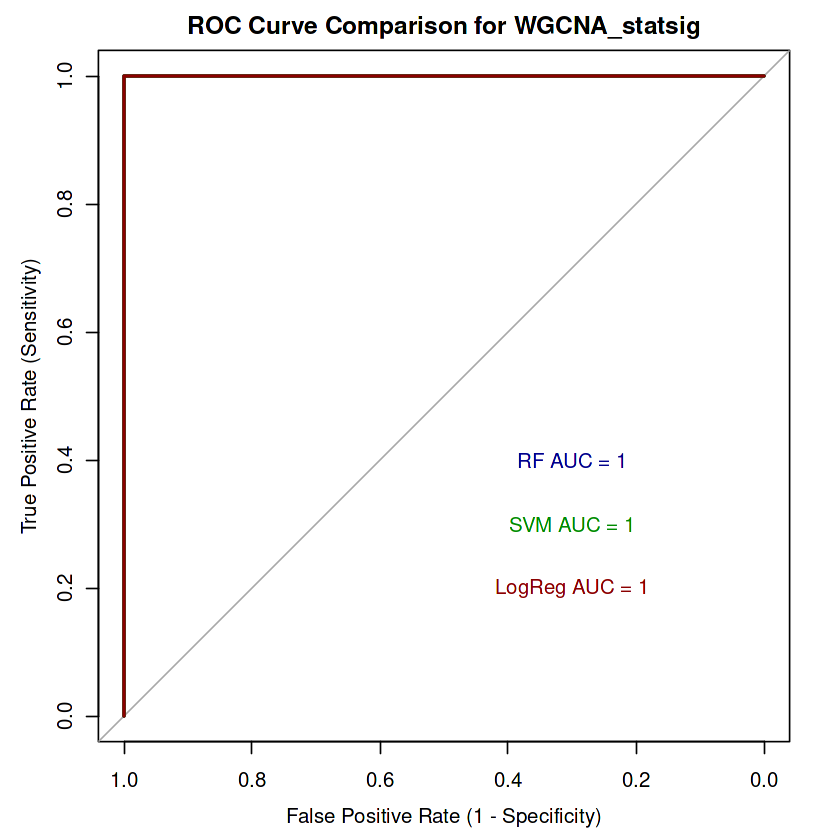

In [ ]:
### Fitting and testing binomial classification models

set.seed(123)

genelists <- list(
    Boruta_WGCNA = as.character(qread("/kaggle/working/Boruta_WGCNA_CFS_2.qs")),
    Boruta_DGE = as.character(qread("/kaggle/working/Boruta_DGE_CFS_2.qs")),
    RFE_WGCNA = qread("/kaggle/working/RFE_WGCNA_CFS_2.qs"),
    RFE_DGE = qread("/kaggle/working/RFE_DGE_CFS_2.qs"),
    DGE_statsig = DGE_CFS_2,
    WGCNA_statsig = WGCNA_CFS_2
  )

for (genelist_name in names(genelists)) {
    print(paste("Processing gene list:", genelist_name))
    genelist <- genelists[[genelist_name]]

    print("#####################  RF  #####################")

    # Random forest
    rf_model <- randomForest(
      x = X_train_norm[, genelist],
      y = Y_train_as_factor,
      ntree = 1501,
      importance = TRUE,
      classwt = class_weights_fact,
      mtry = floor(sqrt(length(genelist)))
    )

    pred_rf <- predict(rf_model, X_test_norm[, genelist])
    confusion_rf <- confusionMatrix(pred_rf, Y_test_as_factor, positive = "PI-ME/CFS") ##### !!!
    print(confusion_rf)

    feature_importance_rf <- as.data.frame(importance(rf_model))
    feature_importance_rf$Feature <- rownames(feature_importance_rf)
    qsave(feature_importance_rf, paste0(genelist_name,"_feature_importance_rf.qs"))

    pred_rf_prob <- predict(rf_model, X_test_norm[, genelist], type = "prob")
    positive_class_index <- 2                                                      ################### !!!
    pred_prob_positive_class <- pred_rf_prob[, positive_class_index]
    roc_rf <- roc(Y_test_as_factor, pred_prob_positive_class) #Y_test must be a factor
    qsave(roc_rf, paste0(genelist_name,"_roc_rf.qs"))

    print("#####################  SVM  #####################")

    svm_tuned <- tune(svm,
      Y_train_as_factor ~ .,
      data = data.frame(Y_train_as_factor = Y_train_as_factor, X_train_norm[, genelist], check.names = FALSE),
      kernel = "radial",
      type = "C-classification",
      ranges = list(cost = c(0.01, 0.1, 1, 10, 50, 100),
                    gamma = c(1 / length(genelist), 0.001, 0.01, 0.1, 1, 10)),
      class.weights = class_weights_fact,
      tunecontrol = tune.control(cross = 10)
    )
    # plot(svm_tuned)
    summary(svm_tuned)
    best_model_svm <- svm_tuned$best.model

    pred_svm <- predict(best_model_svm, X_test_norm[, genelist])
    confusion_svm <- confusionMatrix(pred_svm, Y_test_as_factor, positive = "PI-ME/CFS") ##### !!!!
    print(confusion_svm)

    pred_svm_prob <- predict(best_model_svm, X_test_norm[, genelist], decision.values = TRUE)
    pred_prob_svm <- attributes(pred_svm_prob)$decision.values
    roc_svm <- roc(Y_test_as_factor, as.numeric(pred_prob_svm))
    qsave(roc_svm, paste0(genelist_name,"_roc_svm.qs"))


    print("#####################  Logistic regression  #####################")

    cvfit <- cv.glmnet(as.matrix(X_train_norm[, genelist]), as.vector(unlist(Y_train)), family = "binomial")
    # plot(cvfit)
    print(cvfit)

    coef_at_min <- coef(cvfit, s = "lambda.min")
    nonzero_coef_1 <- extract.coef(cvfit)
    genelist_nonzero_coef_1 <- rownames(nonzero_coef_1)[-1]

    head(nonzero_coef_1)
    qsave(nonzero_coef_1, paste0(genelist_name,"_nonzero_coef_logreg.qs"))

    prediction_test <- predict(cvfit, newx = as.matrix(X_test_norm[, genelist]), family = "binomial", s = "lambda.min", type='response')
    prediction_test_measures <- assess.glmnet(cvfit, newx = as.matrix(X_test_norm[, genelist]), newy = as.vector(unlist(Y_test)), family = "binomial", s = "lambda.min")
    prediction_test_measures

    roc_logreg <- roc(as.vector(unlist(Y_test)), c(prediction_test))
    qsave(roc_logreg, paste0(genelist_name,"_roc_logreg.qs"))

    # print("#####################  ROC AUC  #####################")

    plot(roc_rf, col = "blue4", print.auc = FALSE,
         xlab = "False Positive Rate (1 - Specificity)",
         ylab = "True Positive Rate (Sensitivity)",
         main = paste0("ROC Curve Comparison for ", genelist_name))
    rf_auc_text <- paste("RF AUC =", round(auc(roc_rf), 2))
    text(x = 0.3, y = 0.4, labels = rf_auc_text, col = "blue4")

    plot(roc_svm, col = "green4", print.auc = FALSE, add = TRUE)
    svm_auc_text <- paste("SVM AUC =", round(auc(roc_svm), 2))
    text(x = 0.3, y = 0.3, labels = svm_auc_text, col = "green4")

    plot(roc_logreg, col = "red4", print.auc = FALSE, add = TRUE)
    logreg_auc_text <- paste("LogReg AUC =", round(auc(roc_logreg), 2))
    text(x = 0.3, y = 0.2, labels = logreg_auc_text, col = "red4")
}

## CFS_3

In [ ]:
### Uploading statistically significant DGE analysis results

dge_res <- qread("/kaggle/input/dge-wgcna-res/DGE_CFS_3_res_annot.qs")

dge_res_filtered <- dge_res %>%
   filter(
           gene_name != "" &
           !is.na(gene_name) &
           gene_name != "NA" &
           padj < 0.05
   )

top_50_genes <- dge_res_filtered %>%
   arrange(desc(abs(log2FoldChange))) %>%  # top 50 genes with highest absoute value of log2FoldChange
   slice_head(n = 50)

dge_res_filtered <- dge_res_filtered %>%
  group_by(gene_name) %>%
  filter(pvalue == min(pvalue)) %>%
  ungroup()

top_50_genes <- top_50_genes %>%
  group_by(gene_name) %>%
  filter(pvalue == min(pvalue)) %>%
  ungroup()


DGE_genes_CFS_3 <- dge_res_filtered$gene_name
DGE_genes_manf_CFS_3 <- top_50_genes$gene_name

DGE_gid_CFS_3 <- dge_res_filtered$gene_id
DGE_gid_manf_CFS_3 <- top_50_genes$gene_id

In [ ]:
### Uploading statistically significant WGCNA results

wgcna_res <- qread("/kaggle/input/dge-wgcna-res/WGSNA_CFS_3_res_annot.qs")

wgcna_res_filtered  <- wgcna_res %>%
  group_by(gene_name) %>%
  filter(`p.GS..data_healthy_control` == min(`p.GS..data_healthy_control`)) %>%
  ungroup()

wgcna_res_filtered  <- wgcna_res_filtered %>%
   filter(
           gene_name != "" &
           !is.na(gene_name) &
           gene_name != "NA" &
           `p.GS..data_healthy_control` < 0.05
   )

WGCNA_gid_CFS_3 <- wgcna_res_filtered$gene_id
WGCNA_genes_CFS_3 <- wgcna_res_filtered$gene_name

combined_gid <- unique(c(WGCNA_gid_CFS_3, DGE_gid_CFS_3))

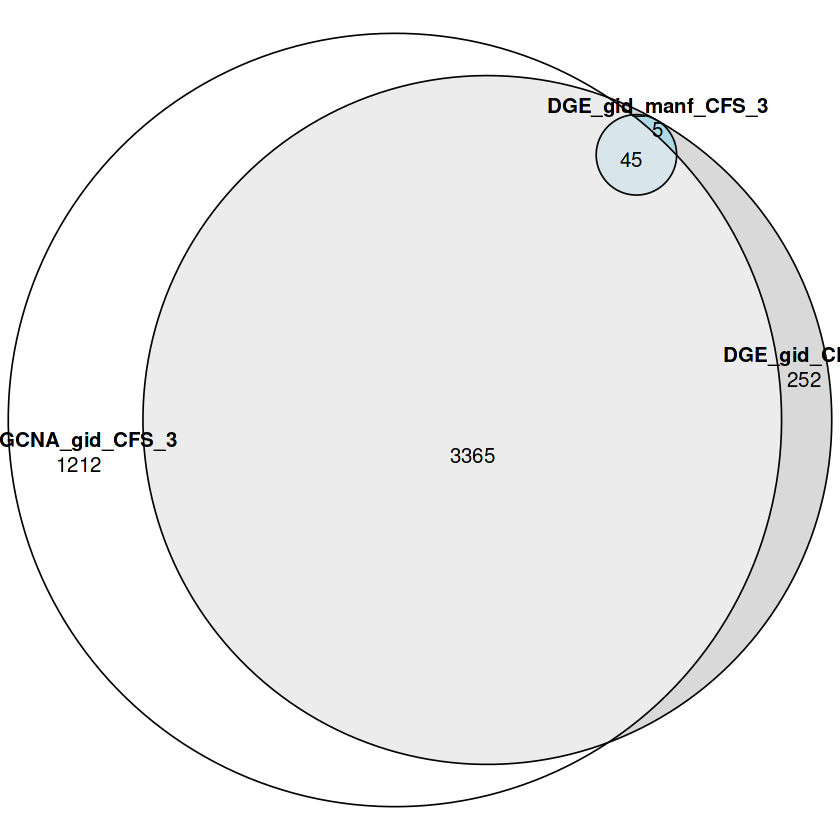

In [ ]:
venn_list <- list(
    WGCNA_gid_CFS_3 = WGCNA_gid_CFS_3,
    DGE_gid_CFS_3 = DGE_gid_CFS_3,
    DGE_gid_manf_CFS_3 = DGE_gid_manf_CFS_3
  )

fit1 <- euler(venn_list)
venn <- plot(fit1, quantities = TRUE)
print(venn)

In [ ]:
### Uploading train and test expression (X) and phenotype data (Y)
### Converting disease condition study to vector with levels

df_train <- qread("/kaggle/input/dge-wgcna-res/gse_train_CFS_3.qs")
df_test <- qread("/kaggle/input/dge-wgcna-res/gse_test_CFS_3.qs")

X_train <- as.data.frame(t((assays(df_train)[['counts']])[combined_gid, ]))
X_test <- as.data.frame(t((assays(df_test)[['counts']])[combined_gid, ]))

pd_train <- colData(df_train)[, c("disease_status")]
pd_train <- dummy_cols(pd_train, remove_selected_columns=TRUE)
Y_train <- pd_train$`.data_post-covid_ME-CFS`

pd_test <- colData(df_test)[, c("disease_status")]
pd_test <- dummy_cols(pd_test, remove_selected_columns=TRUE)
Y_test <- pd_test$`.data_post-covid_ME-CFS`

Y_train_as_factor <- as.factor(colData(df_train)[, c("disease_status")])
Y_test_as_factor <- as.factor(colData(df_test)[, c("disease_status")])

Y_train_as_factor <- relevel(Y_train_as_factor, ref = "healthy_control")
Y_test_as_factor <- relevel(Y_test_as_factor, ref = "healthy_control")

In [ ]:
class_counts <- table(Y_train)
total_samples <- sum(class_counts)
num_classes <- length(class_counts)
class_weights <- total_samples / (num_classes * class_counts)

class_counts <- table(Y_train_as_factor)
total_samples <- sum(class_counts)
num_classes <- length(class_counts)
class_weights_fact <- total_samples / (num_classes * class_counts)

In [ ]:
### Train data log standartisation
### Applying mean and SD calculated for train data on test data

X_train_norm <- log(X_train + 1)
mean_values <- colMeans(X_train_norm)
std_values <- apply(X_train_norm, 2, sd)
X_train_norm <- scale(X_train_norm, center = mean_values, scale = std_values)
X_train_norm <- as.data.frame(X_train_norm)

X_test_norm <- log(X_test + 1)
X_test_norm <- scale(X_test_norm, center = mean_values, scale = std_values)
X_test_norm <- as.data.frame(X_test_norm)

In [ ]:
### Feature filtration using RFE and Boruta

set.seed(123)

GIDs <- list(WGCNA_CFS_3 = WGCNA_gid_CFS_3,
             DGE_CFS_3 = DGE_gid_CFS_3)

for (genelist_name in names(GIDs)) {
    print(paste("Processing gene list:", genelist_name))

    GID <- GIDs[[genelist_name]]

    X_train_norm_1 <- X_train_norm %>% dplyr::select(all_of(GID))

    # RFE (Recursive Feature Elimination)
    control <- rfeControl(functions = rfFuncs,
                          method = "repeatedcv",
                          number = 10,
                          repeats = 3)
    rfe_results <- rfe(
      x = X_train_norm_1,
      y = Y_train_as_factor,
      sizes = seq(5, min(500, ncol(X_train_norm_1)), by = 10),   ######### !!!!!!!!!
      rfeControl = control
    )

    print(rfe_results)
    qsave(rfe_results, file = paste0("RFE_res_", genelist_name, ".qs"))
    genelist_rfe_predict <- predictors(rfe_results)
    length(genelist_rfe_predict)
    qsave(genelist_rfe_predict, file = paste0("RFE_", genelist_name, ".qs"))

    # Boruta

    boruta_data <- data.frame(Y_train_as_factor = Y_train_as_factor, X_train_norm_1, check.names = FALSE)
    names(boruta_data) <- make.names(names(boruta_data))
    boruta_formula <- as.formula("Y_train_as_factor ~ .")
    boruta_results <- Boruta(
      formula = boruta_formula,
      data = boruta_data,
      doTrace = 2
    )
    boruta_final <- TentativeRoughFix(boruta_results)
    print(boruta_final)
    selected_features <- getSelectedAttributes(boruta_final, withTentative = FALSE)

    selected_features <- lapply(selected_features, function(x) str_remove(x, "^X")) # No need to lapply
    qsave(selected_features, file = paste0("Boruta_", genelist_name, ".qs"))
}

[1] "Processing gene list: WGCNA_CFS_3"

Recursive feature selection

Outer resampling method: Cross-Validated (10 fold, repeated 3 times) 

Resampling performance over subset size:

 Variables Accuracy  Kappa AccuracySD KappaSD Selected
         5   0.7056 0.3933     0.3177  0.6480         
        15   0.6972 0.3900     0.2720  0.5467         
        25   0.6917 0.3900     0.3041  0.6065         
        35   0.6917 0.3900     0.3041  0.6065         
        45   0.6806 0.3567     0.2985  0.5992         
        55   0.6917 0.3900     0.3041  0.6065         
        65   0.6917 0.3900     0.3041  0.6065         
        75   0.6917 0.3900     0.3041  0.6065         
        85   0.7083 0.4233     0.3070  0.6118         
        95   0.6917 0.3900     0.3041  0.6065         
       105   0.7083 0.4233     0.2775  0.5525         
       115   0.6917 0.3900     0.3041  0.6065         
       125   0.7083 0.4233     0.2775  0.5525         
       135   0.7250 0.4567     0.2795  0.5563  

 1. run of importance source...

 2. run of importance source...

 3. run of importance source...

 4. run of importance source...

 5. run of importance source...

 6. run of importance source...

 7. run of importance source...

 8. run of importance source...

 9. run of importance source...

 10. run of importance source...

 11. run of importance source...

 12. run of importance source...

 13. run of importance source...

 14. run of importance source...

 15. run of importance source...

 16. run of importance source...

 17. run of importance source...

 18. run of importance source...

 19. run of importance source...

After 19 iterations, +11 secs: 

 rejected 4548 attributes: ENSG00000000419, ENSG00000000457, ENSG00000000938, ENSG00000001629, ENSG00000001631 and 4543 more;

 still have 74 attributes left.


 20. run of importance source...

 21. run of importance source...

 22. run of importance source...

 23. run of importance source...

 24. run of importance source...


Boruta performed 99 iterations in 12.71562 secs.
Tentatives roughfixed over the last 99 iterations.
 38 attributes confirmed important: ENSG00000004399, ENSG00000063169,
ENSG00000073861, ENSG00000089486, ENSG00000091513 and 33 more;
 4584 attributes confirmed unimportant: ENSG00000000419,
ENSG00000000457, ENSG00000000938, ENSG00000001629, ENSG00000001631 and
4579 more;
[1] "Processing gene list: DGE_CFS_3"

Recursive feature selection

Outer resampling method: Cross-Validated (10 fold, repeated 3 times) 

Resampling performance over subset size:

 Variables Accuracy  Kappa AccuracySD KappaSD Selected
         5   0.7111 0.4333     0.2303  0.4420         
        15   0.6778 0.3667     0.2578  0.5006         
        25   0.6806 0.3833     0.2837  0.5615         
        35   0.6917 0.4000     0.2761  0.5414         
        45   0.6917 0.4000     0.2761  0.5414         
        55   0.6861 0.3967     0.2950  0.5720         
        65   0.6806 0.3833     0.2837  0.5615         
       

 1. run of importance source...

 2. run of importance source...

 3. run of importance source...

 4. run of importance source...

 5. run of importance source...

 6. run of importance source...

 7. run of importance source...

 8. run of importance source...

 9. run of importance source...

 10. run of importance source...

 11. run of importance source...

 12. run of importance source...

 13. run of importance source...

 14. run of importance source...

 15. run of importance source...

 16. run of importance source...

 17. run of importance source...

 18. run of importance source...

 19. run of importance source...

After 19 iterations, +8.6 secs: 

 rejected 3537 attributes: ENSG00000000419, ENSG00000000457, ENSG00000001561, ENSG00000001631, ENSG00000002822 and 3532 more;

 still have 130 attributes left.


 20. run of importance source...

 21. run of importance source...

 22. run of importance source...

 23. run of importance source...

 24. run of importance source..

Boruta performed 99 iterations in 10.89293 secs.
Tentatives roughfixed over the last 99 iterations.
 50 attributes confirmed important: ENSG00000004399, ENSG00000005381,
ENSG00000021762, ENSG00000063169, ENSG00000073861 and 45 more;
 3617 attributes confirmed unimportant: ENSG00000000419,
ENSG00000000457, ENSG00000001561, ENSG00000001631, ENSG00000002822 and
3612 more;


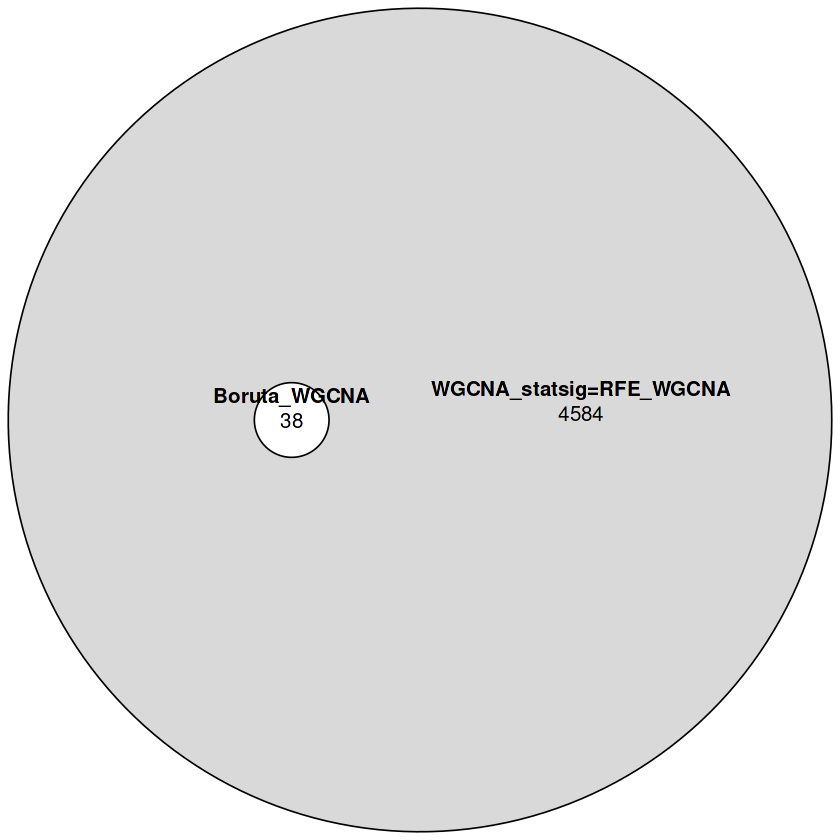

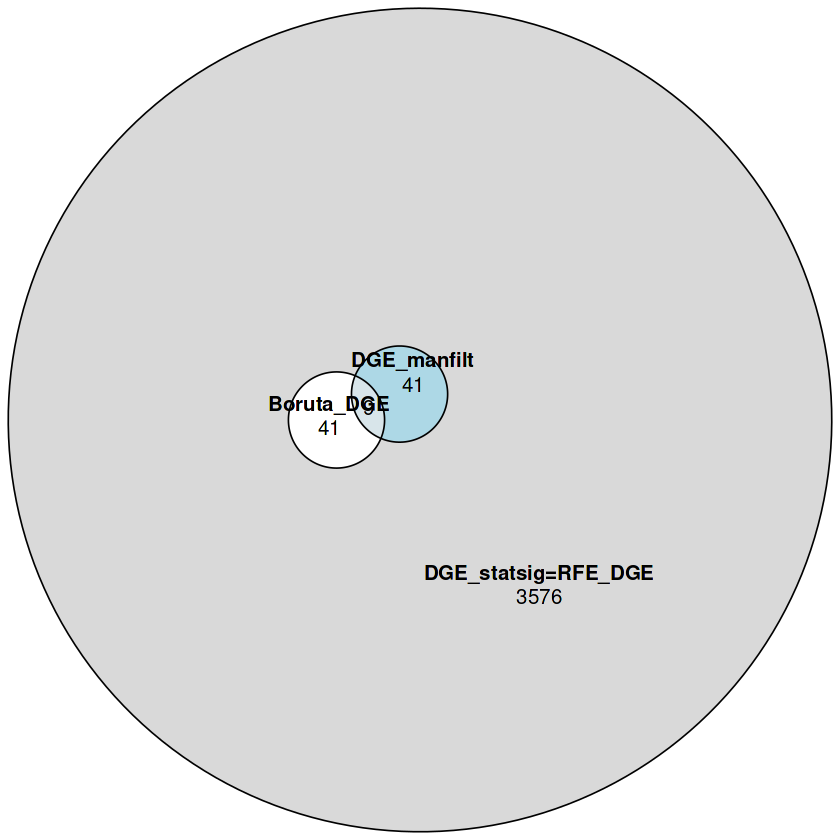

In [ ]:
### Euler diagramm to visualise overlaps within generated genesets

venn_list <- list(
    Boruta_WGCNA = as.character(qread("/kaggle/working/Boruta_WGCNA_CFS_3.qs")),
    `WGCNA_statsig=RFE_WGCNA` = WGCNA_gid_CFS_3
  )

fit1 <- euler(venn_list)
venn <- plot(fit1, quantities = TRUE)
print(venn)

venn_list <- list(
    Boruta_DGE = as.character(qread("/kaggle/working/Boruta_DGE_CFS_3.qs")),
    `DGE_statsig=RFE_DGE` = DGE_gid_CFS_3,
    DGE_manfilt = DGE_gid_manf_CFS_3
  )

fit1 <- euler(venn_list)
venn <- plot(fit1, quantities = TRUE)
print(venn)


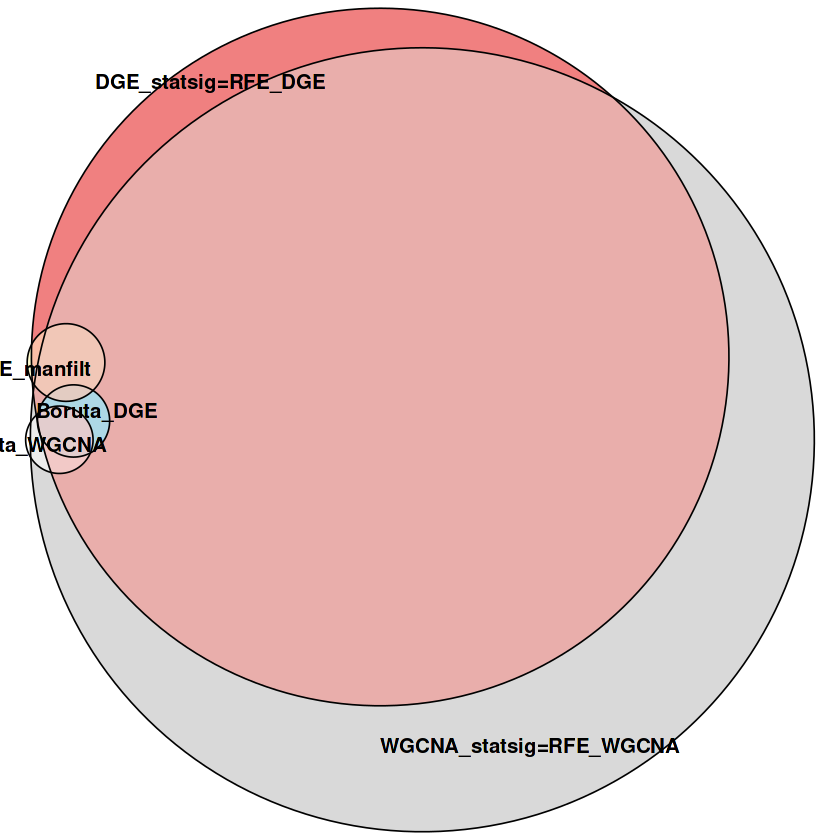

In [ ]:
venn_list <- list(
    Boruta_WGCNA = as.character(qread("/kaggle/working/Boruta_WGCNA_CFS_3.qs")),
    `WGCNA_statsig=RFE_WGCNA` = WGCNA_gid_CFS_3,
    Boruta_DGE = as.character(qread("/kaggle/working/Boruta_DGE_CFS_3.qs")),
    `DGE_statsig=RFE_DGE` = DGE_gid_CFS_3,
    DGE_manfilt = DGE_gid_manf_CFS_3
  )

fit1 <- euler(venn_list)
venn <- plot(fit1) #, quantities = TRUE)
print(venn)


[1] "Processing gene list: Boruta_WGCNA"
[1] "#####################  RF  #####################"
Confusion Matrix and Statistics

                   Reference
Prediction          healthy_control post-covid_ME-CFS
  healthy_control                 5                 3
  post-covid_ME-CFS               0                 2
                                           
               Accuracy : 0.7              
                 95% CI : (0.3475, 0.9333) 
    No Information Rate : 0.5              
    P-Value [Acc > NIR] : 0.1719           
                                           
                  Kappa : 0.4              
                                           
 Mcnemar's Test P-Value : 0.2482           
                                           
            Sensitivity : 0.400            
            Specificity : 1.000            
         Pos Pred Value : 1.000            
         Neg Pred Value : 0.625            
             Prevalence : 0.500            
         Detection R

Setting levels: control = healthy_control, case = post-covid_ME-CFS

Setting direction: controls < cases



[1] "#####################  SVM  #####################"
Confusion Matrix and Statistics

                   Reference
Prediction          healthy_control post-covid_ME-CFS
  healthy_control                 5                 0
  post-covid_ME-CFS               0                 5
                                           
               Accuracy : 1                
                 95% CI : (0.6915, 1)      
    No Information Rate : 0.5              
    P-Value [Acc > NIR] : 0.0009766        
                                           
                  Kappa : 1                
                                           
 Mcnemar's Test P-Value : NA               
                                           
            Sensitivity : 1.0              
            Specificity : 1.0              
         Pos Pred Value : 1.0              
         Neg Pred Value : 1.0              
             Prevalence : 0.5              
         Detection Rate : 0.5              
   Detection Pre

Setting levels: control = healthy_control, case = post-covid_ME-CFS

Setting direction: controls > cases



[1] "#####################  Logistic regression  #####################"


Warning message:
“Option grouped=FALSE enforced in cv.glmnet, since < 3 observations per fold”



Call:  cv.glmnet(x = as.matrix(X_train_norm[, genelist]), y = as.vector(unlist(Y_train)),      family = "binomial") 

Measure: Binomial Deviance 

     Lambda Index Measure     SE Nonzero
min 0.02118    62   0.987 0.4399      11
1se 0.23796    10   1.416 0.1788       4


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "#####################  ROC AUC  #####################"
[1] "Processing gene list: WGCNA_statsig=RFE_WGCNA"
[1] "#####################  RF  #####################"
Confusion Matrix and Statistics

                   Reference
Prediction          healthy_control post-covid_ME-CFS
  healthy_control                 5                 1
  post-covid_ME-CFS               0                 4
                                           
               Accuracy : 0.9              
                 95% CI : (0.555, 0.9975)  
    No Information Rate : 0.5              
    P-Value [Acc > NIR] : 0.01074          
                                           
                  Kappa : 0.8              
                                           
 Mcnemar's Test P-Value : 1.00000          
                                           
            Sensitivity : 0.8000           
            Specificity : 1.0000           
         Pos Pred Value : 1.0000           
         Neg Pred Value : 0.8333     

Setting levels: control = healthy_control, case = post-covid_ME-CFS

Setting direction: controls < cases



[1] "#####################  SVM  #####################"
Confusion Matrix and Statistics

                   Reference
Prediction          healthy_control post-covid_ME-CFS
  healthy_control                 5                 0
  post-covid_ME-CFS               0                 5
                                           
               Accuracy : 1                
                 95% CI : (0.6915, 1)      
    No Information Rate : 0.5              
    P-Value [Acc > NIR] : 0.0009766        
                                           
                  Kappa : 1                
                                           
 Mcnemar's Test P-Value : NA               
                                           
            Sensitivity : 1.0              
            Specificity : 1.0              
         Pos Pred Value : 1.0              
         Neg Pred Value : 1.0              
             Prevalence : 0.5              
         Detection Rate : 0.5              
   Detection Pre

Setting levels: control = healthy_control, case = post-covid_ME-CFS

Setting direction: controls > cases



[1] "#####################  Logistic regression  #####################"


Warning message:
“Option grouped=FALSE enforced in cv.glmnet, since < 3 observations per fold”



Call:  cv.glmnet(x = as.matrix(X_train_norm[, genelist]), y = as.vector(unlist(Y_train)),      family = "binomial") 

Measure: Binomial Deviance 

    Lambda Index Measure     SE Nonzero
min 0.2271    11   1.453 0.2041       6
1se 0.3617     1   1.536 0.0616       0


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "#####################  ROC AUC  #####################"
[1] "Processing gene list: Boruta_DGE"
[1] "#####################  RF  #####################"
Confusion Matrix and Statistics

                   Reference
Prediction          healthy_control post-covid_ME-CFS
  healthy_control                 4                 2
  post-covid_ME-CFS               1                 3
                                           
               Accuracy : 0.7              
                 95% CI : (0.3475, 0.9333) 
    No Information Rate : 0.5              
    P-Value [Acc > NIR] : 0.1719           
                                           
                  Kappa : 0.4              
                                           
 Mcnemar's Test P-Value : 1.0000           
                                           
            Sensitivity : 0.6000           
            Specificity : 0.8000           
         Pos Pred Value : 0.7500           
         Neg Pred Value : 0.6667           
      

Setting levels: control = healthy_control, case = post-covid_ME-CFS

Setting direction: controls < cases



[1] "#####################  SVM  #####################"
Confusion Matrix and Statistics

                   Reference
Prediction          healthy_control post-covid_ME-CFS
  healthy_control                 5                 1
  post-covid_ME-CFS               0                 4
                                           
               Accuracy : 0.9              
                 95% CI : (0.555, 0.9975)  
    No Information Rate : 0.5              
    P-Value [Acc > NIR] : 0.01074          
                                           
                  Kappa : 0.8              
                                           
 Mcnemar's Test P-Value : 1.00000          
                                           
            Sensitivity : 0.8000           
            Specificity : 1.0000           
         Pos Pred Value : 1.0000           
         Neg Pred Value : 0.8333           
             Prevalence : 0.5000           
         Detection Rate : 0.4000           
   Detection Pre

Setting levels: control = healthy_control, case = post-covid_ME-CFS

Setting direction: controls > cases



[1] "#####################  Logistic regression  #####################"


Warning message:
“Option grouped=FALSE enforced in cv.glmnet, since < 3 observations per fold”



Call:  cv.glmnet(x = as.matrix(X_train_norm[, genelist]), y = as.vector(unlist(Y_train)),      family = "binomial") 

Measure: Binomial Deviance 

     Lambda Index Measure     SE Nonzero
min 0.04459    46  0.9042 0.4221      10
1se 0.26116     8  1.3157 0.1502       2


Setting levels: control = 0, case = 1

Setting direction: controls < cases



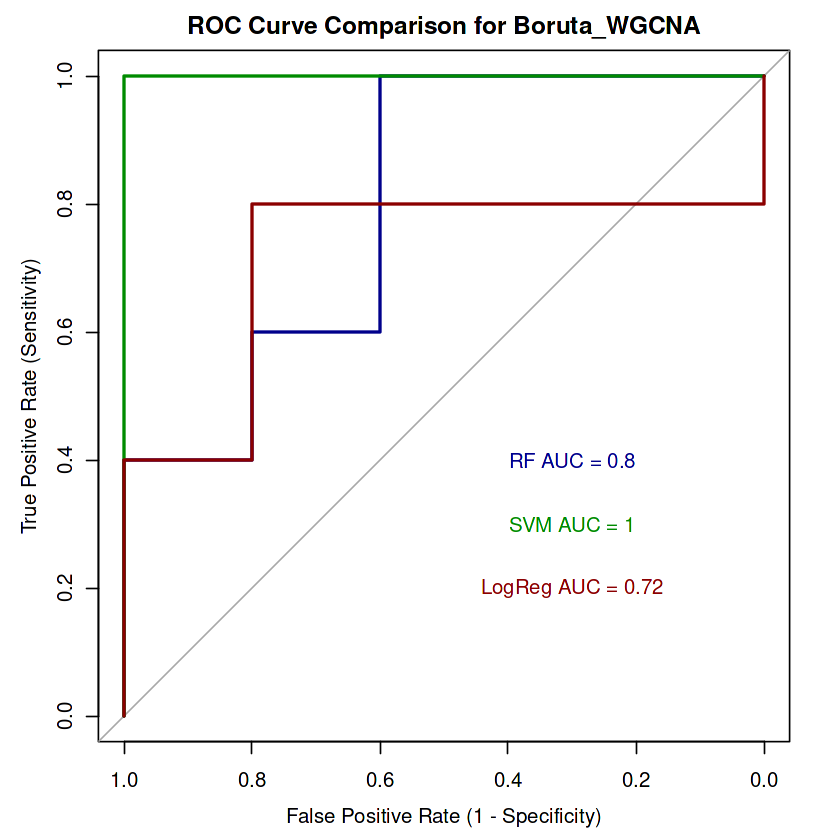

[1] "#####################  ROC AUC  #####################"
[1] "Processing gene list: DGE_statsig=RFE_DGE"
[1] "#####################  RF  #####################"
Confusion Matrix and Statistics

                   Reference
Prediction          healthy_control post-covid_ME-CFS
  healthy_control                 5                 1
  post-covid_ME-CFS               0                 4
                                           
               Accuracy : 0.9              
                 95% CI : (0.555, 0.9975)  
    No Information Rate : 0.5              
    P-Value [Acc > NIR] : 0.01074          
                                           
                  Kappa : 0.8              
                                           
 Mcnemar's Test P-Value : 1.00000          
                                           
            Sensitivity : 0.8000           
            Specificity : 1.0000           
         Pos Pred Value : 1.0000           
         Neg Pred Value : 0.8333         

Setting levels: control = healthy_control, case = post-covid_ME-CFS

Setting direction: controls < cases



[1] "#####################  SVM  #####################"
Confusion Matrix and Statistics

                   Reference
Prediction          healthy_control post-covid_ME-CFS
  healthy_control                 5                 0
  post-covid_ME-CFS               0                 5
                                           
               Accuracy : 1                
                 95% CI : (0.6915, 1)      
    No Information Rate : 0.5              
    P-Value [Acc > NIR] : 0.0009766        
                                           
                  Kappa : 1                
                                           
 Mcnemar's Test P-Value : NA               
                                           
            Sensitivity : 1.0              
            Specificity : 1.0              
         Pos Pred Value : 1.0              
         Neg Pred Value : 1.0              
             Prevalence : 0.5              
         Detection Rate : 0.5              
   Detection Pre

Setting levels: control = healthy_control, case = post-covid_ME-CFS

Setting direction: controls > cases



[1] "#####################  Logistic regression  #####################"


Warning message:
“Option grouped=FALSE enforced in cv.glmnet, since < 3 observations per fold”



Call:  cv.glmnet(x = as.matrix(X_train_norm[, genelist]), y = as.vector(unlist(Y_train)),      family = "binomial") 

Measure: Binomial Deviance 

    Lambda Index Measure     SE Nonzero
min 0.0146    70  0.9867 0.4736      19
1se 0.3617     1  1.4363 0.0575       0


Setting levels: control = 0, case = 1

Setting direction: controls < cases



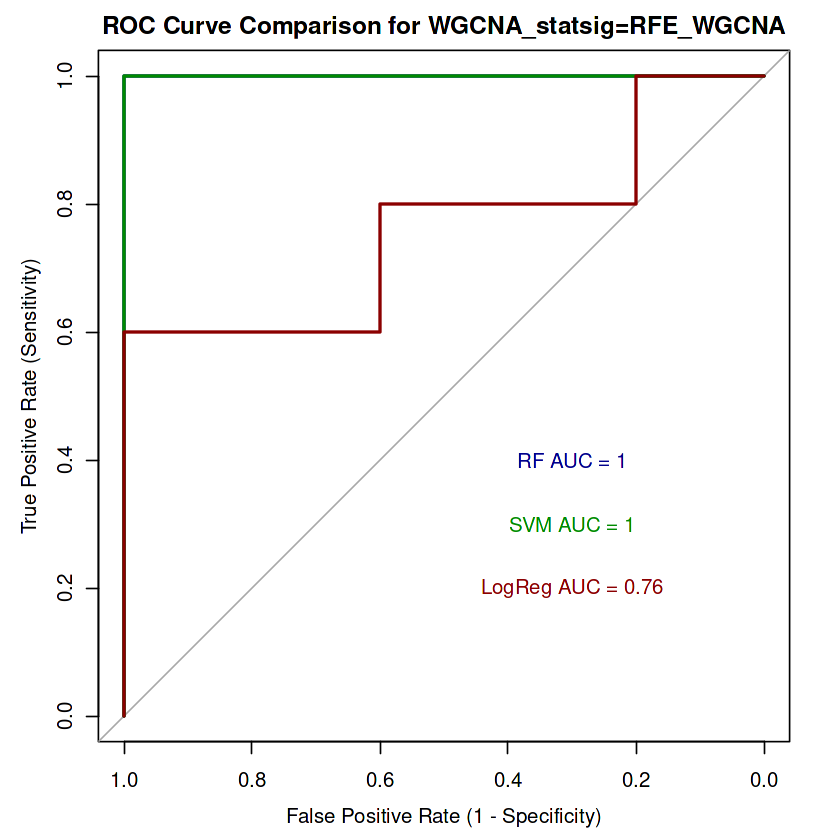

[1] "#####################  ROC AUC  #####################"
[1] "Processing gene list: DGE_manfilt"
[1] "#####################  RF  #####################"
Confusion Matrix and Statistics

                   Reference
Prediction          healthy_control post-covid_ME-CFS
  healthy_control                 4                 2
  post-covid_ME-CFS               1                 3
                                           
               Accuracy : 0.7              
                 95% CI : (0.3475, 0.9333) 
    No Information Rate : 0.5              
    P-Value [Acc > NIR] : 0.1719           
                                           
                  Kappa : 0.4              
                                           
 Mcnemar's Test P-Value : 1.0000           
                                           
            Sensitivity : 0.6000           
            Specificity : 0.8000           
         Pos Pred Value : 0.7500           
         Neg Pred Value : 0.6667           
     

Setting levels: control = healthy_control, case = post-covid_ME-CFS

Setting direction: controls < cases



[1] "#####################  SVM  #####################"
Confusion Matrix and Statistics

                   Reference
Prediction          healthy_control post-covid_ME-CFS
  healthy_control                 5                 0
  post-covid_ME-CFS               0                 5
                                           
               Accuracy : 1                
                 95% CI : (0.6915, 1)      
    No Information Rate : 0.5              
    P-Value [Acc > NIR] : 0.0009766        
                                           
                  Kappa : 1                
                                           
 Mcnemar's Test P-Value : NA               
                                           
            Sensitivity : 1.0              
            Specificity : 1.0              
         Pos Pred Value : 1.0              
         Neg Pred Value : 1.0              
             Prevalence : 0.5              
         Detection Rate : 0.5              
   Detection Pre

Setting levels: control = healthy_control, case = post-covid_ME-CFS

Setting direction: controls > cases



[1] "#####################  Logistic regression  #####################"


Warning message:
“Option grouped=FALSE enforced in cv.glmnet, since < 3 observations per fold”



Call:  cv.glmnet(x = as.matrix(X_train_norm[, genelist]), y = as.vector(unlist(Y_train)),      family = "binomial") 

Measure: Binomial Deviance 

     Lambda Index Measure     SE Nonzero
min 0.01105    76  0.8069 0.4791      16
1se 0.22714    11  1.2831 0.1530       3


Setting levels: control = 0, case = 1

Setting direction: controls < cases



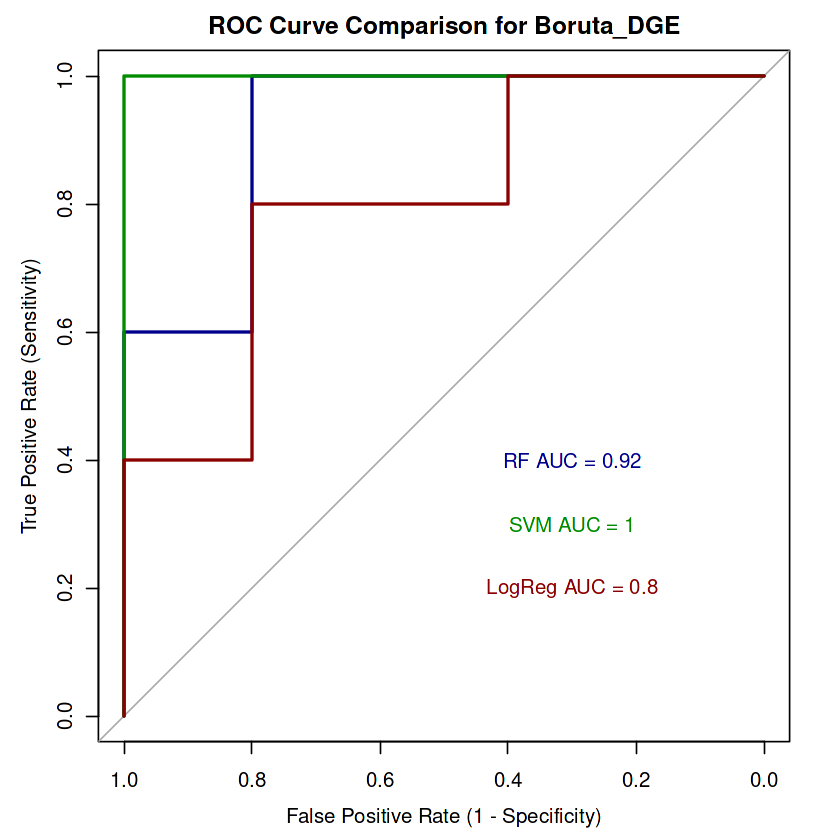

[1] "#####################  ROC AUC  #####################"


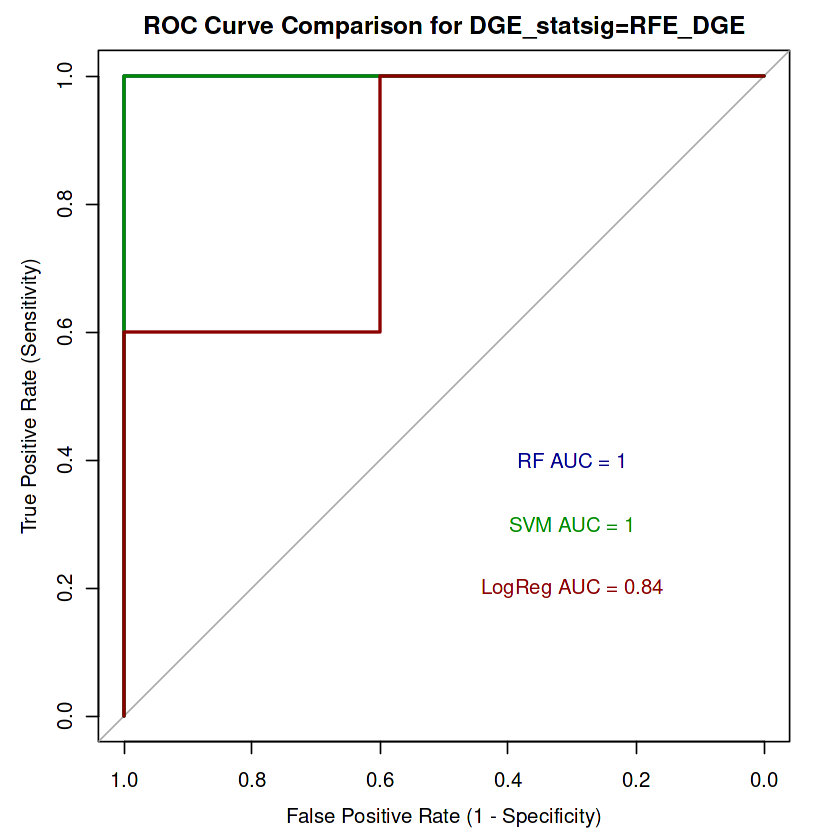

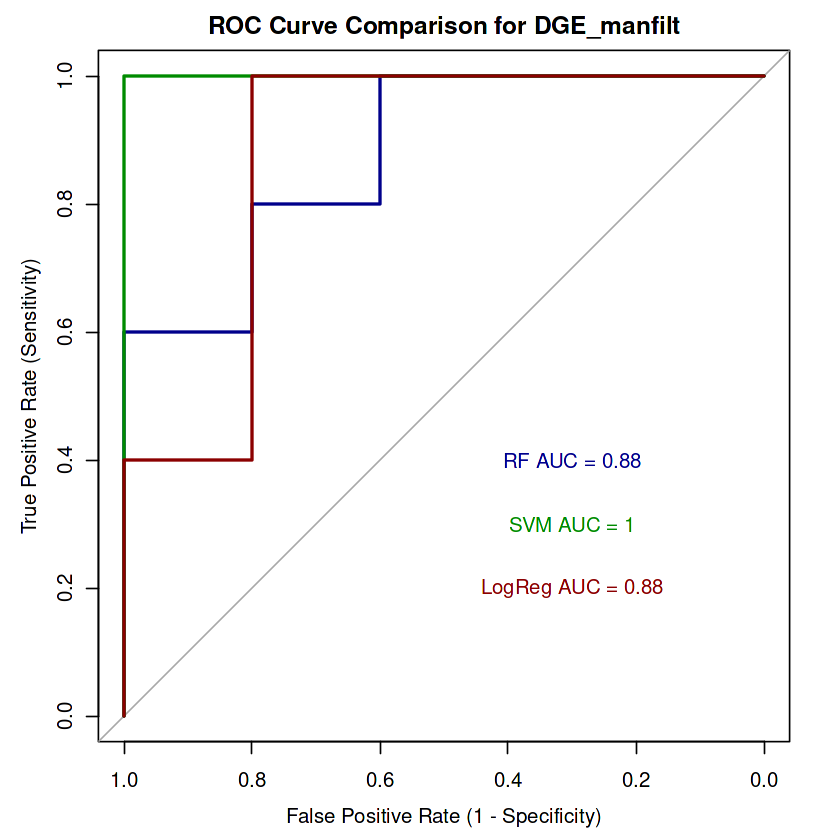

In [ ]:
### Fitting and testing binomial classification models

set.seed(123)

genelists <- list(
    Boruta_WGCNA = as.character(qread("/kaggle/working/Boruta_WGCNA_CFS_3.qs")),
    `WGCNA_statsig=RFE_WGCNA` = WGCNA_gid_CFS_3,
    Boruta_DGE = as.character(qread("/kaggle/working/Boruta_DGE_CFS_3.qs")),
    `DGE_statsig=RFE_DGE` = DGE_gid_CFS_3,
    DGE_manfilt = DGE_gid_manf_CFS_3
  )

for (genelist_name in names(genelists)) {
    print(paste("Processing gene list:", genelist_name))
    genelist <- genelists[[genelist_name]]

    print("#####################  RF  #####################")

    # Random forest
    rf_model <- randomForest(
      x = X_train_norm[, genelist],
      y = Y_train_as_factor,
      ntree = 1501,
      importance = TRUE,
      classwt = class_weights_fact,
      mtry = floor(sqrt(length(genelist)))
    )

    pred_rf <- predict(rf_model, X_test_norm[, genelist])

    confusion_rf <- confusionMatrix(pred_rf, Y_test_as_factor, positive = "post-covid_ME-CFS") ##### !!!
    print(confusion_rf)

    feature_importance_rf <- as.data.frame(importance(rf_model))
    feature_importance_rf$Feature <- rownames(feature_importance_rf)
    qsave(feature_importance_rf, paste0(genelist_name,"_feature_importance_rf.qs"))

    pred_rf_prob <- predict(rf_model, X_test_norm[, genelist], type = "prob")
    positive_class_index <- 2                                                      ################### !!!
    pred_prob_positive_class <- pred_rf_prob[, positive_class_index]
    roc_rf <- roc(Y_test_as_factor, pred_prob_positive_class) #Y_test must be a factor
    qsave(roc_rf, paste0(genelist_name,"_roc_rf.qs"))

    print("#####################  SVM  #####################")

    svm_tuned <- tune(svm,
      Y_train_as_factor ~ .,
      data = data.frame(Y_train_as_factor = Y_train_as_factor, X_train_norm[, genelist], check.names = FALSE),
      kernel = "radial",
      type = "C-classification",
      ranges = list(cost = c(0.01, 0.1, 1, 10, 50, 100),
                    gamma = c(1 / length(genelist), 0.001, 0.01, 0.1, 1, 10)),
      class.weights = class_weights_fact,
      tunecontrol = tune.control(cross = 10)
    )

    # plot(svm_tuned)
    summary(svm_tuned)
    best_model_svm <- svm_tuned$best.model

    pred_svm <- predict(best_model_svm, X_test_norm[, genelist])
    confusion_svm <- confusionMatrix(pred_svm, Y_test_as_factor, positive = "post-covid_ME-CFS") ##### !!!!
    print(confusion_svm)

    pred_svm_prob <- predict(best_model_svm, X_test_norm[, genelist], decision.values = TRUE)
    pred_prob_svm <- attributes(pred_svm_prob)$decision.values
    roc_svm <- roc(Y_test_as_factor, as.numeric(pred_prob_svm))
    qsave(roc_svm, paste0(genelist_name,"_roc_svm.qs"))


    print("#####################  Logistic regression  #####################")

    cvfit <- cv.glmnet(as.matrix(X_train_norm[, genelist]), as.vector(unlist(Y_train)), family = "binomial")
    # plot(cvfit)
    print(cvfit)

    coef_at_min <- coef(cvfit, s = "lambda.min")
    nonzero_coef_1 <- extract.coef(cvfit)
    genelist_nonzero_coef_1 <- rownames(nonzero_coef_1)[-1]

    head(nonzero_coef_1)
    qsave(nonzero_coef_1, paste0(genelist_name,"_nonzero_coef_logreg.qs"))

    prediction_test <- predict(cvfit, newx = as.matrix(X_test_norm[, genelist]), family = "binomial", s = "lambda.min", type='response')
    prediction_test_measures <- assess.glmnet(cvfit, newx = as.matrix(X_test_norm[, genelist]), newy = as.vector(unlist(Y_test)), family = "binomial", s = "lambda.min")
    prediction_test_measures

    roc_logreg <- roc(as.vector(unlist(Y_test)), c(prediction_test))
    qsave(roc_logreg, paste0(genelist_name,"_roc_logreg.qs"))


    print("#####################  ROC AUC  #####################")

    plot(roc_rf, col = "blue4", print.auc = FALSE,
         xlab = "False Positive Rate (1 - Specificity)",
         ylab = "True Positive Rate (Sensitivity)",
         main = paste0("ROC Curve Comparison for ", genelist_name))
    rf_auc_text <- paste("RF AUC =", round(auc(roc_rf), 2))
    text(x = 0.3, y = 0.4, labels = rf_auc_text, col = "blue4")

    plot(roc_svm, col = "green4", print.auc = FALSE, add = TRUE)
    svm_auc_text <- paste("SVM AUC =", round(auc(roc_svm), 2))
    text(x = 0.3, y = 0.3, labels = svm_auc_text, col = "green4")

    plot(roc_logreg, col = "red4", print.auc = FALSE, add = TRUE)
    logreg_auc_text <- paste("LogReg AUC =", round(auc(roc_logreg), 2))
    text(x = 0.3, y = 0.2, labels = logreg_auc_text, col = "red4")
}

## FM_1

In [ ]:
dge_res <- qread("/kaggle/input/dge-wgcna-res/DGE_FM_1_res_annot.qs")

dge_res_filtered <- dge_res %>%
   filter(
           gene_name != "" &
           !is.na(gene_name) &
           gene_name != "NA" &
           padj < 0.05
   )

top_50_genes <- dge_res_filtered %>%
   arrange(desc(abs(log2FoldChange))) %>%
   slice_head(n = 50)

dge_res_filtered <- dge_res_filtered %>%
  group_by(gene_name) %>%
  filter(pvalue == min(pvalue)) %>%
  ungroup()

top_50_genes <- top_50_genes %>%
  group_by(gene_name) %>%
  filter(pvalue == min(pvalue)) %>%
  ungroup()

DGE_genes_FM_1 <- dge_res_filtered$gene_name
DGE_genes_manf_FM_1 <- top_50_genes$gene_name

DGE_gid_FM_1 <- dge_res_filtered$gene_id
DGE_gid_manf_FM_1 <- top_50_genes$gene_id

In [ ]:
### Uploading statistically significant WGCNA results

wgcna_res <- qread("/kaggle/input/dge-wgcna-res/WGSNA_FM_1_res_annot.qs")

wgcna_res_filtered  <- wgcna_res %>%
  group_by(gene_name) %>%
  filter(`p.GS.disease_state_Healthy patient (CONTROL)` == min(`p.GS.disease_state_Healthy patient (CONTROL)`)) %>%
  ungroup()

wgcna_res_filtered  <- wgcna_res_filtered %>%
   filter(
           gene_name != "" &
           !is.na(gene_name) &
           gene_name != "NA" &
           `p.GS.disease_state_Healthy patient (CONTROL)` < 0.05
   )

WGCNA_gid_FM_1 <- wgcna_res_filtered$gene_id
WGCNA_genes_FM_1 <- wgcna_res_filtered$gene_name

In [ ]:
combined_gid <- unique(c(WGCNA_gid_FM_1, DGE_gid_FM_1))

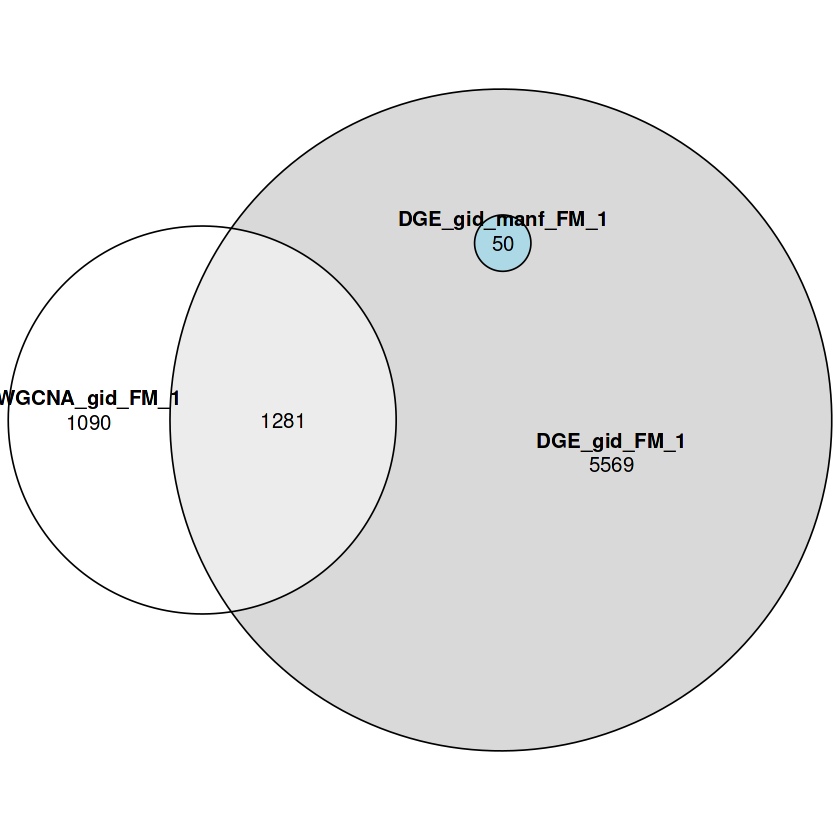

In [ ]:
venn_list <- list(
    WGCNA_gid_FM_1 = WGCNA_gid_FM_1,
    DGE_gid_FM_1 = DGE_gid_FM_1,
    DGE_gid_manf_FM_1 = DGE_gid_manf_FM_1
  )

fit1 <- euler(venn_list)
venn <- plot(fit1, quantities = TRUE)
print(venn)

In [ ]:
### Uploading train and test expression (X) and phenotype data (Y)
### Converting disease condition study to vector with levels

df_train <- qread("/kaggle/input/dge-wgcna-res/gse_train_FM_1.qs")
df_test <- qread("/kaggle/input/dge-wgcna-res/gse_test_FM_1.qs")

X_train <- as.data.frame(t((assays(df_train)[['counts']])[combined_gid, ]))
X_test <- as.data.frame(t((assays(df_test)[['counts']])[combined_gid, ]))

pd_train <- colData(df_train)[, c("disease_state")]
pd_train <- dummy_cols(pd_train, remove_selected_columns=TRUE)
Y_train <- pd_train$`.data_Fibromylagia patient (FMA)`

pd_test <- colData(df_test)[, c("disease_state")]
pd_test <- dummy_cols(pd_test, remove_selected_columns=TRUE)
Y_test <- pd_test$`.data_Fibromylagia patient (FMA)`


Y_train_as_factor <- as.factor(colData(df_train)[, c("disease_state")])
Y_test_as_factor <- as.factor(colData(df_test)[, c("disease_state")])

Y_train_as_factor <- relevel(Y_train_as_factor, ref = "Healthy patient (CONTROL)")
Y_test_as_factor <- relevel(Y_test_as_factor, ref = "Healthy patient (CONTROL)")

In [ ]:
### Adding sex variable as a feature
sex_info_train <- ifelse(colData(df_train)[, "sex"] == "female", 1, 0)
sex_info_test <- ifelse(colData(df_test)[, "sex"] == "female", 1, 0)

In [ ]:
class_counts <- table(Y_train)
total_samples <- sum(class_counts)
num_classes <- length(class_counts)
class_weights <- total_samples / (num_classes * class_counts)

class_counts <- table(Y_train_as_factor)
total_samples <- sum(class_counts)
num_classes <- length(class_counts)
class_weights_fact <- total_samples / (num_classes * class_counts)

In [ ]:
### Train data log standartisation
### Applying mean and SD calculated for train data on test data

X_train_norm <- log(X_train + 1)
mean_values <- colMeans(X_train_norm)
std_values <- apply(X_train_norm, 2, sd)
X_train_norm <- scale(X_train_norm, center = mean_values, scale = std_values)
X_train_norm <- as.data.frame(X_train_norm)

X_test_norm <- log(X_test + 1)
X_test_norm <- scale(X_test_norm, center = mean_values, scale = std_values)
X_test_norm <- as.data.frame(X_test_norm)

In [ ]:
# Adding sex info for filtration
X_train_norm$sex <- sex_info_train
X_test_norm$sex <- sex_info_test
WGCNA_gid_FM_1_wsex <- append(WGCNA_gid_FM_1, "sex")
DGE_gid_FM_1_wsex <- append(DGE_gid_FM_1, "sex")
DGE_gid_manf_FM_1_wsex <- append(DGE_gid_manf_FM_1, "sex")

In [ ]:
### Feature filtration using RFE and Boruta

set.seed(123)

GIDs <- list(WGCNA_FM_1 = WGCNA_gid_FM_1_wsex,
             DGE_FM_1 = DGE_gid_FM_1_wsex)

for (genelist_name in names(GIDs)) {
    print(paste("Processing gene list:", genelist_name))

    GID <- GIDs[[genelist_name]]

    X_train_norm_1 <- X_train_norm %>% dplyr::select(all_of(GID))

    # RFE (Recursive Feature Elimination)
    control <- rfeControl(functions = rfFuncs,
                          method = "repeatedcv",
                          number = 10,
                          repeats = 3)
    rfe_results <- rfe(
      x = X_train_norm_1,
      y = Y_train_as_factor,
      sizes = seq(5, min(500, ncol(X_train_norm_1)), by = 10),   ##########################!!!!!!!!!!!!!!!!!!!!!!!!!
      rfeControl = control
    )

    print(rfe_results)
    qsave(rfe_results, file = paste0("RFE_res_", genelist_name, ".qs"))
    genelist_rfe_predict <- predictors(rfe_results)
    length(genelist_rfe_predict)
    qsave(genelist_rfe_predict, file = paste0("RFE_", genelist_name, ".qs"))

    # Boruta

    boruta_data <- data.frame(Y_train_as_factor = Y_train_as_factor, X_train_norm_1, check.names = FALSE)
    names(boruta_data) <- make.names(names(boruta_data))

    boruta_formula <- as.formula("Y_train_as_factor ~ .")

    boruta_results <- Boruta(
      formula = boruta_formula,
      data = boruta_data,
      doTrace = 2
    )
    boruta_final <- TentativeRoughFix(boruta_results)
    print(boruta_final)
    selected_features <- getSelectedAttributes(boruta_final, withTentative = FALSE)

    selected_features <- lapply(selected_features, function(x) str_remove(x, "^X"))
    qsave(selected_features, file = paste0("Boruta_", genelist_name, ".qs"))
}

[1] "Processing gene list: WGCNA_FM_1"

Recursive feature selection

Outer resampling method: Cross-Validated (10 fold, repeated 3 times) 

Resampling performance over subset size:

 Variables Accuracy  Kappa AccuracySD KappaSD Selected
         5   0.7305 0.4628     0.1175  0.2334         
        15   0.7786 0.5583     0.1226  0.2437        *
        25   0.7681 0.5375     0.1174  0.2331         
        35   0.7477 0.4976     0.1243  0.2458         
        45   0.7677 0.5368     0.1186  0.2352         
        55   0.7501 0.5011     0.1219  0.2428         
        65   0.7576 0.5156     0.1174  0.2342         
        75   0.7598 0.5204     0.1258  0.2501         
        85   0.7476 0.4959     0.1242  0.2467         
        95   0.7553 0.5113     0.1212  0.2401         
       105   0.7598 0.5201     0.1213  0.2409         
       115   0.7531 0.5067     0.1076  0.2138         
       125   0.7553 0.5114     0.1161  0.2306         
       135   0.7600 0.5212     0.1127  0.2239   

 1. run of importance source...

 2. run of importance source...

 3. run of importance source...

 4. run of importance source...

 5. run of importance source...

 6. run of importance source...

 7. run of importance source...

 8. run of importance source...

 9. run of importance source...

 10. run of importance source...

 11. run of importance source...

 12. run of importance source...

 13. run of importance source...

 14. run of importance source...

 15. run of importance source...

 16. run of importance source...

 17. run of importance source...

 18. run of importance source...

After 18 iterations, +10 secs: 

 confirmed 1 attribute: ENSG00000162032;

 rejected 2208 attributes: ENSG00000000419, ENSG00000000457, ENSG00000001084, ENSG00000001629, ENSG00000001630 and 2203 more;

 still have 163 attributes left.


 19. run of importance source...

 20. run of importance source...

 21. run of importance source...

 22. run of importance source...

 23. run of importance s

Boruta performed 99 iterations in 17.04078 secs.
Tentatives roughfixed over the last 99 iterations.
 60 attributes confirmed important: ENSG00000002834, ENSG00000005884,
ENSG00000012817, ENSG00000066185, ENSG00000067048 and 55 more;
 2312 attributes confirmed unimportant: ENSG00000000419,
ENSG00000000457, ENSG00000001084, ENSG00000001629, ENSG00000001630 and
2307 more;
[1] "Processing gene list: DGE_FM_1"

Recursive feature selection

Outer resampling method: Cross-Validated (10 fold, repeated 3 times) 

Resampling performance over subset size:

 Variables Accuracy  Kappa AccuracySD KappaSD Selected
         5   0.7328 0.4630    0.11679  0.2335         
        15   0.7564 0.5105    0.09691  0.1945         
        25   0.7493 0.4954    0.12215  0.2468         
        35   0.7714 0.5387    0.10680  0.2158         
        45   0.7614 0.5194    0.11320  0.2284         
        55   0.7740 0.5449    0.11038  0.2223         
        65   0.7615 0.5201    0.11857  0.2385         
        

 1. run of importance source...

 2. run of importance source...

 3. run of importance source...

 4. run of importance source...

 5. run of importance source...

 6. run of importance source...

 7. run of importance source...

 8. run of importance source...

 9. run of importance source...

 10. run of importance source...

 11. run of importance source...

 12. run of importance source...

 13. run of importance source...

 14. run of importance source...

 15. run of importance source...

 16. run of importance source...

 17. run of importance source...

 18. run of importance source...

 19. run of importance source...

 20. run of importance source...

After 20 iterations, +28 secs: 

 rejected 6675 attributes: ENSG00000000003, ENSG00000000419, ENSG00000000457, ENSG00000000460, ENSG00000000971 and 6670 more;

 still have 226 attributes left.


 21. run of importance source...

 22. run of importance source...

 23. run of importance source...

 24. run of importance source...

Boruta performed 99 iterations in 36.04148 secs.
Tentatives roughfixed over the last 99 iterations.
 57 attributes confirmed important: ENSG00000002834, ENSG00000067048,
ENSG00000070614, ENSG00000078687, ENSG00000100726 and 52 more;
 6844 attributes confirmed unimportant: ENSG00000000003,
ENSG00000000419, ENSG00000000457, ENSG00000000460, ENSG00000000971 and
6839 more;


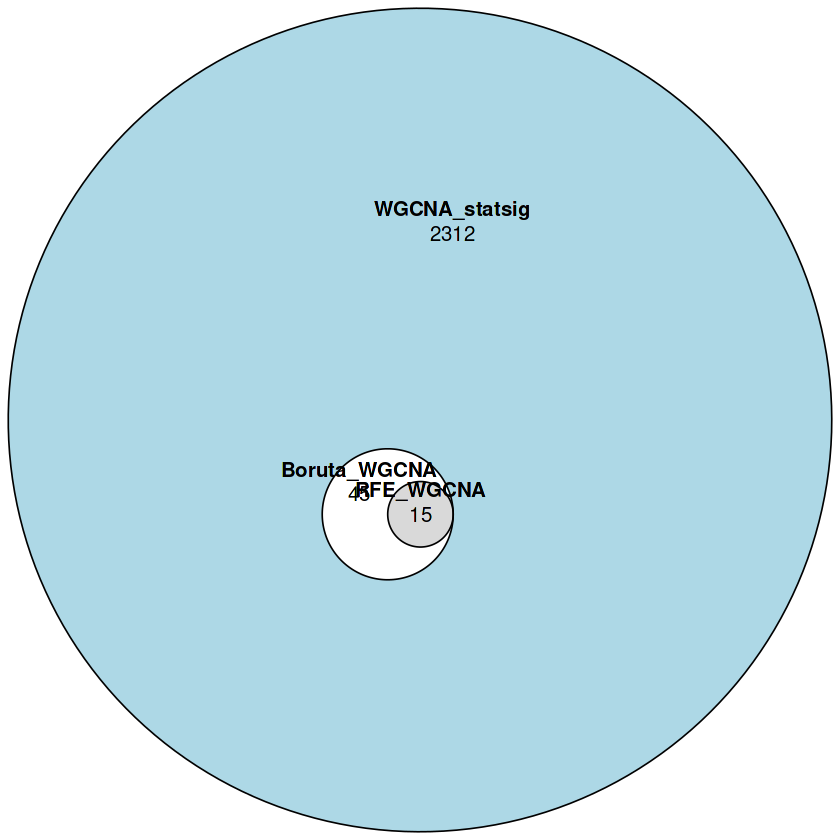

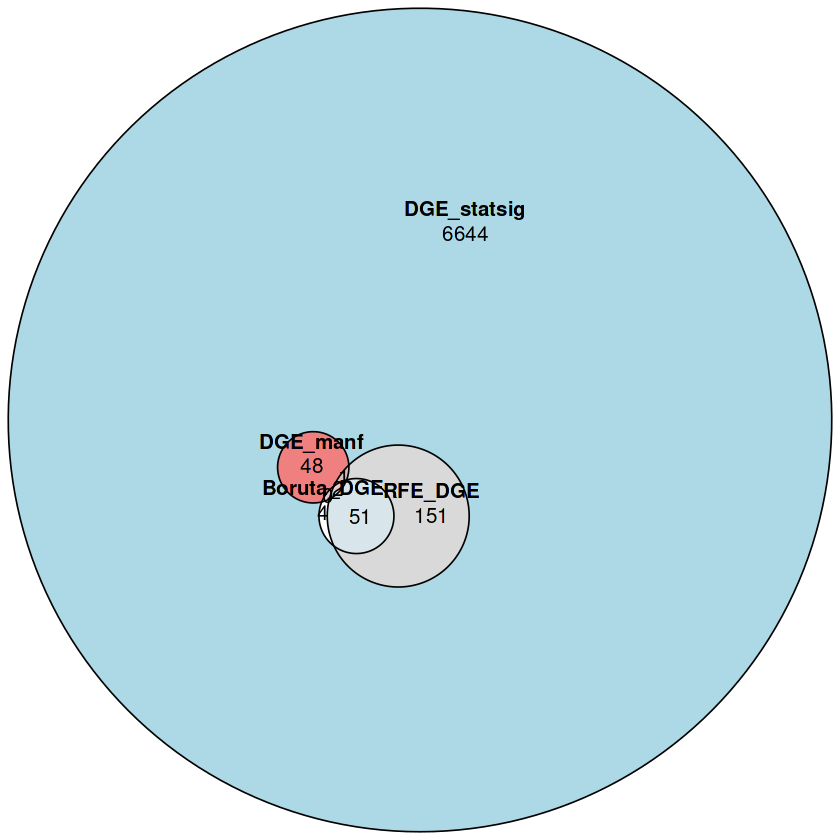

In [ ]:
venn_list <- list(
    Boruta_WGCNA = as.character(qread("/kaggle/working/Boruta_WGCNA_FM_1.qs")),
    RFE_WGCNA = qread("/kaggle/working/RFE_WGCNA_FM_1.qs"),
    WGCNA_statsig = WGCNA_gid_FM_1_wsex
  )

fit1 <- euler(venn_list)
venn <- plot(fit1, quantities = TRUE)
print(venn)

venn_list <- list(
    Boruta_DGE = as.character(qread("/kaggle/working/Boruta_DGE_FM_1.qs")),
    RFE_DGE = qread("/kaggle/working/RFE_DGE_FM_1.qs"),
    DGE_statsig = DGE_gid_FM_1_wsex,
    DGE_manf = DGE_gid_manf_FM_1_wsex
  )

fit1 <- euler(venn_list)
venn <- plot(fit1, quantities = TRUE)
print(venn)

[1] "Processing gene list: Boruta_WGCNA"
[1] "#####################  RF  #####################"
Confusion Matrix and Statistics

                            Reference
Prediction                   Healthy patient (CONTROL)
  Healthy patient (CONTROL)                         24
  Fibromylagia patient (FMA)                         3
                            Reference
Prediction                   Fibromylagia patient (FMA)
  Healthy patient (CONTROL)                           6
  Fibromylagia patient (FMA)                         22
                                                    
               Accuracy : 0.8364                    
                 95% CI : (0.712, 0.9223)           
    No Information Rate : 0.5091                    
    P-Value [Acc > NIR] : 4.245e-07                 
                                                    
                  Kappa : 0.6733                    
                                                    
 Mcnemar's Test P-Value : 0.505       

Setting levels: control = Healthy patient (CONTROL), case = Fibromylagia patient (FMA)

Setting direction: controls < cases



[1] "#####################  SVM  #####################"
Confusion Matrix and Statistics

                            Reference
Prediction                   Healthy patient (CONTROL)
  Healthy patient (CONTROL)                         20
  Fibromylagia patient (FMA)                         7
                            Reference
Prediction                   Fibromylagia patient (FMA)
  Healthy patient (CONTROL)                           8
  Fibromylagia patient (FMA)                         20
                                                    
               Accuracy : 0.7273                    
                 95% CI : (0.5904, 0.8386)          
    No Information Rate : 0.5091                    
    P-Value [Acc > NIR] : 0.0008081                 
                                                    
                  Kappa : 0.4547                    
                                                    
 Mcnemar's Test P-Value : 1.0000000                 
                         

Setting levels: control = Healthy patient (CONTROL), case = Fibromylagia patient (FMA)

Setting direction: controls < cases



[1] "#####################  Logistic regression  #####################"

Call:  cv.glmnet(x = as.matrix(X_train_norm[, genelist]), y = as.vector(unlist(Y_train)),      family = "binomial") 

Measure: Binomial Deviance 

     Lambda Index Measure      SE Nonzero
min 0.01708    31  0.5944 0.08847      20
1se 0.04330    21  0.6661 0.07845      17


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "#####################  ROC AUC  #####################"
[1] "Processing gene list: RFE_WGCNA"
[1] "#####################  RF  #####################"
Confusion Matrix and Statistics

                            Reference
Prediction                   Healthy patient (CONTROL)
  Healthy patient (CONTROL)                         24
  Fibromylagia patient (FMA)                         3
                            Reference
Prediction                   Fibromylagia patient (FMA)
  Healthy patient (CONTROL)                           7
  Fibromylagia patient (FMA)                         21
                                                    
               Accuracy : 0.8182                    
                 95% CI : (0.691, 0.9092)           
    No Information Rate : 0.5091                    
    P-Value [Acc > NIR] : 1.945e-06                 
                                                    
                  Kappa : 0.6372                    
                                  

Setting levels: control = Healthy patient (CONTROL), case = Fibromylagia patient (FMA)

Setting direction: controls < cases



[1] "#####################  SVM  #####################"
Confusion Matrix and Statistics

                            Reference
Prediction                   Healthy patient (CONTROL)
  Healthy patient (CONTROL)                         23
  Fibromylagia patient (FMA)                         4
                            Reference
Prediction                   Fibromylagia patient (FMA)
  Healthy patient (CONTROL)                           5
  Fibromylagia patient (FMA)                         23
                                                    
               Accuracy : 0.8364                    
                 95% CI : (0.712, 0.9223)           
    No Information Rate : 0.5091                    
    P-Value [Acc > NIR] : 4.245e-07                 
                                                    
                  Kappa : 0.6728                    
                                                    
 Mcnemar's Test P-Value : 1                         
                         

Setting levels: control = Healthy patient (CONTROL), case = Fibromylagia patient (FMA)

Setting direction: controls < cases



[1] "#####################  Logistic regression  #####################"

Call:  cv.glmnet(x = as.matrix(X_train_norm[, genelist]), y = as.vector(unlist(Y_train)),      family = "binomial") 

Measure: Binomial Deviance 

     Lambda Index Measure      SE Nonzero
min 0.01874    30  0.8196 0.06234       7
1se 0.05723    18  0.8802 0.04820       8


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "#####################  ROC AUC  #####################"
[1] "Processing gene list: Boruta_DGE"
[1] "#####################  RF  #####################"
Confusion Matrix and Statistics

                            Reference
Prediction                   Healthy patient (CONTROL)
  Healthy patient (CONTROL)                         22
  Fibromylagia patient (FMA)                         5
                            Reference
Prediction                   Fibromylagia patient (FMA)
  Healthy patient (CONTROL)                           8
  Fibromylagia patient (FMA)                         20
                                                    
               Accuracy : 0.7636                    
                 95% CI : (0.6298, 0.8677)          
    No Information Rate : 0.5091                    
    P-Value [Acc > NIR] : 9.678e-05                 
                                                    
                  Kappa : 0.5281                    
                                 

Setting levels: control = Healthy patient (CONTROL), case = Fibromylagia patient (FMA)

Setting direction: controls < cases



[1] "#####################  SVM  #####################"
Confusion Matrix and Statistics

                            Reference
Prediction                   Healthy patient (CONTROL)
  Healthy patient (CONTROL)                         21
  Fibromylagia patient (FMA)                         6
                            Reference
Prediction                   Fibromylagia patient (FMA)
  Healthy patient (CONTROL)                           6
  Fibromylagia patient (FMA)                         22
                                                    
               Accuracy : 0.7818                    
                 95% CI : (0.6499, 0.8819)          
    No Information Rate : 0.5091                    
    P-Value [Acc > NIR] : 2.915e-05                 
                                                    
                  Kappa : 0.5635                    
                                                    
 Mcnemar's Test P-Value : 1                         
                         

Setting levels: control = Healthy patient (CONTROL), case = Fibromylagia patient (FMA)

Setting direction: controls < cases



[1] "#####################  Logistic regression  #####################"

Call:  cv.glmnet(x = as.matrix(X_train_norm[, genelist]), y = as.vector(unlist(Y_train)),      family = "binomial") 

Measure: Binomial Deviance 

      Lambda Index Measure      SE Nonzero
min 0.009772    37   0.482 0.08104      21
1se 0.027191    26   0.562 0.05590      19


Setting levels: control = 0, case = 1

Setting direction: controls < cases



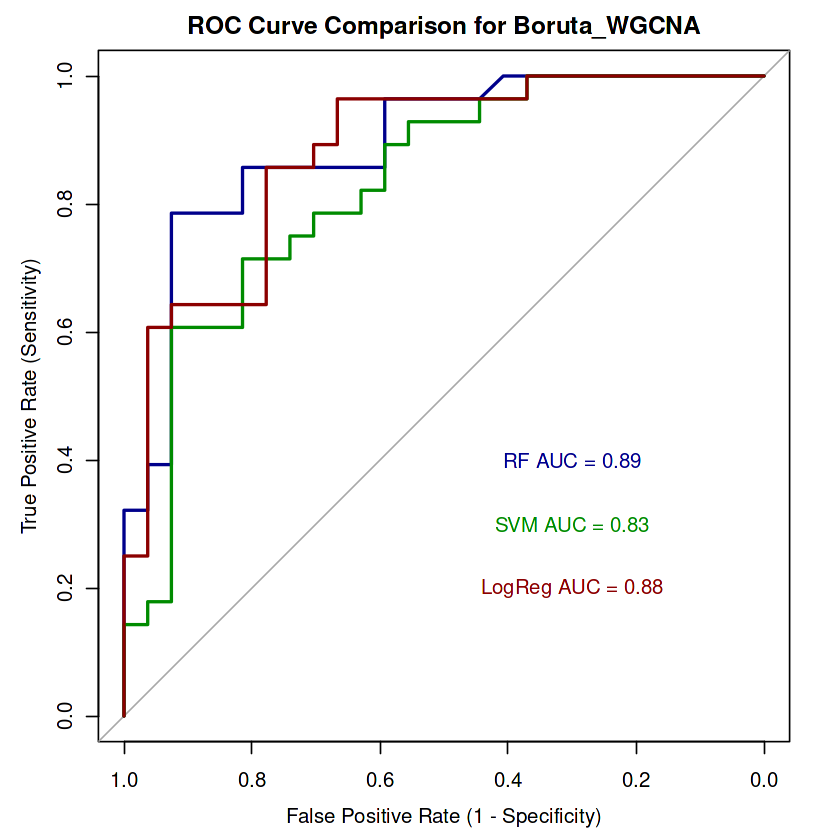

[1] "#####################  ROC AUC  #####################"
[1] "Processing gene list: RFE_DGE"
[1] "#####################  RF  #####################"
Confusion Matrix and Statistics

                            Reference
Prediction                   Healthy patient (CONTROL)
  Healthy patient (CONTROL)                         22
  Fibromylagia patient (FMA)                         5
                            Reference
Prediction                   Fibromylagia patient (FMA)
  Healthy patient (CONTROL)                           7
  Fibromylagia patient (FMA)                         21
                                                    
               Accuracy : 0.7818                    
                 95% CI : (0.6499, 0.8819)          
    No Information Rate : 0.5091                    
    P-Value [Acc > NIR] : 2.915e-05                 
                                                    
                  Kappa : 0.5641                    
                                    

Setting levels: control = Healthy patient (CONTROL), case = Fibromylagia patient (FMA)

Setting direction: controls < cases



[1] "#####################  SVM  #####################"
Confusion Matrix and Statistics

                            Reference
Prediction                   Healthy patient (CONTROL)
  Healthy patient (CONTROL)                         23
  Fibromylagia patient (FMA)                         4
                            Reference
Prediction                   Fibromylagia patient (FMA)
  Healthy patient (CONTROL)                           7
  Fibromylagia patient (FMA)                         21
                                                    
               Accuracy : 0.8                       
                 95% CI : (0.6703, 0.8957)          
    No Information Rate : 0.5091                    
    P-Value [Acc > NIR] : 7.942e-06                 
                                                    
                  Kappa : 0.6007                    
                                                    
 Mcnemar's Test P-Value : 0.5465                    
                         

Setting levels: control = Healthy patient (CONTROL), case = Fibromylagia patient (FMA)

Setting direction: controls < cases



[1] "#####################  Logistic regression  #####################"

Call:  cv.glmnet(x = as.matrix(X_train_norm[, genelist]), y = as.vector(unlist(Y_train)),      family = "binomial") 

Measure: Binomial Deviance 

      Lambda Index Measure      SE Nonzero
min 0.007392    79  0.4964 0.08946      29
1se 0.031263    48  0.5820 0.04302      23


Setting levels: control = 0, case = 1

Setting direction: controls < cases



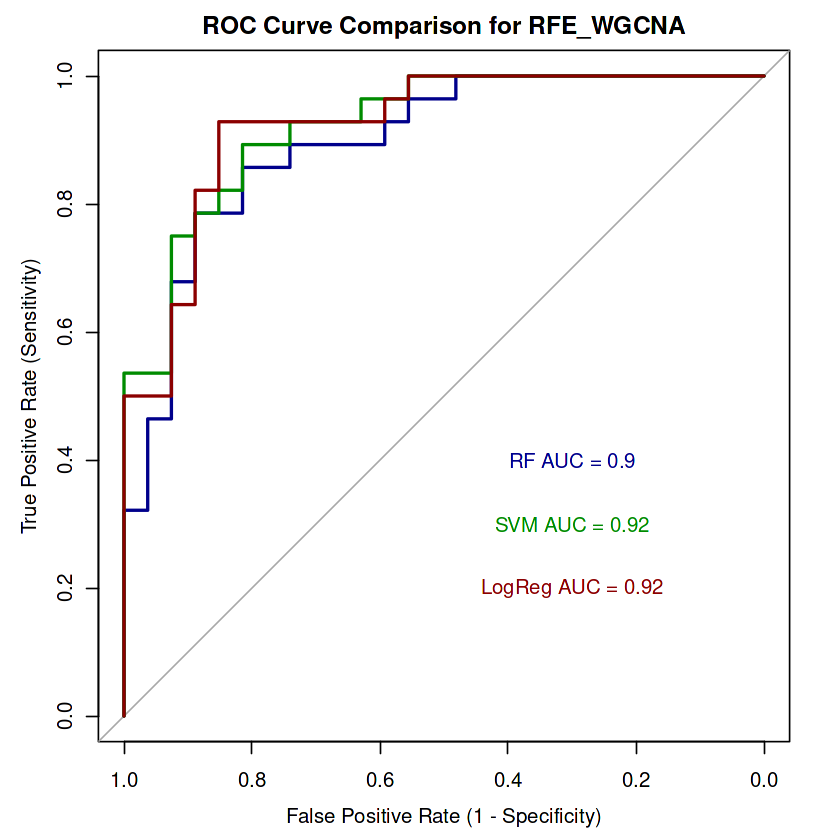

[1] "#####################  ROC AUC  #####################"
[1] "Processing gene list: DGE_manf"
[1] "#####################  RF  #####################"
Confusion Matrix and Statistics

                            Reference
Prediction                   Healthy patient (CONTROL)
  Healthy patient (CONTROL)                         16
  Fibromylagia patient (FMA)                        11
                            Reference
Prediction                   Fibromylagia patient (FMA)
  Healthy patient (CONTROL)                          10
  Fibromylagia patient (FMA)                         18
                                                    
               Accuracy : 0.6182                    
                 95% CI : (0.4773, 0.7459)          
    No Information Rate : 0.5091                    
    P-Value [Acc > NIR] : 0.06848                   
                                                    
                  Kappa : 0.2356                    
                                   

Setting levels: control = Healthy patient (CONTROL), case = Fibromylagia patient (FMA)

Setting direction: controls < cases



[1] "#####################  SVM  #####################"
Confusion Matrix and Statistics

                            Reference
Prediction                   Healthy patient (CONTROL)
  Healthy patient (CONTROL)                         13
  Fibromylagia patient (FMA)                        14
                            Reference
Prediction                   Fibromylagia patient (FMA)
  Healthy patient (CONTROL)                           9
  Fibromylagia patient (FMA)                         19
                                                    
               Accuracy : 0.5818                    
                 95% CI : (0.4411, 0.7135)          
    No Information Rate : 0.5091                    
    P-Value [Acc > NIR] : 0.1726                    
                                                    
                  Kappa : 0.1606                    
                                                    
 Mcnemar's Test P-Value : 0.4042                    
                         

Setting levels: control = Healthy patient (CONTROL), case = Fibromylagia patient (FMA)

Setting direction: controls < cases



[1] "#####################  Logistic regression  #####################"

Call:  cv.glmnet(x = as.matrix(X_train_norm[, genelist]), y = as.vector(unlist(Y_train)),      family = "binomial") 

Measure: Binomial Deviance 

     Lambda Index Measure     SE Nonzero
min 0.03515    23  0.9736 0.1087       9
1se 0.08912    13  1.0675 0.0709       7


Setting levels: control = 0, case = 1

Setting direction: controls < cases



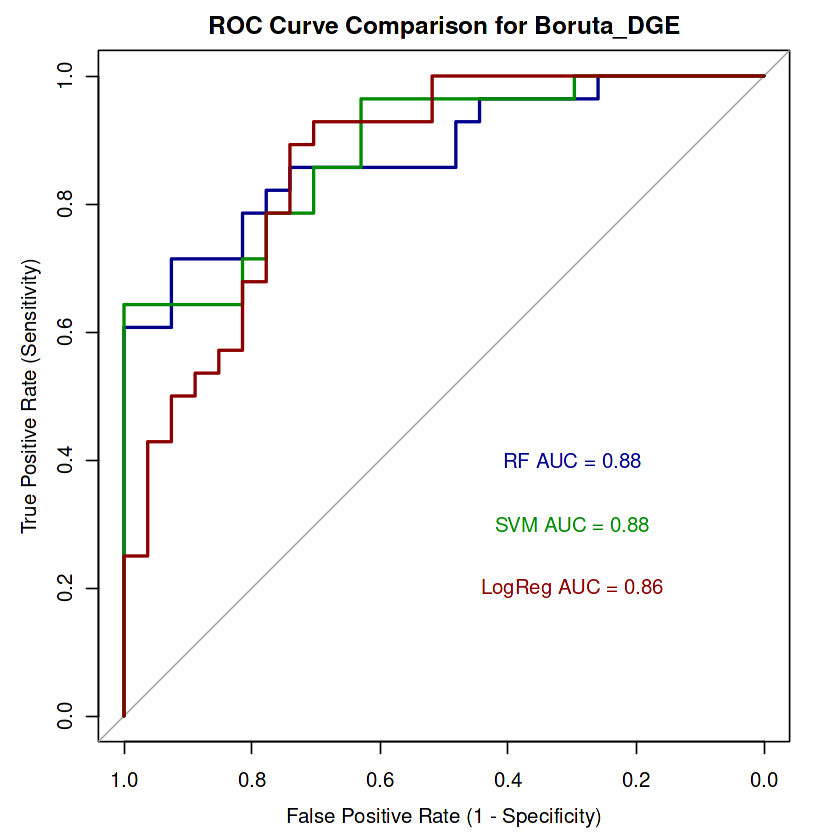

[1] "#####################  ROC AUC  #####################"
[1] "Processing gene list: WGCNA_statsig"
[1] "#####################  RF  #####################"
Confusion Matrix and Statistics

                            Reference
Prediction                   Healthy patient (CONTROL)
  Healthy patient (CONTROL)                         23
  Fibromylagia patient (FMA)                         4
                            Reference
Prediction                   Fibromylagia patient (FMA)
  Healthy patient (CONTROL)                           7
  Fibromylagia patient (FMA)                         21
                                                    
               Accuracy : 0.8                       
                 95% CI : (0.6703, 0.8957)          
    No Information Rate : 0.5091                    
    P-Value [Acc > NIR] : 7.942e-06                 
                                                    
                  Kappa : 0.6007                    
                              

Setting levels: control = Healthy patient (CONTROL), case = Fibromylagia patient (FMA)

Setting direction: controls < cases



[1] "#####################  SVM  #####################"
Confusion Matrix and Statistics

                            Reference
Prediction                   Healthy patient (CONTROL)
  Healthy patient (CONTROL)                         21
  Fibromylagia patient (FMA)                         6
                            Reference
Prediction                   Fibromylagia patient (FMA)
  Healthy patient (CONTROL)                           8
  Fibromylagia patient (FMA)                         20
                                                    
               Accuracy : 0.7455                    
                 95% CI : (0.61, 0.8533)            
    No Information Rate : 0.5091                    
    P-Value [Acc > NIR] : 0.0002924                 
                                                    
                  Kappa : 0.4914                    
                                                    
 Mcnemar's Test P-Value : 0.7892680                 
                         

Setting levels: control = Healthy patient (CONTROL), case = Fibromylagia patient (FMA)

Setting direction: controls < cases



[1] "#####################  Logistic regression  #####################"

Call:  cv.glmnet(x = as.matrix(X_train_norm[, genelist]), y = as.vector(unlist(Y_train)),      family = "binomial") 

Measure: Binomial Deviance 

     Lambda Index Measure      SE Nonzero
min 0.00368    94  0.7167 0.11678      66
1se 0.05996    34  0.8328 0.05166      28


Setting levels: control = 0, case = 1

Setting direction: controls < cases



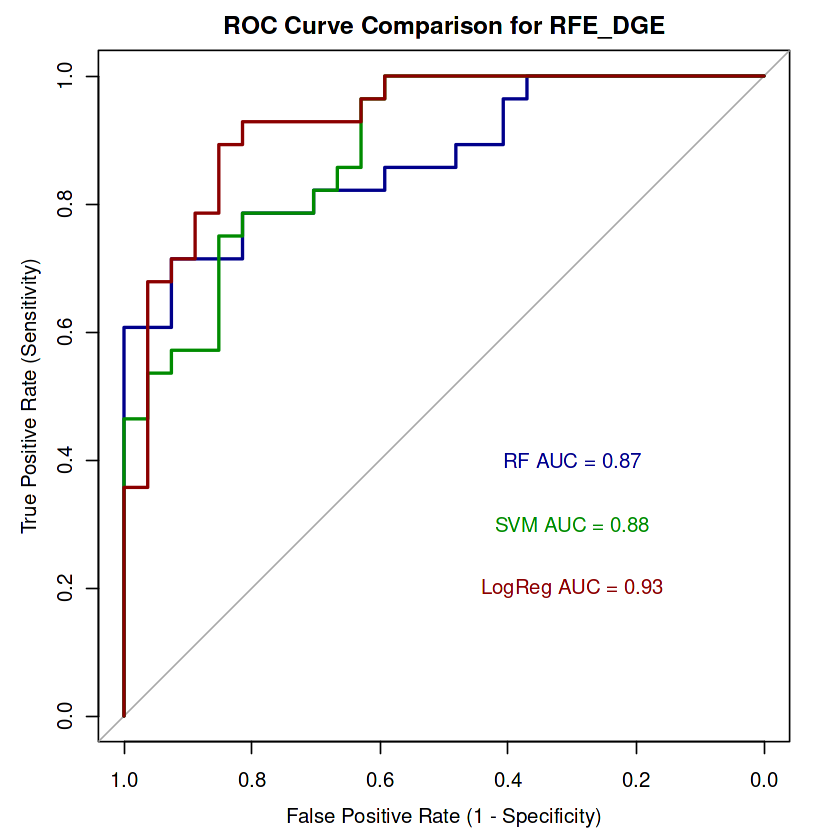

[1] "#####################  ROC AUC  #####################"
[1] "Processing gene list: DGE_statsig"
[1] "#####################  RF  #####################"
Confusion Matrix and Statistics

                            Reference
Prediction                   Healthy patient (CONTROL)
  Healthy patient (CONTROL)                         20
  Fibromylagia patient (FMA)                         7
                            Reference
Prediction                   Fibromylagia patient (FMA)
  Healthy patient (CONTROL)                           7
  Fibromylagia patient (FMA)                         21
                                                    
               Accuracy : 0.7455                    
                 95% CI : (0.61, 0.8533)            
    No Information Rate : 0.5091                    
    P-Value [Acc > NIR] : 0.0002924                 
                                                    
                  Kappa : 0.4907                    
                                

Setting levels: control = Healthy patient (CONTROL), case = Fibromylagia patient (FMA)

Setting direction: controls < cases



[1] "#####################  SVM  #####################"
Confusion Matrix and Statistics

                            Reference
Prediction                   Healthy patient (CONTROL)
  Healthy patient (CONTROL)                         21
  Fibromylagia patient (FMA)                         6
                            Reference
Prediction                   Fibromylagia patient (FMA)
  Healthy patient (CONTROL)                           8
  Fibromylagia patient (FMA)                         20
                                                    
               Accuracy : 0.7455                    
                 95% CI : (0.61, 0.8533)            
    No Information Rate : 0.5091                    
    P-Value [Acc > NIR] : 0.0002924                 
                                                    
                  Kappa : 0.4914                    
                                                    
 Mcnemar's Test P-Value : 0.7892680                 
                         

Setting levels: control = Healthy patient (CONTROL), case = Fibromylagia patient (FMA)

Setting direction: controls < cases



[1] "#####################  Logistic regression  #####################"

Call:  cv.glmnet(x = as.matrix(X_train_norm[, genelist]), y = as.vector(unlist(Y_train)),      family = "binomial") 

Measure: Binomial Deviance 

     Lambda Index Measure      SE Nonzero
min 0.00614    83  0.6881 0.09563      56
1se 0.03275    47  0.7827 0.06026      41


Setting levels: control = 0, case = 1

Setting direction: controls < cases



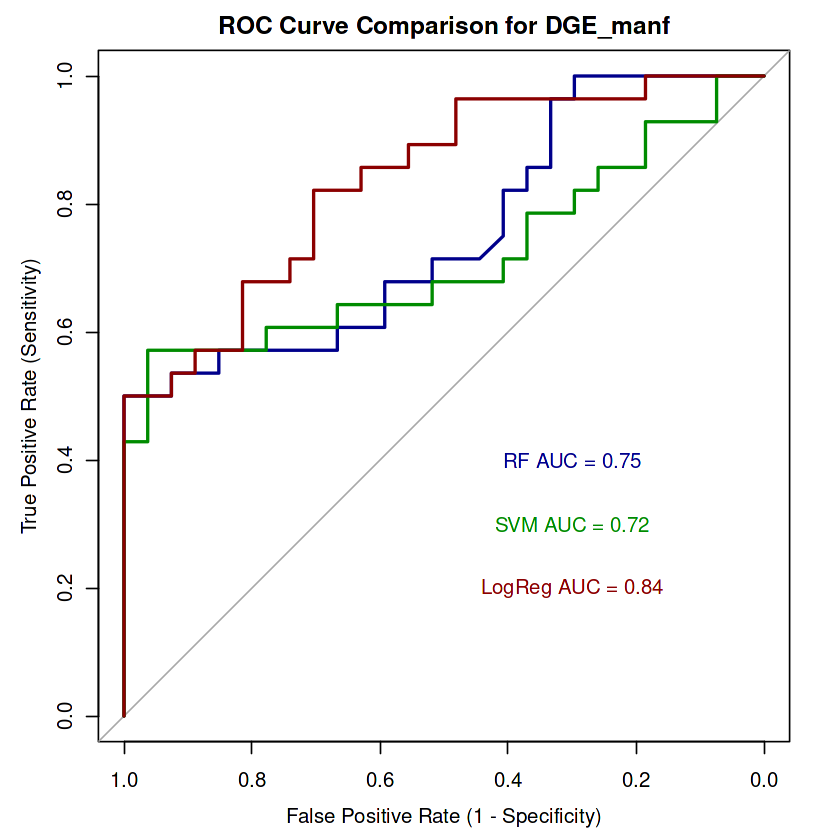

[1] "#####################  ROC AUC  #####################"


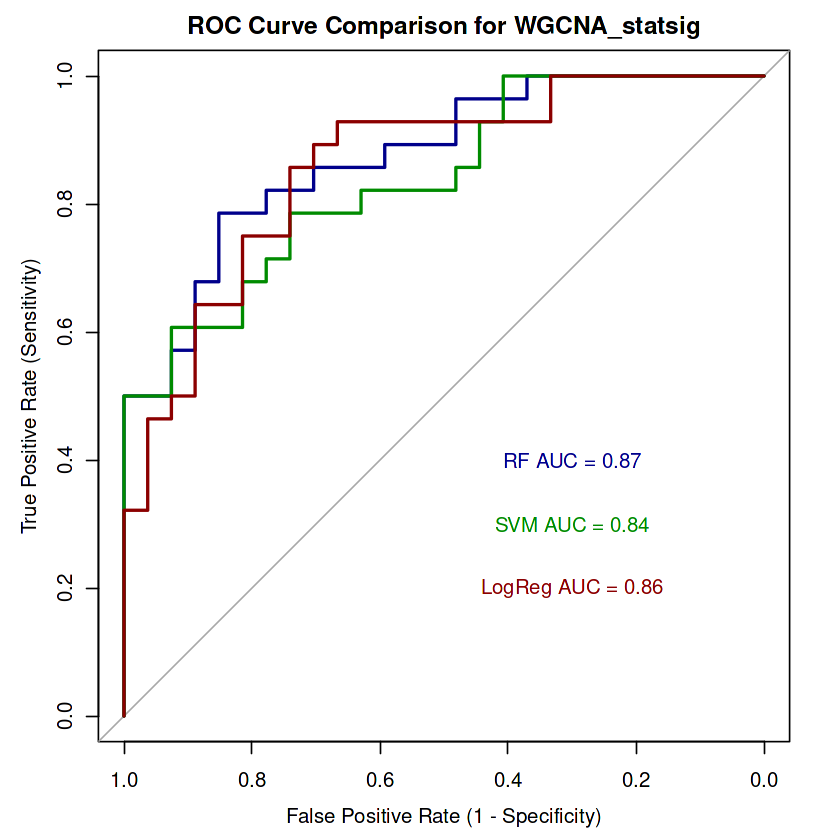

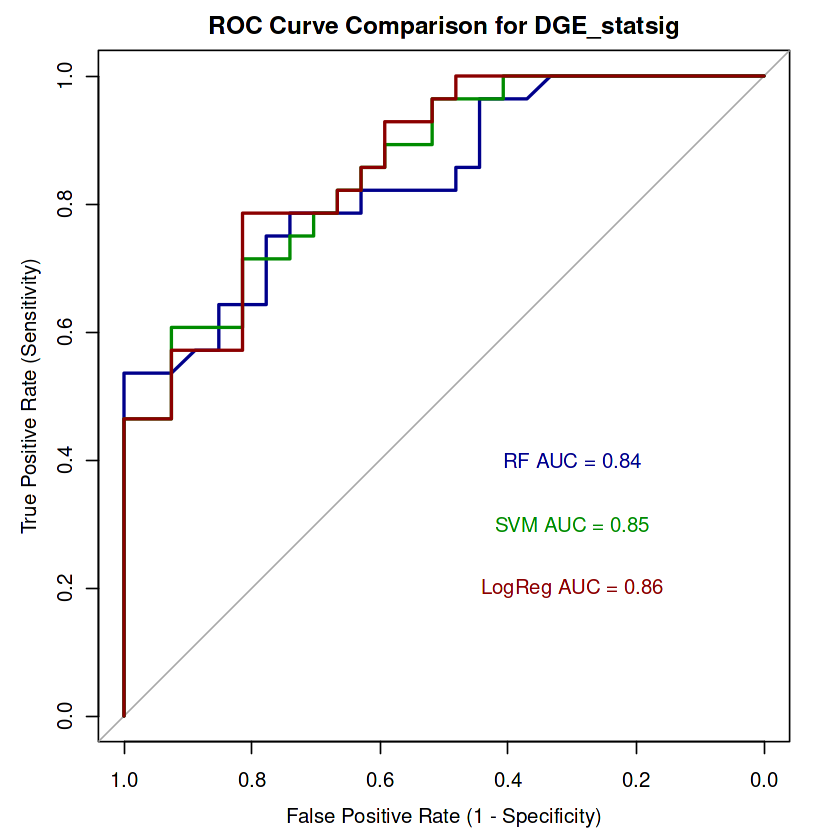

In [ ]:
### Fitting and testing binomial classification models

set.seed(123)

genelists <- list(
    Boruta_WGCNA = as.character(qread("/kaggle/working/Boruta_WGCNA_FM_1.qs")),
    RFE_WGCNA = qread("/kaggle/working/RFE_WGCNA_FM_1.qs"),
    Boruta_DGE = as.character(qread("/kaggle/working/Boruta_DGE_FM_1.qs")),
    RFE_DGE = qread("/kaggle/working/RFE_DGE_FM_1.qs"),
    DGE_manf = DGE_gid_manf_FM_1_wsex,
    WGCNA_statsig = WGCNA_gid_FM_1_wsex,
    DGE_statsig = DGE_gid_FM_1_wsex
  )

for (genelist_name in names(genelists)) {
    print(paste("Processing gene list:", genelist_name))
    genelist <- genelists[[genelist_name]]

    print("#####################  RF  #####################")

    rf_model <- randomForest(
      x = X_train_norm[, genelist],
      y = Y_train_as_factor,
      ntree = 1501,
      importance = TRUE,
      classwt = class_weights_fact,
      mtry = floor(sqrt(length(genelist)))
    )
    pred_rf <- predict(rf_model, X_test_norm[, genelist])

    confusion_rf <- confusionMatrix(pred_rf, Y_test_as_factor, positive = "Fibromylagia patient (FMA)") ##### !!!
    print(confusion_rf)

    feature_importance_rf <- as.data.frame(importance(rf_model))
    feature_importance_rf$Feature <- rownames(feature_importance_rf)
    qsave(feature_importance_rf, paste0(genelist_name,"_feature_importance_rf.qs"))

    pred_rf_prob <- predict(rf_model, X_test_norm[, genelist], type = "prob")
    positive_class_index <- 2                                                      ################### !!!
    pred_prob_positive_class <- pred_rf_prob[, positive_class_index]
    roc_rf <- roc(Y_test_as_factor, pred_prob_positive_class)
    qsave(roc_rf, paste0(genelist_name,"_roc_rf.qs"))

    print("#####################  SVM  #####################")

    svm_tuned <- tune(svm,
      Y_train_as_factor ~ .,
      data = data.frame(Y_train_as_factor = Y_train_as_factor, X_train_norm[, genelist], check.names = FALSE),
      kernel = "radial",
      type = "C-classification",
      ranges = list(cost = c(0.01, 0.1, 1, 10, 50, 100),
                    gamma = c(1 / length(genelist), 0.001, 0.01, 0.1, 1, 10)),
      class.weights = class_weights_fact,
      tunecontrol = tune.control(cross = 10)
    )

    # plot(svm_tuned)
    summary(svm_tuned)
    best_model_svm <- svm_tuned$best.model

    pred_svm <- predict(best_model_svm, X_test_norm[, genelist])
    confusion_svm <- confusionMatrix(pred_svm, Y_test_as_factor, positive = "Fibromylagia patient (FMA)") ##### !!!!
    print(confusion_svm)

    pred_svm_prob <- predict(best_model_svm, X_test_norm[, genelist], decision.values = TRUE)
    pred_prob_svm <- attributes(pred_svm_prob)$decision.values
    roc_svm <- roc(Y_test_as_factor, as.numeric(pred_prob_svm))
    qsave(roc_svm, paste0(genelist_name,"_roc_svm.qs"))


    print("#####################  Logistic regression  #####################")

    cvfit <- cv.glmnet(as.matrix(X_train_norm[, genelist]), as.vector(unlist(Y_train)), family = "binomial")

    # plot(cvfit)
    print(cvfit)

    coef_at_min <- coef(cvfit, s = "lambda.min")
    nonzero_coef_1 <- extract.coef(cvfit)
    genelist_nonzero_coef_1 <- rownames(nonzero_coef_1)[-1]

    head(nonzero_coef_1)
    qsave(nonzero_coef_1, paste0(genelist_name,"_nonzero_coef_logreg.qs"))

    prediction_test <- predict(cvfit, newx = as.matrix(X_test_norm[, genelist]), family = "binomial", s = "lambda.min", type='response')
    prediction_test_measures <- assess.glmnet(cvfit, newx = as.matrix(X_test_norm[, genelist]), newy = as.vector(unlist(Y_test)), family = "binomial", s = "lambda.min")
    prediction_test_measures

    roc_logreg <- roc(as.vector(unlist(Y_test)), c(prediction_test))
    qsave(roc_logreg, paste0(genelist_name,"_roc_logreg.qs"))


    print("#####################  ROC AUC  #####################")

    plot(roc_rf, col = "blue4", print.auc = FALSE,
         xlab = "False Positive Rate (1 - Specificity)",
         ylab = "True Positive Rate (Sensitivity)",
         main = paste0("ROC Curve Comparison for ", genelist_name))
    rf_auc_text <- paste("RF AUC =", round(auc(roc_rf), 2))
    text(x = 0.3, y = 0.4, labels = rf_auc_text, col = "blue4")

    plot(roc_svm, col = "green4", print.auc = FALSE, add = TRUE)
    svm_auc_text <- paste("SVM AUC =", round(auc(roc_svm), 2))
    text(x = 0.3, y = 0.3, labels = svm_auc_text, col = "green4")

    plot(roc_logreg, col = "red4", print.auc = FALSE, add = TRUE)
    logreg_auc_text <- paste("LogReg AUC =", round(auc(roc_logreg), 2))
    text(x = 0.3, y = 0.2, labels = logreg_auc_text, col = "red4")
}

# Multinoomial classification

## FM_2 subgroups

In [ ]:
### Uploading train and test expression (X) data

df_train <- qread("/kaggle/input/dge-wgcna-res/gse_train_FM_2.qs")
df_test <- qread("/kaggle/input/dge-wgcna-res/gse_test_FM_2.qs")

train <- as.data.frame(t(exprs(df_train)))
test <- as.data.frame(t(exprs(df_test)))

In [ ]:
### listing all posible combinations of COPCs

subroups_info <- pData(df_train)
subroups_info$IBS <- ifelse(subroups_info[, "irritable bowel syndrome:ch1", ] == "Yes", "IBS", "")
subroups_info$CFS <- ifelse(subroups_info[, "chronic fatigue syndrome:ch1", ] == "Yes", "CBS", "")
subroups_info$migrane <- ifelse(subroups_info[, "migraine:ch1", ] == "Yes", "migrane", "")
subroups_info$FM <- ifelse(subroups_info[, "diagnosis:ch1", ] == "healthy control", "", "FM")

subroups_info$interactions <- interaction(subroups_info$FM,
                                          subroups_info$CFS,
                                          subroups_info$IBS,
                                          subroups_info$migrane,
                                          sep = "-", drop = FALSE)

interaction_table <- table(subroups_info$interactions)
interaction_table
subroups_info$subgroups <- subroups_info$interactions


               ---              FM---             -CBS--           FM-CBS-- 
                42                  7                  0                  4 
            --IBS-           FM--IBS-          -CBS-IBS-        FM-CBS-IBS- 
                 2                 10                  0                  2 
        ---migrane       FM---migrane      -CBS--migrane    FM-CBS--migrane 
                 5                 10                  0                  2 
     --IBS-migrane    FM--IBS-migrane   -CBS-IBS-migrane FM-CBS-IBS-migrane 
                 1                 10                  0                  1 

In [ ]:
### Creating apropriate supergroups

subroups_info$subgroups <- subroups_info$interactions
subroups_info <- subroups_info %>%
  mutate(subgroups = case_when(
    subgroups %in% c("---") ~ "healthy",
    subgroups %in% c("--IBS-", "---migrane", "--IBS-migrane") ~ "other COPC (IBS, migrane)",
    subgroups %in% c("FM---") ~ "FM only",
    subgroups %in% c("FM--IBS-", "FM---migrane", "FM--IBS-migrane") ~ "FM + other COPC (CFS exc.)",
    subgroups %in% c("FM-CBS--", "FM-CBS-IBS-", "FM-CBS--migrane", "FM-CBS-IBS-migrane") ~ "FM + other COPC (CFS inc.)",
    TRUE ~ subgroups
  ))
unique(subroups_info$subgroups)

[1] "healthy"                    "other COPC (IBS, migrane)" 
[3] "FM + other COPC (CFS exc.)" "FM only"                   
[5] "FM + other COPC (CFS inc.)"

Warning message:
“Removed 96 rows containing missing values or values outside the scale range
(`geom_text()`).”


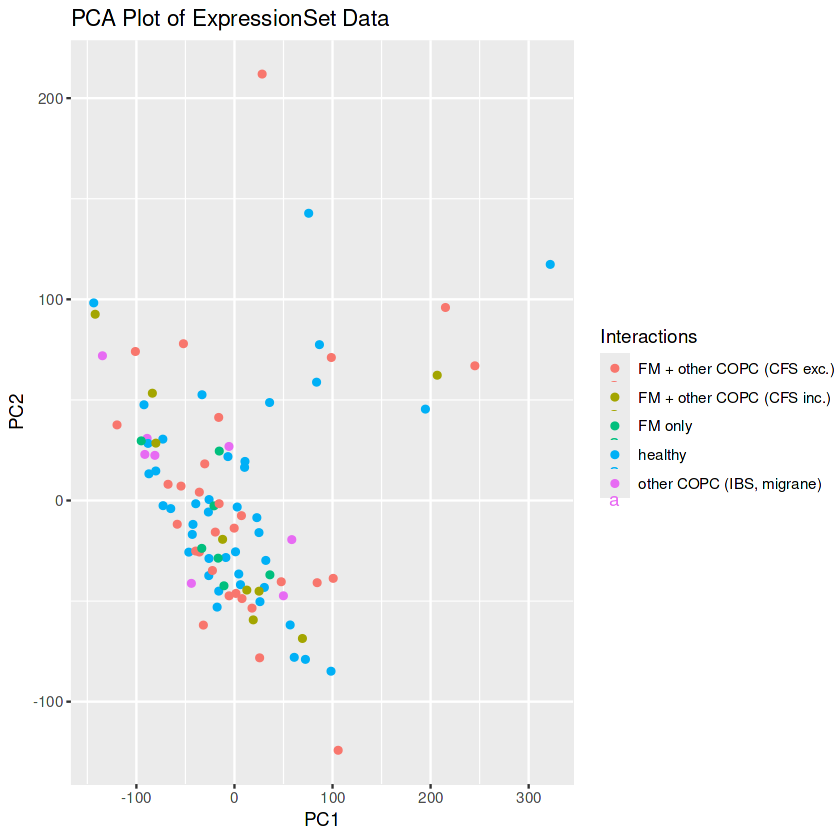

In [ ]:
### PCA plots to visualise classes separations: BEFORE normalisation

pca <- prcomp(train, scale. = TRUE)
pca_df <- data.frame(PC1 = pca$x[,1], PC2 = pca$x[,2], Sample = rownames(train))

ggplot(pca_df, aes(x = PC1, y = PC2, label=NA, color = subroups_info$subgroups)) +
  geom_point() +
  geom_text(vjust = -1) +
  labs(title = "PCA Plot of ExpressionSet Data") +
  scale_color_discrete(name = "Interactions")

In [ ]:
### Building same supergroups for test samples

test_subroups_info <- pData(df_test)

test_subroups_info$IBS <- ifelse(test_subroups_info[, "irritable bowel syndrome:ch1", ] == "Yes", "IBS", "")
test_subroups_info$CFS <- ifelse(test_subroups_info[, "chronic fatigue syndrome:ch1", ] == "Yes", "CBS", "")
test_subroups_info$migrane <- ifelse(test_subroups_info[, "migraine:ch1", ] == "Yes", "migrane", "")
test_subroups_info$FM <- ifelse(test_subroups_info[, "diagnosis:ch1", ] == "healthy control", "", "FM")


test_subroups_info$interactions <- interaction(test_subroups_info$FM,
                                          test_subroups_info$CFS,
                                          test_subroups_info$IBS,
                                          test_subroups_info$migrane,
                                          sep = "-", drop = FALSE)


interaction_table <- table(test_subroups_info$interactions)
interaction_table
test_subroups_info$subgroups <- test_subroups_info$interactions


               ---              FM---             -CBS--           FM-CBS-- 
                17                  3                  0                  1 
            --IBS-           FM--IBS-          -CBS-IBS-        FM-CBS-IBS- 
                 0                  3                  0                  0 
        ---migrane       FM---migrane      -CBS--migrane    FM-CBS--migrane 
                 1                  3                  0                  0 
     --IBS-migrane    FM--IBS-migrane   -CBS-IBS-migrane FM-CBS-IBS-migrane 
                 0                  4                  0                  0 

In [ ]:
test_subroups_info <- test_subroups_info %>%
  mutate(subgroups = case_when(
    subgroups %in% c("---") ~ "healthy",
    subgroups %in% c("--IBS-", "---migrane", "--IBS-migrane") ~ "other COPC (IBS, migrane)",
    subgroups %in% c("FM---") ~ "FM only",
    subgroups %in% c("FM--IBS-", "FM---migrane", "FM--IBS-migrane") ~ "FM + other COPC (CFS exc.)",
    subgroups %in% c("FM-CBS--", "FM-CBS-IBS-", "FM-CBS--migrane", "FM-CBS-IBS-migrane") ~ "FM + other COPC (CFS inc.)",
    TRUE ~ subgroups
  ))

unique(test_subroups_info$subgroups)

[1] "healthy"                    "other COPC (IBS, migrane)" 
[3] "FM + other COPC (CFS exc.)" "FM only"                   
[5] "FM + other COPC (CFS inc.)"

In [ ]:
### Upoading genesets yielded best performance for FM_1 and CFS_1-4 datasets

RFE_DGE_FM_1 <- qread("/kaggle/working/RFE_DGE_FM_1.qs")
RFE_WGCNA_FM_1 <- qread("/kaggle/working/RFE_WGCNA_FM_1.qs")
RFE_DGE_CFS_2 <- qread("/kaggle/working/RFE_DGE_CFS_2.qs")
RFE_WGCNA_CFS_2 <- qread("/kaggle/working/RFE_WGCNA_CFS_2.qs")

dge_res <- qread("/kaggle/input/dge-wgcna-res/DGE_CFS_1_res_annot.qs")
DGE_genes_manf_CFS_1 <- dge_res[dge_res$gene_name != '' &
                               dge_res$pvalue < 0.001 &
                               dge_res$padj < 0.5, ]$gene_name

DGE_gid_manf_CFS_1 <- dge_res[dge_res$gene_name != '' &
                               dge_res$pvalue < 0.001 &
                               dge_res$padj < 0.5, ]$gene_id


In [ ]:
### Uploading statistically significant DGE analysis results for FM_2

dge_res <- qread("/kaggle/input/dge-wgcna-res/DGE_FM_2_res_annot.qs")
DGE_genes_manf_FM_2 <- dge_res[!is.na(dge_res$SYMBOL) &
                               dge_res$`P.Value` < 0.001 &
                               dge_res$`adj.P.Val` < 0.5, ]$SYMBOL

DGE_gid_manf_FM_2 <- dge_res[!is.na(dge_res$SYMBOL) &
                               dge_res$`P.Value` < 0.001 &
                               dge_res$`adj.P.Val` < 0.5, ]$PROBEID

In [ ]:
### Removing sex columns (since CFS_4 dont have this info)
RFE_WGCNA_FM_1 <- RFE_WGCNA_FM_1[RFE_WGCNA_FM_1 != "sex"]
RFE_DGE_FM_1 <- RFE_DGE_FM_1[RFE_DGE_FM_1 != "sex"]
RFE_DGE_CFS_2 <- RFE_DGE_CFS_2[RFE_DGE_CFS_2 != "sex"]
Boruta_DGE_CFS_4 <- as.character(Boruta_DGE_CFS_4)
RFE_WGCNA_FM_2_genenames <- unique(fData(df_train)[RFE_WGCNA_FM_2, ]$SYMBOL)

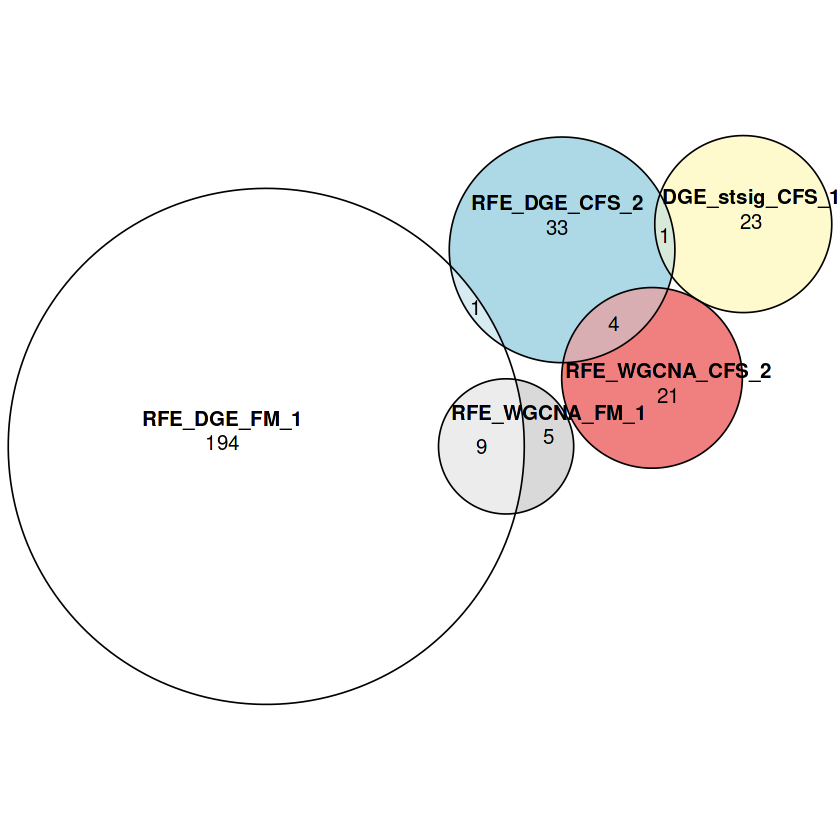

In [ ]:
venn_list <- list(
    RFE_DGE_FM_1 = RFE_DGE_FM_1,
    RFE_WGCNA_FM_1 = RFE_WGCNA_FM_1,
    RFE_DGE_CFS_2 = RFE_DGE_CFS_2,
    RFE_WGCNA_CFS_2 = RFE_WGCNA_CFS_2,
    DGE_stsig_CFS_1 = DGE_gid_manf_CFS_1
)

fit1 <- euler(venn_list)
venn <- plot(fit1, quantities = TRUE)
print(venn)

In [ ]:
### All valuable genes combined from FM_1 and CFS_1-4

combined_for_FM_2 <- unique(c(RFE_DGE_FM_1, RFE_WGCNA_FM_1, RFE_DGE_CFS_2, RFE_WGCNA_CFS_2, DGE_gid_manf_CFS_1))
length(combined_for_FM_2)

[1] 291

In [ ]:
### First combined_for_FM_2 filtration, removing gene ids that don't have corresponding gene names in FM_1 and CFS_1-4

df <- qread("/kaggle/input/dge-wgcna-res/gse_train_FM_1.qs")
df <- rowData(df)[combined_for_FM_2, ]
combined_for_FM_2_genenames <- unique(df$gene_name)
length(combined_for_FM_2_genenames)

[1] 290

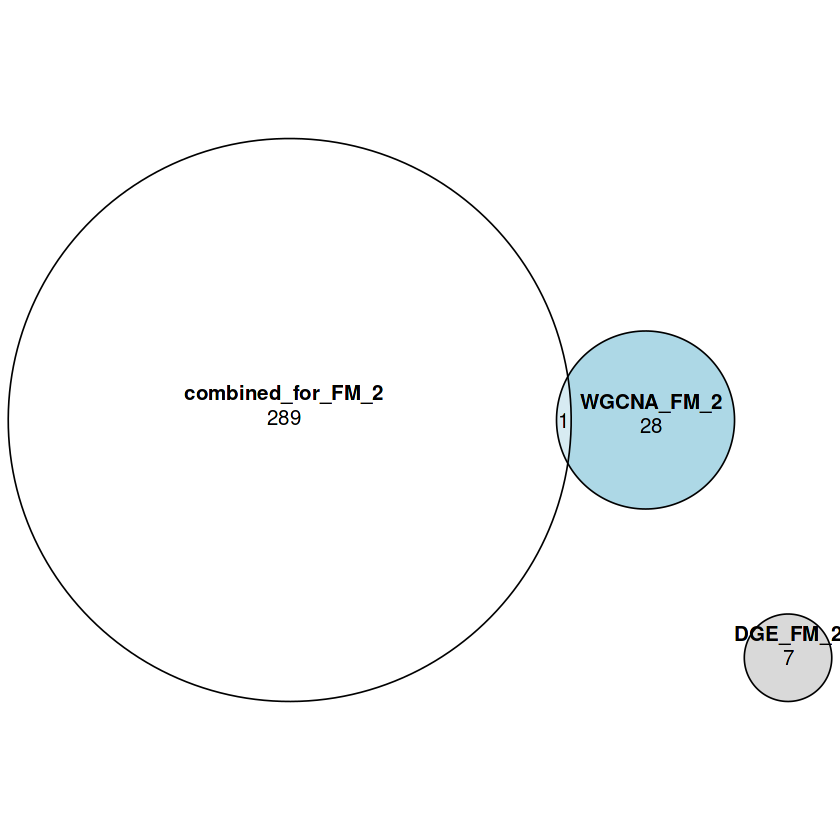

In [ ]:
venn_list <- list(
    combined_for_FM_2 = combined_for_FM_2_genenames,
    DGE_FM_2 = DGE_genes_manf_FM_2,
    WGCNA_FM_2 = RFE_WGCNA_FM_2_genenames
)

fit1 <- euler(venn_list)
venn <- plot(fit1, quantities = TRUE)
print(venn)

In [ ]:
### Add FM_2 selected genes to combined_for_FM_2
FM_2_full_genelist <- unique(c(combined_for_FM_2_genenames, DGE_genes_manf_FM_2, RFE_WGCNA_FM_2_genenames))
length(FM_2_full_genelist)
df_train_all_genes <- unique(fData(df_train)$SYMBOL)
FM_2_genelist <- intersect(df_train_all_genes, FM_2_full_genelist)
length(FM_2_genelist)

[1] 19999

[1] 300

In [ ]:
### Converting gene names to gene IDs
gene_ids_all <- fData(df_train)
gene_ids_all <- gene_ids_all[gene_ids_all$SYMBOL %in% FM_2_genelist, ]$PROBEID
length(gene_ids_all)

[1] 340

In [ ]:
### Uploading train and test expression (X) and phenotype data (Y)
### Converting disease condition study to vector with levels

train <- as.data.frame(t(exprs(df_train)))
test <- as.data.frame(t(exprs(df_test)))

X_train <- train %>% dplyr::select(all_of(gene_ids_all))
X_test <- test %>% dplyr::select(all_of(gene_ids_all))

levels <- c("healthy", 'other COPC (IBS, migrane)', "FM only", "FM + other COPC (CFS exc.)", 'FM + other COPC (CFS inc.)')
Y_train_as_factor <- factor(subroups_info$subgroups, levels=levels)
Y_test_as_factor <- factor(test_subroups_info$subgroups, levels=levels)


In [ ]:
### Train data log standartisation

X_train_norm <- log(X_train + 1)
mean_values <- colMeans(X_train_norm)
std_values <- apply(X_train_norm, 2, sd)
X_train_norm <- scale(X_train_norm, center = mean_values, scale = std_values)
X_train_norm <- as.data.frame(X_train_norm)

### Applying mean and SD calculated for train data on test data

X_test_norm <- log(X_test + 1)
X_test_norm <- scale(X_test_norm, center = mean_values, scale = std_values)
X_test_norm <- as.data.frame(X_test_norm)

Warning message:
“Removed 96 rows containing missing values or values outside the scale range
(`geom_text()`).”


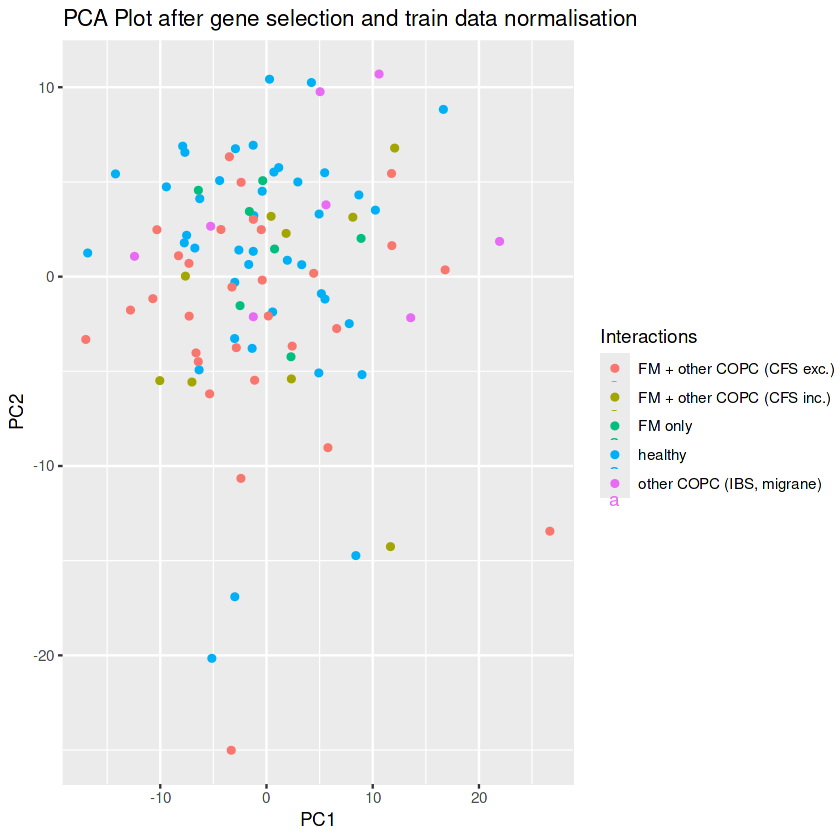

In [ ]:
### PCA plots to visualise classes separations: AFTER normalisation

pca <- prcomp(X_train_norm, scale. = TRUE)
pca_df <- data.frame(PC1 = pca$x[,1], PC2 = pca$x[,2], Sample = rownames(train))

ggplot(pca_df, aes(x = PC1, y = PC2, label=NA, color = subroups_info$subgroups)) +
  geom_point() +
  geom_text(vjust = -1) +
  labs(title = "PCA Plot after gene selection and train data normalisation") +
  scale_color_discrete(name = "Interactions")

In [ ]:
### Feature filtration using RFE and Boruta

set.seed(123)

GIDs <- list(FM_2_multi = gene_ids_all)
for (genelist_name in names(GIDs)) {
    print(paste("Processing gene list:", genelist_name))

    GID <- GIDs[[genelist_name]]

    X_train_norm_1 <- X_train_norm %>% dplyr::select(all_of(GID))

    # RFE (Recursive Feature Elimination)
    control <- rfeControl(functions = rfFuncs,  # using random forest for feature ranking
                          method = "repeatedcv",
                          number = 10,  # 10-fold cross-validation
                          repeats = 3)
    rfe_results <- rfe(
      x = X_train_norm_1,
      y = Y_train_as_factor,
      sizes = seq(5, min(105, ncol(X_train_norm_1)), by = 5), # Ensure 'sizes' doesn't exceed number of features
      rfeControl = control
    )

    print(rfe_results)
    qsave(rfe_results, file = paste0("RFE_res_", genelist_name, ".qs"))
    genelist_rfe_predict <- predictors(rfe_results)
    length(genelist_rfe_predict)
    qsave(genelist_rfe_predict, file = paste0("RFE_", genelist_name, ".qs"))

    # Boruta

    boruta_data <- data.frame(Y_train_as_factor = Y_train_as_factor, X_train_norm_1, check.names = FALSE)
    names(boruta_data) <- make.names(names(boruta_data))
    boruta_formula <- as.formula("Y_train_as_factor ~ .")

    boruta_results <- Boruta(
      formula = boruta_formula,
      data = boruta_data,
      doTrace = 2
    )
    boruta_final <- TentativeRoughFix(boruta_results)
    print(boruta_final)
    selected_features <- getSelectedAttributes(boruta_final, withTentative = FALSE)

    selected_features <- lapply(selected_features, function(x) str_remove(x, "^X"))
    qsave(selected_features, file = paste0("Boruta_", genelist_name, ".qs"))
}

[1] "Processing gene list: FM_2_multi"

Recursive feature selection

Outer resampling method: Cross-Validated (10 fold, repeated 3 times) 

Resampling performance over subset size:

 Variables Accuracy  Kappa AccuracySD KappaSD Selected
         5   0.4956 0.1908    0.12586  0.2214         
        10   0.4781 0.1665    0.14797  0.2328         
        15   0.5299 0.2409    0.13073  0.2142        *
        20   0.5072 0.2041    0.11817  0.1900         
        25   0.5072 0.2017    0.12172  0.1956         
        30   0.5109 0.2019    0.10456  0.1706         
        35   0.5169 0.2141    0.11292  0.1843         
        40   0.5021 0.1893    0.11168  0.1834         
        45   0.5098 0.1989    0.10164  0.1685         
        50   0.5124 0.2008    0.10708  0.1817         
        55   0.5051 0.1939    0.11177  0.1828         
        60   0.5226 0.2162    0.11521  0.1922         
        65   0.5021 0.1865    0.10398  0.1711         
        70   0.5154 0.2069    0.11429  0.1941   

 1. run of importance source...

 2. run of importance source...

 3. run of importance source...

 4. run of importance source...

 5. run of importance source...

 6. run of importance source...

 7. run of importance source...

 8. run of importance source...

 9. run of importance source...

 10. run of importance source...

 11. run of importance source...

 12. run of importance source...

 13. run of importance source...

 14. run of importance source...

 15. run of importance source...

 16. run of importance source...

After 16 iterations, +2.9 secs: 

 confirmed 1 attribute: X8122807;

 rejected 312 attributes: X7898799, X7898805, X7900699, X7900922, X7902043 and 307 more;

 still have 27 attributes left.


 17. run of importance source...

 18. run of importance source...

 19. run of importance source...

 20. run of importance source...

After 20 iterations, +3.2 secs: 

 confirmed 2 attributes: X8083260, X8122071;

 rejected 7 attributes: X7970696, X8003467, X8026954, X8

Boruta performed 99 iterations in 7.740583 secs.
Tentatives roughfixed over the last 99 iterations.
 14 attributes confirmed important: X7901376, X7911199, X7936734,
X7988672, X7999889 and 9 more;
 326 attributes confirmed unimportant: X7898799, X7898805, X7900699,
X7900922, X7902043 and 321 more;


Warning message:
“Removed 96 rows containing missing values or values outside the scale range
(`geom_text()`).”
Warning message:
“Removed 96 rows containing missing values or values outside the scale range
(`geom_text()`).”


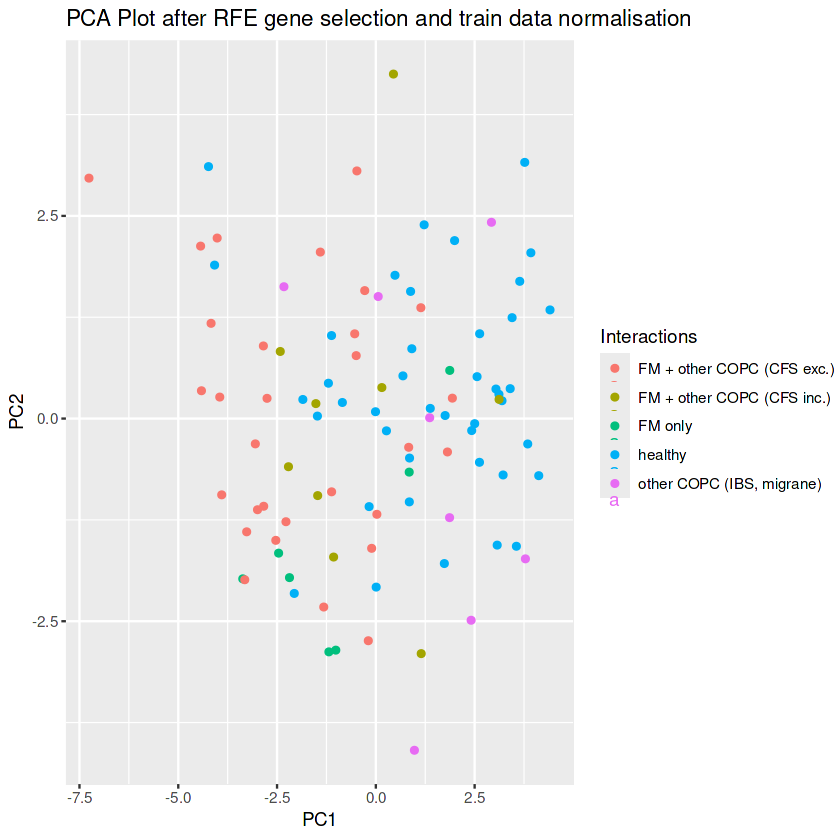

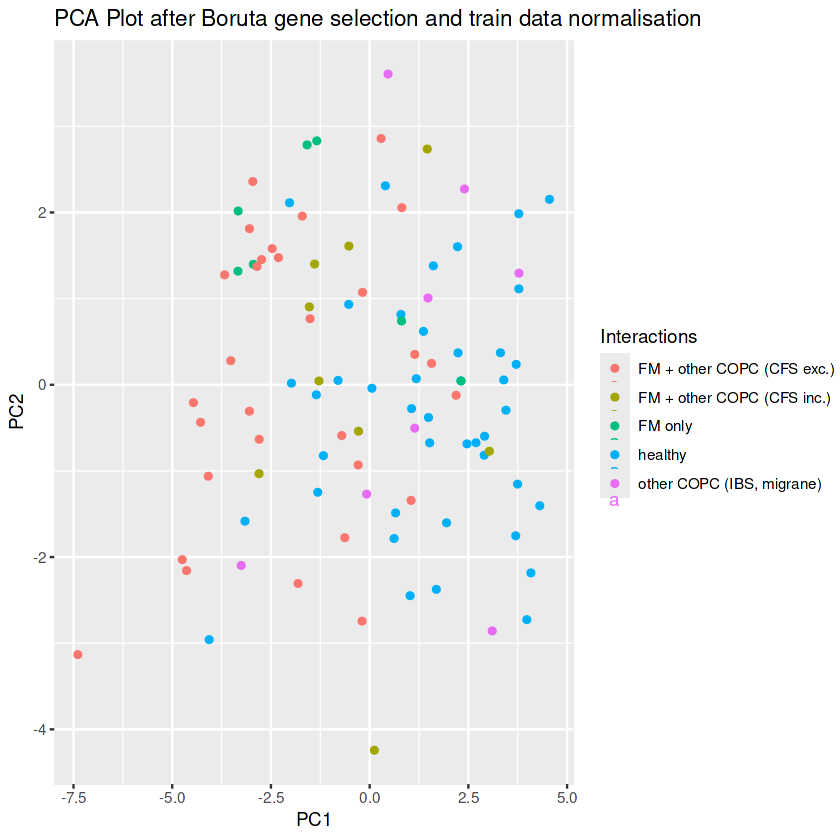

In [ ]:
### PCA plots on RFE and Boruta selected features

pca <- prcomp(X_train_norm %>% dplyr::select(all_of(genelist_rfe_predict)), scale. = TRUE)
pca_df <- data.frame(PC1 = pca$x[,1], PC2 = pca$x[,2], Sample = rownames(train))

ggplot(pca_df, aes(x = PC1, y = PC2, label=NA, color = subroups_info$subgroups)) +
  geom_point() +
  geom_text(vjust = -1) +
  labs(title = "PCA Plot after RFE gene selection and train data normalisation") +
  scale_color_discrete(name = "Interactions")

pca <- prcomp(X_train_norm %>% dplyr::select(all_of(as.character(selected_features))), scale. = TRUE)
pca_df <- data.frame(PC1 = pca$x[,1], PC2 = pca$x[,2], Sample = rownames(train))

ggplot(pca_df, aes(x = PC1, y = PC2, label=NA, color = subroups_info$subgroups)) +
  geom_point() +
  geom_text(vjust = -1) +
  labs(title = "PCA Plot after Boruta gene selection and train data normalisation") +
  scale_color_discrete(name = "Interactions")

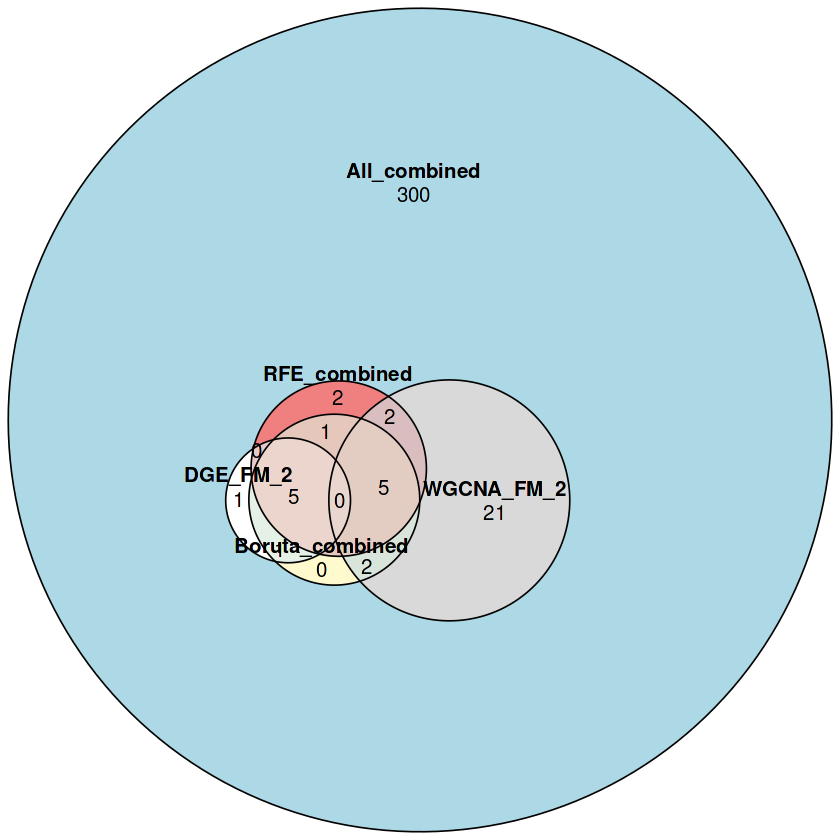

In [ ]:
venn_list <- list(
    DGE_FM_2 = DGE_gid_manf_FM_2,
    WGCNA_FM_2 = RFE_WGCNA_FM_2,
    # All_combined = gene_ids_all,
    RFE_combined = genelist_rfe_predict,
    Boruta_combined = as.character(selected_features)
)

fit1 <- euler(venn_list)
venn <- plot(fit1, quantities = TRUE, legend=TRUE)
print(venn)

In [ ]:
### Converting disease condition study to vector with levels AND numeric values

unique_values <- unique(Y_train_as_factor)
unique_values ################# dont look at levels!
manual_mapping <- c(1, 2, 4, 3, 5)
names(manual_mapping) <- unique_values
Y_train_as_numeric <- as.numeric(manual_mapping[Y_train_as_factor])

unique_values <- unique(Y_test_as_factor)
unique_values
Y_test_as_numeric <- as.numeric(manual_mapping[Y_test_as_factor])

reverse_mapping <- setNames(names(manual_mapping), manual_mapping)

[1] healthy                    other COPC (IBS, migrane) 
[3] FM + other COPC (CFS exc.) FM only                   
[5] FM + other COPC (CFS inc.)
5 Levels: healthy other COPC (IBS, migrane) ... FM + other COPC (CFS inc.)

[1] healthy                    other COPC (IBS, migrane) 
[3] FM + other COPC (CFS exc.) FM only                   
[5] FM + other COPC (CFS inc.)
5 Levels: healthy other COPC (IBS, migrane) ... FM + other COPC (CFS inc.)

In [ ]:
class_counts <- table(Y_train_as_factor)
total_samples <- sum(class_counts)
num_classes <- length(class_counts)
class_weights_fact <- total_samples / (num_classes * class_counts)

### additional weights with numbers as classes for logreg
weights_for_logreg <- as.numeric(class_weights_fact[as.character(Y_train_as_factor)])

[1] "------------------------------- Processing gene list: DGE_FM_2 -------------------------------"
[1] "#####################  RF  #####################"
Confusion Matrix and Statistics

                            Reference
Prediction                   healthy other COPC (IBS, migrane) FM only
  healthy                         10                         1       3
  other COPC (IBS, migrane)        0                         0       0
  FM only                          2                         0       0
  FM + other COPC (CFS exc.)       5                         0       0
  FM + other COPC (CFS inc.)       0                         0       0
                            Reference
Prediction                   FM + other COPC (CFS exc.)
  healthy                                             4
  other COPC (IBS, migrane)                           0
  FM only                                             1
  FM + other COPC (CFS exc.)                          5
  FM + other COPC (CFS inc.) 

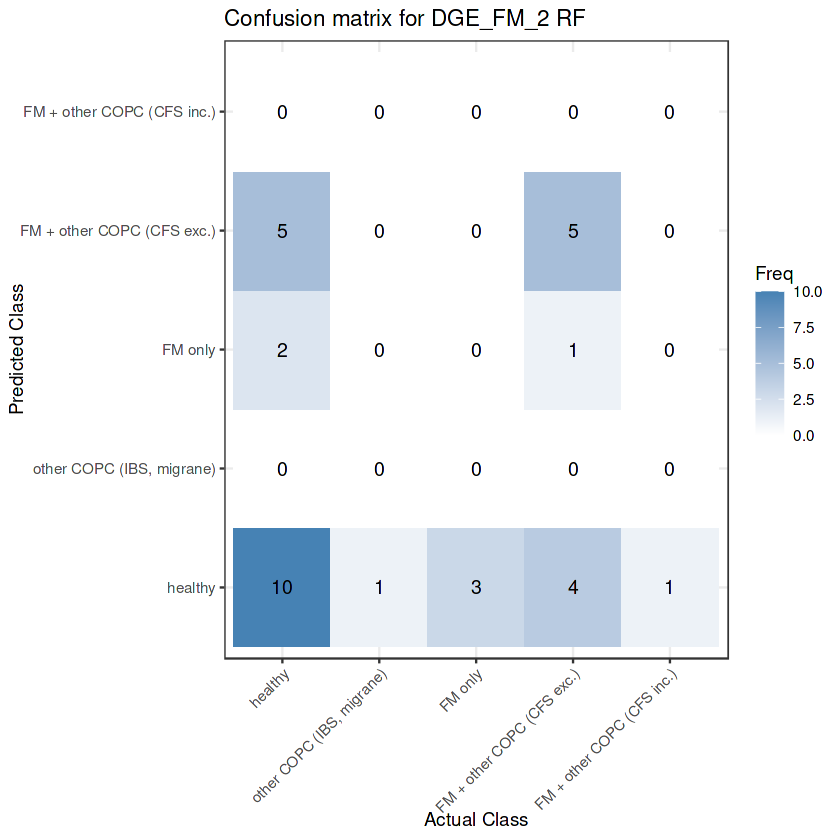

[1] "#####################  LDA  #####################"
Confusion Matrix and Statistics

                            Reference
Prediction                   healthy other COPC (IBS, migrane) FM only
  healthy                          9                         1       3
  other COPC (IBS, migrane)        0                         0       0
  FM only                          8                         0       0
  FM + other COPC (CFS exc.)       0                         0       0
  FM + other COPC (CFS inc.)       0                         0       0
                            Reference
Prediction                   FM + other COPC (CFS exc.)
  healthy                                             5
  other COPC (IBS, migrane)                           0
  FM only                                             5
  FM + other COPC (CFS exc.)                          0
  FM + other COPC (CFS inc.)                          0
                            Reference
Prediction                   FM + o

Warning message in lognet(xd, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”
Warning message in lognet(xd, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”
Warning message in lognet(xd, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”
Warning message in lognet(xd, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”


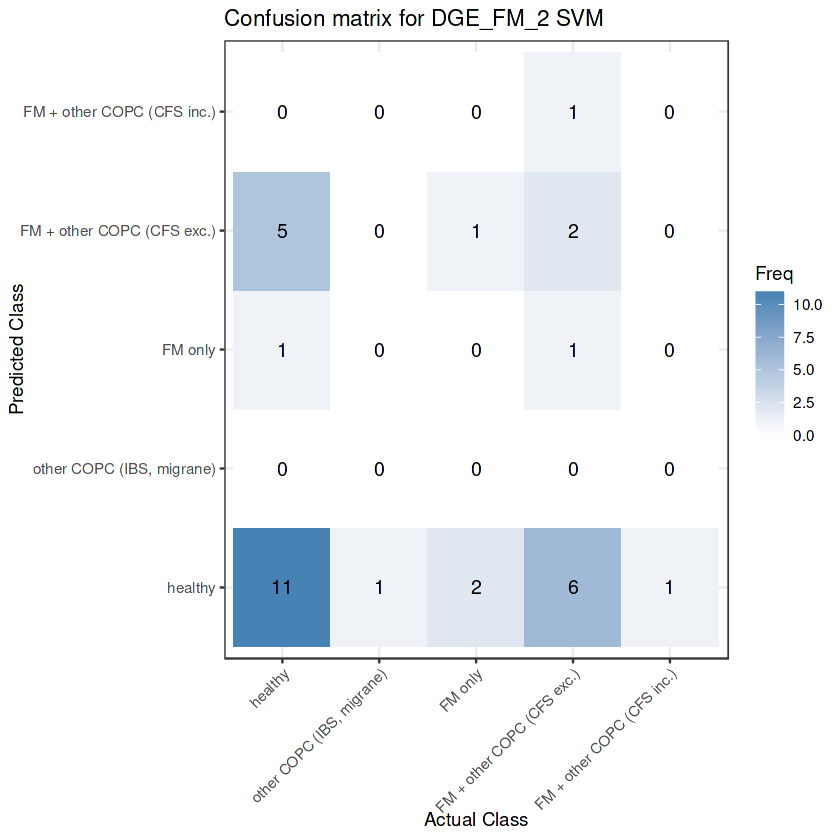

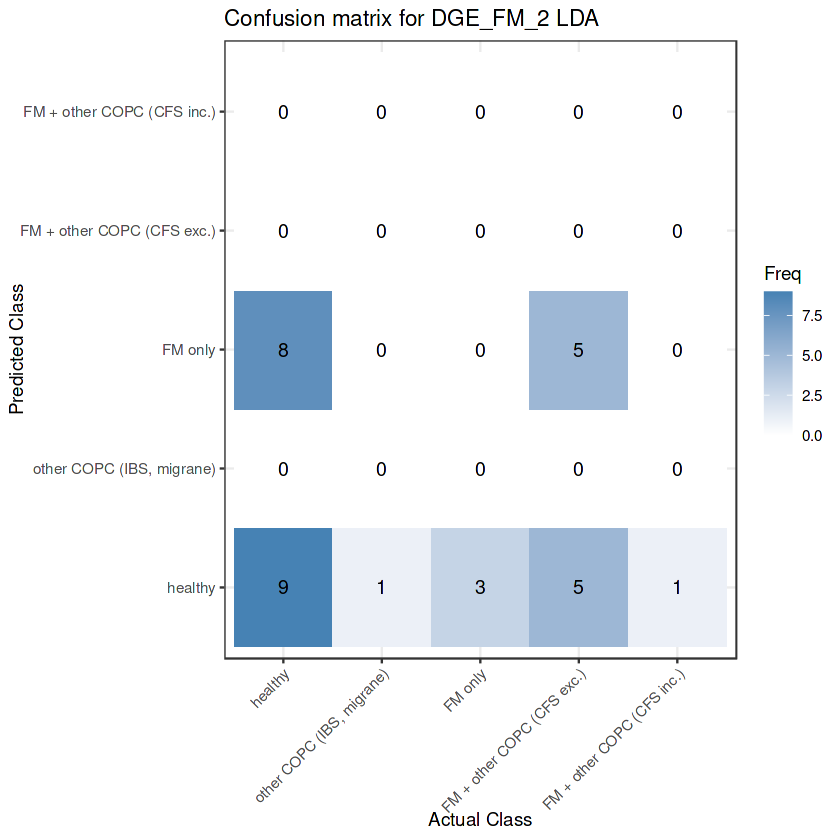

[1] "------------------------------- Processing gene list: WGCNA_FM_2 -------------------------------"
[1] "#####################  RF  #####################"
Confusion Matrix and Statistics

                            Reference
Prediction                   healthy other COPC (IBS, migrane) FM only
  healthy                         14                         0       2
  other COPC (IBS, migrane)        0                         0       0
  FM only                          0                         0       0
  FM + other COPC (CFS exc.)       3                         1       1
  FM + other COPC (CFS inc.)       0                         0       0
                            Reference
Prediction                   FM + other COPC (CFS exc.)
  healthy                                             7
  other COPC (IBS, migrane)                           0
  FM only                                             0
  FM + other COPC (CFS exc.)                          3
  FM + other COPC (CFS inc.

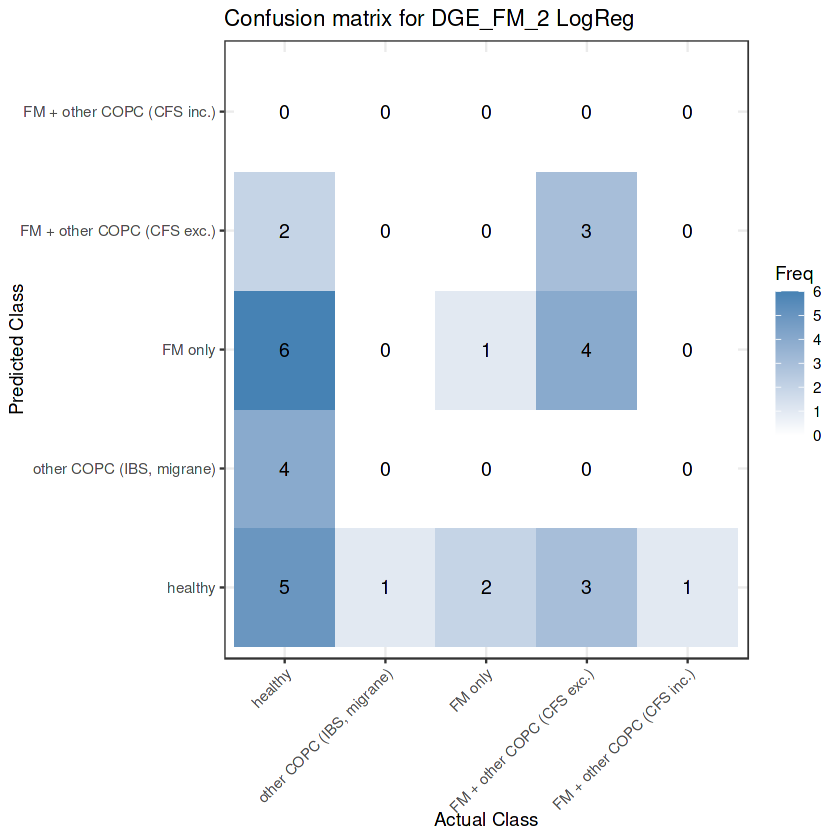

[1] "#####################  SVM  #####################"
Confusion Matrix and Statistics

                            Reference
Prediction                   healthy other COPC (IBS, migrane) FM only
  healthy                         14                         0       2
  other COPC (IBS, migrane)        0                         0       0
  FM only                          0                         0       0
  FM + other COPC (CFS exc.)       3                         1       1
  FM + other COPC (CFS inc.)       0                         0       0
                            Reference
Prediction                   FM + other COPC (CFS exc.)
  healthy                                             7
  other COPC (IBS, migrane)                           0
  FM only                                             0
  FM + other COPC (CFS exc.)                          3
  FM + other COPC (CFS inc.)                          0
                            Reference
Prediction                   FM + o

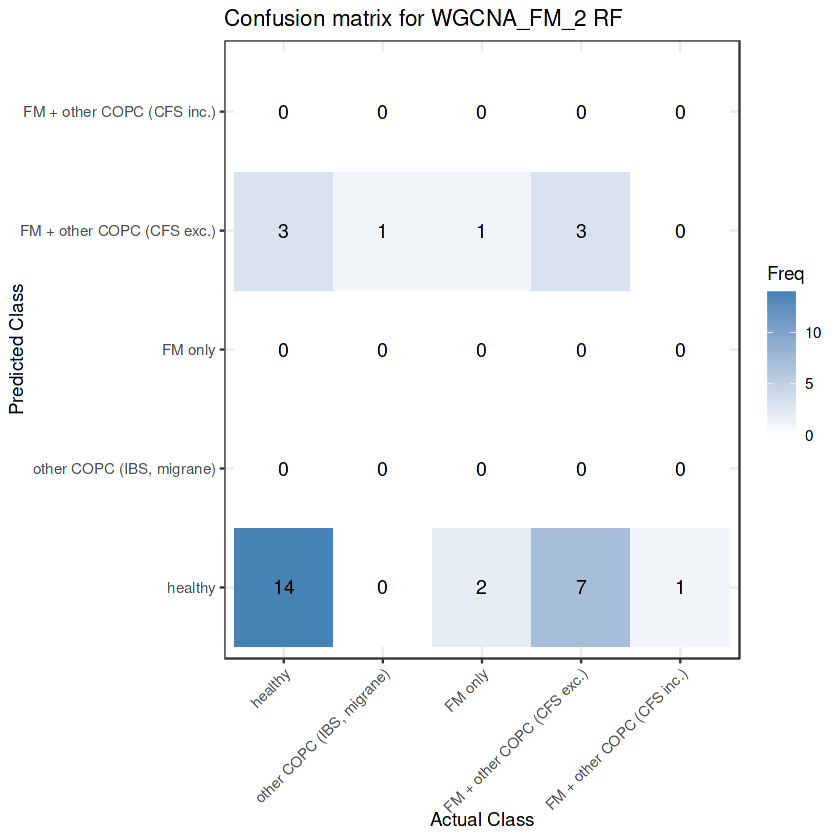

[1] "#####################  LDA  #####################"
Confusion Matrix and Statistics

                            Reference
Prediction                   healthy other COPC (IBS, migrane) FM only
  healthy                          7                         0       2
  other COPC (IBS, migrane)        2                         0       0
  FM only                          5                         1       1
  FM + other COPC (CFS exc.)       1                         0       0
  FM + other COPC (CFS inc.)       2                         0       0
                            Reference
Prediction                   FM + other COPC (CFS exc.)
  healthy                                             6
  other COPC (IBS, migrane)                           0
  FM only                                             4
  FM + other COPC (CFS exc.)                          0
  FM + other COPC (CFS inc.)                          0
                            Reference
Prediction                   FM + o

Warning message in lognet(xd, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”
Warning message in lognet(xd, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”
Warning message in lognet(xd, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”
Warning message in lognet(xd, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”


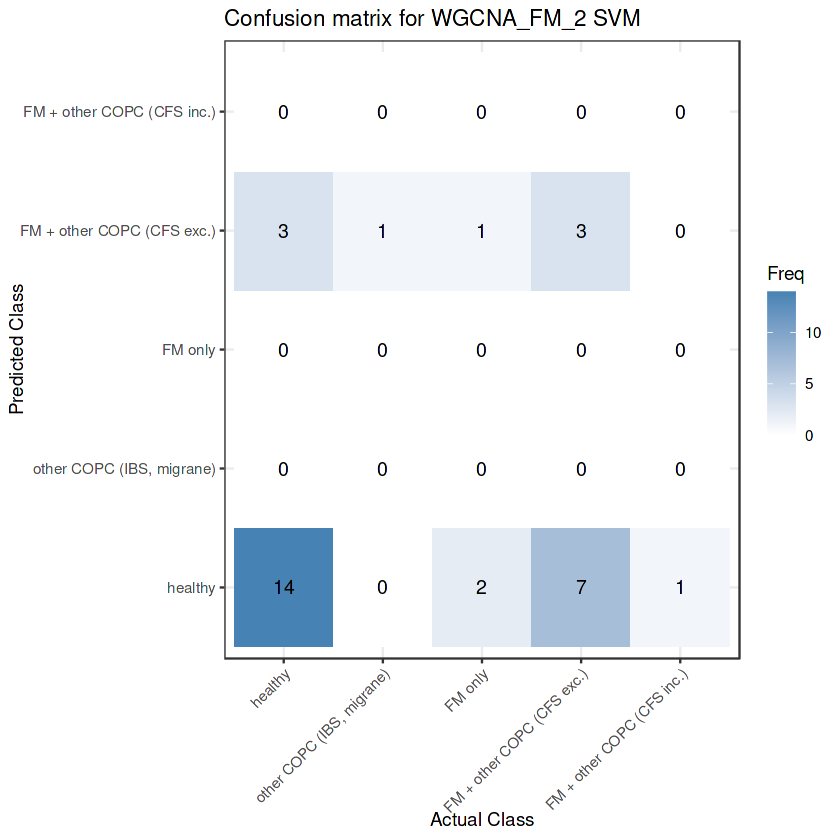

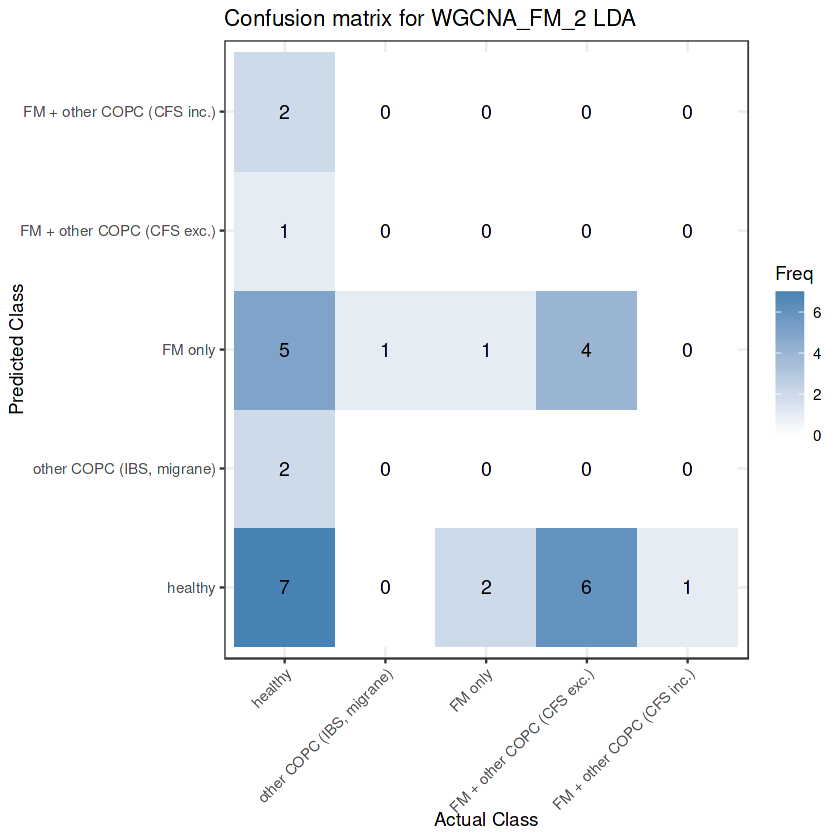

[1] "------------------------------- Processing gene list: All_combined -------------------------------"
[1] "#####################  RF  #####################"
Confusion Matrix and Statistics

                            Reference
Prediction                   healthy other COPC (IBS, migrane) FM only
  healthy                         14                         1       3
  other COPC (IBS, migrane)        0                         0       0
  FM only                          0                         0       0
  FM + other COPC (CFS exc.)       3                         0       0
  FM + other COPC (CFS inc.)       0                         0       0
                            Reference
Prediction                   FM + other COPC (CFS exc.)
  healthy                                             7
  other COPC (IBS, migrane)                           0
  FM only                                             0
  FM + other COPC (CFS exc.)                          3
  FM + other COPC (CFS in

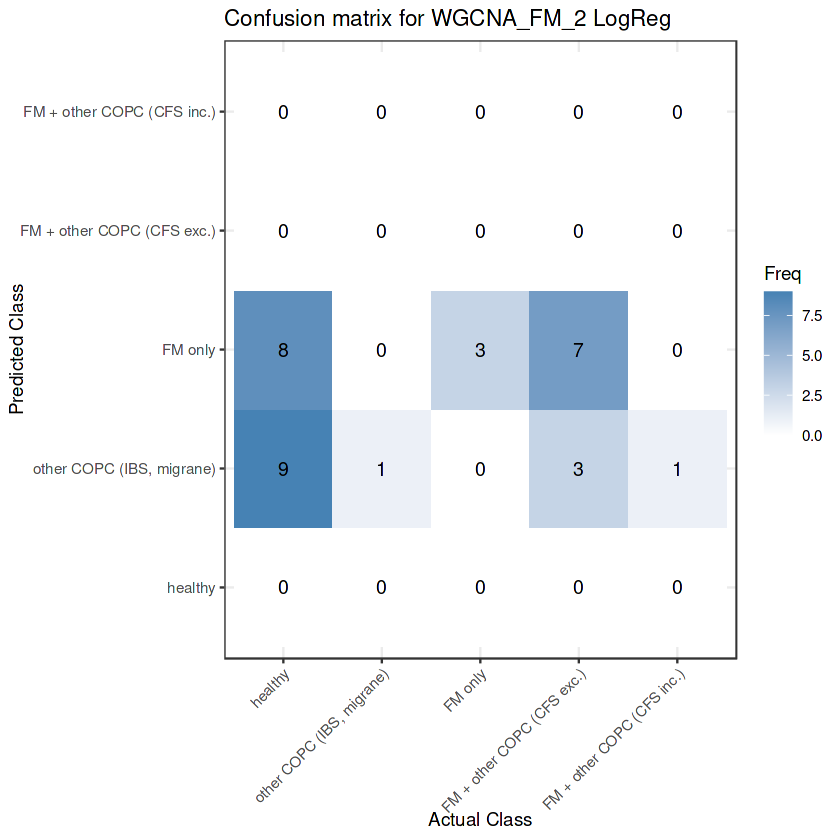

[1] "#####################  SVM  #####################"
Confusion Matrix and Statistics

                            Reference
Prediction                   healthy other COPC (IBS, migrane) FM only
  healthy                         17                         1       3
  other COPC (IBS, migrane)        0                         0       0
  FM only                          0                         0       0
  FM + other COPC (CFS exc.)       0                         0       0
  FM + other COPC (CFS inc.)       0                         0       0
                            Reference
Prediction                   FM + other COPC (CFS exc.)
  healthy                                            10
  other COPC (IBS, migrane)                           0
  FM only                                             0
  FM + other COPC (CFS exc.)                          0
  FM + other COPC (CFS inc.)                          0
                            Reference
Prediction                   FM + o

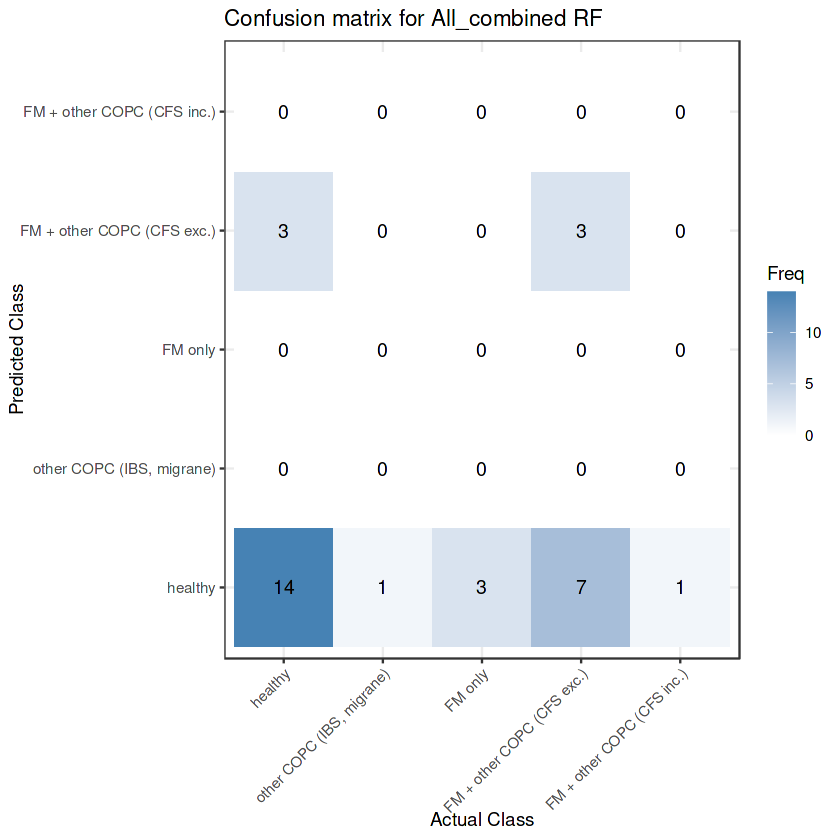

[1] "#####################  LDA  #####################"
Confusion Matrix and Statistics

                            Reference
Prediction                   healthy other COPC (IBS, migrane) FM only
  healthy                         15                         1       3
  other COPC (IBS, migrane)        0                         0       0
  FM only                          2                         0       0
  FM + other COPC (CFS exc.)       0                         0       0
  FM + other COPC (CFS inc.)       0                         0       0
                            Reference
Prediction                   FM + other COPC (CFS exc.)
  healthy                                             6
  other COPC (IBS, migrane)                           0
  FM only                                             4
  FM + other COPC (CFS exc.)                          0
  FM + other COPC (CFS inc.)                          0
                            Reference
Prediction                   FM + o

Warning message in lognet(xd, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”
Warning message in lognet(xd, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”
Warning message in lognet(xd, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”
Warning message in lognet(xd, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”


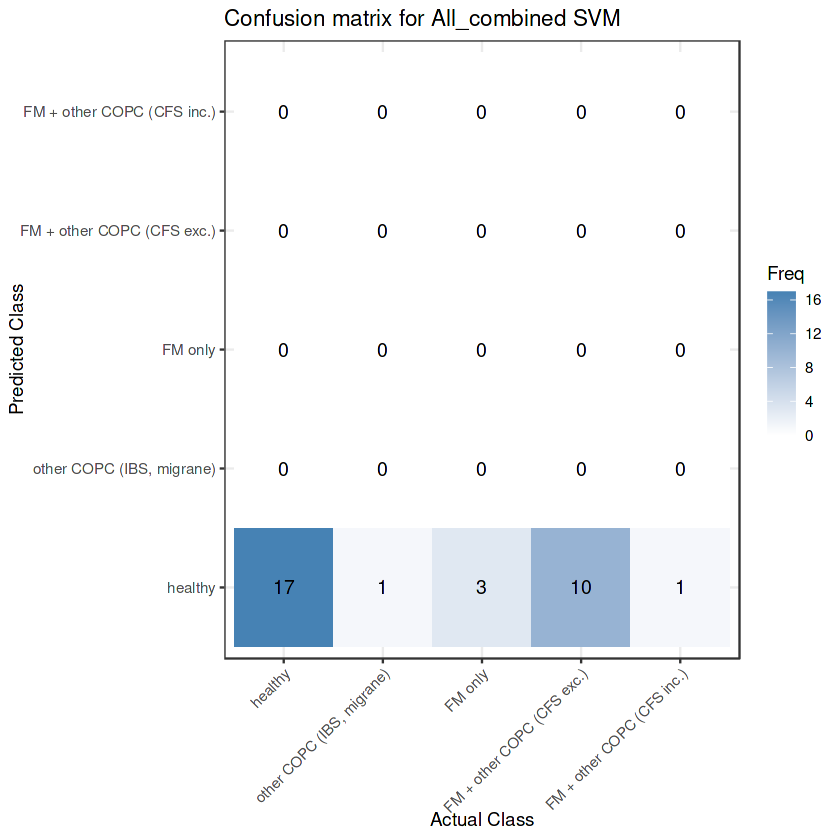

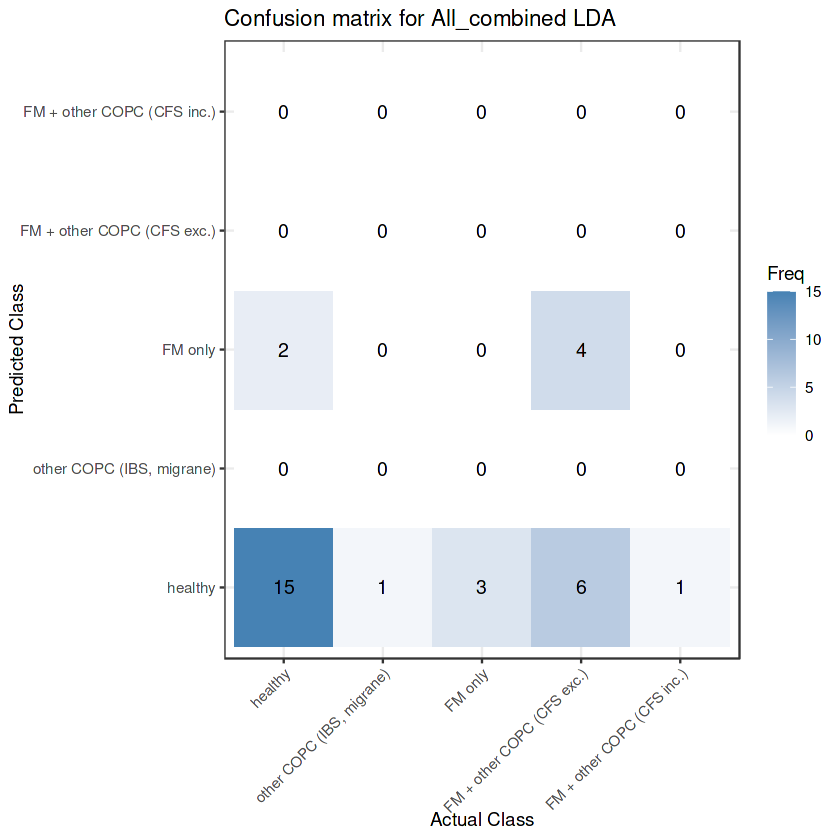

[1] "------------------------------- Processing gene list: RFE_combined -------------------------------"
[1] "#####################  RF  #####################"
Confusion Matrix and Statistics

                            Reference
Prediction                   healthy other COPC (IBS, migrane) FM only
  healthy                         11                         1       3
  other COPC (IBS, migrane)        0                         0       0
  FM only                          1                         0       0
  FM + other COPC (CFS exc.)       5                         0       0
  FM + other COPC (CFS inc.)       0                         0       0
                            Reference
Prediction                   FM + other COPC (CFS exc.)
  healthy                                             5
  other COPC (IBS, migrane)                           0
  FM only                                             1
  FM + other COPC (CFS exc.)                          4
  FM + other COPC (CFS in

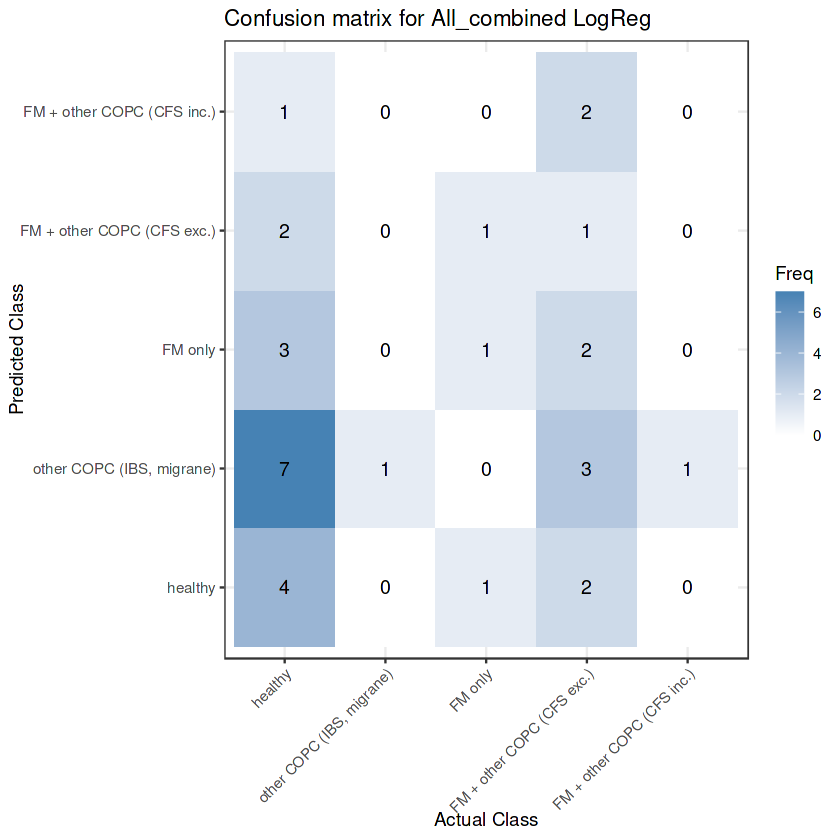

[1] "#####################  SVM  #####################"
Confusion Matrix and Statistics

                            Reference
Prediction                   healthy other COPC (IBS, migrane) FM only
  healthy                         10                         1       2
  other COPC (IBS, migrane)        0                         0       0
  FM only                          2                         0       0
  FM + other COPC (CFS exc.)       5                         0       1
  FM + other COPC (CFS inc.)       0                         0       0
                            Reference
Prediction                   FM + other COPC (CFS exc.)
  healthy                                             4
  other COPC (IBS, migrane)                           0
  FM only                                             1
  FM + other COPC (CFS exc.)                          5
  FM + other COPC (CFS inc.)                          0
                            Reference
Prediction                   FM + o

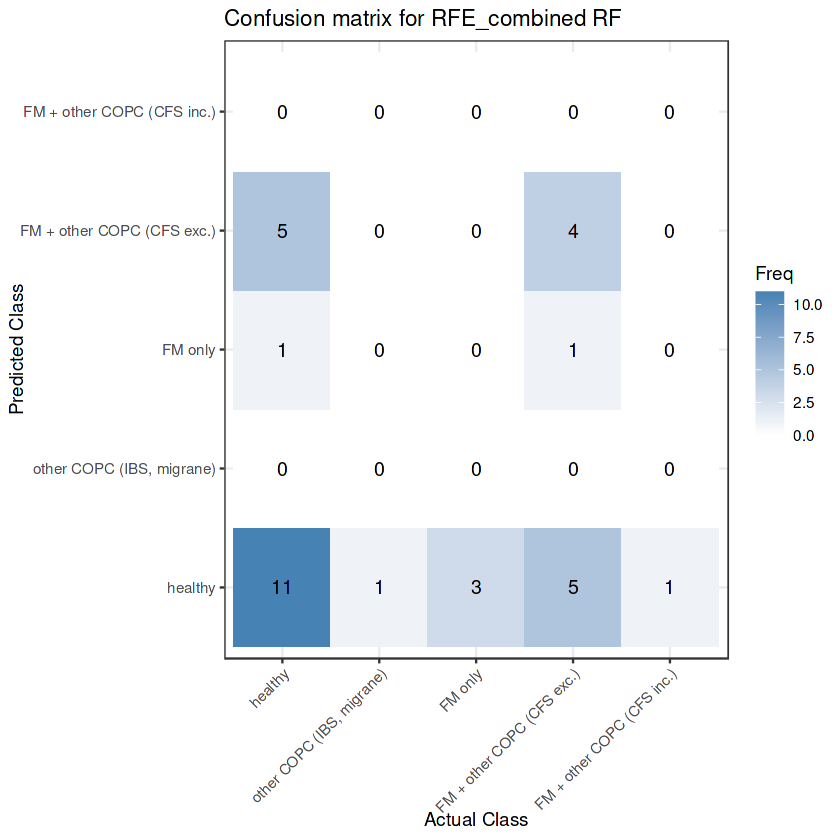

[1] "#####################  LDA  #####################"
Confusion Matrix and Statistics

                            Reference
Prediction                   healthy other COPC (IBS, migrane) FM only
  healthy                          8                         1       2
  other COPC (IBS, migrane)        3                         0       0
  FM only                          4                         0       1
  FM + other COPC (CFS exc.)       2                         0       0
  FM + other COPC (CFS inc.)       0                         0       0
                            Reference
Prediction                   FM + other COPC (CFS exc.)
  healthy                                             5
  other COPC (IBS, migrane)                           0
  FM only                                             4
  FM + other COPC (CFS exc.)                          1
  FM + other COPC (CFS inc.)                          0
                            Reference
Prediction                   FM + o

Warning message in lognet(xd, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”
Warning message in lognet(xd, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”
Warning message in lognet(xd, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”
Warning message in lognet(xd, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”


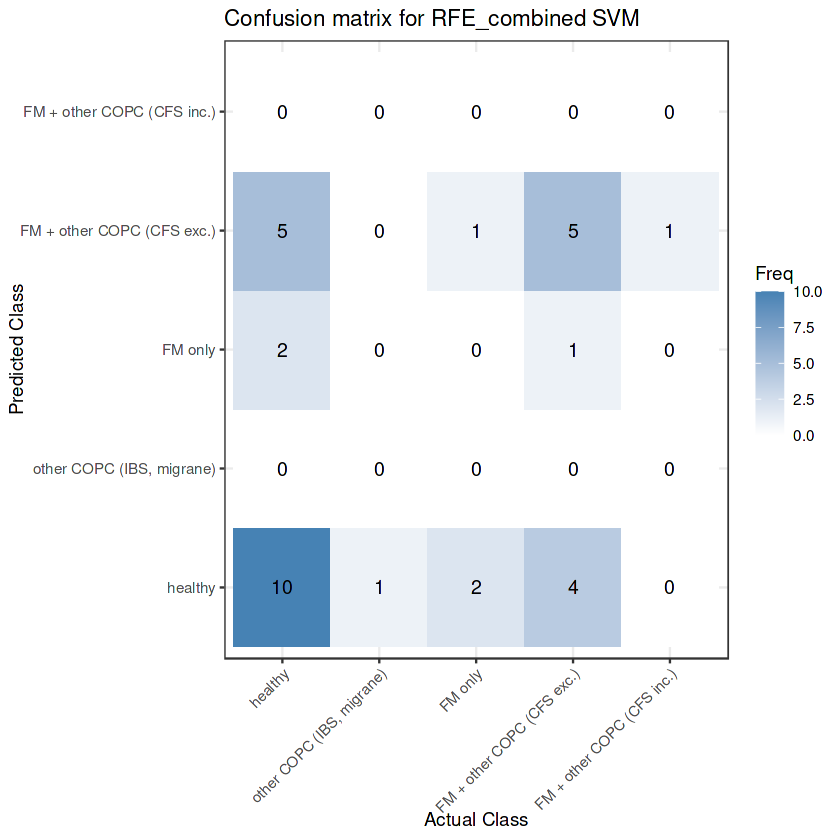

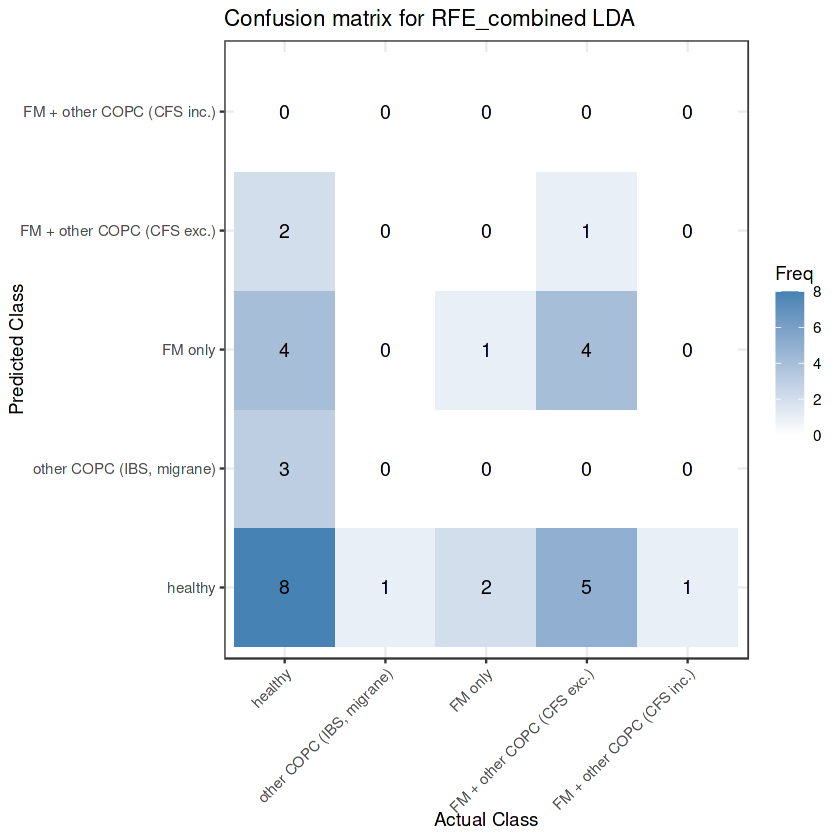

[1] "------------------------------- Processing gene list: Boruta_combined -------------------------------"
[1] "#####################  RF  #####################"
Confusion Matrix and Statistics

                            Reference
Prediction                   healthy other COPC (IBS, migrane) FM only
  healthy                         10                         1       2
  other COPC (IBS, migrane)        0                         0       0
  FM only                          1                         0       0
  FM + other COPC (CFS exc.)       6                         0       1
  FM + other COPC (CFS inc.)       0                         0       0
                            Reference
Prediction                   FM + other COPC (CFS exc.)
  healthy                                             5
  other COPC (IBS, migrane)                           0
  FM only                                             1
  FM + other COPC (CFS exc.)                          4
  FM + other COPC (CFS

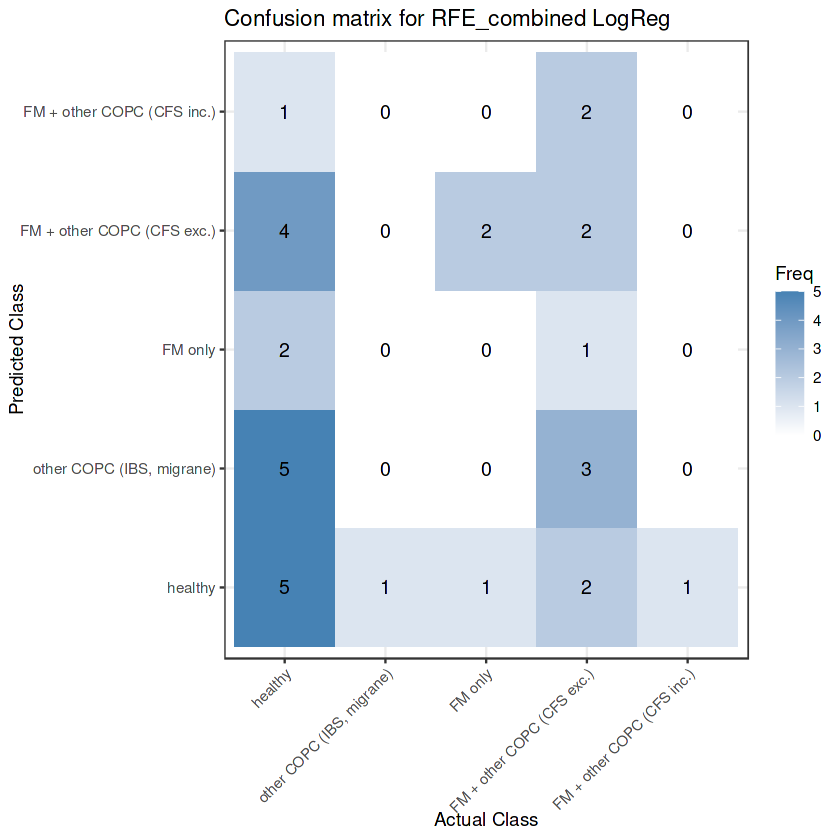

[1] "#####################  SVM  #####################"
Confusion Matrix and Statistics

                            Reference
Prediction                   healthy other COPC (IBS, migrane) FM only
  healthy                          9                         1       2
  other COPC (IBS, migrane)        1                         0       0
  FM only                          4                         0       0
  FM + other COPC (CFS exc.)       2                         0       1
  FM + other COPC (CFS inc.)       1                         0       0
                            Reference
Prediction                   FM + other COPC (CFS exc.)
  healthy                                             4
  other COPC (IBS, migrane)                           1
  FM only                                             3
  FM + other COPC (CFS exc.)                          2
  FM + other COPC (CFS inc.)                          0
                            Reference
Prediction                   FM + o

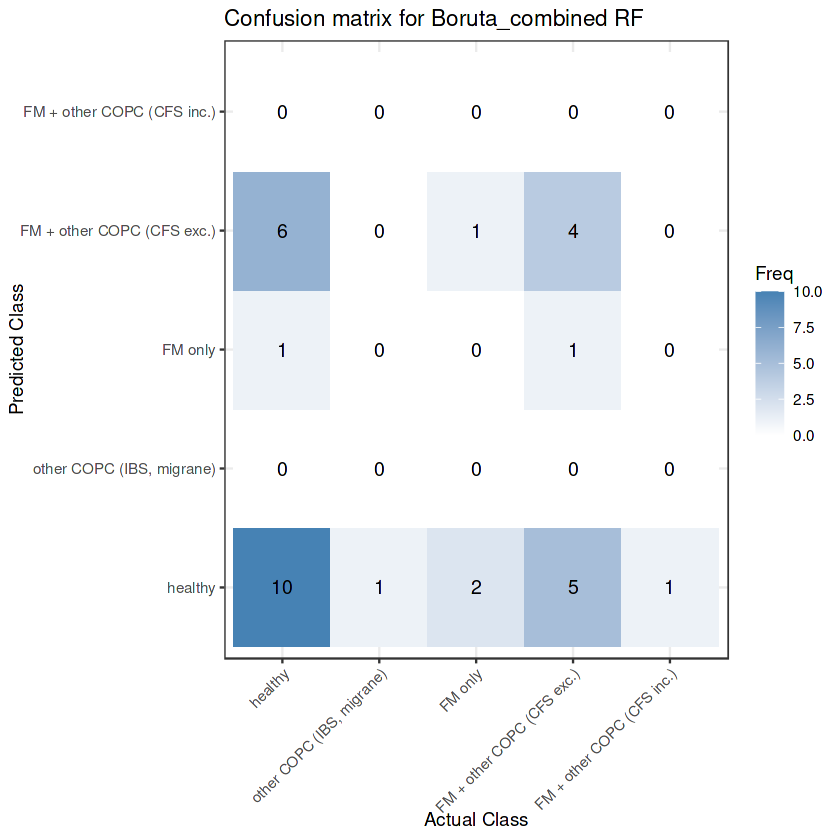

[1] "#####################  LDA  #####################"
Confusion Matrix and Statistics

                            Reference
Prediction                   healthy other COPC (IBS, migrane) FM only
  healthy                          9                         1       2
  other COPC (IBS, migrane)        1                         0       0
  FM only                          3                         0       1
  FM + other COPC (CFS exc.)       4                         0       0
  FM + other COPC (CFS inc.)       0                         0       0
                            Reference
Prediction                   FM + other COPC (CFS exc.)
  healthy                                             5
  other COPC (IBS, migrane)                           0
  FM only                                             3
  FM + other COPC (CFS exc.)                          2
  FM + other COPC (CFS inc.)                          0
                            Reference
Prediction                   FM + o

Warning message in lognet(xd, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”
Warning message in lognet(xd, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”
Warning message in lognet(xd, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”
Warning message in lognet(xd, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”


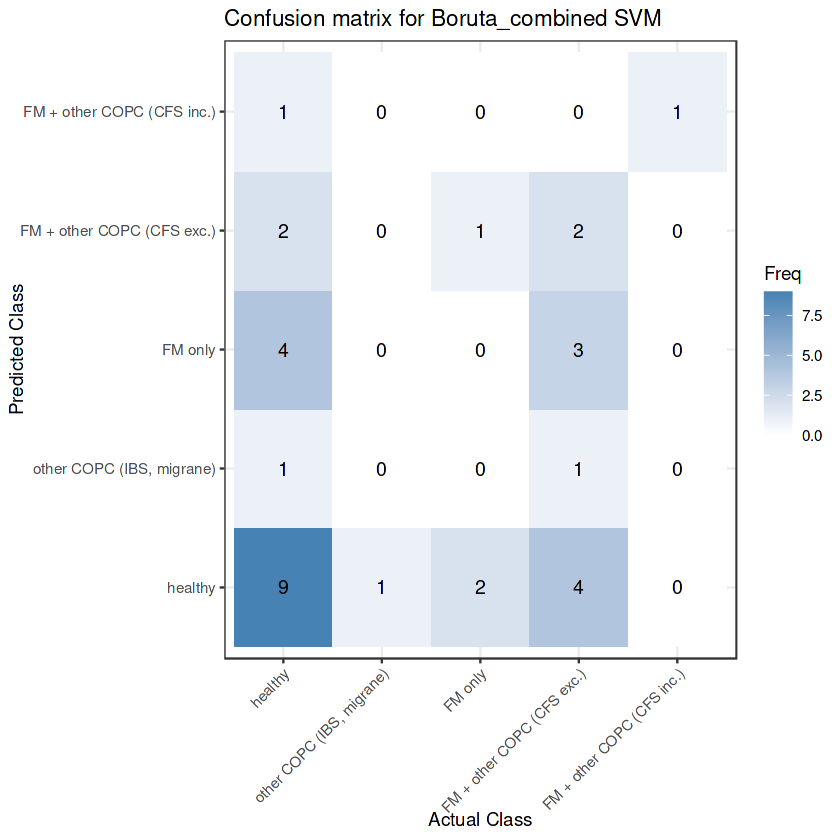

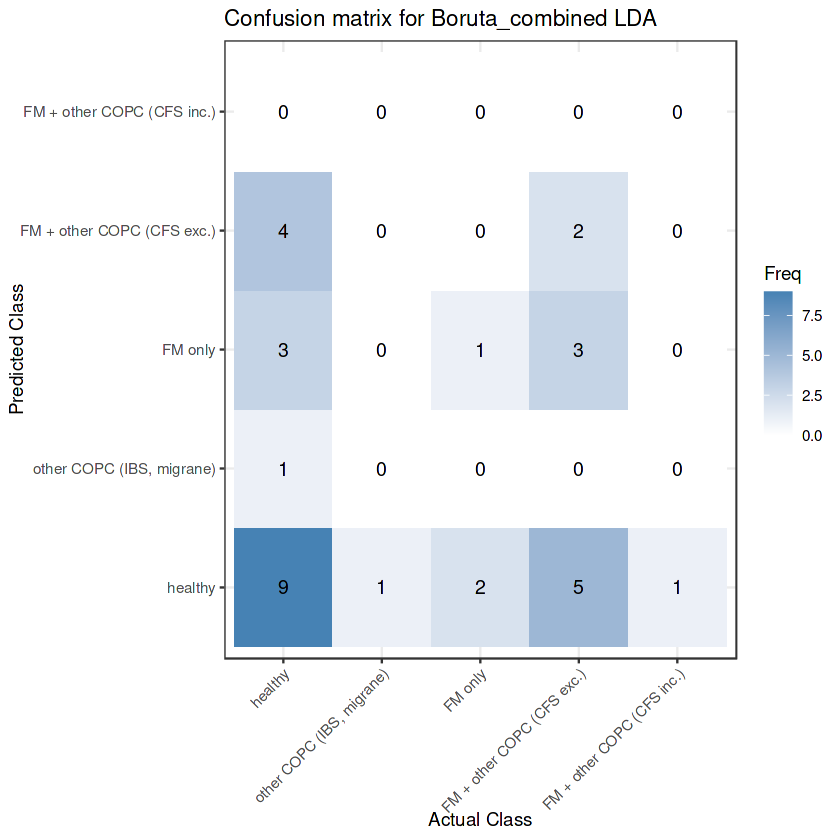

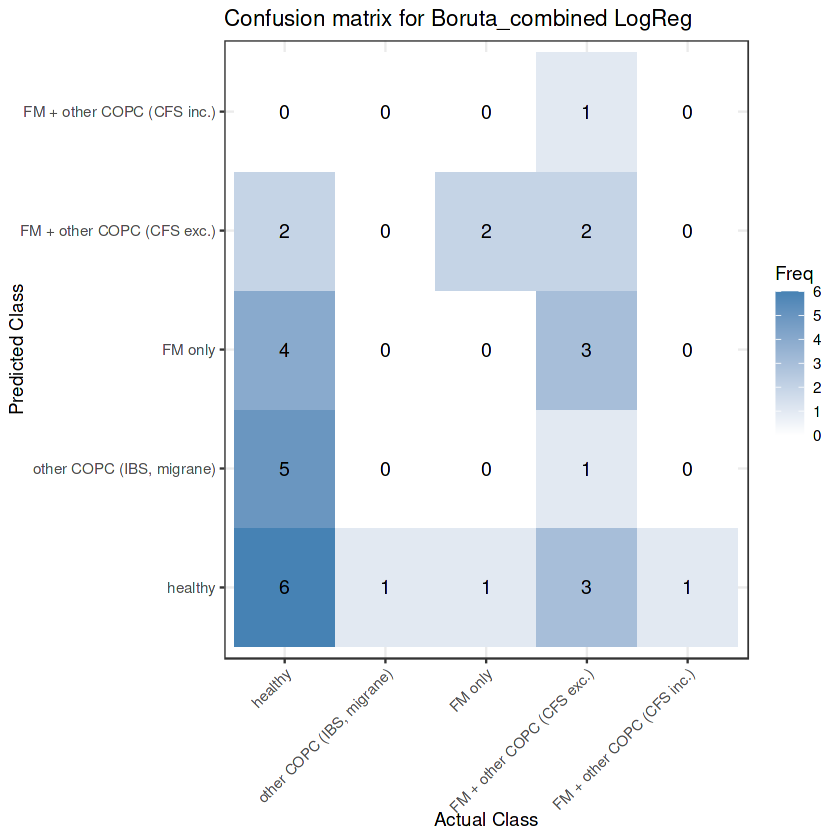

In [ ]:
### Fitting and testing multinomial classification models

genelists <- list(
    DGE_FM_2 = DGE_gid_manf_FM_2,
    WGCNA_FM_2 = RFE_WGCNA_FM_2,
    All_combined = gene_ids_all,
    RFE_combined = genelist_rfe_predict,
    Boruta_combined = as.character(selected_features)
)

# Initiating accurracy table
accuracy_table <- data.frame(Model = character(), Accuracy = numeric(), stat_model = character(), gene_set = character(), stringsAsFactors = FALSE)

set.seed(123)

for (genelist_name in names(genelists)) {
    print(paste("------------------------------- Processing gene list:", genelist_name, "-------------------------------"))
    genelist <- genelists[[genelist_name]]

    print("#####################  RF  #####################")

    rf_model <- randomForest(
      x = X_train_norm[, genelist],
      y = Y_train_as_factor,
      ntree = 1501,
      importance = TRUE,
      classwt = class_weights_fact,  ########### !!!!!!!!!!!!!!!1
      mtry = floor(sqrt(length(genelist)))
    )
    # Evaluate performance on test data
    pred_rf <- predict(rf_model, X_test_norm[, genelist])
    # Confusion matrices for evaluation
    confusion_rf <- confusionMatrix(pred_rf, Y_test_as_factor, mode = "prec_recall") ##### !!!
    print(confusion_rf)

    feature_importance_rf <- as.data.frame(importance(rf_model))
    feature_importance_rf$Feature <- rownames(feature_importance_rf)
    qsave(feature_importance_rf, paste0(genelist_name,"_feature_importance_rf.qs"))

    # Confusion matrix visualisation
    cm <- as.data.frame(confusion_rf$table)
    names(cm) <- c("Predicted", "Reference", "Freq")
    x <- ggplot(data = cm, aes(x = Reference, y = Predicted, fill = Freq)) +
          geom_tile() +
          geom_text(aes(label = Freq), color = "black", size = 4) +
          scale_fill_gradient(low = "white", high = "steelblue") +
          theme_bw() +
          labs(title = paste0("Confusion matrix for ", genelist_name, " RF"),
               x = "Actual Class",
               y = "Predicted Class") +
          theme(axis.text.x = element_text(angle = 45, hjust = 1),
                axis.text.y = element_text(hjust = 1))
    print(x)
    Sys.sleep(0.1)

    # Adding accuracy to the table
    accuracy_rf <- confusion_rf$overall['Accuracy']
    accuracy_table <- rbind(accuracy_table, data.frame(Model = paste0(genelist_name,"_RF"), Accuracy = accuracy_rf,
                            stat_model = genelist_name, gene_set = "RF"))

    print("#####################  SVM  #####################")

    svm_tuned <- tune(svm,
      Y_train_as_factor ~ .,
      data = data.frame(Y_train_as_factor = Y_train_as_factor, X_train_norm[, genelist], check.names = FALSE),
      kernel = "radial",
      type = "C-classification",
      ranges = list(cost = c(0.01, 0.1, 1, 10, 50, 100),
                    gamma = c(1 / length(genelist), 0.001, 0.01, 0.1, 1, 10)),
      class.weights = class_weights_fact, ########### !!!!!!!!!!!!!!!1
      tunecontrol = tune.control(cross = 10)
    )

    # plot(svm_tuned)
    summary(svm_tuned)
    best_model_svm <- svm_tuned$best.model
    # Evaluate the best model on the test set
    pred_svm <- predict(best_model_svm, X_test_norm[, genelist])
    confusion_svm <- confusionMatrix(pred_svm, Y_test_as_factor, mode = "prec_recall") ##### !!!!
    print(confusion_svm)

    # Confusion matrix visualisation
    cm <- as.data.frame(confusion_svm$table)
    names(cm) <- c("Predicted", "Reference", "Freq")
    x <- ggplot(data = cm, aes(x = Reference, y = Predicted, fill = Freq)) +
          geom_tile() +
          geom_text(aes(label = Freq), color = "black", size = 4) +
          scale_fill_gradient(low = "white", high = "steelblue") +
          theme_bw() +
          labs(title = paste0("Confusion matrix for ", genelist_name, " SVM"),
               x = "Actual Class",
               y = "Predicted Class") +
          theme(axis.text.x = element_text(angle = 45, hjust = 1),
                axis.text.y = element_text(hjust = 1))
    print(x)
    Sys.sleep(0.1)

    # Adding accuracy to the table
    accuracy_svm <- confusion_svm$overall['Accuracy']
    accuracy_table <- rbind(accuracy_table, data.frame(Model = paste0(genelist_name,"_SVM"), Accuracy = accuracy_svm,
                            stat_model = genelist_name, gene_set = "SVM"))


    print("#####################  LDA  #####################")

    NetLDA <- NetDA(X_train_norm[, genelist],
                    Y_train_as_numeric,
                    method=1,
                    X_test_norm[, genelist])
    yhat_lda <- NetLDA$yhat

    yhat_lda_as_factor <- factor(reverse_mapping[as.character(yhat_lda)], levels = levels(Y_test_as_factor))
    confusion_netlda <- confusionMatrix(yhat_lda_as_factor, Y_test_as_factor, mode = "prec_recall")
    print(confusion_netlda)

    # Confusion matrix visualisation
    cm <- as.data.frame(confusion_netlda$table)
    names(cm) <- c("Predicted", "Reference", "Freq")
    x <- ggplot(data = cm, aes(x = Reference, y = Predicted, fill = Freq)) +
          geom_tile() +
          geom_text(aes(label = Freq), color = "black", size = 4) +
          scale_fill_gradient(low = "white", high = "steelblue") +
          theme_bw() +
          labs(title = paste0("Confusion matrix for ", genelist_name, " LDA"),
               x = "Actual Class",
               y = "Predicted Class") +
          theme(axis.text.x = element_text(angle = 45, hjust = 1),
                axis.text.y = element_text(hjust = 1))
    print(x)
    Sys.sleep(0.1)

    # Adding accuracy to the table
    accuracy_netlda <- confusion_netlda$overall['Accuracy']
    accuracy_table <- rbind(accuracy_table, data.frame(Model = paste0(genelist_name,"_LDA"), Accuracy = accuracy_netlda,
                            stat_model = genelist_name, gene_set = "LDA"))



    print("#####################  LogReg  #####################")

    cvfit <- cv.glmnet(as.matrix(X_train_norm[, genelist]), Y_train_as_factor, family = "multinomial", weights=weights_for_logreg, nfolds = 3) ###!!!!!!!!! (10-fold didn't work due to small number of samples for some classes)

    coefs <- coef(cvfit, s = "lambda.min")

    pred_logistic <- predict(cvfit, newx = as.matrix(X_test_norm[, genelist]), family = "multinomial", type='class', s = "lambda.min")
    pred_logistic <- factor(pred_logistic, levels=levels(Y_test_as_factor))
    confusion_logistic <- confusionMatrix(pred_logistic, Y_test_as_factor, mode = "prec_recall")

    qsave(coefs, paste0(genelist_name, "_coefs_logreg.qs"))

    # Confusion matrix visualisation
    cm <- as.data.frame(confusion_logistic$table)
    names(cm) <- c("Predicted", "Reference", "Freq")
    x <- ggplot(data = cm, aes(x = Reference, y = Predicted, fill = Freq)) +
          geom_tile() +
          geom_text(aes(label = Freq), color = "black", size = 4) +
          scale_fill_gradient(low = "white", high = "steelblue") +
          theme_bw() +
          labs(title = paste0("Confusion matrix for ", genelist_name, " LogReg"),
               x = "Actual Class",
               y = "Predicted Class") +
          theme(axis.text.x = element_text(angle = 45, hjust = 1),
                axis.text.y = element_text(hjust = 1))
    print(x)
    Sys.sleep(0.1)

    # Adding accuracy to the table
    accuracy_logistic <- confusion_logistic$overall['Accuracy']
    accuracy_table <- rbind(accuracy_table, data.frame(Model = paste0(genelist_name,"_LogReg"), Accuracy = accuracy_logistic,
                                                       stat_model = genelist_name, gene_set = "LogReg"))

}

In [ ]:
# Calculating accuracy for baseline model
table(Y_train_as_factor)
majority_class <- "healthy"
Y_pred_zeroR <- factor(rep(majority_class, length(Y_test_as_factor)), levels=levels(Y_test_as_factor))
Y_pred_zeroR

confusion_matrix_baseline <- confusionMatrix(Y_pred_zeroR, Y_test_as_factor, mode="prec_recall")
   accuracy_multinomial <- confusion_matrix_baseline$overall['Accuracy']
   print(paste("Accuracy for baseline Model:", accuracy_multinomial))

confusion_matrix_baseline

Y_train_as_factor
                   healthy  other COPC (IBS, migrane) 
                        42                          8 
                   FM only FM + other COPC (CFS exc.) 
                         7                         30 
FM + other COPC (CFS inc.) 
                         9 

[1] healthy healthy healthy healthy healthy healthy healthy healthy healthy
[10] healthy healthy healthy healthy healthy healthy healthy healthy healthy
[19] healthy healthy healthy healthy healthy healthy healthy healthy healthy
[28] healthy healthy healthy healthy healthy
5 Levels: healthy other COPC (IBS, migrane) ... FM + other COPC (CFS inc.)

[1] "Accuracy for baseline Model: 0.53125"


Confusion Matrix and Statistics

                            Reference
Prediction                   healthy other COPC (IBS, migrane) FM only
  healthy                         17                         1       3
  other COPC (IBS, migrane)        0                         0       0
  FM only                          0                         0       0
  FM + other COPC (CFS exc.)       0                         0       0
  FM + other COPC (CFS inc.)       0                         0       0
                            Reference
Prediction                   FM + other COPC (CFS exc.)
  healthy                                            10
  other COPC (IBS, migrane)                           0
  FM only                                             0
  FM + other COPC (CFS exc.)                          0
  FM + other COPC (CFS inc.)                          0
                            Reference
Prediction                   FM + other COPC (CFS inc.)
  healthy                          

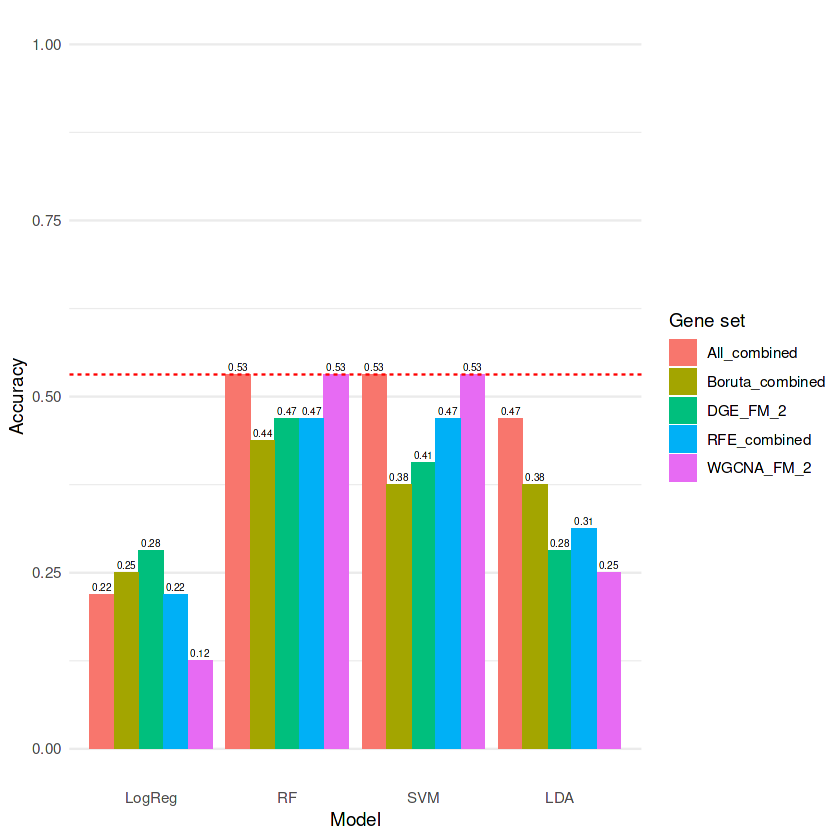

In [ ]:
### Barplot to compare accuracies
colnames(accuracy_table) <- c("model_id", "Accuracy", "Gene set", "Model")
accuracy_table$`Model` <- factor(accuracy_table$`Model`, levels = c("LogReg", "RF", "SVM", "LDA"))

ggplot(accuracy_table, aes(fill=`Gene set`, y=Accuracy, x=`Model`)) +
  geom_bar(position="dodge", stat="identity") +
  geom_hline(yintercept = confusion_matrix_baseline$overall['Accuracy'], linetype = "dashed", color = "red") +
  scale_y_continuous(limits = c(0, 1)) +
  geom_text(aes(label = round(Accuracy, 2)),
            position = position_dodge(0.9),
            vjust = -0.5,
            size = 2) +
  theme_minimal() +
  theme(
    panel.grid.major.x = element_blank(),
    panel.grid.minor.x = element_blank()
  )

## FM_1 + CFS_1-4

In [ ]:
### Upoading genesets yielded best performance for FM_1 and CFS_1-4 datasets

RFE_DGE_FM_1 <- qread("/kaggle/working/RFE_DGE_FM_1.qs")
RFE_WGCNA_FM_1 <- qread("/kaggle/working/RFE_WGCNA_FM_1.qs")
RFE_DGE_CFS_2 <- qread("/kaggle/working/RFE_DGE_CFS_2.qs")
RFE_WGCNA_CFS_2 <- qread("/kaggle/working/RFE_WGCNA_CFS_2.qs")

dge_res <- qread("/kaggle/input/dge-wgcna-res/DGE_CFS_1_res_annot.qs")
DGE_genes_manf_CFS_1 <- dge_res[dge_res$gene_name != '' &
                               dge_res$pvalue < 0.001 &
                               dge_res$padj < 0.5, ]$gene_name

DGE_gid_manf_CFS_1 <- dge_res[dge_res$gene_name != '' &
                               dge_res$pvalue < 0.001 &
                               dge_res$padj < 0.5, ]$gene_id

RFE_WGCNA_CFS_3 <- qread("/kaggle/working/RFE_WGCNA_CFS_3.qs")
RFE_DGE_CFS_3 <- qread("/kaggle/working/RFE_DGE_CFS_3.qs")
Boruta_DGE_CFS_4 <- qread("/kaggle/working/Boruta_DGE_gid_manf_CFS_4.qs")

In [ ]:
# Removing sex since CFS_4 doesn't have it
RFE_WGCNA_FM_1 <- RFE_WGCNA_FM_1[RFE_WGCNA_FM_1 != "sex"]
RFE_DGE_FM_1 <- RFE_DGE_FM_1[RFE_DGE_FM_1 != "sex"]
RFE_DGE_CFS_2 <- RFE_DGE_CFS_2[RFE_DGE_CFS_2 != "sex"]
RFE_DGE_CFS_3 <- RFE_DGE_CFS_3[RFE_DGE_CFS_3 != "sex"]
RFE_WGCNA_CFS_3 <- RFE_WGCNA_CFS_3[RFE_WGCNA_CFS_3 != "sex"]

Boruta_DGE_CFS_4 <- as.character(Boruta_DGE_CFS_4) # NOT ensembl id and as list

In [ ]:
# Combining all genes except for CFS_4
combined <- unique(c(RFE_DGE_FM_1, RFE_WGCNA_FM_1, RFE_DGE_CFS_2,
                     RFE_WGCNA_CFS_2, RFE_DGE_CFS_3, RFE_WGCNA_CFS_3,
                     DGE_gid_manf_CFS_1))
df <- qread("/kaggle/input/dge-wgcna-res/gse_train_FM_1.qs")
df <- rowData(df)[combined, ]
df_filt <- as.data.frame(df)[, c("gene_id", "gene_name", "description")]

In [ ]:
### Getting appropriate gene ids for CFS_4 annotation file
df1 <- read_tsv("/kaggle/input/annot-for-cfs4/Human.GRCh38.p13.annot.tsv")
df1_filt <- df1[df1$GeneID %in% Boruta_DGE_CFS_4, c("GeneID","Symbol","Description","EnsemblGeneID")]
x1 <- df1_filt$EnsemblGeneID
Boruta_DGE_CFS_4_GID <- x1[!is.na(x1)]

Rows: 39376 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (16): Symbol, Description, Synonyms, GeneType, EnsemblGeneID, Status, Ch...
dbl  (2): GeneID, Length

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [ ]:
# Fully combined gene list
combined_full_ensg <- unique(c(combined, Boruta_DGE_CFS_4_GID))

In [ ]:
### Uploading TPM NORMALISED expression X data

CFS_1_test <- qread("/kaggle/input/dge-wgcna-res/gse_test_CFS_1.qs")
CFS_2_test <- qread("/kaggle/input/dge-wgcna-res/gse_test_CFS_2.qs")
CFS_3_test <- qread("/kaggle/input/dge-wgcna-res/gse_test_CFS_3.qs")
FM_1_test <- qread("/kaggle/input/dge-wgcna-res/gse_test_FM_1.qs")

CFS_1_train <- qread("/kaggle/input/dge-wgcna-res/gse_train_CFS_1.qs")
CFS_2_train <- qread("/kaggle/input/dge-wgcna-res/gse_train_CFS_2.qs")
CFS_3_train <- qread("/kaggle/input/dge-wgcna-res/gse_train_CFS_3.qs")
FM_1_train <- qread("/kaggle/input/dge-wgcna-res/gse_train_FM_1.qs")

CFS_4_test <- qread("/kaggle/input/cfs4tpm/CFS_4_eset_test_TPM.qs")
CFS_4_train <- qread("/kaggle/input/cfs4tpm/CFS_4_eset_train_TPM.qs")

setdiff(combined_full_ensg, rownames(assays(CFS_1_train)[["abundance"]]))
combined_full_ensg_red1 <- combined_full_ensg[combined_full_ensg != 'ENSG00000225484']

In [ ]:
### Binding expression data (on several cells),
### on each step filtering genes that were present in all datasets

x1 <- (assays(CFS_1_test)[['abundance']])[combined_full_ensg_red1,]
x2 <- (assays(CFS_2_test)[['abundance']])[combined_full_ensg_red1,]
x3 <- (assays(CFS_3_test)[['abundance']])[combined_full_ensg_red1,]
z1 <- (assays(FM_1_test)[['abundance']])[combined_full_ensg_red1,]

# identical(rownames(x1), rownames(x2))
test_combined_part <- cbind(x1, x2, x3, z1)
dim(test_combined_part)

x1 <- (assays(CFS_1_train)[['abundance']])[combined_full_ensg_red1,]
x2 <- (assays(CFS_2_train)[['abundance']])[combined_full_ensg_red1,]
x3 <- (assays(CFS_3_train)[['abundance']])[combined_full_ensg_red1,]
z1 <- (assays(FM_1_train)[['abundance']])[combined_full_ensg_red1,]

# identical(rownames(x1), rownames(x2))
train_combined_part <- cbind(x1, x2, x3, z1)
dim(train_combined_part)

[1] 5074   84

[1] 5074  225

In [ ]:
df1 <- read_tsv("/kaggle/input/annot-for-cfs4/Human.GRCh38.p13.annot.tsv")
x4 <- exprs(CFS_4_train)
rownames(x4) <- df1$EnsemblGeneID[match(rownames(x4), df1$GeneID)]

dif <- setdiff(combined_full_ensg_red1, rownames(x4))
combined_full_ensg_red2 <- combined_full_ensg_red1[!combined_full_ensg_red1 %in% dif]
length(combined_full_ensg_red2)

Rows: 39376 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (16): Symbol, Description, Synonyms, GeneType, EnsemblGeneID, Status, Ch...
dbl  (2): GeneID, Length

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 4687

In [ ]:
x4 <- x4[combined_full_ensg_red2, ]
train_combined_part <- train_combined_part[combined_full_ensg_red2, ]
identical(rownames(train_combined_part), rownames(x4))

train_combined <- cbind(train_combined_part, x4)
dim(train_combined)

[1] TRUE

[1] 4687  292

In [ ]:
x4 <- exprs(CFS_4_test)
rownames(x4) <- df1$EnsemblGeneID[match(rownames(x4), df1$GeneID)]

x4 <- x4[combined_full_ensg_red2, ]
test_combined_part <- test_combined_part[combined_full_ensg_red2, ]
identical(rownames(test_combined_part), rownames(x4))

test_combined <- cbind(test_combined_part, x4)
dim(test_combined)

[1] TRUE

[1] 4687  109

In [ ]:
### Uploading and merging phenotype data (Y) (on several cells);
### Creating two levels of superclasses

# Test
test_samples_info <- data.frame(sample_id = character(), disease_state = character(), stringsAsFactors = FALSE)

x <- colData(CFS_1_test)
x$disease_state <- ifelse(x$`disease state:ch1` == "CFS_1", "CFS_1 (non-PI?)", "HC_CFS_1")
test_samples_info <- rbind(test_samples_info, data.frame(sample_id = x$geo_accession, disease_state = x$disease_state))

x <- colData(CFS_2_test)
x$disease_state <- ifelse(x$`disease_state` == "PI-ME/CFS", "CFS_2 (PI-ME/CFS, no COVID?)", "HC_CFS_2")
test_samples_info <- rbind(test_samples_info, data.frame(sample_id = x$geo_accession, disease_state = x$disease_state))

x <- colData(CFS_3_test)
x$disease_state <- ifelse(x$`disease_status` == "post-covid_ME-CFS", "CFS_3 (post-COVID CFS)", "HC_CFS_3")
test_samples_info <- rbind(test_samples_info, data.frame(sample_id = x$names, disease_state = x$disease_state))

x <- pData(CFS_4_test)
x$disease_state <- ifelse(x$`disease state:ch1` == "ME/CFS", "CFS_4 (mixed PI and non-PI + exercise)", "HC_CFS_4")
test_samples_info <- rbind(test_samples_info, data.frame(sample_id = x$geo_accession, disease_state = x$disease_state))

x <- colData(FM_1_test)
x$disease_state <- ifelse(x$`disease_state` == "Fibromylagia patient (FMA)", "FM_1", "HC_FM_1")
test_samples_info <- rbind(test_samples_info, data.frame(sample_id = x$Sample.Name, disease_state = x$disease_state))

unique(test_samples_info$disease_state)

[1] "CFS_1 (non-PI?)"                       
 [2] "HC_CFS_1"                              
 [3] "HC_CFS_2"                              
 [4] "CFS_2 (PI-ME/CFS, no COVID?)"          
 [5] "HC_CFS_3"                              
 [6] "CFS_3 (post-COVID CFS)"                
 [7] "CFS_4 (mixed PI and non-PI + exercise)"
 [8] "HC_CFS_4"                              
 [9] "FM_1"                                  
[10] "HC_FM_1"

In [ ]:
# Train
train_samples_info <- data.frame(sample_id = character(), disease_state = character(), stringsAsFactors = FALSE)

x <- colData(CFS_1_train)
x$disease_state <- ifelse(x$`disease state:ch1` == "CFS_1", "CFS_1 (non-PI?)", "HC_CFS_1")
train_samples_info <- rbind(train_samples_info, data.frame(sample_id = x$geo_accession, disease_state = x$disease_state))

x <- colData(CFS_2_train)
x$disease_state <- ifelse(x$`disease_state` == "PI-ME/CFS", "CFS_2 (PI-ME/CFS, no COVID?)", "HC_CFS_2")
train_samples_info <- rbind(train_samples_info, data.frame(sample_id = x$geo_accession, disease_state = x$disease_state))

x <- colData(CFS_3_train)
x$disease_state <- ifelse(x$`disease_status` == "post-covid_ME-CFS", "CFS_3 (post-COVID CFS)", "HC_CFS_3")
train_samples_info <- rbind(train_samples_info, data.frame(sample_id = x$names, disease_state = x$disease_state))

x <- pData(CFS_4_train)
x$disease_state <- ifelse(x$`disease state:ch1` == "ME/CFS", "CFS_4 (mixed PI and non-PI + exercise)", "HC_CFS_4")
train_samples_info <- rbind(train_samples_info, data.frame(sample_id = x$geo_accession, disease_state = x$disease_state))

x <- colData(FM_1_train)
x$disease_state <- ifelse(x$`disease_state` == "Fibromylagia patient (FMA)", "FM_1", "HC_FM_1")
train_samples_info <- rbind(train_samples_info, data.frame(sample_id = x$Sample.Name, disease_state = x$disease_state))

unique(train_samples_info$disease_state)

[1] "HC_CFS_1"                              
 [2] "CFS_1 (non-PI?)"                       
 [3] "HC_CFS_2"                              
 [4] "CFS_2 (PI-ME/CFS, no COVID?)"          
 [5] "HC_CFS_3"                              
 [6] "CFS_3 (post-COVID CFS)"                
 [7] "CFS_4 (mixed PI and non-PI + exercise)"
 [8] "HC_CFS_4"                              
 [9] "FM_1"                                  
[10] "HC_FM_1"

In [ ]:
X_train <- as.data.frame(t(train_combined))
train_samples_info <- train_samples_info[match(rownames(X_train), train_samples_info$sample_id), ]
identical(train_samples_info$sample_id, rownames(X_train))

X_test <- as.data.frame(t(test_combined))
test_samples_info <- test_samples_info[match(rownames(X_test), test_samples_info$sample_id), ]
identical(test_samples_info$sample_id, rownames(X_test))


train_samples_info$disease_state_HC_merged <- train_samples_info$disease_state
train_samples_info <- train_samples_info %>%
  mutate(disease_state_HC_merged = case_when(
    disease_state_HC_merged %in% c("HC_FM_1","HC_CFS_1", "HC_CFS_2", "HC_CFS_3", "HC_CFS_4") ~ "HC combined",
    TRUE ~ disease_state_HC_merged
  ))

test_samples_info$disease_state_HC_merged <- test_samples_info$disease_state
test_samples_info <- test_samples_info %>%
  mutate(disease_state_HC_merged = case_when(
    disease_state_HC_merged %in% c("HC_FM_1","HC_CFS_1", "HC_CFS_2", "HC_CFS_3", "HC_CFS_4") ~ "HC combined",
    TRUE ~ disease_state_HC_merged
  ))

train_samples_info$disease_state_simplified <- train_samples_info$disease_state_HC_merged
train_samples_info <- train_samples_info %>%
  mutate(disease_state_simplified = case_when(
    disease_state_simplified %in% c("CFS_1 (non-PI?)", "CFS_2 (PI-ME/CFS, no COVID?)", "CFS_3 (post-COVID CFS)", "CFS_4 (mixed PI and non-PI + exercise)") ~ "CFS combined",
    disease_state_HC_merged %in% c("FM_1") ~ "FM",
    TRUE ~ disease_state_simplified
  ))

test_samples_info$disease_state_simplified <- test_samples_info$disease_state_HC_merged
test_samples_info <- test_samples_info %>%
  mutate(disease_state_simplified = case_when(
    disease_state_simplified %in% c("CFS_1 (non-PI?)", "CFS_2 (PI-ME/CFS, no COVID?)", "CFS_3 (post-COVID CFS)", "CFS_4 (mixed PI and non-PI + exercise)") ~ "CFS combined",
    disease_state_HC_merged %in% c("FM_1") ~ "FM",
    TRUE ~ disease_state_simplified
  ))

[1] TRUE

[1] TRUE

Warning message:
“Removed 292 rows containing missing values or values outside the scale range
(`geom_text()`).”


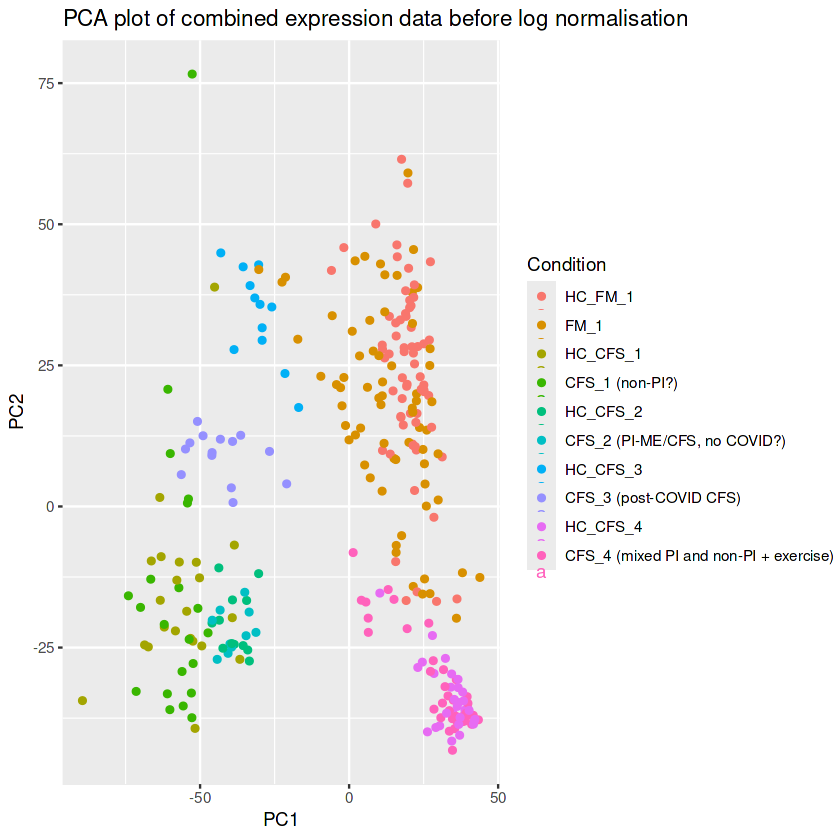

In [ ]:
### PCA plots to visualise classes separations: NO sublasses, BEFORE normalisation

levels_for_vis <- c('HC_FM_1', 'FM_1',
                    'HC_CFS_1', 'CFS_1 (non-PI?)',
                    'HC_CFS_2', 'CFS_2 (PI-ME/CFS, no COVID?)',
                    'HC_CFS_3', 'CFS_3 (post-COVID CFS)',
                    'HC_CFS_4', 'CFS_4 (mixed PI and non-PI + exercise)')

                    pca <- prcomp(X_train, scale. = TRUE)
pca_df <- data.frame(PC1 = pca$x[,1], PC2 = pca$x[,2], Sample = rownames(X_train_norm))

ggplot(pca_df, aes(x = PC1, y = PC2, color = factor(train_samples_info$disease_state, levels = levels_for_vis))) +
  geom_point() +
  geom_text(aes(label = NA), vjust = -1) +  # Add labels for samples
  labs(title = "PCA plot of combined expression data before log normalisation") +
  scale_color_discrete(name = "Condition")

In [ ]:
### Train data log standartisation
### Applying mean and SD calculated for train data on test data

X_train_norm <- log(X_train + 1)
mean_values <- colMeans(X_train_norm)
std_values <- apply(X_train_norm, 2, sd)
X_train_norm <- scale(X_train_norm, center = mean_values, scale = std_values)
rownames(X_train_norm) <- rownames(X_train)
X_train_norm <- as.data.frame(X_train_norm)

X_test_norm <- log(X_test + 1)
X_test_norm <- scale(X_test_norm, center = mean_values, scale = std_values)
rownames(X_test_norm) <- rownames(X_test)
X_test_norm <- as.data.frame(X_test_norm)

Warning message:
“Removed 292 rows containing missing values or values outside the scale range
(`geom_text()`).”
Warning message:
“Removed 292 rows containing missing values or values outside the scale range
(`geom_text()`).”


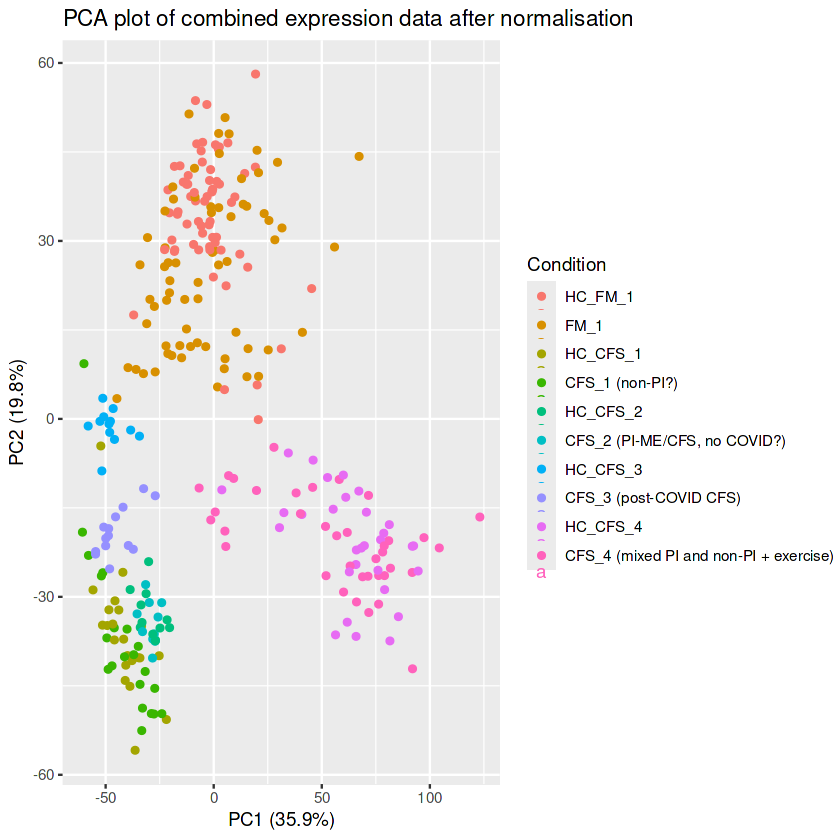

Warning message:
“Removed 292 rows containing missing values or values outside the scale range
(`geom_text()`).”


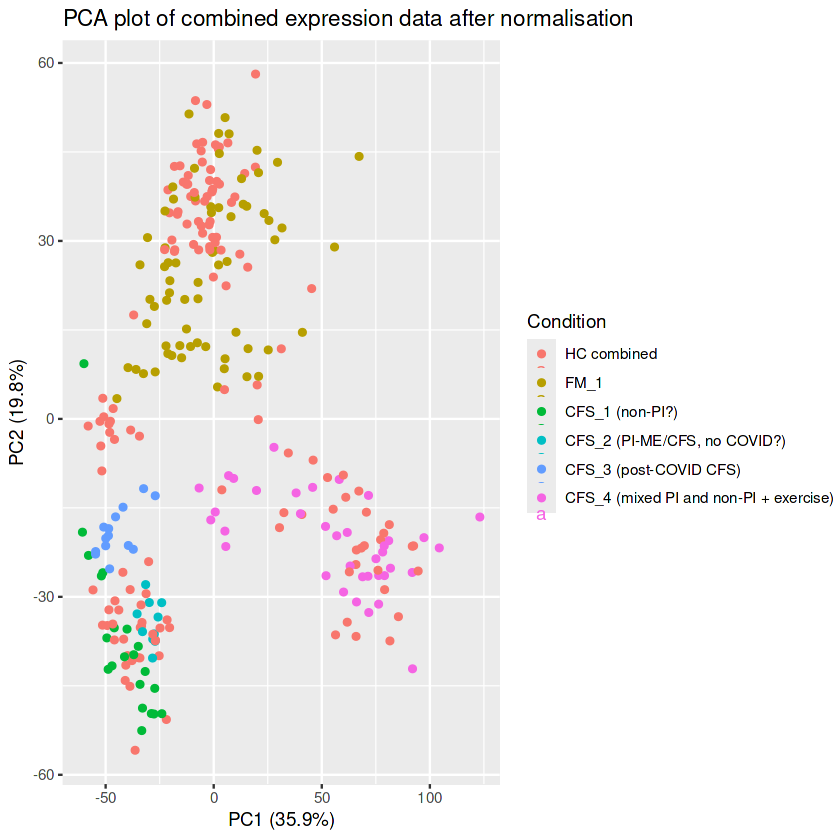

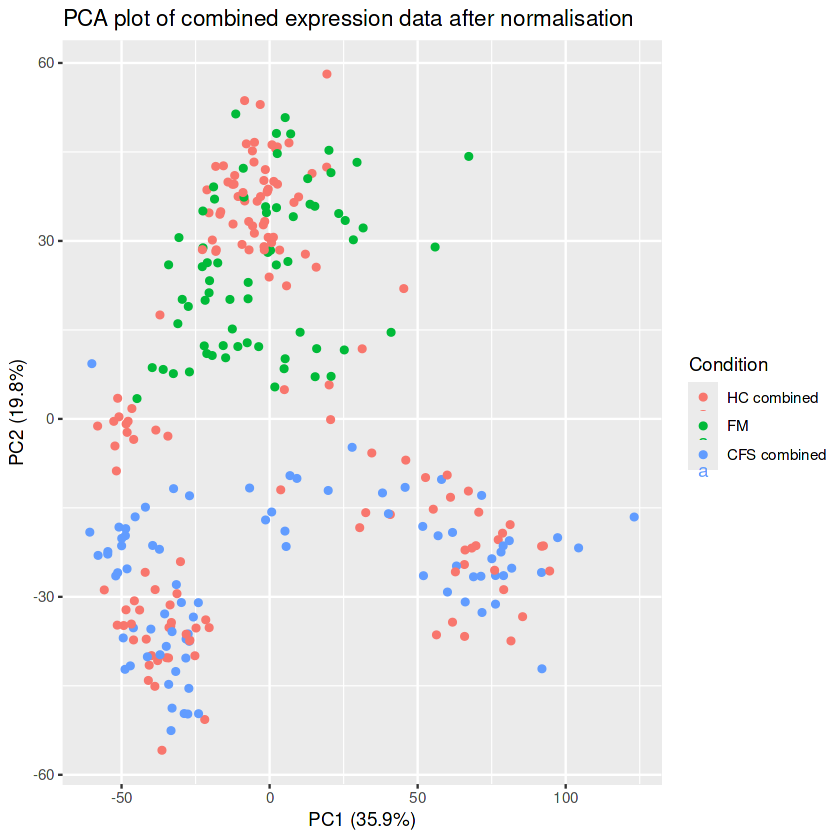

In [ ]:
levels_for_vis_2 <- c('HC combined', 'FM_1','CFS_1 (non-PI?)','CFS_2 (PI-ME/CFS, no COVID?)','CFS_3 (post-COVID CFS)','CFS_4 (mixed PI and non-PI + exercise)')
pca <- prcomp(X_train_norm, scale. = TRUE)
explained_var <- pca$sdev^2 / sum(pca$sdev^2)
percent_PC1 <- round(explained_var[1] * 100, 1)
percent_PC2 <- round(explained_var[2] * 100, 1)
pca_df <- data.frame(PC1 = pca$x[,1], PC2 = pca$x[,2], Sample = rownames(X_train_norm))

### PCA plots to visualise classes separations: NO sublasses, AFTER normalisation
ggplot(pca_df, aes(x = PC1, y = PC2, color = factor(train_samples_info$disease_state, levels = levels_for_vis))) +
  geom_point() +
  geom_text(aes(label = NA), vjust = -1) +  # Add labels for samples
  labs(title = "PCA plot of combined expression data after normalisation",
       x = paste0("PC1 (", percent_PC1, "%)"),
       y = paste0("PC2 (", percent_PC2, "%)")
      ) +
  scale_color_discrete(name = "Condition")

### PCA plots to visualise classes separations: LEVEL 1 sublasses, AFTER normalisation
ggplot(pca_df, aes(x = PC1, y = PC2, color = factor(train_samples_info$disease_state_HC_merged, levels = levels_for_vis_2))) +
  geom_point() +
  geom_text(aes(label = NA), vjust = -1) +  # Add labels for samples
  labs(title = "PCA plot of combined expression data after normalisation",
       x = paste0("PC1 (", percent_PC1, "%)"),
       y = paste0("PC2 (", percent_PC2, "%)")) +
  scale_color_discrete(name = "Condition")

### PCA plots to visualise classes separations: LEVEL 2 sublasses, AFTER normalisation
ggplot(pca_df, aes(x = PC1, y = PC2, color = factor(train_samples_info$disease_state_simplified, levels = c("HC combined", "FM", "CFS combined")))) +
  geom_point() +
  geom_text(aes(label = NA), vjust = -1) +  # Add labels for samples
  labs(title = "PCA plot of combined expression data after normalisation",
       x = paste0("PC1 (", percent_PC1, "%)"),
       y = paste0("PC2 (", percent_PC2, "%)")) +
  scale_color_discrete(name = "Condition")

### Level 1 superclasses

In [ ]:
levels_1 <- c('HC combined', 'FM_1','CFS_1 (non-PI?)','CFS_2 (PI-ME/CFS, no COVID?)','CFS_3 (post-COVID CFS)','CFS_4 (mixed PI and non-PI + exercise)')
levels_2 <- c("HC combined", "FM", "CFS combined")

Y_train_as_factor <- factor(train_samples_info$disease_state_HC_merged, levels=levels_1)
Y_test_as_factor <- factor(test_samples_info$disease_state_HC_merged, levels=levels_1)

In [ ]:
unique_values <- unique(Y_train_as_factor)
unique_values ################# Dont LOOK AT LEVELS !!!
manual_mapping <- c(1, 2, 3, 4, 6, 5)
names(manual_mapping) <- unique_values
Y_train_as_numeric <- as.numeric(manual_mapping[as.character(Y_train_as_factor)])
reverse_mapping_train <- setNames(names(manual_mapping), manual_mapping)

unique_values <- unique(Y_test_as_factor)
unique_values
manual_mapping1 <- c(2, 1, 3, 4, 6, 5)
names(manual_mapping1) <- unique_values
Y_test_as_numeric <- as.numeric(manual_mapping1[as.character(Y_test_as_factor)])
reverse_mapping_test <- setNames(names(manual_mapping), manual_mapping)

[1] HC combined                           
[2] CFS_1 (non-PI?)                       
[3] CFS_2 (PI-ME/CFS, no COVID?)          
[4] CFS_3 (post-COVID CFS)                
[5] FM_1                                  
[6] CFS_4 (mixed PI and non-PI + exercise)
6 Levels: HC combined FM_1 CFS_1 (non-PI?) ... CFS_4 (mixed PI and non-PI + exercise)

[1] CFS_1 (non-PI?)                       
[2] HC combined                           
[3] CFS_2 (PI-ME/CFS, no COVID?)          
[4] CFS_3 (post-COVID CFS)                
[5] FM_1                                  
[6] CFS_4 (mixed PI and non-PI + exercise)
6 Levels: HC combined FM_1 CFS_1 (non-PI?) ... CFS_4 (mixed PI and non-PI + exercise)

In [ ]:
set.seed(123)

GIDs <- list(`FM-CFS_multi` = combined_full_ensg_red2)
for (genelist_name in names(GIDs)) {
    print(paste("Processing gene list:", genelist_name))

    GID <- GIDs[[genelist_name]] # Extract the gene list itself

    X_train_norm_1 <- X_train_norm %>% dplyr::select(all_of(GID))

    # RFE (Recursive Feature Elimination)
    control <- rfeControl(functions = rfFuncs,  # using random forest for feature ranking
                          method = "repeatedcv",
                          number = 10,  # 10-fold cross-validation
                          repeats = 3) # Add repeats for robustness
    rfe_results <- rfe(
      x = X_train_norm_1,
      y = Y_train_as_factor,
      # sizes = seq(5, min(300, ncol(X_train_norm_1)), by = 20), # this run gave 25 variables
      sizes = seq(5, min(55, ncol(X_train_norm_1)), by = 5),
      rfeControl = control
    )

    print(rfe_results)
    qsave(rfe_results, file = paste0("RFE_res_", genelist_name, ".qs"))
    genelist_rfe_predict <- predictors(rfe_results)
    length(genelist_rfe_predict)
    qsave(genelist_rfe_predict, file = paste0("RFE_", genelist_name, ".qs"))

    # Boruta

    boruta_data <- data.frame(Y_train_as_factor = Y_train_as_factor, X_train_norm_1, check.names = FALSE)

    names(boruta_data) <- make.names(names(boruta_data))
    boruta_formula <- as.formula("Y_train_as_factor ~ .")

    boruta_results <- Boruta(
      formula = boruta_formula,
      data = boruta_data,
      doTrace = 2
    )
    boruta_final <- TentativeRoughFix(boruta_results)
    print(boruta_final)
    selected_features <- getSelectedAttributes(boruta_final, withTentative = FALSE)

    selected_features <- lapply(selected_features, function(x) str_remove(x, "^X"))
    qsave(selected_features, file = paste0("Boruta_", genelist_name, ".qs"))
}

[1] "Processing gene list: FM-CFS_multi"

Recursive feature selection

Outer resampling method: Cross-Validated (10 fold, repeated 3 times) 

Resampling performance over subset size:

 Variables Accuracy  Kappa AccuracySD KappaSD Selected
         5   0.6396 0.4625    0.09635  0.1460         
        10   0.6585 0.4891    0.08790  0.1386         
        15   0.6882 0.5344    0.09618  0.1513         
        20   0.6991 0.5493    0.08647  0.1424         
        25   0.6982 0.5478    0.09359  0.1522         
        30   0.6948 0.5421    0.08656  0.1432         
        35   0.6968 0.5445    0.08055  0.1359         
        40   0.7004 0.5495    0.07946  0.1334        *
        45   0.6914 0.5366    0.08139  0.1373         
        50   0.6891 0.5325    0.08091  0.1359         
        55   0.6918 0.5402    0.08874  0.1454         
      4687   0.6834 0.5224    0.08590  0.1340         

The top 5 variables (out of 40):
   ENSG00000170356, ENSG00000156976, ENSG00000148730, ENSG000002147

 1. run of importance source...

 2. run of importance source...

 3. run of importance source...

 4. run of importance source...

 5. run of importance source...

 6. run of importance source...

 7. run of importance source...

 8. run of importance source...

 9. run of importance source...

 10. run of importance source...

 11. run of importance source...

 12. run of importance source...

 13. run of importance source...

 14. run of importance source...

 15. run of importance source...

 16. run of importance source...

 17. run of importance source...

 18. run of importance source...

 19. run of importance source...

After 19 iterations, +47 secs: 

 confirmed 4 attributes: ENSG00000156976, ENSG00000159128, ENSG00000170356, ENSG00000214756;

 rejected 4279 attributes: ENSG00000000419, ENSG00000000938, ENSG00000001561, ENSG00000001629, ENSG00000002822 and 4274 more;

 still have 404 attributes left.


 20. run of importance source...

 21. run of importance source...

 22. r

Boruta performed 99 iterations in 1.379428 mins.
Tentatives roughfixed over the last 99 iterations.
 137 attributes confirmed important: ENSG00000005844, ENSG00000010327,
ENSG00000026025, ENSG00000055044, ENSG00000062716 and 132 more;
 4550 attributes confirmed unimportant: ENSG00000000419,
ENSG00000000457, ENSG00000000938, ENSG00000001561, ENSG00000001629 and
4545 more;


In [ ]:
### Calculating class weights to account imbalances

class_counts <- table(Y_train_as_factor)
total_samples <- sum(class_counts)
num_classes <- length(class_counts)
class_weights_fact <- total_samples / (num_classes * class_counts)

weights_for_logreg <- as.numeric(class_weights_fact[as.character(Y_train_as_factor)])

[1] "------------------------------- Processing gene list: RFE_FM-CFS_multi_LEVEL1 -------------------------------"
[1] "#####################  RF  #####################"
Confusion Matrix and Statistics

                                        Reference
Prediction                               HC combined FM_1 CFS_1 (non-PI?)
  HC combined                                     39    7               4
  FM_1                                             8   21               0
  CFS_1 (non-PI?)                                  1    0               3
  CFS_2 (PI-ME/CFS, no COVID?)                     2    0               0
  CFS_3 (post-COVID CFS)                           0    0               0
  CFS_4 (mixed PI and non-PI + exercise)           4    0               0
                                        Reference
Prediction                               CFS_2 (PI-ME/CFS, no COVID?)
  HC combined                                                       1
  FM_1                                

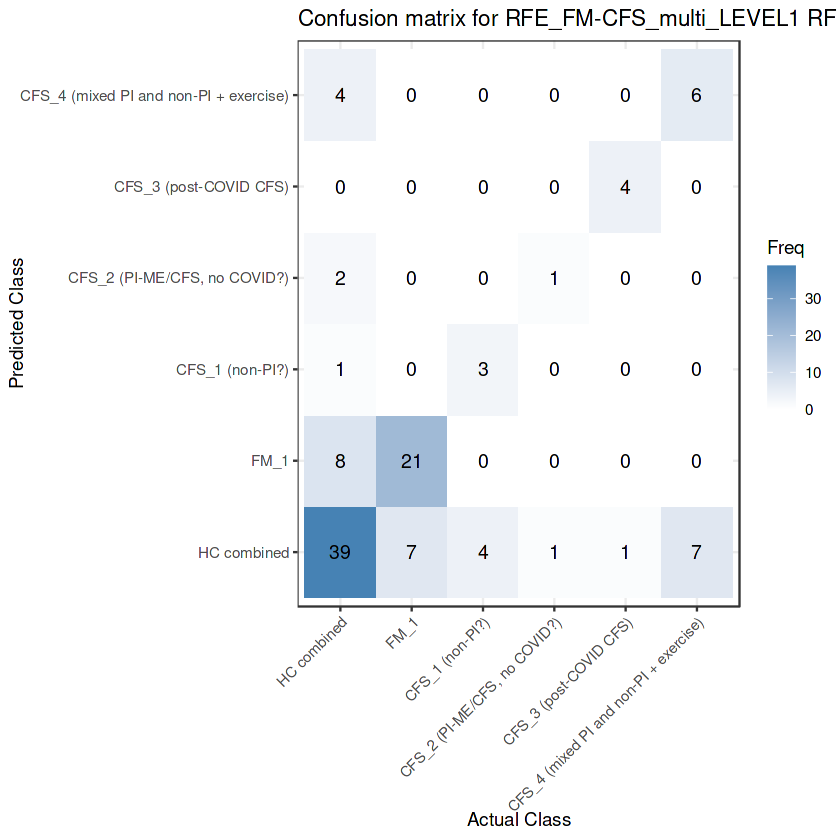

[1] "#####################  LDA  #####################"
$`Confusion matrix`
     [,1] [,2] [,3] [,4] [,5] [,6]
[1,]   28    0    0    1    3   10
[2,]    4    7    0    0    0    0
[3,]    3    0    2    0    0    0
[4,]    3    0    0    4    0    0
[5,]   10    0    0    0   10    0
[6,]    6    0    0    0    0   18

$`(PRE,REC,F-score)`
[1] 0.6330275 0.6330275 0.6330275

$ARI
[1] 0.2184665

Confusion Matrix and Statistics

                                        Reference
Prediction                               HC combined FM_1 CFS_1 (non-PI?)
  HC combined                                     28   10               0
  FM_1                                             6   18               0
  CFS_1 (non-PI?)                                  4    0               7
  CFS_2 (PI-ME/CFS, no COVID?)                     3    0               0
  CFS_3 (post-COVID CFS)                           3    0               0
  CFS_4 (mixed PI and non-PI + exercise)          10    0               0
 

Warning message in lognet(xd, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”
Warning message in lognet(xd, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”


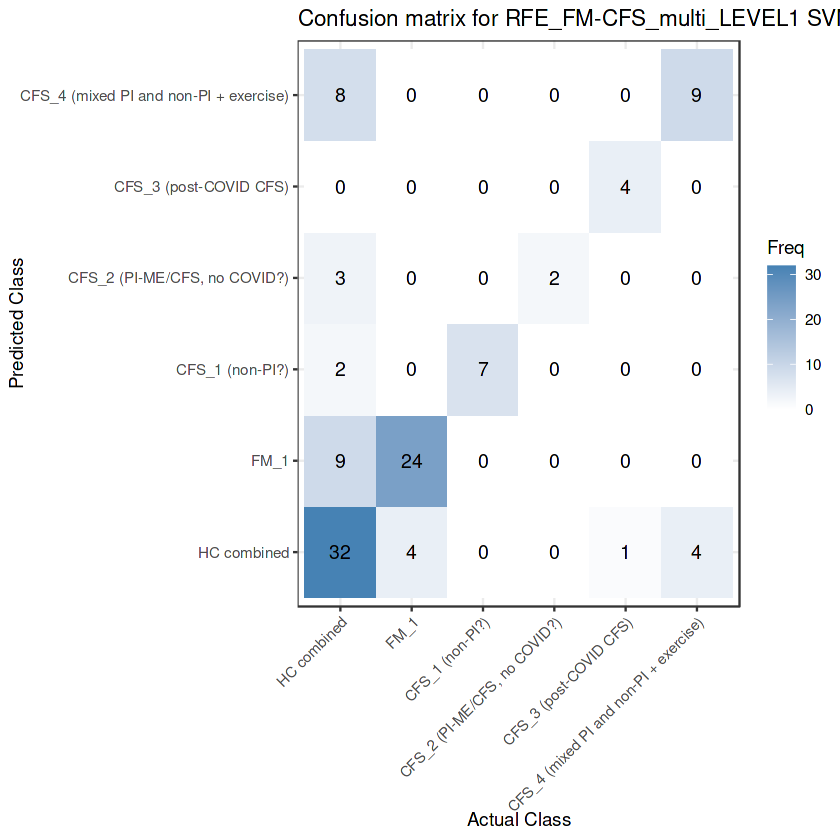

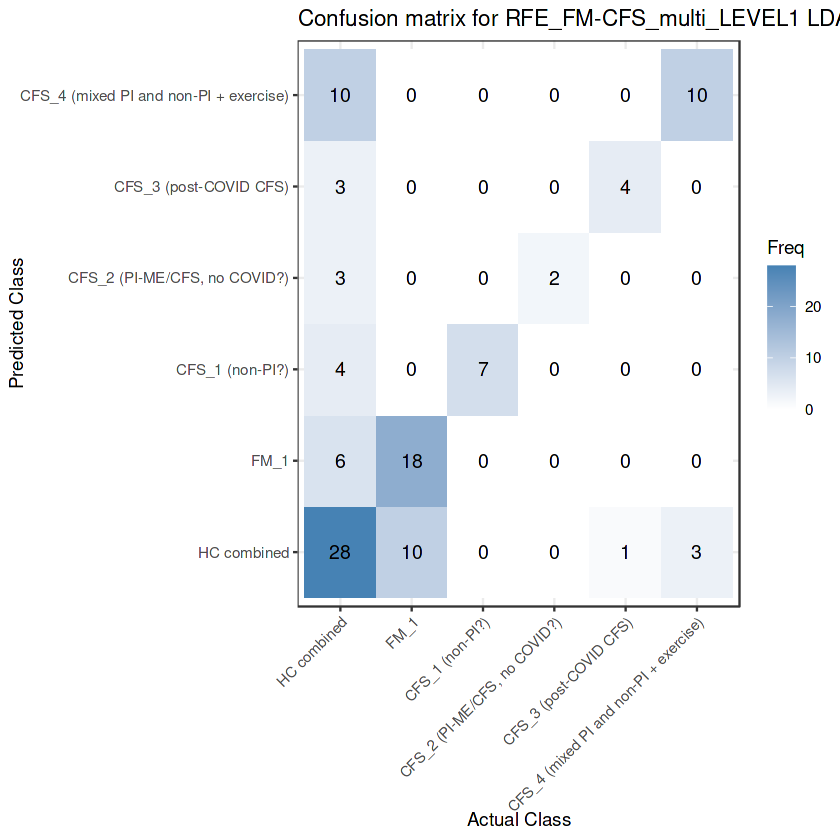

[1] "------------------------------- Processing gene list: Boruta_FM-CFS_multi_LEVEL1 -------------------------------"
[1] "#####################  RF  #####################"
Confusion Matrix and Statistics

                                        Reference
Prediction                               HC combined FM_1 CFS_1 (non-PI?)
  HC combined                                     36    9               4
  FM_1                                            10   19               0
  CFS_1 (non-PI?)                                  1    0               3
  CFS_2 (PI-ME/CFS, no COVID?)                     2    0               0
  CFS_3 (post-COVID CFS)                           0    0               0
  CFS_4 (mixed PI and non-PI + exercise)           5    0               0
                                        Reference
Prediction                               CFS_2 (PI-ME/CFS, no COVID?)
  HC combined                                                       2
  FM_1                             

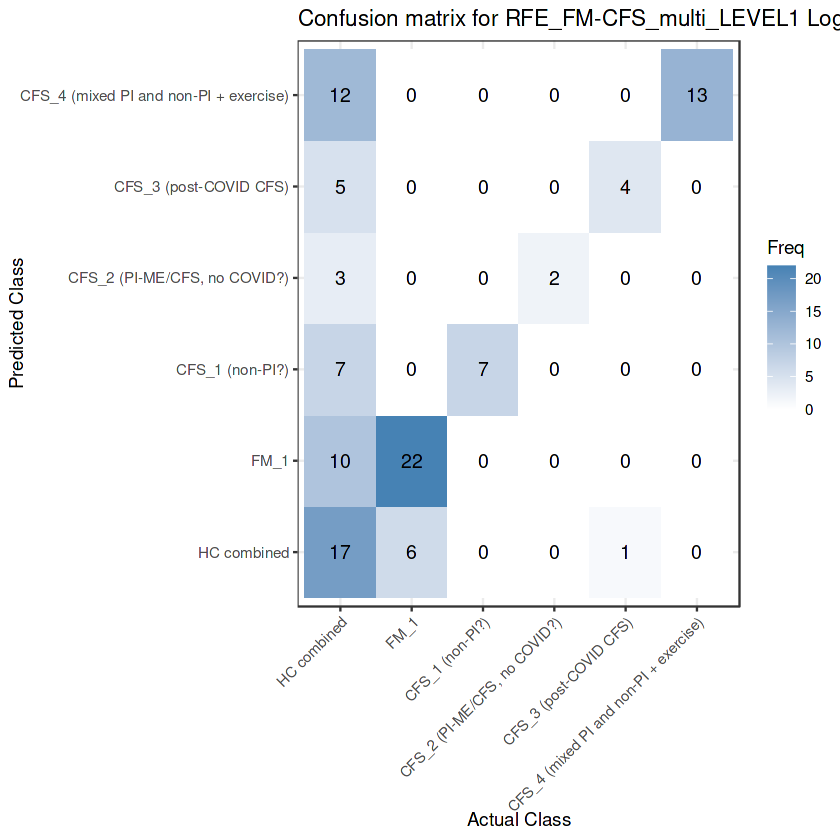

[1] "#####################  SVM  #####################"
Confusion Matrix and Statistics

                                        Reference
Prediction                               HC combined FM_1 CFS_1 (non-PI?)
  HC combined                                     39    6               3
  FM_1                                             9   22               0
  CFS_1 (non-PI?)                                  1    0               4
  CFS_2 (PI-ME/CFS, no COVID?)                     2    0               0
  CFS_3 (post-COVID CFS)                           0    0               0
  CFS_4 (mixed PI and non-PI + exercise)           3    0               0
                                        Reference
Prediction                               CFS_2 (PI-ME/CFS, no COVID?)
  HC combined                                                       2
  FM_1                                                              0
  CFS_1 (non-PI?)                                                   0
  CFS_2 (PI-M

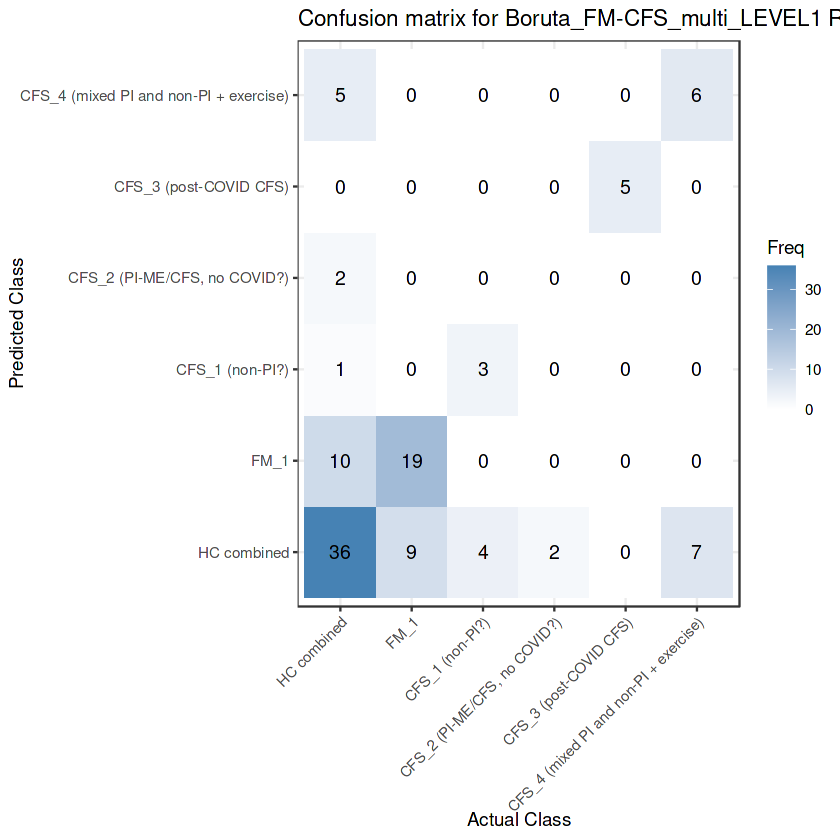

[1] "#####################  LDA  #####################"
$`Confusion matrix`
     [,1] [,2] [,3] [,4] [,5] [,6]
[1,]   35    3    0    0    5    9
[2,]    4    4    0    0    0    0
[3,]    3    0    2    0    0    0
[4,]    0    0    0    5    0    0
[5,]    7    0    0    0    8    0
[6,]    5    0    0    0    0   19

$`(PRE,REC,F-score)`
[1] 0.6697248 0.6697248 0.6697248

$ARI
[1] 0.2591838

Confusion Matrix and Statistics

                                        Reference
Prediction                               HC combined FM_1 CFS_1 (non-PI?)
  HC combined                                     35    9               3
  FM_1                                             5   19               0
  CFS_1 (non-PI?)                                  4    0               4
  CFS_2 (PI-ME/CFS, no COVID?)                     3    0               0
  CFS_3 (post-COVID CFS)                           0    0               0
  CFS_4 (mixed PI and non-PI + exercise)           7    0               0
 

Warning message in lognet(xd, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”


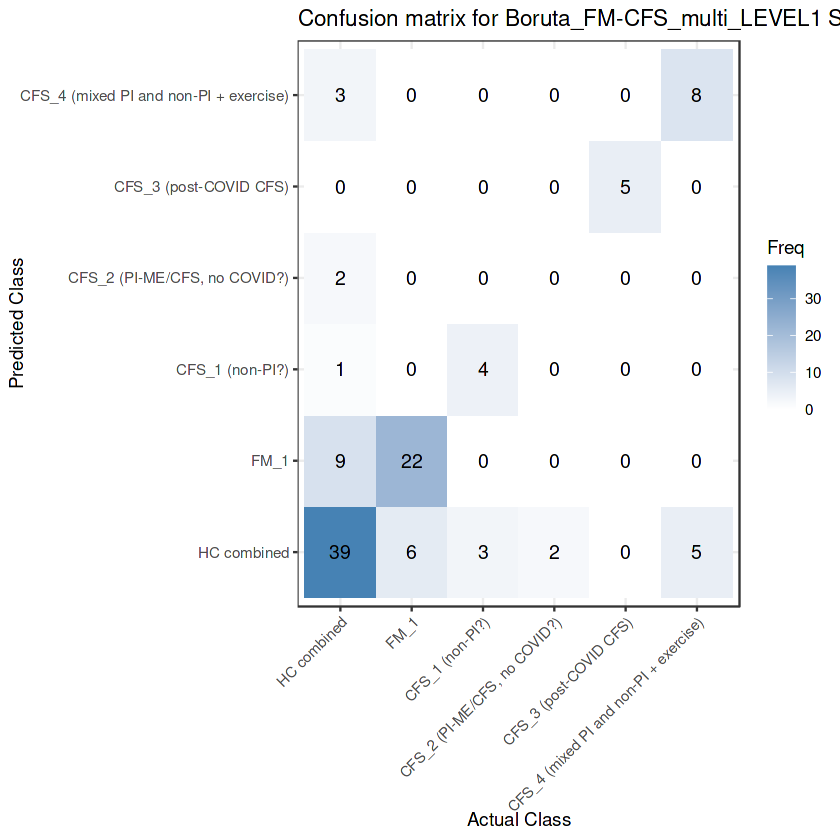

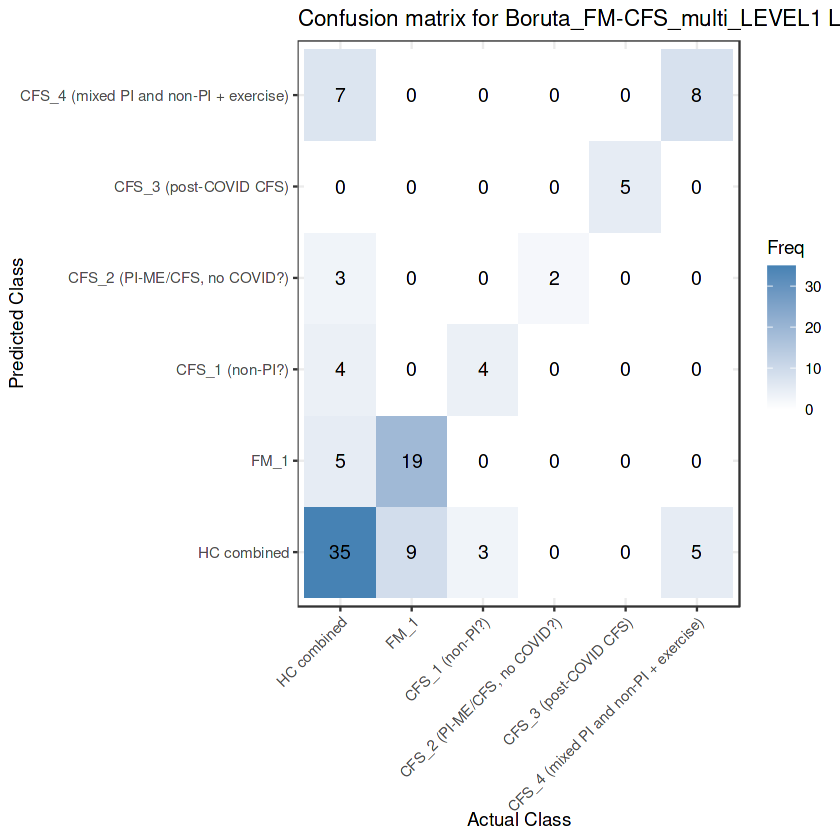

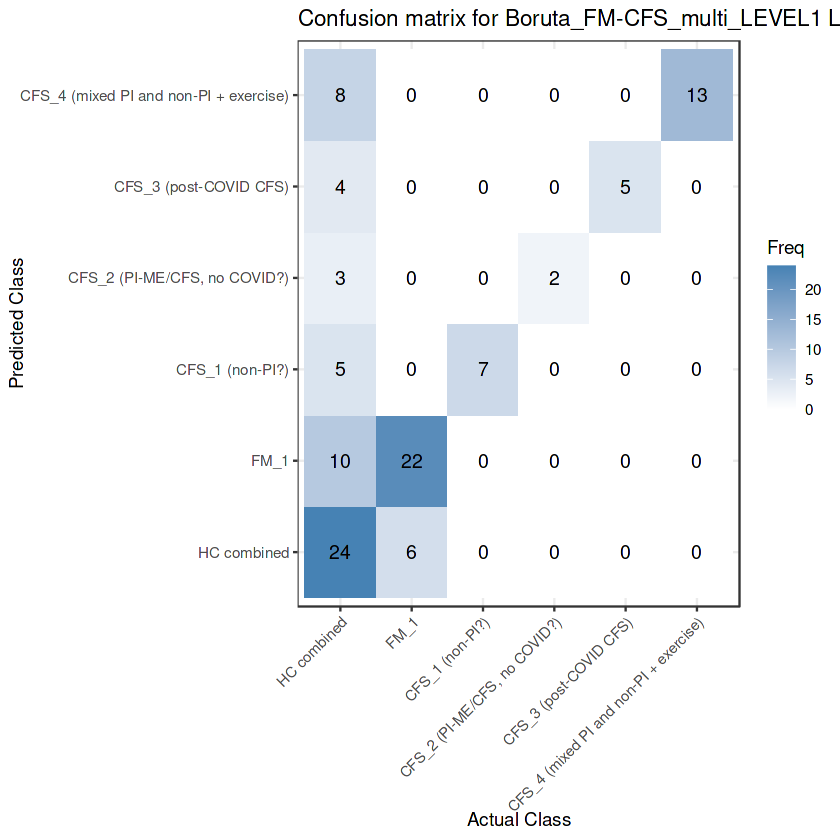

In [ ]:
### Fitting and testing multinomial classification models

genelists <- list(
    `RFE_FM-CFS_multi_LEVEL1`= genelist_rfe_predict,
    `Boruta_FM-CFS_multi_LEVEL1`= as.character(selected_features)
)

accuracy_table <- data.frame(Model = character(), Accuracy = numeric(), F1_scores = numeric(), stat_model = character(), gene_set = character(), stringsAsFactors = FALSE)

set.seed(123)

for (genelist_name in names(genelists)) {
    print(paste("------------------------------- Processing gene list:", genelist_name, "-------------------------------"))
    genelist <- genelists[[genelist_name]]

    print("#####################  RF  #####################")

    rf_model <- randomForest(
      x = X_train_norm[, genelist],
      y = Y_train_as_factor,
      ntree = 1501,
      importance = TRUE,
      classwt = class_weights_fact,  ########### !!!!!!!!!!!!!!!1
      mtry = floor(sqrt(length(genelist)))
    )
    # Evaluate performance on test data
    pred_rf <- predict(rf_model, X_test_norm[, genelist])
    # Confusion matrices for evaluation
    confusion_rf <- confusionMatrix(pred_rf, Y_test_as_factor, mode = "prec_recall") ##### !!!
    print(confusion_rf)

    feature_importance_rf <- as.data.frame(importance(rf_model))
    feature_importance_rf$Feature <- rownames(feature_importance_rf)
    qsave(feature_importance_rf, paste0(genelist_name,"_feature_importance_rf.qs"))

    cm <- as.data.frame(confusion_rf$table)
    names(cm) <- c("Predicted", "Reference", "Freq")
    x <- ggplot(data = cm, aes(x = Reference, y = Predicted, fill = Freq)) +
          geom_tile() +
          geom_text(aes(label = Freq), color = "black", size = 4) +
          scale_fill_gradient(low = "white", high = "steelblue") +
          theme_bw() +
          labs(title = paste0("Confusion matrix for ", genelist_name, " RF"),
               x = "Actual Class",
               y = "Predicted Class") +
          theme(axis.text.x = element_text(angle = 45, hjust = 1),
                axis.text.y = element_text(hjust = 1))
    print(x)
    Sys.sleep(0.1)

    accuracy_rf <- confusion_rf$overall['Accuracy']
    precision <- confusion_rf$byClass[,"Precision"]
    recall <- confusion_rf$byClass[,"Recall"]
    f1_per_class <- 2 * (precision * recall) / (precision + recall)
    macro_f1 <- mean(f1_per_class, na.rm = TRUE)
    accuracy_table <- rbind(accuracy_table, data.frame(Model = paste0(genelist_name,"_RF"), Accuracy = accuracy_rf, F1_score = macro_f1,
                            stat_model = genelist_name, gene_set = "RF"))

    print("#####################  SVM  #####################")

    svm_tuned <- tune(svm,
      Y_train_as_factor ~ .,
      data = data.frame(Y_train_as_factor = Y_train_as_factor, X_train_norm[, genelist], check.names = FALSE),
      kernel = "radial",
      type = "C-classification",
      ranges = list(cost = c(0.01, 0.1, 1, 10, 50, 100),
                    gamma = c(1 / length(genelist), 0.001, 0.01, 0.1, 1, 10)),
      class.weights = class_weights_fact, ########### !!!!!!!!!!!!!!!1
      tunecontrol = tune.control(cross = 10)
    )
    # Print tuning results
    # plot(svm_tuned)
    summary(svm_tuned)
    best_model_svm <- svm_tuned$best.model
    # Evaluate the best model on the test set
    pred_svm <- predict(best_model_svm, X_test_norm[, genelist])
    confusion_svm <- confusionMatrix(pred_svm, Y_test_as_factor, mode = "prec_recall") ##### !!!!
    print(confusion_svm)

    cm <- as.data.frame(confusion_svm$table)
    names(cm) <- c("Predicted", "Reference", "Freq")
    x <- ggplot(data = cm, aes(x = Reference, y = Predicted, fill = Freq)) +
          geom_tile() +
          geom_text(aes(label = Freq), color = "black", size = 4) +
          scale_fill_gradient(low = "white", high = "steelblue") +
          theme_bw() +
          labs(title = paste0("Confusion matrix for ", genelist_name, " SVM"),
               x = "Actual Class",
               y = "Predicted Class") +
          theme(axis.text.x = element_text(angle = 45, hjust = 1),
                axis.text.y = element_text(hjust = 1))
    print(x)
    Sys.sleep(0.1)

    accuracy_svm <- confusion_svm$overall['Accuracy']
    precision <- confusion_svm$byClass[,"Precision"]
    recall <- confusion_svm$byClass[,"Recall"]
    f1_per_class <- 2 * (precision * recall) / (precision + recall)
    macro_f1 <- mean(f1_per_class, na.rm = TRUE)

    accuracy_table <- rbind(accuracy_table, data.frame(Model = paste0(genelist_name,"_SVM"), Accuracy = accuracy_svm, F1_score = macro_f1,
                            stat_model = genelist_name, gene_set = "SVM"))


    print("#####################  LDA  #####################")

    NetLDA <- NetDA(X_train_norm[, genelist],
                    Y_train_as_numeric,
                    method=1,
                    X_test_norm[, genelist])
    yhat_lda <- NetLDA$yhat
    print(Metrics(yhat_lda, Y_test_as_numeric))

    yhat_lda_as_factor <- factor(reverse_mapping_train[as.character(yhat_lda)], levels = levels(Y_test_as_factor)) ############# !!!!!!!!!!!!!1
    confusion_netlda <- confusionMatrix(yhat_lda_as_factor, Y_test_as_factor, mode = "everything")
    print(confusion_netlda)

    cm <- as.data.frame(confusion_netlda$table)
    names(cm) <- c("Predicted", "Reference", "Freq")
    x <- ggplot(data = cm, aes(x = Reference, y = Predicted, fill = Freq)) +
          geom_tile() +
          geom_text(aes(label = Freq), color = "black", size = 4) +
          scale_fill_gradient(low = "white", high = "steelblue") +
          theme_bw() +
          labs(title = paste0("Confusion matrix for ", genelist_name, " LDA"),
               x = "Actual Class",
               y = "Predicted Class") +
          theme(axis.text.x = element_text(angle = 45, hjust = 1),
                axis.text.y = element_text(hjust = 1))
    print(x)
    Sys.sleep(0.1)

    accuracy_netlda <- confusion_netlda$overall['Accuracy']
    precision <- confusion_netlda$byClass[,"Precision"]
    recall <- confusion_netlda$byClass[,"Recall"]
    f1_per_class <- 2 * (precision * recall) / (precision + recall)
    macro_f1 <- mean(f1_per_class, na.rm = TRUE)

    accuracy_table <- rbind(accuracy_table, data.frame(Model = paste0(genelist_name,"_LDA"), Accuracy = accuracy_netlda, F1_score = macro_f1,
                            stat_model = genelist_name, gene_set = "LDA"))



    print("#####################  LogReg  #####################")

    cvfit <- cv.glmnet(as.matrix(X_train_norm[, genelist]), Y_train_as_factor, family = "multinomial", weights=weights_for_logreg, nfolds = 10) ###!!!!!!!!!
    coefs <- coef(cvfit, s = "lambda.min")

    pred_logistic <- predict(cvfit, newx = as.matrix(X_test_norm[, genelist]), family = "multinomial", type='class', s = "lambda.min")
    pred_logistic <- factor(pred_logistic, levels=levels(Y_test_as_factor))
    confusion_logistic <- confusionMatrix(pred_logistic, Y_test_as_factor, mode = "prec_recall")

    qsave(coefs, paste0(genelist_name, "_coefs_logreg.qs"))

    cm <- as.data.frame(confusion_logistic$table)
    names(cm) <- c("Predicted", "Reference", "Freq")
    x <- ggplot(data = cm, aes(x = Reference, y = Predicted, fill = Freq)) +
          geom_tile() +
          geom_text(aes(label = Freq), color = "black", size = 4) +
          scale_fill_gradient(low = "white", high = "steelblue") +
          theme_bw() +
          labs(title = paste0("Confusion matrix for ", genelist_name, " LogReg"),
               x = "Actual Class",
               y = "Predicted Class") +
          theme(axis.text.x = element_text(angle = 45, hjust = 1),
                axis.text.y = element_text(hjust = 1))
    print(x)
    Sys.sleep(0.1)

    accuracy_logistic <- confusion_logistic$overall['Accuracy']
    precision <- confusion_logistic$byClass[,"Precision"]
    recall <- confusion_logistic$byClass[,"Recall"]
    f1_per_class <- 2 * (precision * recall) / (precision + recall)
    macro_f1 <- mean(f1_per_class, na.rm = TRUE)

    accuracy_table <- rbind(accuracy_table, data.frame(Model = paste0(genelist_name,"_LogReg"), Accuracy = accuracy_logistic, F1_score = macro_f1,
                                                       stat_model = genelist_name, gene_set = "LogReg"))

}

In [ ]:
# Calculating accuracy for baseline model

table(Y_train_as_factor)
majority_class <- "HC combined"
Y_pred_zeroR <- factor(rep(majority_class, length(Y_test_as_factor)), levels=levels(Y_test_as_factor))

confusion_matrix_baseline <- confusionMatrix(Y_pred_zeroR, Y_test_as_factor, mode="prec_recall")
   precision <- confusion_matrix_baseline$byClass[,"Precision"]
   accuracy_baseline <- confusion_matrix_baseline$overall['Accuracy']
   recall <- confusion_matrix_baseline$byClass[,"Recall"]
   f1_per_class <- 2 * (precision * recall) / (precision + recall)
   macro_f1_baseline <- mean(f1_per_class, na.rm = TRUE)

confusion_matrix_baseline

Y_train_as_factor
                           HC combined                                   FM_1 
                                   142                                     68 
                       CFS_1 (non-PI?)           CFS_2 (PI-ME/CFS, no COVID?) 
                                    21                                     10 
                CFS_3 (post-COVID CFS) CFS_4 (mixed PI and non-PI + exercise) 
                                    14                                     37 

Confusion Matrix and Statistics

                                        Reference
Prediction                               HC combined FM_1 CFS_1 (non-PI?)
  HC combined                                     54   28               7
  FM_1                                             0    0               0
  CFS_1 (non-PI?)                                  0    0               0
  CFS_2 (PI-ME/CFS, no COVID?)                     0    0               0
  CFS_3 (post-COVID CFS)                           0    0               0
  CFS_4 (mixed PI and non-PI + exercise)           0    0               0
                                        Reference
Prediction                               CFS_2 (PI-ME/CFS, no COVID?)
  HC combined                                                       2
  FM_1                                                              0
  CFS_1 (non-PI?)                                                   0
  CFS_2 (PI-ME/CFS, no COVID?)                                      0

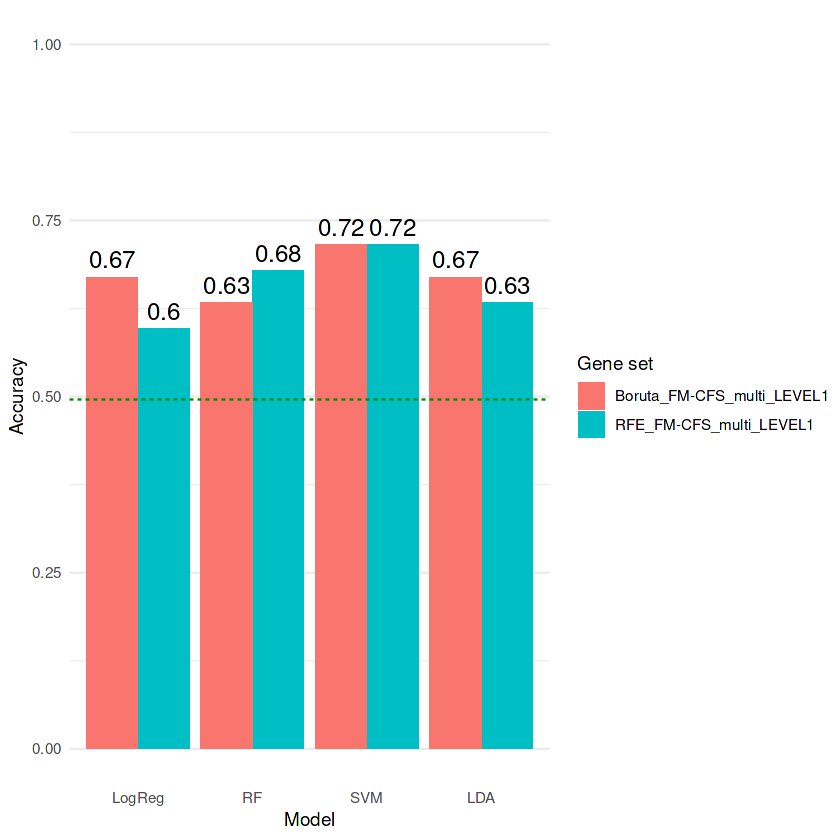

In [ ]:
### Barplot with accuracies

colnames(accuracy_table) <- c("model_id", "Accuracy", "F1_score", "Gene set", "Model")
accuracy_table$`Model` <- factor(accuracy_table$`Model`, levels = c("LogReg", "RF", "SVM", "LDA"))

ggplot(accuracy_table, aes(fill=`Gene set`, y=Accuracy, x=`Model`)) +
  geom_bar(position="dodge", stat="identity") +
  geom_hline(yintercept = accuracy_baseline, linetype = "dashed", color = "green4") +
  scale_y_continuous(limits = c(0, 1)) +
  geom_text(aes(label = round(Accuracy, 2)),
            position = position_dodge(0.9),
            vjust = -0.5,
            size = 5) +
  theme_minimal() +
  theme(
    panel.grid.major.x = element_blank(),
    panel.grid.minor.x = element_blank()
  )

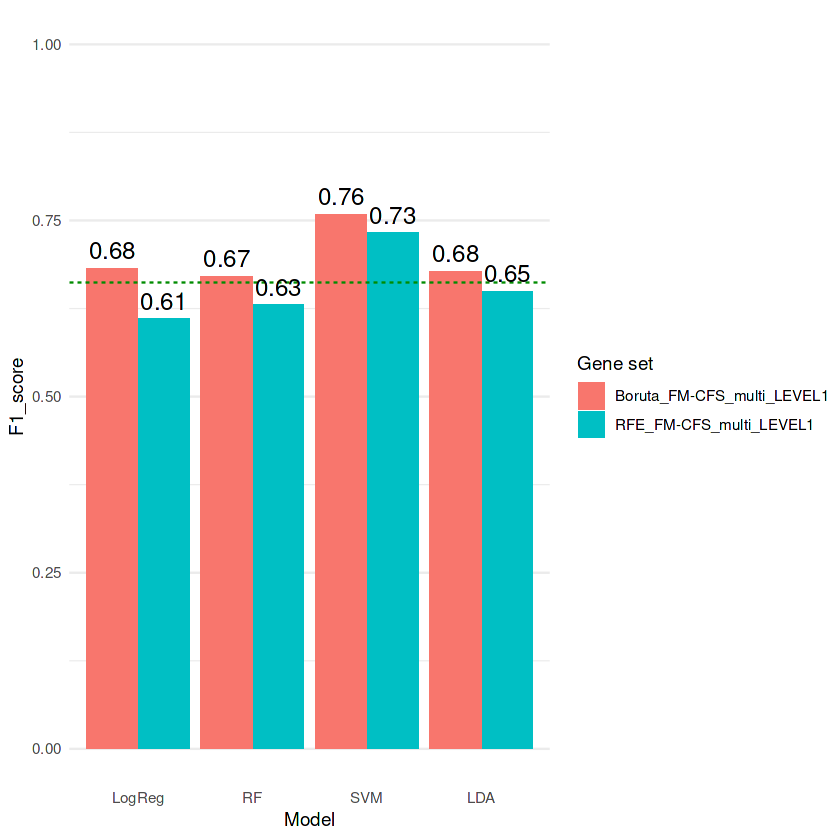

In [ ]:
### Barplot with F1-scores

ggplot(accuracy_table, aes(fill=`Gene set`, y=F1_score, x=`Model`)) +
  geom_bar(position="dodge", stat="identity") +
  geom_hline(yintercept = macro_f1_baseline, linetype = "dashed", color = "green4") +
  scale_y_continuous(limits = c(0, 1)) +
  geom_text(aes(label = round(F1_score, 2)),
            position = position_dodge(0.9),
            vjust = -0.5,
            size = 5) +
  theme_minimal() +
  theme(
    panel.grid.major.x = element_blank(),
    panel.grid.minor.x = element_blank()
  )

### Level 2 superclasses

In [ ]:
Y_train_as_factor <- factor(train_samples_info$disease_state_simplified, levels=levels_2)
Y_test_as_factor <- factor(test_samples_info$disease_state_simplified, levels=levels_2)

unique_values <- unique(Y_train_as_factor)
unique_values ################# Dont LOOK AT LEVELS !!!
manual_mapping <- c(1, 2, 3)
names(manual_mapping) <- unique_values
Y_train_as_numeric <- as.numeric(manual_mapping[as.character(Y_train_as_factor)])
reverse_mapping_train <- setNames(names(manual_mapping), manual_mapping)

unique_values <- unique(Y_test_as_factor)
unique_values
manual_mapping1 <- c(2, 1, 3)
names(manual_mapping1) <- unique_values
Y_test_as_numeric <- as.numeric(manual_mapping1[as.character(Y_test_as_factor)])
reverse_mapping_test <- setNames(names(manual_mapping), manual_mapping)

[1] HC combined  CFS combined FM          
Levels: HC combined FM CFS combined

[1] CFS combined HC combined  FM          
Levels: HC combined FM CFS combined

In [ ]:
set.seed(123)

GIDs <- list(`FM-CFS_multi` = combined_full_ensg_red2)
for (genelist_name in names(GIDs)) {  # Iterate over the *names* of the GIDs list
    print(paste("Processing gene list:", genelist_name))

    GID <- GIDs[[genelist_name]] # Extract the gene list itself

    X_train_norm_1 <- X_train_norm %>% dplyr::select(all_of(GID))

    # RFE (Recursive Feature Elimination)
    control <- rfeControl(functions = rfFuncs,  # using random forest for feature ranking
                          method = "repeatedcv",
                          number = 10,  # 10-fold cross-validation
                          repeats = 3) # Add repeats for robustness
    rfe_results <- rfe(
      x = X_train_norm_1,
      y = Y_train_as_factor,
      sizes = seq(10, min(100, ncol(X_train_norm_1)), by = 5),
      rfeControl = control
    )

    print(rfe_results)
    qsave(rfe_results, file = paste0("RFE_res_", genelist_name, ".qs"))
    genelist_rfe_predict <- predictors(rfe_results)
    length(genelist_rfe_predict)
    qsave(genelist_rfe_predict, file = paste0("RFE_", genelist_name, ".qs"))

    # Boruta

    boruta_data <- data.frame(Y_train_as_factor = Y_train_as_factor, X_train_norm_1, check.names = FALSE)
    names(boruta_data) <- make.names(names(boruta_data))
    boruta_formula <- as.formula("Y_train_as_factor ~ .")

    boruta_results <- Boruta(
      formula = boruta_formula,
      data = boruta_data,
      doTrace = 2
    )
    boruta_final <- TentativeRoughFix(boruta_results)
    print(boruta_final)
    selected_features <- getSelectedAttributes(boruta_final, withTentative = FALSE)

    selected_features <- lapply(selected_features, function(x) str_remove(x, "^X"))
    qsave(selected_features, file = paste0("Boruta_", genelist_name, ".qs"))
}

[1] "Processing gene list: FM-CFS_multi"

Recursive feature selection

Outer resampling method: Cross-Validated (10 fold, repeated 3 times) 

Resampling performance over subset size:

 Variables Accuracy  Kappa AccuracySD KappaSD Selected
        10   0.6852 0.4977    0.07011  0.1147         
        15   0.7216 0.5592    0.06827  0.1091         
        20   0.7078 0.5366    0.07665  0.1247         
        25   0.7234 0.5593    0.07609  0.1230         
        30   0.7154 0.5472    0.07095  0.1154         
        35   0.7213 0.5567    0.07611  0.1265         
        40   0.7110 0.5418    0.07729  0.1242         
        45   0.7030 0.5284    0.07888  0.1271         
        50   0.7166 0.5501    0.07456  0.1202         
        55   0.7213 0.5566    0.06730  0.1113         
        60   0.7133 0.5432    0.07220  0.1178         
        65   0.7156 0.5468    0.07819  0.1292         
        70   0.7237 0.5585    0.07017  0.1169        *
        75   0.7099 0.5374    0.07283  0.1184 

 1. run of importance source...

 2. run of importance source...

 3. run of importance source...

 4. run of importance source...

 5. run of importance source...

 6. run of importance source...

 7. run of importance source...

 8. run of importance source...

 9. run of importance source...

 10. run of importance source...

 11. run of importance source...

 12. run of importance source...

 13. run of importance source...

 14. run of importance source...

 15. run of importance source...

 16. run of importance source...

 17. run of importance source...

 18. run of importance source...

 19. run of importance source...

After 19 iterations, +41 secs: 

 confirmed 4 attributes: ENSG00000148730, ENSG00000156976, ENSG00000170356, ENSG00000214756;

 rejected 4484 attributes: ENSG00000000419, ENSG00000000457, ENSG00000000938, ENSG00000001561, ENSG00000001629 and 4479 more;

 still have 199 attributes left.


 20. run of importance source...

 21. run of importance source...

 22. r

Boruta performed 99 iterations in 1.060878 mins.
Tentatives roughfixed over the last 99 iterations.
 93 attributes confirmed important: ENSG00000026025, ENSG00000030582,
ENSG00000066084, ENSG00000066336, ENSG00000070614 and 88 more;
 4594 attributes confirmed unimportant: ENSG00000000419,
ENSG00000000457, ENSG00000000938, ENSG00000001561, ENSG00000001629 and
4589 more;


In [ ]:
class_counts <- table(Y_train_as_factor)
total_samples <- sum(class_counts)
num_classes <- length(class_counts)
class_weights_fact <- total_samples / (num_classes * class_counts)

weights_for_logreg <- as.numeric(class_weights_fact[as.character(Y_train_as_factor)])

[1] "------------------------------- Processing gene list: RFE_FM-CFS_multi_LEVEL2 -------------------------------"
[1] "#####################  RF  #####################"
Confusion Matrix and Statistics

              Reference
Prediction     HC combined FM CFS combined
  HC combined           37  7           14
  FM                     9 21            0
  CFS combined           8  0           13

Overall Statistics
                                          
               Accuracy : 0.6514          
                 95% CI : (0.5542, 0.7401)
    No Information Rate : 0.4954          
    P-Value [Acc > NIR] : 0.0007347       
                                          
                  Kappa : 0.4358          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: HC combined Class: FM Class: CFS combined
Precision                        0.6379    0.7000              0.6190
Recall                        

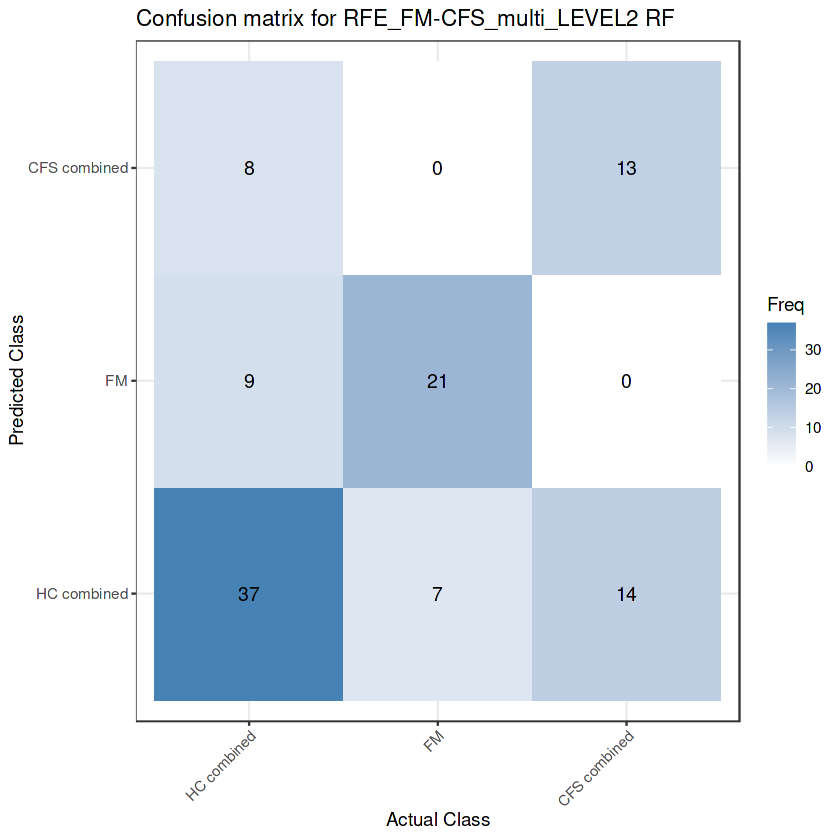

[1] "#####################  LDA  #####################"
$`Confusion matrix`
     [,1] [,2] [,3]
[1,]   32   10   10
[2,]   16   17    0
[3,]    6    0   18

$`(PRE,REC,F-score)`
[1] 0.6146789 0.6146789 0.6146789

$ARI
[1] 0.167491

Confusion Matrix and Statistics

              Reference
Prediction     HC combined FM CFS combined
  HC combined           32 10           10
  FM                     6 18            0
  CFS combined          16  0           17

Overall Statistics
                                          
               Accuracy : 0.6147          
                 95% CI : (0.5166, 0.7063)
    No Information Rate : 0.4954          
    P-Value [Acc > NIR] : 0.008151        
                                          
                  Kappa : 0.3904          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: HC combined Class: FM Class: CFS combined
Sensitivity                      0.5926

Warning message:
“from glmnet C++ code (error code -99); Convergence for 99th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -81); Convergence for 81th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -88); Convergence for 88th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -98); Convergence for 98th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -99); Convergence for 99th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


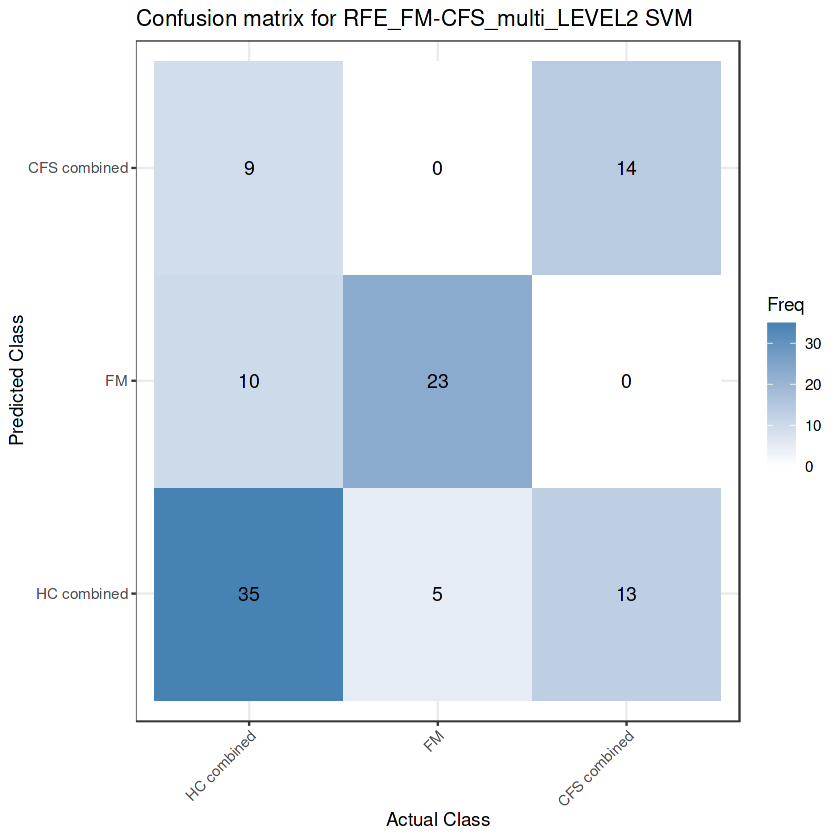

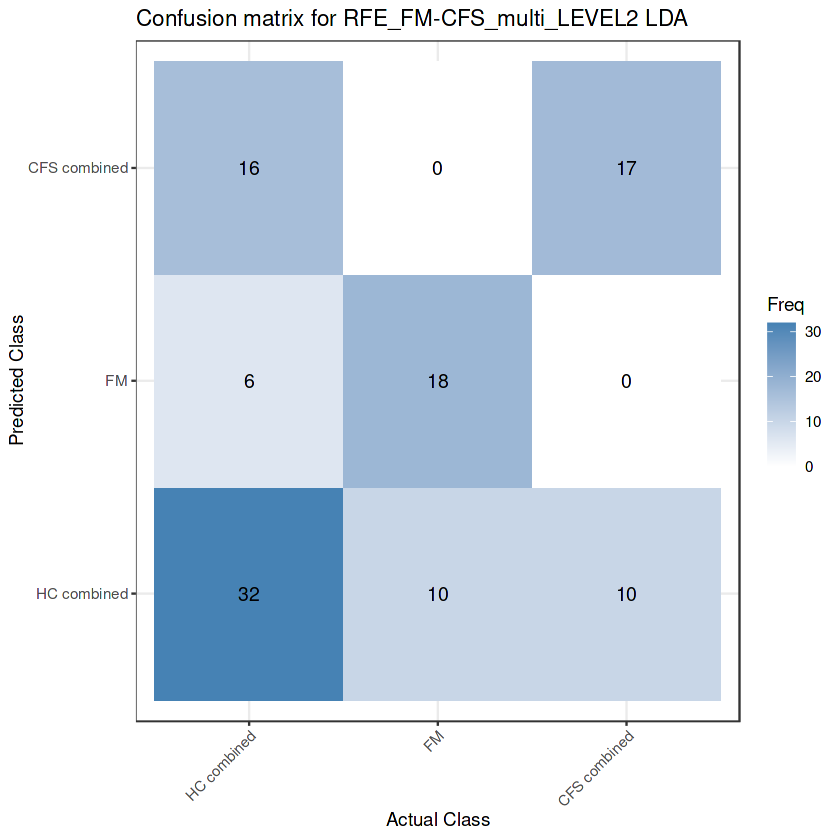

[1] "------------------------------- Processing gene list: Boruta_FM-CFS_multi_LEVEL2 -------------------------------"
[1] "#####################  RF  #####################"
Confusion Matrix and Statistics

              Reference
Prediction     HC combined FM CFS combined
  HC combined           36  7           13
  FM                     9 21            0
  CFS combined           9  0           14

Overall Statistics
                                          
               Accuracy : 0.6514          
                 95% CI : (0.5542, 0.7401)
    No Information Rate : 0.4954          
    P-Value [Acc > NIR] : 0.0007347       
                                          
                  Kappa : 0.44            
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: HC combined Class: FM Class: CFS combined
Precision                        0.6429    0.7000              0.6087
Recall                     

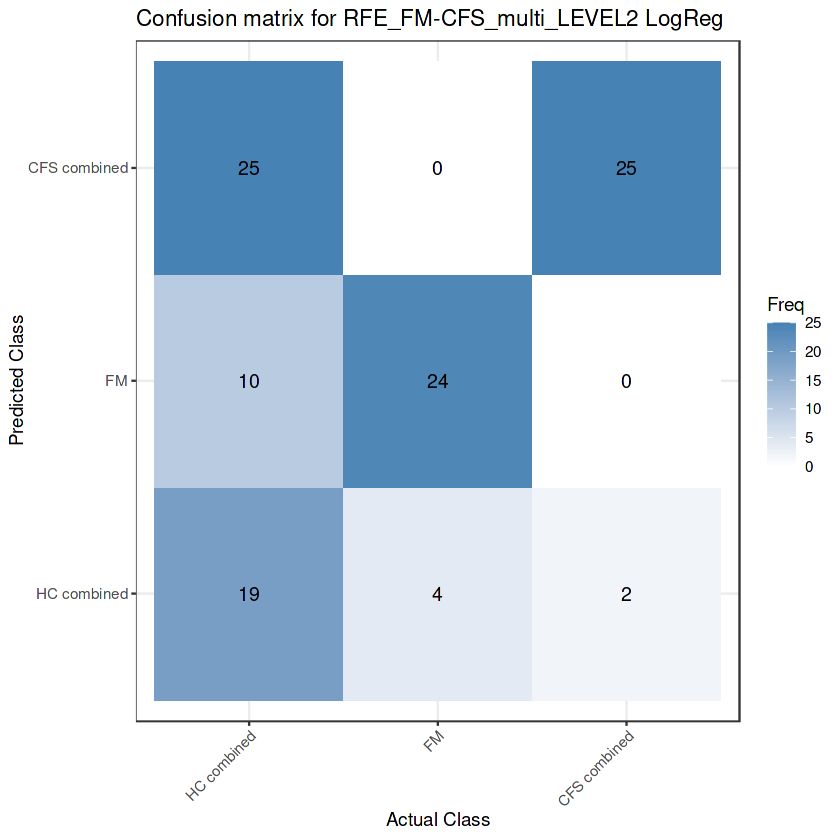

[1] "#####################  SVM  #####################"
Confusion Matrix and Statistics

              Reference
Prediction     HC combined FM CFS combined
  HC combined           35  4           10
  FM                     9 24            0
  CFS combined          10  0           17

Overall Statistics
                                          
               Accuracy : 0.6972          
                 95% CI : (0.6019, 0.7816)
    No Information Rate : 0.4954          
    P-Value [Acc > NIR] : 1.543e-05       
                                          
                  Kappa : 0.5256          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: HC combined Class: FM Class: CFS combined
Precision                        0.7143    0.7273              0.6296
Recall                           0.6481    0.8571              0.6296
F1                               0.6796    0.7869              0.6296
Preva

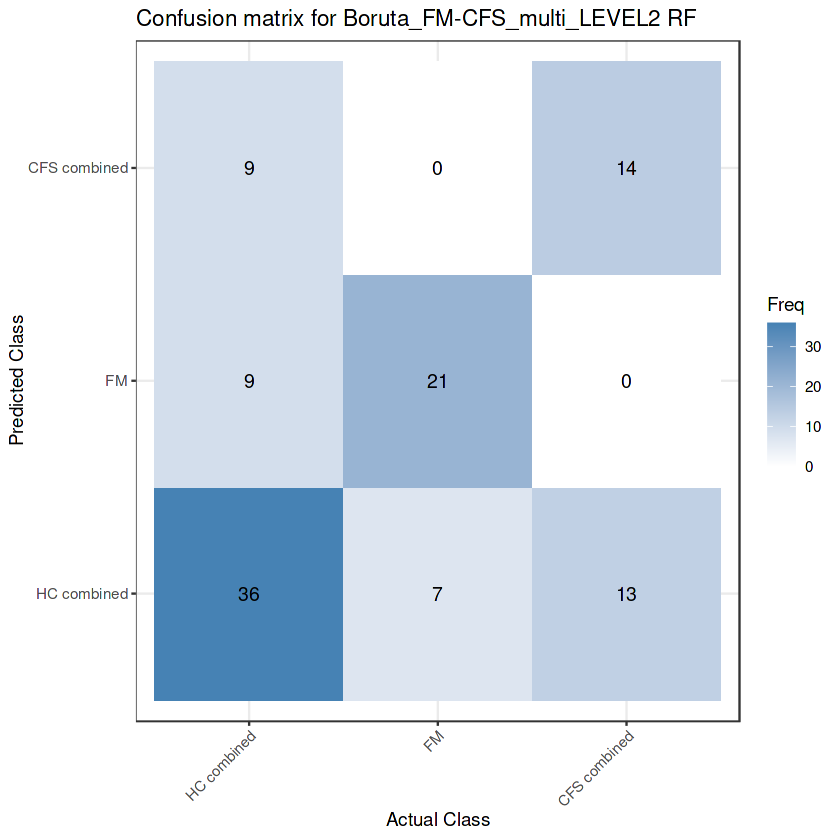

[1] "#####################  LDA  #####################"
$`Confusion matrix`
     [,1] [,2] [,3]
[1,]   35   11    8
[2,]   13   16    1
[3,]    6    0   19

$`(PRE,REC,F-score)`
[1] 0.6422018 0.6422018 0.6422018

$ARI
[1] 0.1952564

Confusion Matrix and Statistics

              Reference
Prediction     HC combined FM CFS combined
  HC combined           35  8           11
  FM                     6 19            0
  CFS combined          13  1           16

Overall Statistics
                                          
               Accuracy : 0.6422          
                 95% CI : (0.5447, 0.7317)
    No Information Rate : 0.4954          
    P-Value [Acc > NIR] : 0.001417        
                                          
                  Kappa : 0.4298          
                                          
 Mcnemar's Test P-Value : 0.693304        

Statistics by Class:

                     Class: HC combined Class: FM Class: CFS combined
Sensitivity                      0.648

Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -72); Convergence for 72th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -70); Convergence for 70th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -94); Convergence for 94th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -78); Convergence for 78th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -88); Convergence for 88th lambda value not reached after maxit=100000 iterations;

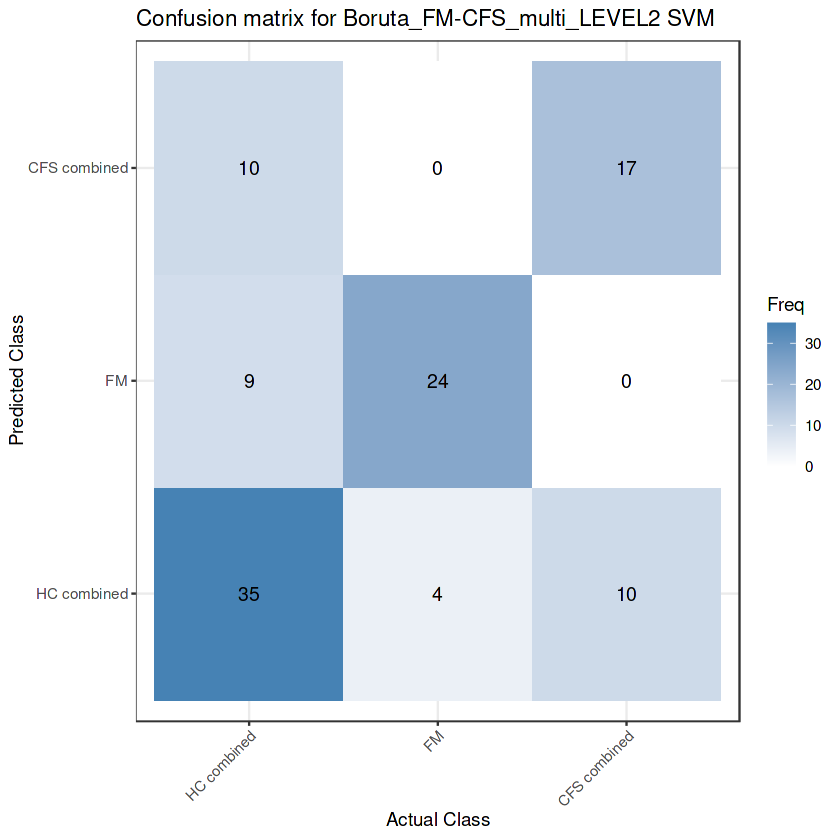

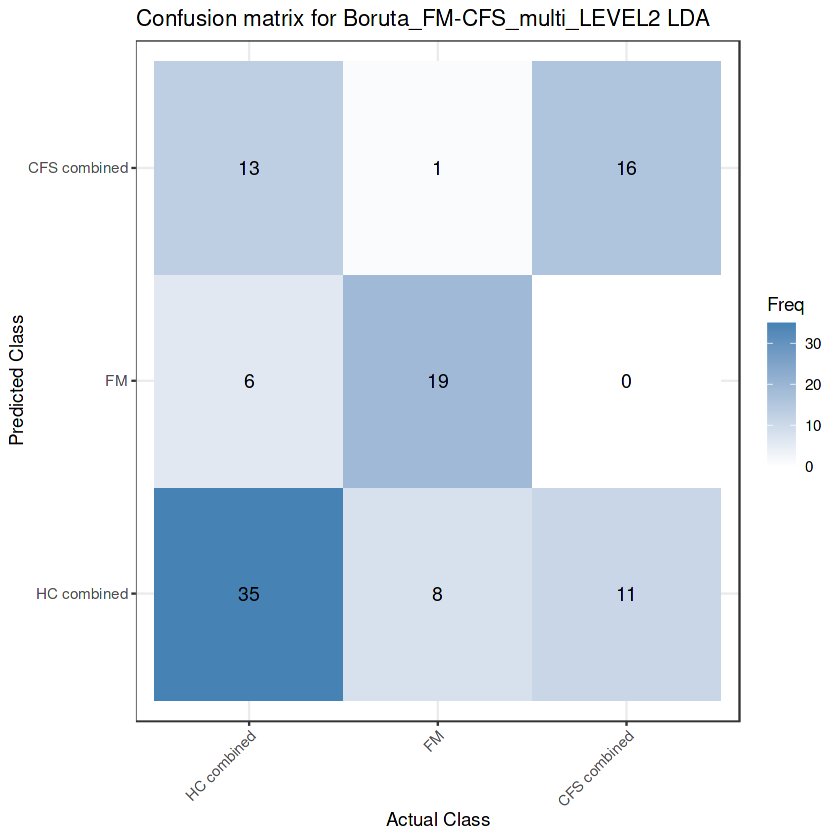

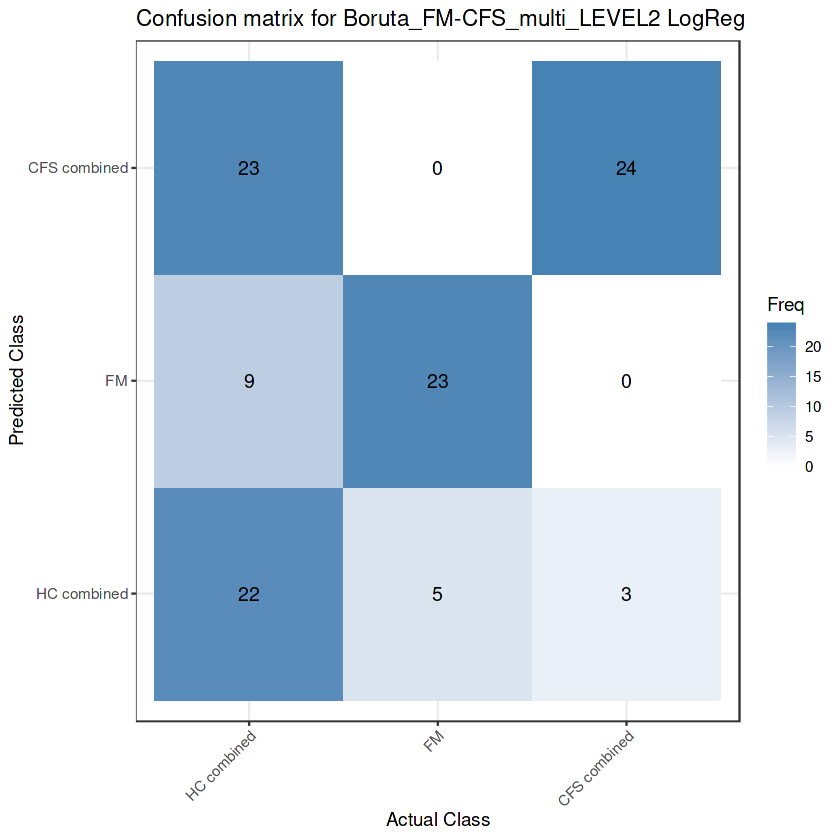

In [ ]:
genelists <- list(
    `RFE_FM-CFS_multi_LEVEL2`= genelist_rfe_predict,
    `Boruta_FM-CFS_multi_LEVEL2`= as.character(selected_features)
)


accuracy_table <- data.frame(Model = character(), Accuracy = numeric(), F1_scores = numeric(), stat_model = character(), gene_set = character(), stringsAsFactors = FALSE)

set.seed(123)

for (genelist_name in names(genelists)) {
    print(paste("------------------------------- Processing gene list:", genelist_name, "-------------------------------"))
    genelist <- genelists[[genelist_name]]

    print("#####################  RF  #####################")

    rf_model <- randomForest(
      x = X_train_norm[, genelist],
      y = Y_train_as_factor,
      ntree = 1501,
      importance = TRUE,
      classwt = class_weights_fact,  ########### !!!!!!!!!!!!!!!1
      mtry = floor(sqrt(length(genelist)))
    )
    # Evaluate performance on test data
    pred_rf <- predict(rf_model, X_test_norm[, genelist])
    # Confusion matrices for evaluation
    confusion_rf <- confusionMatrix(pred_rf, Y_test_as_factor, mode = "prec_recall") ##### !!!
    print(confusion_rf)

    feature_importance_rf <- as.data.frame(importance(rf_model))
    feature_importance_rf$Feature <- rownames(feature_importance_rf)
    qsave(feature_importance_rf, paste0(genelist_name,"_feature_importance_rf.qs"))

    cm <- as.data.frame(confusion_rf$table)
    names(cm) <- c("Predicted", "Reference", "Freq")
    x <- ggplot(data = cm, aes(x = Reference, y = Predicted, fill = Freq)) +
          geom_tile() +
          geom_text(aes(label = Freq), color = "black", size = 4) +
          scale_fill_gradient(low = "white", high = "steelblue") +
          theme_bw() +
          labs(title = paste0("Confusion matrix for ", genelist_name, " RF"),
               x = "Actual Class",
               y = "Predicted Class") +
          theme(axis.text.x = element_text(angle = 45, hjust = 1),
                axis.text.y = element_text(hjust = 1))
    print(x)
    Sys.sleep(0.1)

    accuracy_rf <- confusion_rf$overall['Accuracy']
    precision <- confusion_rf$byClass[,"Precision"]
    recall <- confusion_rf$byClass[,"Recall"]
    f1_per_class <- 2 * (precision * recall) / (precision + recall)
    macro_f1 <- mean(f1_per_class, na.rm = TRUE)
    accuracy_table <- rbind(accuracy_table, data.frame(Model = paste0(genelist_name,"_RF"), Accuracy = accuracy_rf, F1_score = macro_f1,
                            stat_model = genelist_name, gene_set = "RF"))

    print("#####################  SVM  #####################")

    svm_tuned <- tune(svm,
      Y_train_as_factor ~ .,
      data = data.frame(Y_train_as_factor = Y_train_as_factor, X_train_norm[, genelist], check.names = FALSE),
      kernel = "radial",
      type = "C-classification",
      ranges = list(cost = c(0.01, 0.1, 1, 10, 50, 100),
                    gamma = c(1 / length(genelist), 0.001, 0.01, 0.1, 1, 10)),
      class.weights = class_weights_fact, ########### !!!!!!!!!!!!!!!1
      tunecontrol = tune.control(cross = 10)
    )
    # Print tuning results
    # plot(svm_tuned)
    summary(svm_tuned)
    best_model_svm <- svm_tuned$best.model
    # Evaluate the best model on the test set
    pred_svm <- predict(best_model_svm, X_test_norm[, genelist])
    confusion_svm <- confusionMatrix(pred_svm, Y_test_as_factor, mode = "prec_recall") ##### !!!!
    print(confusion_svm)

    cm <- as.data.frame(confusion_svm$table)
    names(cm) <- c("Predicted", "Reference", "Freq")
    x <- ggplot(data = cm, aes(x = Reference, y = Predicted, fill = Freq)) +
          geom_tile() +
          geom_text(aes(label = Freq), color = "black", size = 4) +
          scale_fill_gradient(low = "white", high = "steelblue") +
          theme_bw() +
          labs(title = paste0("Confusion matrix for ", genelist_name, " SVM"),
               x = "Actual Class",
               y = "Predicted Class") +
          theme(axis.text.x = element_text(angle = 45, hjust = 1),
                axis.text.y = element_text(hjust = 1))
    print(x)
    Sys.sleep(0.1)

    accuracy_svm <- confusion_svm$overall['Accuracy']
    precision <- confusion_svm$byClass[,"Precision"]
    recall <- confusion_svm$byClass[,"Recall"]
    f1_per_class <- 2 * (precision * recall) / (precision + recall)
    macro_f1 <- mean(f1_per_class, na.rm = TRUE)

    accuracy_table <- rbind(accuracy_table, data.frame(Model = paste0(genelist_name,"_SVM"), Accuracy = accuracy_svm, F1_score = macro_f1,
                            stat_model = genelist_name, gene_set = "SVM"))


    print("#####################  LDA  #####################")

    NetLDA <- NetDA(X_train_norm[, genelist],
                    Y_train_as_numeric,
                    method=1,
                    X_test_norm[, genelist])
    yhat_lda <- NetLDA$yhat
    print(Metrics(yhat_lda, Y_test_as_numeric))

    yhat_lda_as_factor <- factor(reverse_mapping_train[as.character(yhat_lda)], levels = levels(Y_test_as_factor)) ############# !!!!!!!!!!!!!1
    confusion_netlda <- confusionMatrix(yhat_lda_as_factor, Y_test_as_factor, mode = "everything")
    print(confusion_netlda)

    cm <- as.data.frame(confusion_netlda$table)
    names(cm) <- c("Predicted", "Reference", "Freq")
    x <- ggplot(data = cm, aes(x = Reference, y = Predicted, fill = Freq)) +
          geom_tile() +
          geom_text(aes(label = Freq), color = "black", size = 4) +
          scale_fill_gradient(low = "white", high = "steelblue") +
          theme_bw() +
          labs(title = paste0("Confusion matrix for ", genelist_name, " LDA"),
               x = "Actual Class",
               y = "Predicted Class") +
          theme(axis.text.x = element_text(angle = 45, hjust = 1),
                axis.text.y = element_text(hjust = 1))
    print(x)
    Sys.sleep(0.1)

    accuracy_netlda <- confusion_netlda$overall['Accuracy']
    precision <- confusion_netlda$byClass[,"Precision"]
    recall <- confusion_netlda$byClass[,"Recall"]
    f1_per_class <- 2 * (precision * recall) / (precision + recall)
    macro_f1 <- mean(f1_per_class, na.rm = TRUE)

    accuracy_table <- rbind(accuracy_table, data.frame(Model = paste0(genelist_name,"_LDA"), Accuracy = accuracy_netlda, F1_score = macro_f1,
                            stat_model = genelist_name, gene_set = "LDA"))



    print("#####################  LogReg  #####################")

    cvfit <- cv.glmnet(as.matrix(X_train_norm[, genelist]), Y_train_as_factor, family = "multinomial", weights=weights_for_logreg, nfolds = 10) ###!!!!!!!!!
    coefs <- coef(cvfit, s = "lambda.min")

    pred_logistic <- predict(cvfit, newx = as.matrix(X_test_norm[, genelist]), family = "multinomial", type='class', s = "lambda.min")
    pred_logistic <- factor(pred_logistic, levels=levels(Y_test_as_factor))
    confusion_logistic <- confusionMatrix(pred_logistic, Y_test_as_factor, mode = "prec_recall")

    qsave(coefs, paste0(genelist_name, "_coefs_logreg.qs"))

    cm <- as.data.frame(confusion_logistic$table)
    names(cm) <- c("Predicted", "Reference", "Freq")
    x <- ggplot(data = cm, aes(x = Reference, y = Predicted, fill = Freq)) +
          geom_tile() +
          geom_text(aes(label = Freq), color = "black", size = 4) +
          scale_fill_gradient(low = "white", high = "steelblue") +
          theme_bw() +
          labs(title = paste0("Confusion matrix for ", genelist_name, " LogReg"),
               x = "Actual Class",
               y = "Predicted Class") +
          theme(axis.text.x = element_text(angle = 45, hjust = 1),
                axis.text.y = element_text(hjust = 1))
    print(x)
    Sys.sleep(0.1)

    accuracy_logistic <- confusion_logistic$overall['Accuracy']
    precision <- confusion_logistic$byClass[,"Precision"]
    recall <- confusion_logistic$byClass[,"Recall"]
    f1_per_class <- 2 * (precision * recall) / (precision + recall)
    macro_f1 <- mean(f1_per_class, na.rm = TRUE)

    accuracy_table <- rbind(accuracy_table, data.frame(Model = paste0(genelist_name,"_LogReg"), Accuracy = accuracy_logistic, F1_score = macro_f1,
                                                       stat_model = genelist_name, gene_set = "LogReg"))

}

Y_train_as_factor
 HC combined           FM CFS combined 
         142           68           82 

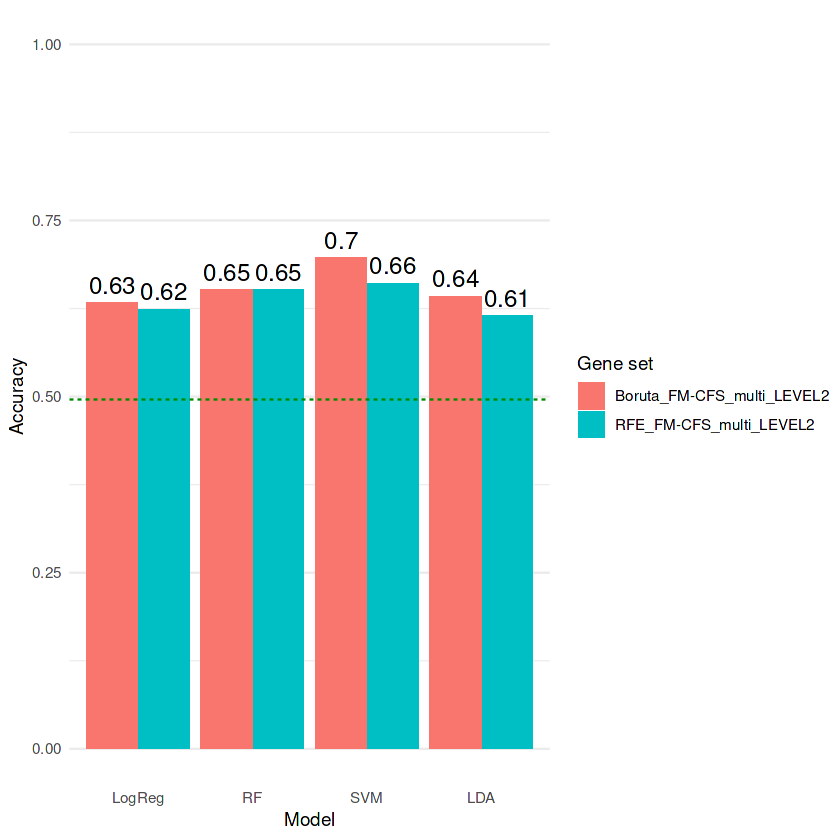

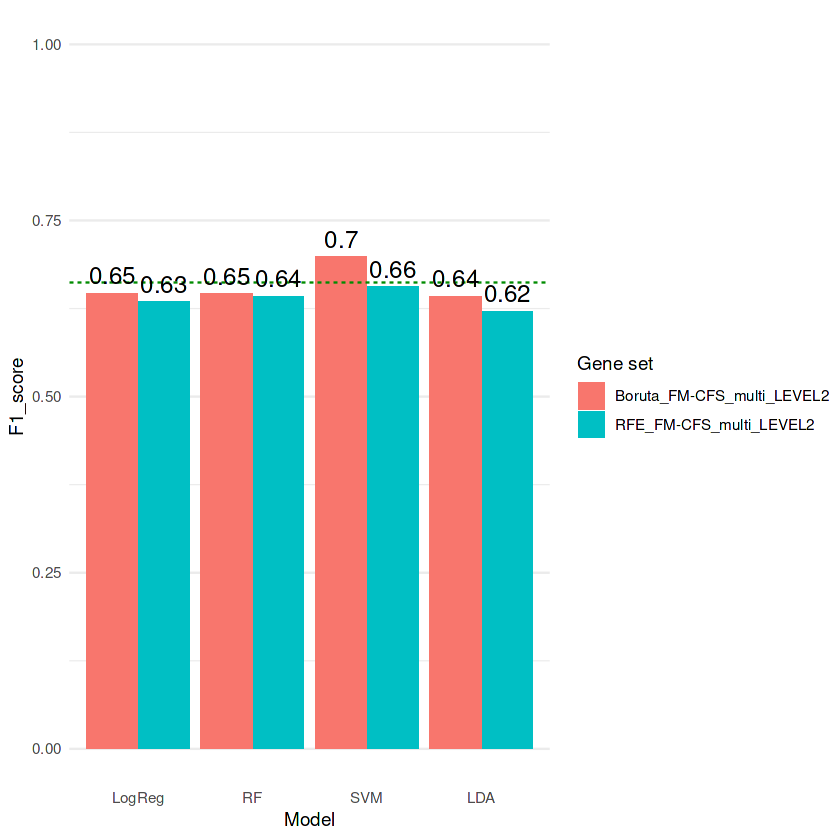

In [ ]:
# Calculating accuracy for baseline model
# F1-score and accuracies for models

table(Y_train_as_factor)
majority_class <- "HC combined"
Y_pred_zeroR <- factor(rep(majority_class, length(Y_test_as_factor)), levels=levels(Y_test_as_factor))

confusion_matrix_baseline <- confusionMatrix(Y_pred_zeroR, Y_test_as_factor, mode="prec_recall")
   precision <- confusion_matrix_baseline$byClass[,"Precision"]
   accuracy_baseline <- confusion_matrix_baseline$overall['Accuracy']
   recall <- confusion_matrix_baseline$byClass[,"Recall"]
   f1_per_class <- 2 * (precision * recall) / (precision + recall)
   macro_f1_baseline <- mean(f1_per_class, na.rm = TRUE)


colnames(accuracy_table) <- c("model_id", "Accuracy", "F1_score", "Gene set", "Model")
accuracy_table$`Model` <- factor(accuracy_table$`Model`, levels = c("LogReg", "RF", "SVM", "LDA"))

ggplot(accuracy_table, aes(fill=`Gene set`, y=Accuracy, x=`Model`)) +
  geom_bar(position="dodge", stat="identity") +
  geom_hline(yintercept = accuracy_baseline, linetype = "dashed", color = "green4") +
  scale_y_continuous(limits = c(0, 1)) +
  geom_text(aes(label = round(Accuracy, 2)),
            position = position_dodge(0.9),
            vjust = -0.5,
            size = 5) +
  theme_minimal() +
  theme(
    panel.grid.major.x = element_blank(),
    panel.grid.minor.x = element_blank()
  )


ggplot(accuracy_table, aes(fill=`Gene set`, y=F1_score, x=`Model`)) +
  geom_bar(position="dodge", stat="identity") +
  geom_hline(yintercept = macro_f1_baseline, linetype = "dashed", color = "green4") +
  scale_y_continuous(limits = c(0, 1)) +
  geom_text(aes(label = round(F1_score, 2)),
            position = position_dodge(0.9),
            vjust = -0.5,
            size = 5) +
  theme_minimal() +
  theme(
    panel.grid.major.x = element_blank(),
    panel.grid.minor.x = element_blank()
  )

# Enrichment analysis

In [ ]:
library(org.Hs.eg.db)
library(clusterProfiler)
library(eulerr)
library(qs)
library("enrichplot")

#### Annotating genes yielded best classification model performance: DGE_FM_1 and DGE_CFS_3

In [ ]:
### Uploading genesets

dge_res <- qread("/kaggle/input/dge-wgcna-res/DGE_FM_1_res_annot.qs")
dge_res_filtered <- dge_res %>%
   filter(
           entrezid != "" &
           !is.na(entrezid) &
           entrezid != "NA" &
           padj < 0.05
   )
dge_res_filtered <- dge_res_filtered %>%
  group_by(gene_name) %>%
  filter(pvalue == min(pvalue)) %>%
  ungroup()

top_genes <- dge_res_filtered %>% # selecting top 200 genes by logFC
   arrange(desc(abs(log2FoldChange))) %>%
   slice_head(n = 200)

DGE_FM_1_top <- top_genes$entrezid
DGE_FM_1 <- dge_res_filtered$entrezid

In [ ]:
dge_res <- qread("/kaggle/input/dge-wgcna-res/DGE_CFS_3_res_annot.qs")

dge_res_filtered <- dge_res %>%
   filter(
           entrezid != "" &
           !is.na(entrezid) &
           entrezid != "NA" &
           padj < 0.05
   )
dge_res_filtered <- dge_res_filtered %>%
  group_by(gene_name) %>%
  filter(pvalue == min(pvalue)) %>%
  ungroup()

top_genes <- dge_res_filtered %>% # selecting top 200 genes by logFC
   arrange(desc(abs(log2FoldChange))) %>%
   slice_head(n = 200)

DGE_CFS_3_top <- top_genes$entrezid
DGE_CFS_3 <- dge_res_filtered$entrezid

In [ ]:
### Enrichment analyses for DGE_CFS_3 and DGE_FM_1 respectively

[1] "################################## DGE_CFS_3 ##################################"


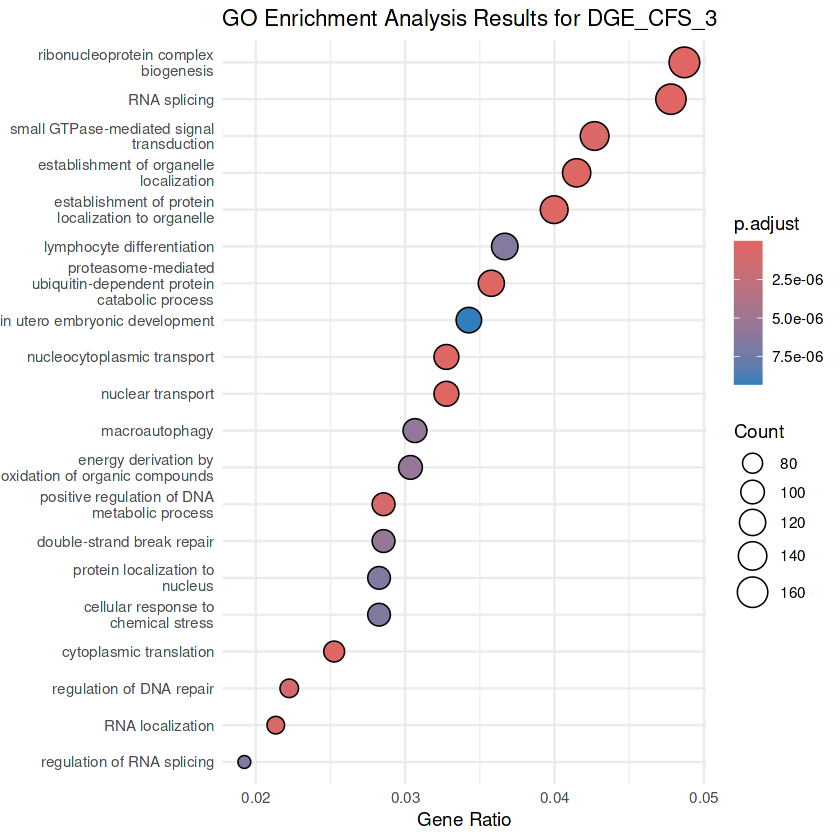

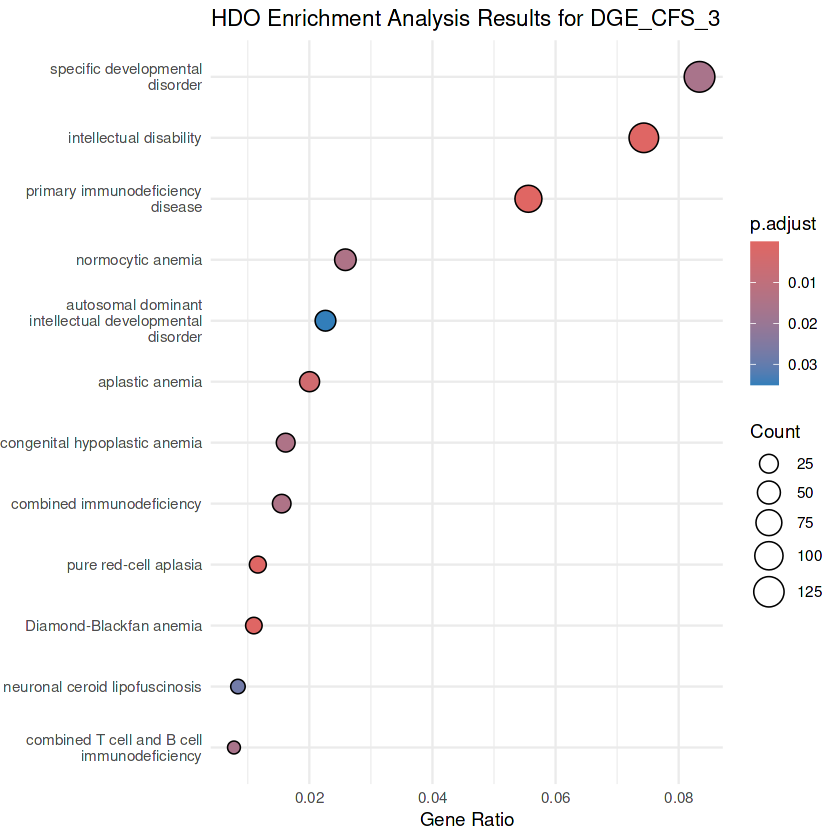

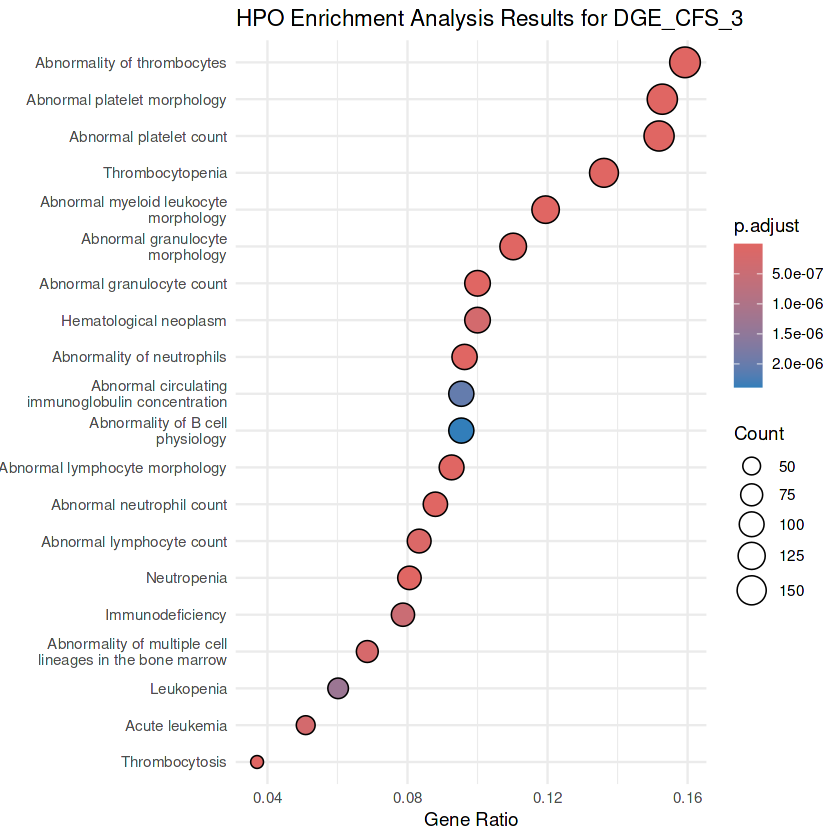

In [ ]:
genesets_multi <- list(
    DGE_CFS_3 = DGE_CFS_3
    # DGE_CFS_3_top = DGE_CFS_3_top
    # DGE_FM_1_top = DGE_FM_1_top
)
for (genelist_name in names(genesets_multi)) {

    print(paste0("################################## ", genelist_name, " ##################################"))
    genelist <- genesets_multi[[genelist_name]]

    go_results <- enrichGO(
      gene = genelist,
      OrgDb = org.Hs.eg.db,
      ont = "BP",
      pAdjustMethod = "BH",
      pvalueCutoff = 0.05,
      qvalueCutoff = 0.2,
      readable = TRUE
    )
    go_results <- simplify(go_results, cutoff=0.7, by="p.adjust", select_fun=min)

    dot_plot <- dotplot(go_results, color='p.adjust', showCategory=20) +
      ggtitle(paste0("GO Enrichment Analysis Results for ", genelist_name)) +
      labs(x = "Gene Ratio") +
      theme_minimal()
    print(dot_plot)

    qsave(go_results, paste0(genelist_name, "_go_results.qs"))
    write.csv(go_results, file = paste0(genelist_name, "_go_results.csv"), row.names = FALSE)


    do_enrich <- enrichDO(gene = genelist,
                      ont = "HDO",
                      pvalueCutoff = 0.05,
                      pAdjustMethod = "BH",
                      readable = TRUE)

    dot_plot <- dotplot(do_enrich, color='p.adjust', showCategory=20) +
      ggtitle(paste0("HDO Enrichment Analysis Results for ", genelist_name)) +
      labs(x = "Gene Ratio") +
      theme_minimal()
    print(dot_plot)

    qsave(do_enrich, paste0(genelist_name, "_hdo_results.qs"))
    write.csv(do_enrich, file = paste0(genelist_name, "_hdo_results.csv"), row.names = FALSE)

    hpo_enrich <- enrichDO(gene = genelist,
                      ont = "HPO",
                      pvalueCutoff = 0.05,
                      pAdjustMethod = "BH",
                      readable = TRUE)

    dot_plot <- dotplot(hpo_enrich, color='p.adjust', showCategory=20) +
      ggtitle(paste0("HPO Enrichment Analysis Results for ", genelist_name)) +
      labs(x = "Gene Ratio") +
      theme_minimal()
    print(dot_plot)

    qsave(hpo_enrich, paste0(genelist_name, "_hpo_results.qs"))
    write.csv(hpo_enrich, file = paste0(genelist_name, "_hpo_results.csv"), row.names = FALSE)
}

[1] "################################## DGE_FM_1 ##################################"


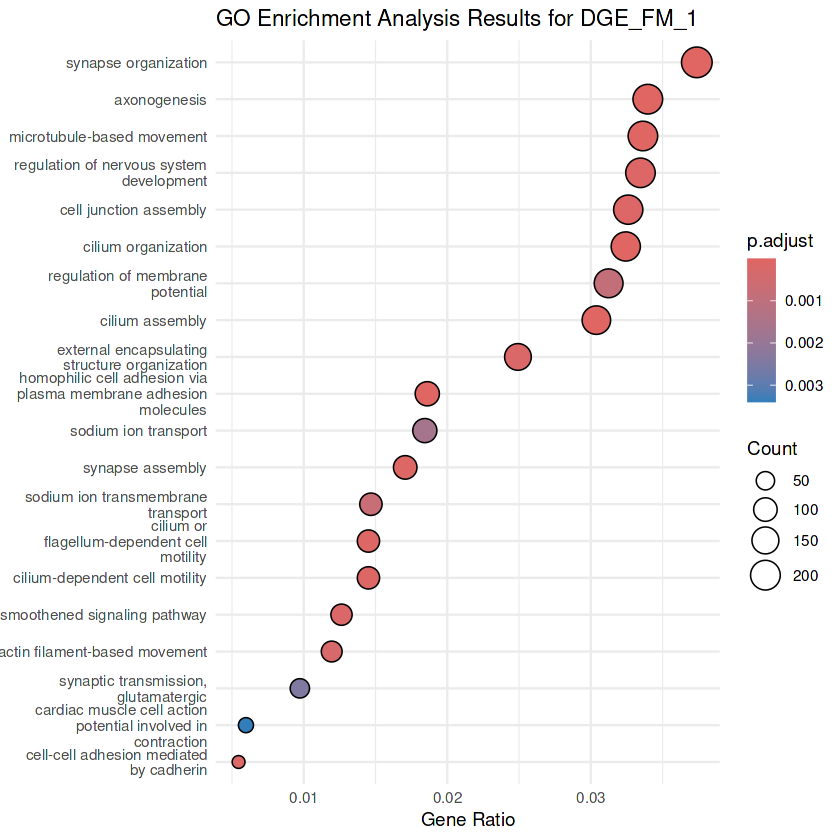

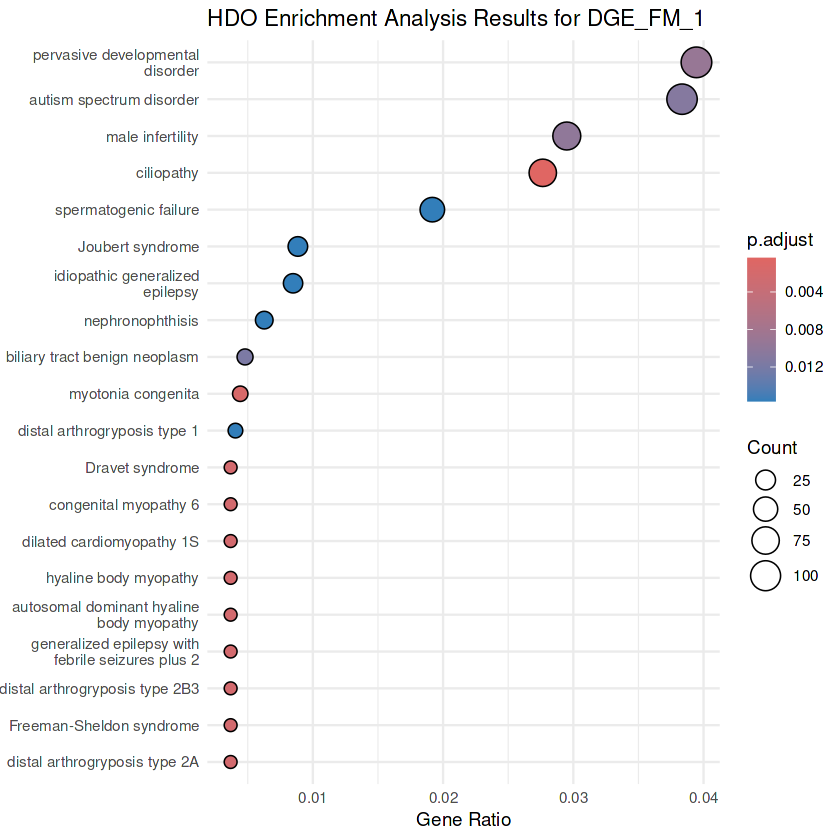

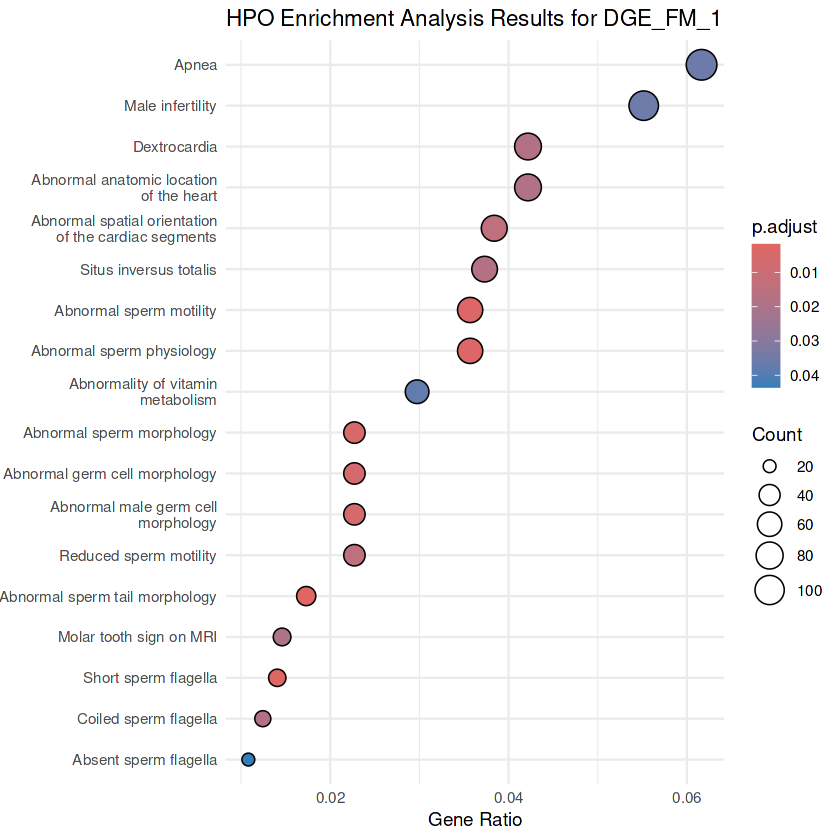

In [ ]:
genesets_multi <- list(
    # DGE_CFS_3_top = DGE_CFS_3_top,
    # DGE_FM_1_top = DGE_FM_1_top
    DGE_FM_1 = DGE_FM_1

)

for (genelist_name in names(genesets_multi)) {

    print(paste0("################################## ", genelist_name, " ##################################"))
    genelist <- genesets_multi[[genelist_name]]

    go_results <- enrichGO(
      gene = genelist,
      OrgDb = org.Hs.eg.db,
      ont = "BP",
      pAdjustMethod = "BH",
      pvalueCutoff = 0.05,
      qvalueCutoff = 0.2,
      readable = TRUE
    )
    go_results <- simplify(go_results, cutoff=0.7, by="p.adjust", select_fun=min)

    dot_plot <- dotplot(go_results, color='p.adjust', showCategory=20) +
      ggtitle(paste0("GO Enrichment Analysis Results for ", genelist_name)) +
      labs(x = "Gene Ratio") +
      theme_minimal()
    print(dot_plot)

    qsave(go_results, paste0(genelist_name, "_go_results.qs"))
    write.csv(go_results, file = paste0(genelist_name, "_go_results.csv"), row.names = FALSE)


    do_enrich <- enrichDO(gene = genelist,
                      ont = "HDO",
                      pvalueCutoff = 0.05,
                      pAdjustMethod = "BH",
                      readable = TRUE)

    dot_plot <- dotplot(do_enrich, color='p.adjust', showCategory=20) +
      ggtitle(paste0("HDO Enrichment Analysis Results for ", genelist_name)) +
      labs(x = "Gene Ratio") +
      theme_minimal()
    print(dot_plot)

    qsave(do_enrich, paste0(genelist_name, "_hdo_results.qs"))
    write.csv(do_enrich, file = paste0(genelist_name, "_hdo_results.csv"), row.names = FALSE)

    hpo_enrich <- enrichDO(gene = genelist,
                      ont = "HPO",
                      pvalueCutoff = 0.05,
                      pAdjustMethod = "BH",
                      readable = TRUE)

    dot_plot <- dotplot(hpo_enrich, color='p.adjust', showCategory=20) +
      ggtitle(paste0("HPO Enrichment Analysis Results for ", genelist_name)) +
      labs(x = "Gene Ratio") +
      theme_minimal()
    print(dot_plot)

    qsave(hpo_enrich, paste0(genelist_name, "_hpo_results.qs"))
    write.csv(hpo_enrich, file = paste0(genelist_name, "_hpo_results.csv"), row.names = FALSE)
}

In [ ]:
logreg_res <- qread("/kaggle/working/Boruta_FM-CFS_multi_LEVEL1_coefs_logreg.qs")

In [ ]:
wgcna_res <- qread("/kaggle/input/dge-wgcna-res/WGSNA_FM_1_res_annot.qs")
tail(wgcna_res)

p.GS.disease_state_Healthy patient (CONTROL) gene_id         gene_name
8934 0.42163406                                   ENSG00000292414          
8935 0.06471138                                   ENSG00000293606          
8936 0.83233586                                   ENSG00000293686          
8937 0.06022325                                   ENSG00000293689          
8938 0.73544475                                   ENSG00000293691          
8939 0.62576256                                   ENSG00000310517 CAST     
     gene_biotype                     seq_coord_system
8934 processed_pseudogene             scaffold        
8935 protein_coding                   chromosome      
8936 transcribed_processed_pseudogene chromosome      
8937 protein_coding                   chromosome      
8938 protein_coding                   chromosome      
8939 protein_coding                   chromosome      
     description                                                 
8934 POM121 membrane glycoprotein (POM121) pseudogene            
8935 novel protein, readthrough between SLC5A3 and MRPS6         
8936 tigger transposable element derived 1 (TIGD1) pseudogene    
8937 novel protein                                               
8938 novel protein                                               
8939 calpastatin [Source:NCBI gene (formerly Entrezgene);Acc:831]
     gene_id_version   canonical_transcript symbol entrezid  ⋯
8934 ENSG00000292414.1 ENST00000711566             124905413 ⋯
8935 ENSG00000293606.1 ENST00000715811                    NA ⋯
8936 ENSG00000293686.1 ENST00000718255                    NA ⋯
8937 ENSG00000293689.1 ENST00000718358                    NA ⋯
8938 ENSG00000293691.1 ENST00000718364                    NA ⋯
8939 ENSG00000310517.1 ENST00000675179      CAST         831 ⋯
     WaldStatistic_sex_male_vs_female
8934  0.4025764                      
8935 -0.4764474                      
8936  0.5762509                      
8937  0.3817672                      
8938  0.8336985                      
8939  2.4639894                      
     WaldStatistic_disease_state_Fibromylagia.patient..FMA._vs_Healthy.patient..CONTROL.
8934  2.2334633                                                                         
8935  1.6014511                                                                         
8936 -0.2897144                                                                         
8937  1.6683587                                                                         
8938  0.1635335                                                                         
8939  1.3492800                                                                         
     WaldPvalue_Intercept WaldPvalue_sex_male_vs_female
8934  1.363821e-09        0.68725989                   
8935  0.000000e+00        0.63375566                   
8936  5.383799e-70        0.56444563                   
8937 9.038499e-200        0.70263402                   
8938  0.000000e+00        0.40445091                   
8939  0.000000e+00        0.01374002                   
     WaldPvalue_disease_state_Fibromylagia.patient..FMA._vs_Healthy.patient..CONTROL.
8934 0.02551841                                                                      
8935 0.10927705                                                                      
8936 0.77203474                                                                      
8937 0.09524454                                                                      
8938 0.87009842                                                                      
8939 0.17724704                                                                      
     betaConv betaIter deviance  maxCooks   replace
8934 TRUE     29        895.2947 0.04757765  TRUE  
8935 TRUE      5       1760.2077 0.10073114 FALSE  
8936 TRUE      6       1412.1178 0.06082840 FALSE  
8937 TRUE      5       1713.7188 0.01809389 FALSE  
8938 TRUE      4       2056.3054 0.0253467

In [ ]:
# FM2 - enterezid

wgcna_res <- qread("/kaggle/input/dge-wgcna-res/WGSNA_FM_2_res_annot.qs")
wgcna_res <- wgcna_res %>%
  group_by(SYMBOL) %>%
  filter(`p.GS.diagnosis_fibromyalgia` == min(`p.GS.diagnosis_fibromyalgia`)) %>%
  ungroup()
WGCNA_gid_FM_2 <- unique(wgcna_res[!is.na(wgcna_res$SYMBOL) & wgcna_res$`p.GS.diagnosis_fibromyalgia` < 0.05, ]$ENTREZID)

# FM1 both

wgcna_res <- qread("/kaggle/input/dge-wgcna-res/WGSNA_FM_1_res_annot.qs")
wgcna_res_filtered  <- wgcna_res %>%
  group_by(gene_name) %>%
  filter(`p.GS.disease_state_Healthy patient (CONTROL)` == min(`p.GS.disease_state_Healthy patient (CONTROL)`)) %>%
  ungroup()
wgcna_res_filtered  <- wgcna_res_filtered %>%
   filter(
           gene_name != "" &
           !is.na(gene_name) &
           gene_name != "NA" &
           `p.GS.disease_state_Healthy patient (CONTROL)` < 0.05
   )
WGCNA_gid_FM_1 <- unique(c(wgcna_res_filtered$entrezid))

wgcna_res <- qread("/kaggle/input/dge-wgcna-res/WGSNA_CFS_2_res_annot.qs")
wgcna_res_filtered  <- wgcna_res %>%
  group_by(gene_name) %>%
  filter(`p.GS.disease_state_PI-ME/CFS` == min(`p.GS.disease_state_PI-ME/CFS`)) %>%
  ungroup()
wgcna_res_filtered  <- wgcna_res_filtered %>%
   filter(
           gene_name != "" &
           !is.na(gene_name) &
           gene_name != "NA" &
           `p.GS.disease_state_PI-ME/CFS` < 0.05
   )
WGCNA_gid_CFS_2 <- unique(c(wgcna_res_filtered$entrezid))

# cfs-3
wgcna_res <- qread("/kaggle/input/dge-wgcna-res/WGSNA_CFS_3_res_annot.qs")
wgcna_res_filtered  <- wgcna_res %>%
  group_by(gene_name) %>%
  filter(`p.GS..data_healthy_control` == min(`p.GS..data_healthy_control`)) %>%
  ungroup()
wgcna_res_filtered  <- wgcna_res_filtered %>%
   filter(
           gene_name != "" &
           !is.na(gene_name) &
           gene_name != "NA" &
           `p.GS..data_healthy_control` < 0.05
   )

WGCNA_gid_CFS_3 <- unique(c(wgcna_res_filtered$entrezid))

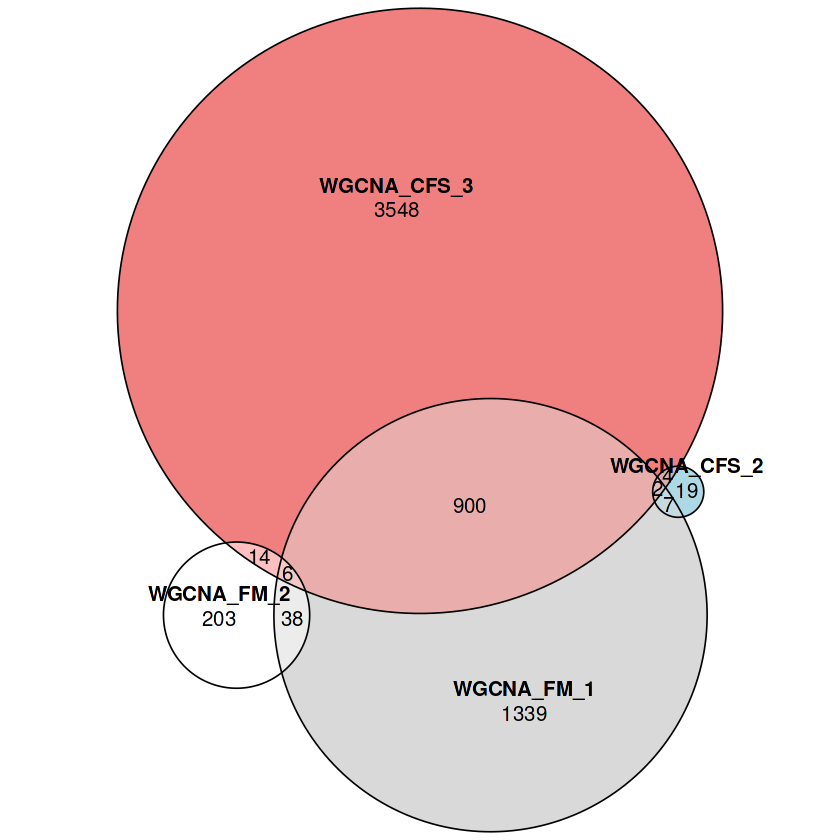

In [ ]:
genesets_multi <- list(
    WGCNA_FM_2 = WGCNA_gid_FM_2,
    WGCNA_FM_1 = WGCNA_gid_FM_1,
    WGCNA_CFS_2 = WGCNA_gid_CFS_2, # no sign res
    WGCNA_CFS_3 = WGCNA_gid_CFS_3
)

fit1 <- euler(genesets_multi)
venn <- plot(fit1, quantities = TRUE, legend=FALSE)
print(venn)

In [ ]:
do_enrich

#
# over-representation test
#
#...@organism 	 Homo sapiens 
#...@ontology 	 HDO 
#...@keytype 	 ENTREZID 
#...@gene 	 chr [1:2292] "8813" "57147" "2729" "54467" "1595" "889" "3927" "843" ...
#...pvalues adjusted by 'BH' with cutoff <0.05 
#...0 enriched terms found
#...Citation
 T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu.
 clusterProfiler 4.0: A universal enrichment tool for interpreting omics data.
 The Innovation. 2021, 2(3):100141 


[1] "################################## WGCNA_FM_2 ##################################"


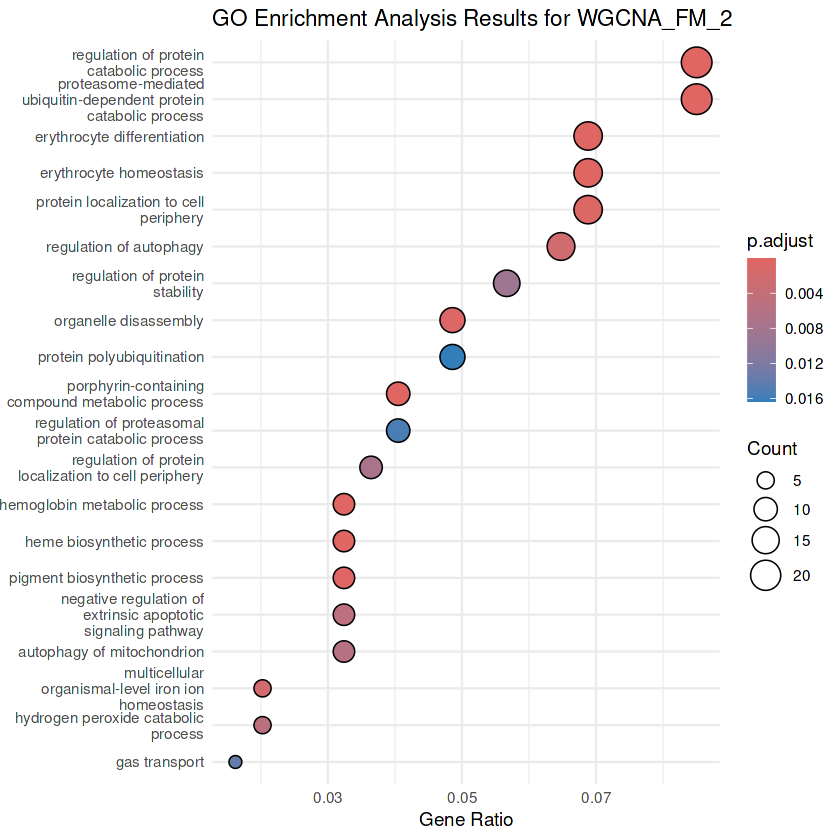

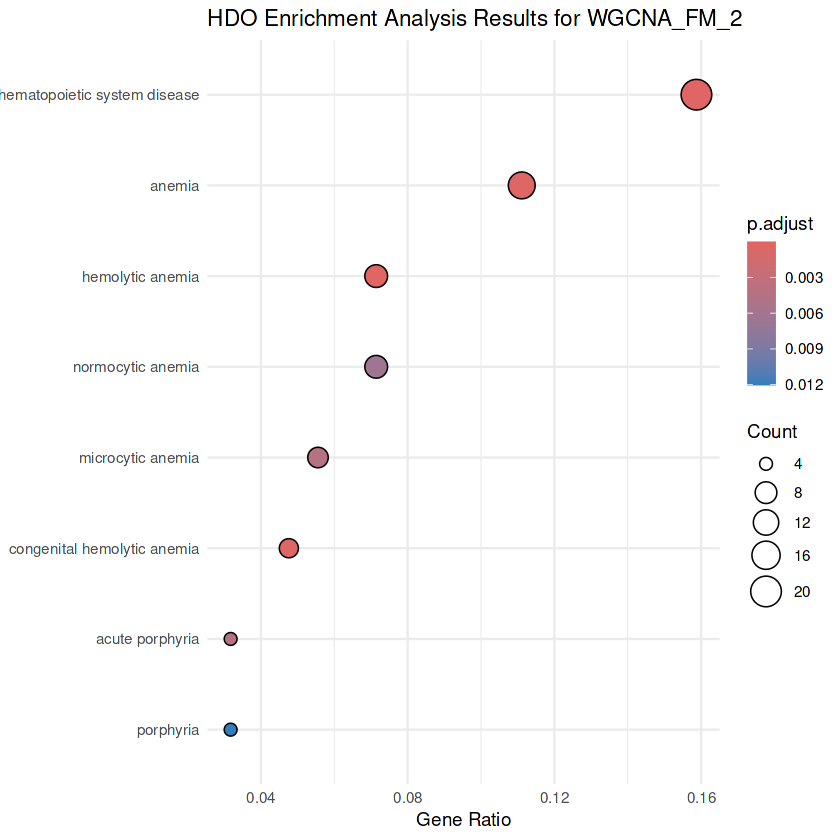

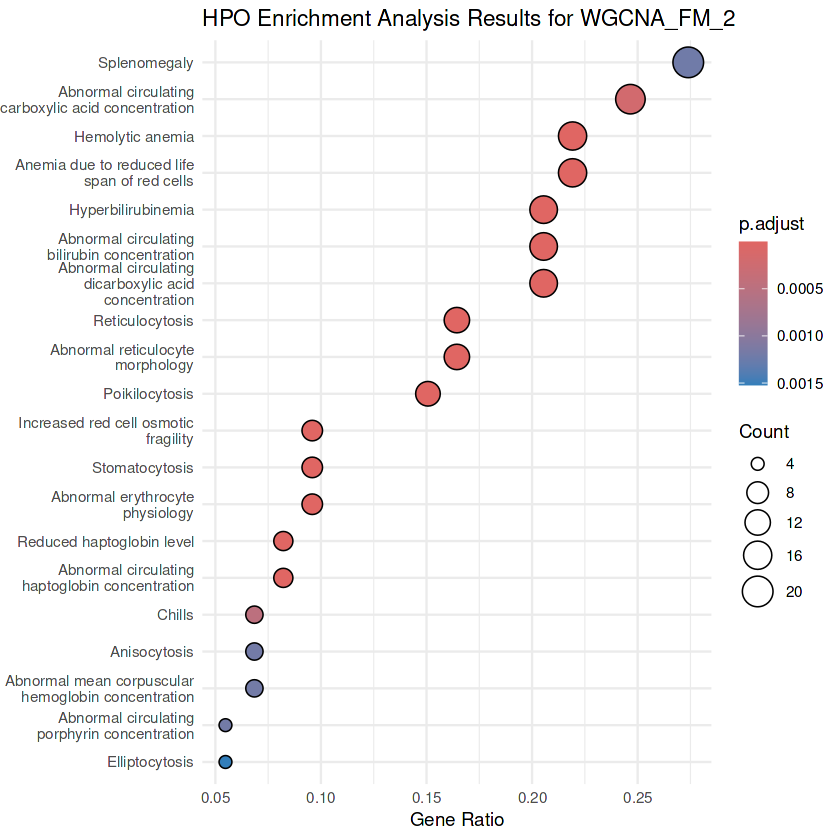

In [ ]:
genesets_multi <- list(
    WGCNA_FM_2 = WGCNA_gid_FM_2
    # WGCNA_FM_1 = WGCNA_gid_FM_1,
    # WGCNA_CFS_2 = WGCNA_gid_CFS_2, # no sign res
    # WGCNA_CFS_3 = WGCNA_gid_CFS_3
)
for (genelist_name in names(genesets_multi)) {

    print(paste0("################################## ", genelist_name, " ##################################"))
    genelist <- genesets_multi[[genelist_name]]

    go_results <- enrichGO(
      gene = genelist,
      OrgDb = org.Hs.eg.db,
      ont = "BP",
      pAdjustMethod = "BH",
      pvalueCutoff = 0.05,
      qvalueCutoff = 0.2,
      readable = TRUE
    )
    go_results <- simplify(go_results, cutoff=0.7, by="p.adjust", select_fun=min)

    dot_plot <- dotplot(go_results, color='p.adjust', showCategory=20) +
      ggtitle(paste0("GO Enrichment Analysis Results for ", genelist_name)) +
      labs(x = "Gene Ratio") +
      theme_minimal()
    print(dot_plot)

    qsave(go_results, paste0(genelist_name, "_go_results.qs"))
    write.csv(go_results, file = paste0(genelist_name, "_go_results.csv"), row.names = FALSE)


    do_enrich <- enrichDO(gene = genelist,
                      ont = "HDO",
                      pvalueCutoff = 0.05,
                      pAdjustMethod = "BH",
                      readable = TRUE)

    dot_plot <- dotplot(do_enrich, color='p.adjust', showCategory=20) +
      ggtitle(paste0("HDO Enrichment Analysis Results for ", genelist_name)) +
      labs(x = "Gene Ratio") +
      theme_minimal()
    print(dot_plot)

    qsave(do_enrich, paste0(genelist_name, "_hdo_results.qs"))
    write.csv(do_enrich, file = paste0(genelist_name, "_hdo_results.csv"), row.names = FALSE)

    hpo_enrich <- enrichDO(gene = genelist,
                      ont = "HPO",
                      pvalueCutoff = 0.05,
                      pAdjustMethod = "BH",
                      readable = TRUE)

    dot_plot <- dotplot(hpo_enrich, color='p.adjust', showCategory=20) +
      ggtitle(paste0("HPO Enrichment Analysis Results for ", genelist_name)) +
      labs(x = "Gene Ratio") +
      theme_minimal()
    print(dot_plot)

    qsave(hpo_enrich, paste0(genelist_name, "_hpo_results.qs"))
    write.csv(hpo_enrich, file = paste0(genelist_name, "_hpo_results.csv"), row.names = FALSE)
}

[1] "################################## WGCNA_FM_1 ##################################"


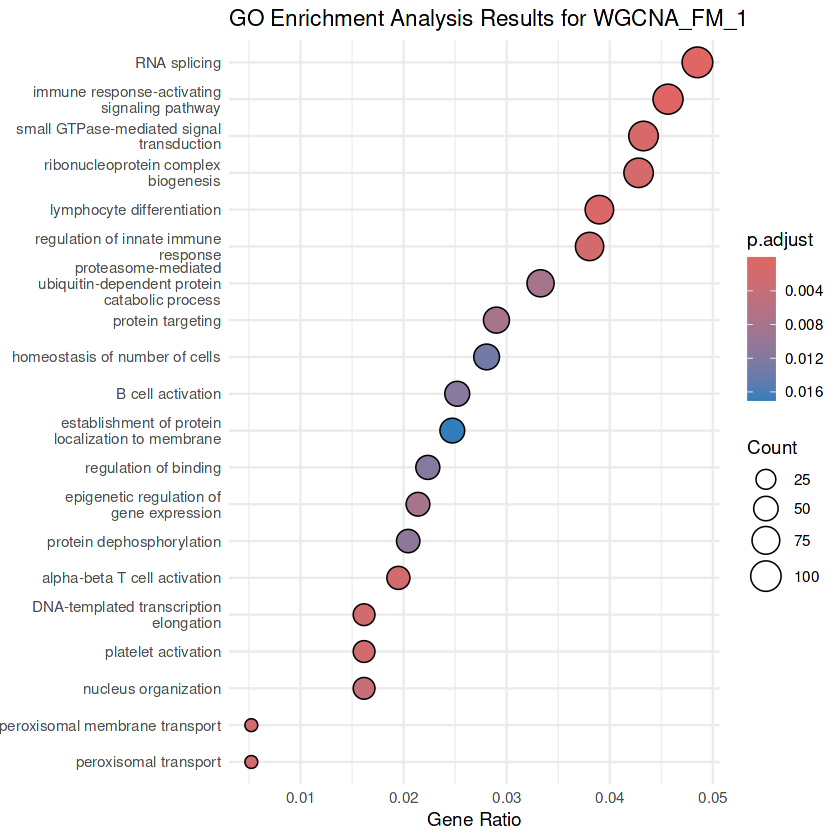

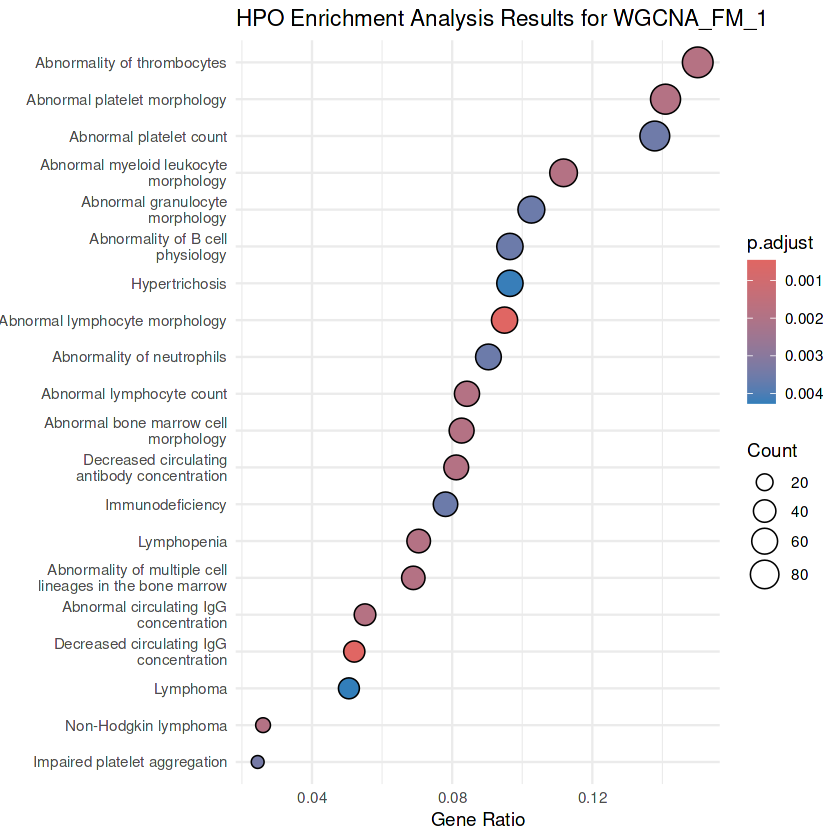

In [ ]:
genesets_multi <- list(
    # WGCNA_FM_2 = WGCNA_gid_FM_2
    WGCNA_FM_1 = WGCNA_gid_FM_1
    # WGCNA_CFS_2 = WGCNA_gid_CFS_2, # no sign res
    # WGCNA_CFS_3 = WGCNA_gid_CFS_3
)
for (genelist_name in names(genesets_multi)) {

    print(paste0("################################## ", genelist_name, " ##################################"))
    genelist <- genesets_multi[[genelist_name]]

    go_results <- enrichGO(
      gene = genelist,
      OrgDb = org.Hs.eg.db,
      ont = "BP",
      pAdjustMethod = "BH",
      pvalueCutoff = 0.05,
      qvalueCutoff = 0.2,
      readable = TRUE
    )
    go_results <- simplify(go_results, cutoff=0.7, by="p.adjust", select_fun=min)

    dot_plot <- dotplot(go_results, color='p.adjust', showCategory=20) +
      ggtitle(paste0("GO Enrichment Analysis Results for ", genelist_name)) +
      labs(x = "Gene Ratio") +
      theme_minimal()
    print(dot_plot)

    qsave(go_results, paste0(genelist_name, "_go_results.qs"))
    write.csv(go_results, file = paste0(genelist_name, "_go_results.csv"), row.names = FALSE)

    hpo_enrich <- enrichDO(gene = genelist,
                      ont = "HPO",
                      pvalueCutoff = 0.05,
                      pAdjustMethod = "BH",
                      readable = TRUE)

    dot_plot <- dotplot(hpo_enrich, color='p.adjust', showCategory=20) +
      ggtitle(paste0("HPO Enrichment Analysis Results for ", genelist_name)) +
      labs(x = "Gene Ratio") +
      theme_minimal()
    print(dot_plot)

    qsave(hpo_enrich, paste0(genelist_name, "_hpo_results.qs"))
    write.csv(hpo_enrich, file = paste0(genelist_name, "_hpo_results.csv"), row.names = FALSE)
}

[1] "################################## WGCNA_CFS_3 ##################################"


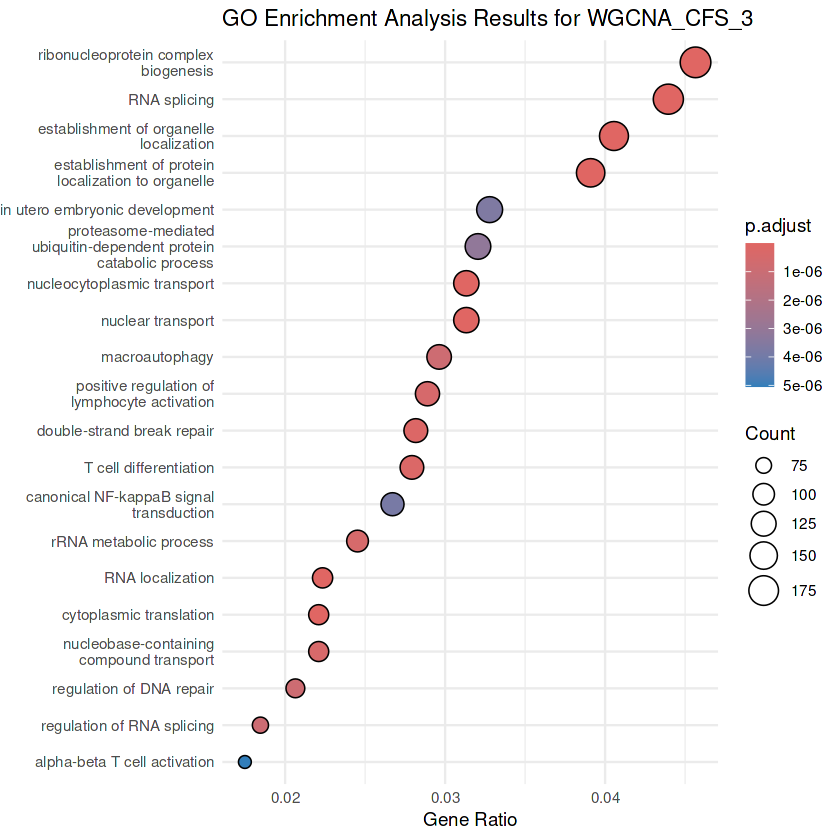

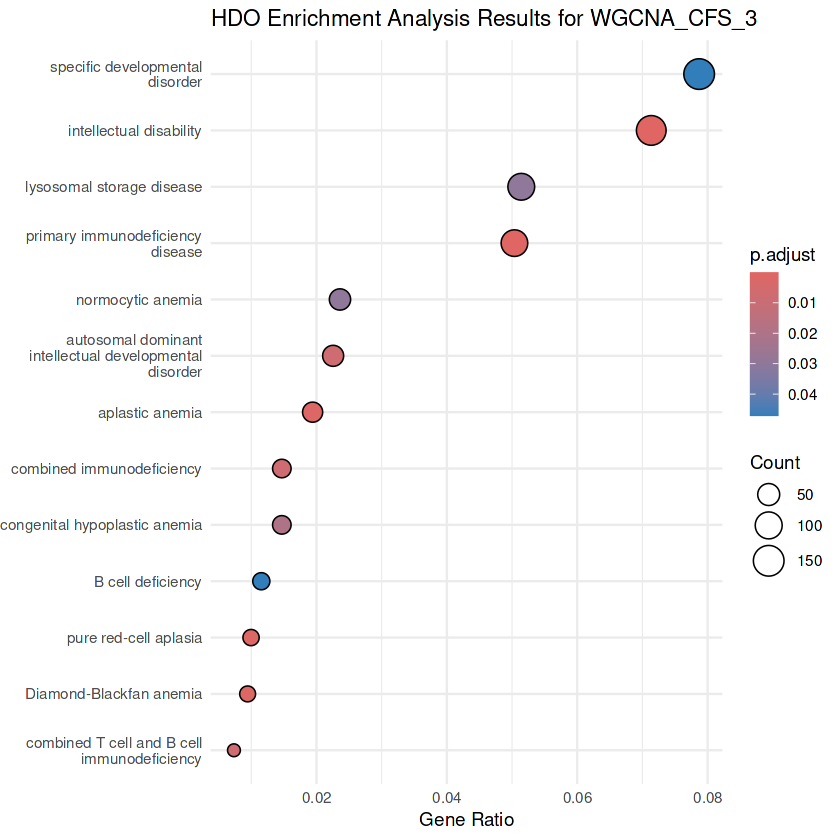

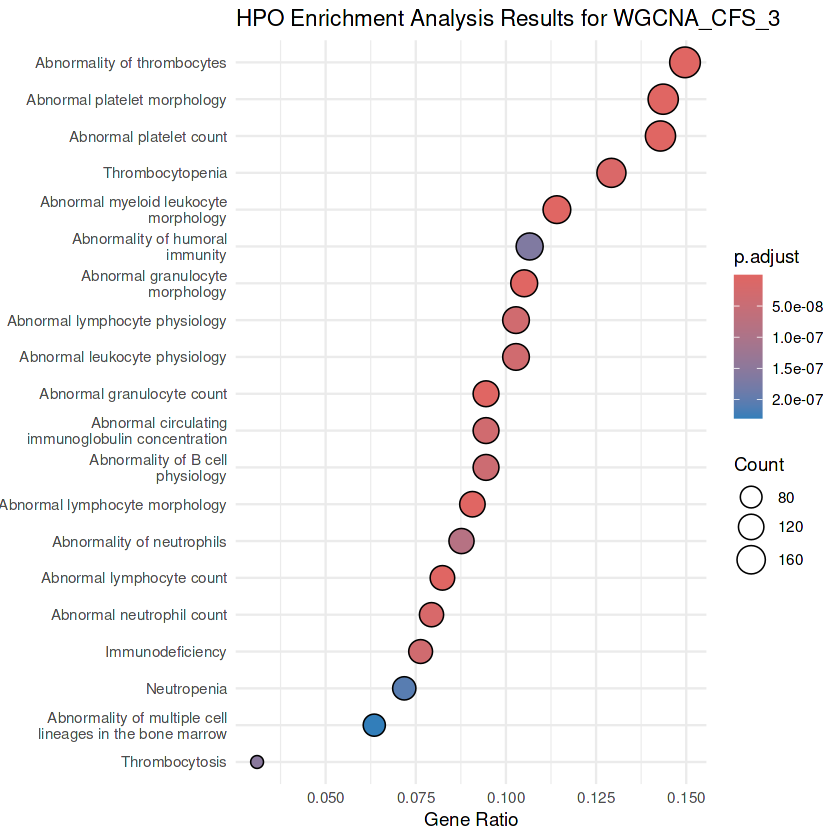

In [ ]:
genesets_multi <- list(
    # WGCNA_FM_2 = WGCNA_gid_FM_2
    # WGCNA_FM_1 = WGCNA_gid_FM_1,
    # WGCNA_CFS_2 = WGCNA_gid_CFS_2, # no sign res
    WGCNA_CFS_3 = WGCNA_gid_CFS_3
)
for (genelist_name in names(genesets_multi)) {
    genelist <- genesets_multi[[genelist_name]]

    go_results <- enrichGO(
      gene = genelist,
      OrgDb = org.Hs.eg.db,
      ont = "BP",
      pAdjustMethod = "BH",
      pvalueCutoff = 0.05,
      qvalueCutoff = 0.2,
      readable = TRUE
    )
    go_results <- simplify(go_results, cutoff=0.7, by="p.adjust", select_fun=min)

    dot_plot <- dotplot(go_results, color='p.adjust', showCategory=20) +
      ggtitle(paste0("GO Enrichment Analysis Results for ", genelist_name)) +
      labs(x = "Gene Ratio") +
      theme_minimal()
    print(dot_plot)

    qsave(go_results, paste0(genelist_name, "_go_results.qs"))
    write.csv(go_results, file = paste0(genelist_name, "_go_results.csv"), row.names = FALSE)


    do_enrich <- enrichDO(gene = genelist,
                      ont = "HDO",
                      pvalueCutoff = 0.05,
                      pAdjustMethod = "BH",
                      readable = TRUE)

    dot_plot <- dotplot(do_enrich, color='p.adjust', showCategory=20) +
      ggtitle(paste0("HDO Enrichment Analysis Results for ", genelist_name)) +
      labs(x = "Gene Ratio") +
      theme_minimal()
    print(dot_plot)

    qsave(do_enrich, paste0(genelist_name, "_hdo_results.qs"))
    write.csv(do_enrich, file = paste0(genelist_name, "_hdo_results.csv"), row.names = FALSE)

    hpo_enrich <- enrichDO(gene = genelist,
                      ont = "HPO",
                      pvalueCutoff = 0.05,
                      pAdjustMethod = "BH",
                      readable = TRUE)

    dot_plot <- dotplot(hpo_enrich, color='p.adjust', showCategory=20) +
      ggtitle(paste0("HPO Enrichment Analysis Results for ", genelist_name)) +
      labs(x = "Gene Ratio") +
      theme_minimal()
    print(dot_plot)

    qsave(hpo_enrich, paste0(genelist_name, "_hpo_results.qs"))
    write.csv(hpo_enrich, file = paste0(genelist_name, "_hpo_results.csv"), row.names = FALSE)
}

In [ ]:
library(writexl)

csv_files <- list.files(pattern = "_results\\.csv$", full.names = TRUE)
sheet_list <- setNames(
  lapply(csv_files, read.csv),
  tools::file_path_sans_ext(basename(csv_files))
)
write_xlsx(sheet_list, "enrichment_results_merged.xlsx")

In [ ]:
WGCNA_FM_1_go_results <- qread("WGCNA_FM_1_go_results.qs")$ID
WGCNA_FM_2_go_results <- qread("WGCNA_FM_2_go_results.qs")$ID
WGCNA_CFS_3_go_results <- qread("WGCNA_CFS_3_go_results.qs")$ID

In [ ]:
FM_1_go_results <- qread("WGCNA_FM_1_go_results.qs")
FM_2_go_results <- qread("WGCNA_FM_2_go_results.qs")
CFS_3_go_results <- qread("WGCNA_CFS_3_go_results.qs")

In [ ]:
x <- intersect(WGCNA_FM_1_go_results, WGCNA_CFS_3_go_results)
x
print("next")
y <- intersect(WGCNA_FM_2_go_results, WGCNA_CFS_3_go_results)
y

[1] "GO:0006997" "GO:0006354" "GO:0042113" "GO:0006605" "GO:0040029"
 [6] "GO:0034470" "GO:0032259" "GO:0043484" "GO:0090150" "GO:0042254"
[11] "GO:0072594" "GO:0016072" "GO:0043161" "GO:0006457"

[1] "next"


[1] "GO:0042176" "GO:0043161" "GO:1903008" "GO:0031647" "GO:0016236"
[6] "GO:0009895"

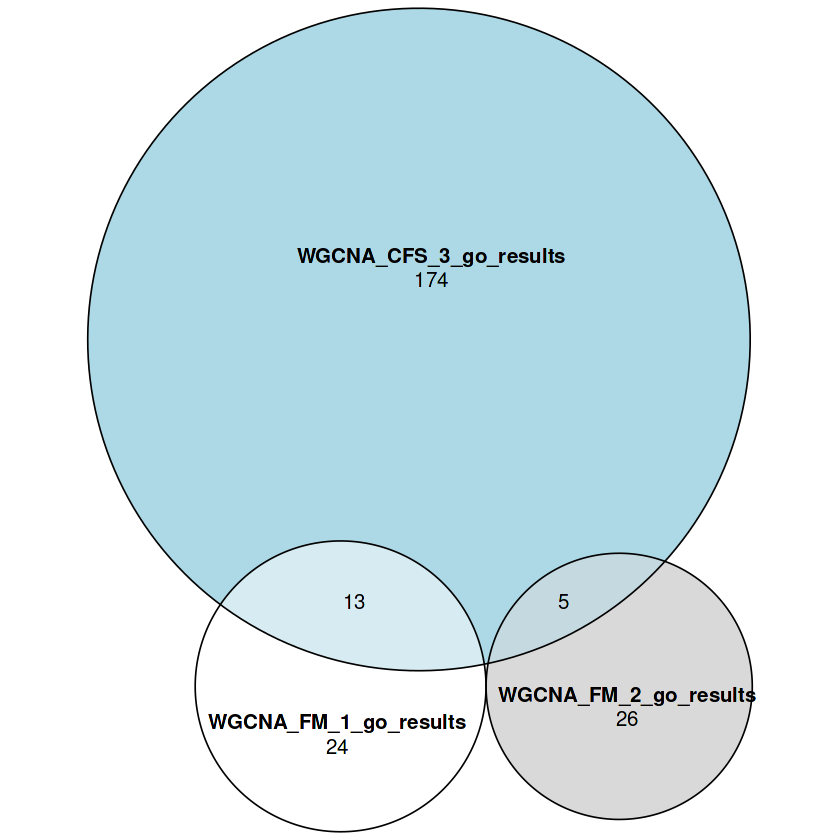

In [ ]:
venn_list <- list(
    WGCNA_FM_1_enrichGO = WGCNA_FM_1_go_results,
    WGCNA_FM_2_enrichGO = WGCNA_FM_2_go_results,
    WGCNA_CFS_3_enrichGO = WGCNA_CFS_3_go_results
)

fit1 <- euler(venn_list)
venn <- plot(fit1, quantities = TRUE)
print(venn)